## Pythonによるマーケティングミックスモデリング （MMM：Marketing Mix Modeling）超入門 その4 最適なアドストック（Ad Stock）を探索しモデル構築

url: https://www.salesanalytics.co.jp/datascience/datascience0100/

url: https://www.salesanalytics.co.jp/mmm-intro/

    本当に売上に貢献している広告は、どの広告か？

    売上と広告媒体等との関係性をモデリングし、どの広告媒体が売上にどれほど貢献していたのか分析することができます。

    それが、マーケティングミックスモデリング（MMM：Marketing Mix Modeling）です。

    前回と前々回、アドストック（Ad Stock）を考慮した線形回帰モデルのお話しをしました。

    以下は、前々回の記事です。

    url: https://www.salesanalytics.co.jp/datascience/datascience0098/

    以下は、前回の記事です。

    url: https://www.salesanalytics.co.jp/datascience/datascience0099/

    ちなみに、アドストック（Ad Stock）を考慮するとは、飽和効果（収穫逓減）とキャリーオーバー（Carryover）効果を考慮するということです。

    具体的には、Pythonのscikit-learn（sklearn）のパイプラインを、以下のように構築しました。

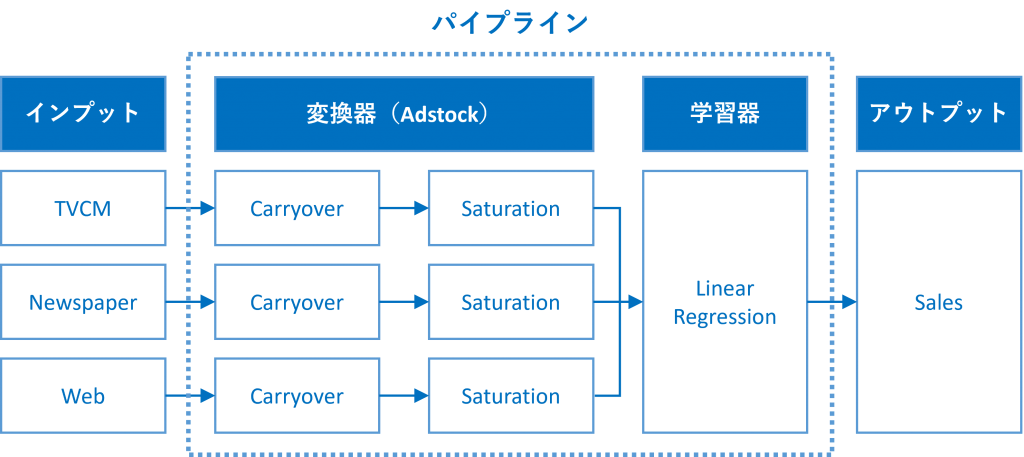

    その中で、幾つかのアドストック（Ad Stock）を表現するモデル（具体的には、関数）を紹介しました。

    どのような関数の組み合わせでアドストック（Ad Stock）を表現するがいいのでしょうか？

    ということで、今回は「最適なアドストック（Ad Stock）を探索しモデル構築」というお話しをします。

## 利用するデータセット（前回と同じ）
    今回利用するデータセットの変数です。

    Week：週
    Sales：売上
    TVCM：TV CMのコスト
    Newspaper：新聞の折り込みチラシのコスト
    Web：Web広告のコスト

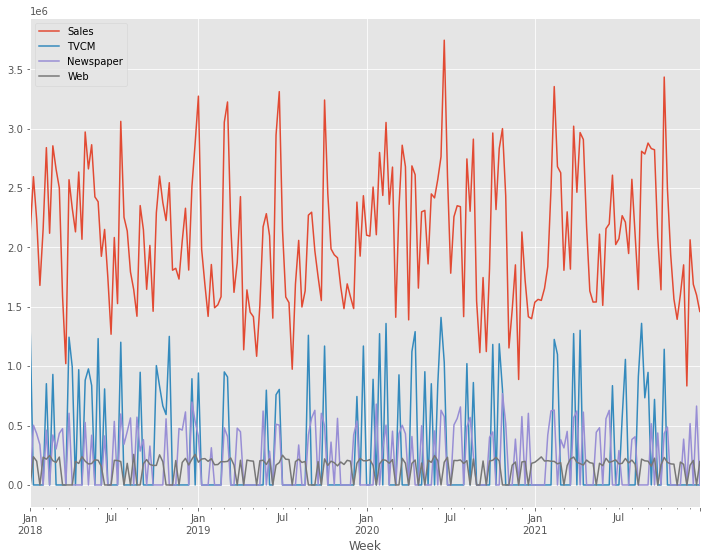

    以下からダウンロードできます。

    MMM.csv
    https://www.salesanalytics.co.jp/4zdt

## アドストック（Ad Stock）
    今回は、以下の関数の中から最適な組み合わせを探し、アドストック（Ad Stock）を表現し、モデル構築したいと思います。

    ・キャリーオーバー効果モデル
    定率減少型キャリーオーバー効果モデル　※ピークが広告などの投入時（simple_Carryover）
    ピーク可変型キャリーオーバー効果モデル（peak_Carryover）

    ・飽和モデル
    指数型飽和モデル（exp_Saturation）
    ロジスティック型飽和モデル（logit_Saturation）
    ゴンペルツ型飽和モデル（gom_Saturation）

    具体的には、2種類のキャリーオーバー効果モデルから関数を1つ、3種類の飽和モデルから関数を1つ選びます。

## 2つのキャリーオーバー効果モデル
    以下は、ピークが広告などの投入時で徐々に低減する「定率減少型キャリーオーバー効果モデル」です。当期にピークが来ています。

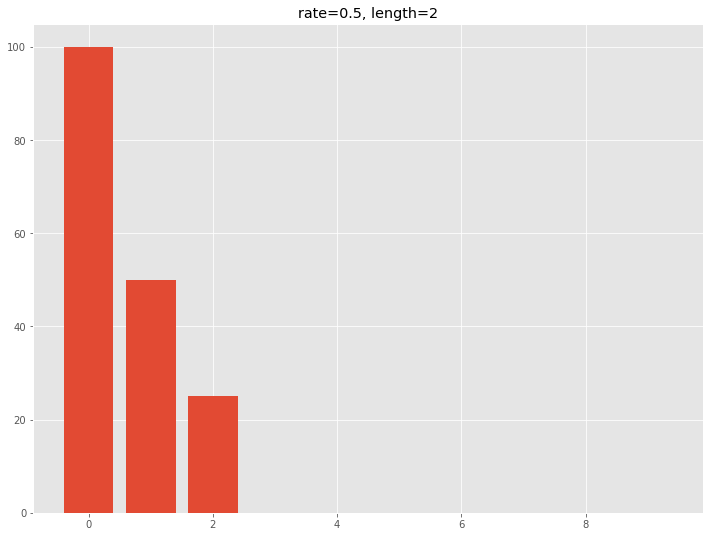

    以下は、ピークが広告などの投入時に限らない「ピーク可変型キャリーオーバー効果モデル」です。
    次期にピークが来ています。

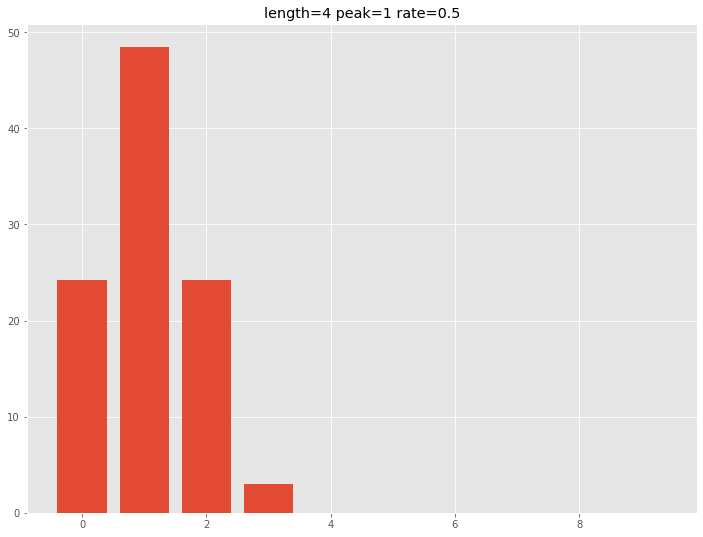

## 3つの飽和モデル
    以下は、「指数型飽和モデル」です。

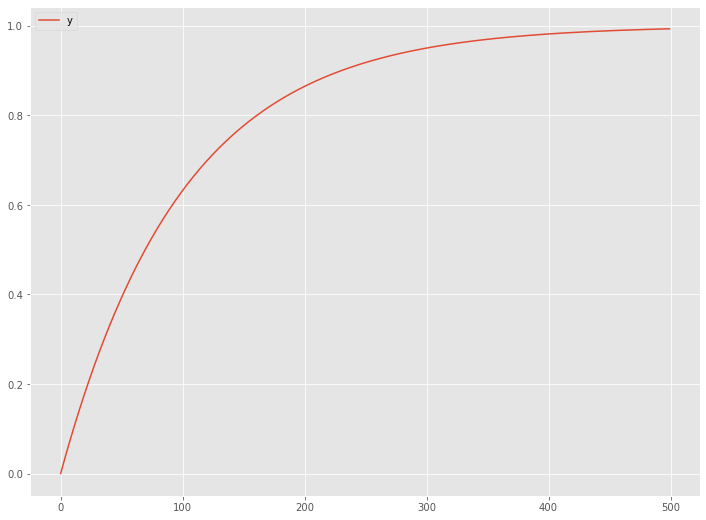

    以下は、「S字曲線型飽和モデル」です。S字曲線型飽和モデルには幾つかありますが、
    今回は「ロジスティック型飽和モデル」と「ゴンペルツ型飽和モデル」を使います。

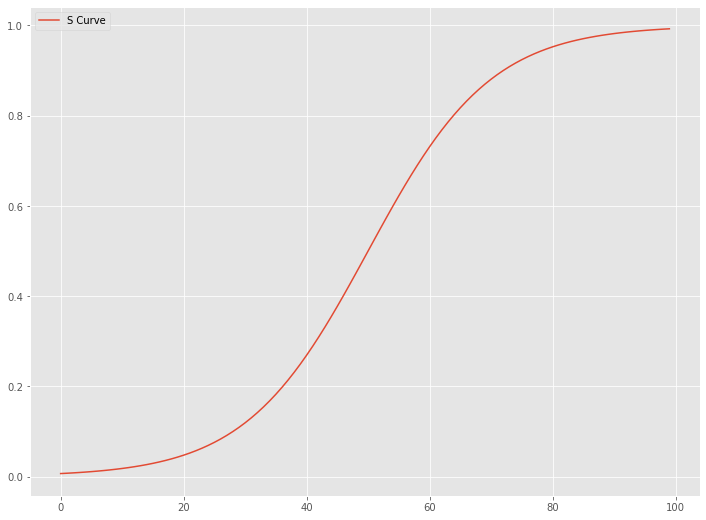

## ライブラリーやデータセットなどの読み込み
    先ずは、必要なライブラリーとデータセットを読み込みます。
    前回までと同じです。

## 必要なライブラリーの読み込み
    必要なライブラリーを読み込みます。

    以下、コードです。

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd

from scipy.signal import convolve2d

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn import set_config

from sklearn.linear_model import LinearRegression

from optuna.integration import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ

#指数表記しない設定
np.set_printoptions(precision=3,suppress=True)
pd.options.display.float_format = '{:.3f}'.format

## データセットの読み込み（前回と同じ）
    データセットを読み込みます。

    以下、コードです。

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2018-01-07 to 2021-12-26
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sales      208 non-null    int64
 1   TVCM       208 non-null    int64
 2   Newspaper  208 non-null    int64
 3   Web        208 non-null    int64
dtypes: int64(4)
memory usage: 8.1 KB
None
              Sales     TVCM  Newspaper     Web
Week                                           
2018-01-07  2132000  1312200          0       0
2018-01-14  2596100        0     502900  237400
2018-01-21  2236200        0     432100  200600
2018-01-28  1680900        0     338400       0
2018-02-04  2155400        0          0  234000


<Axes: xlabel='Week'>

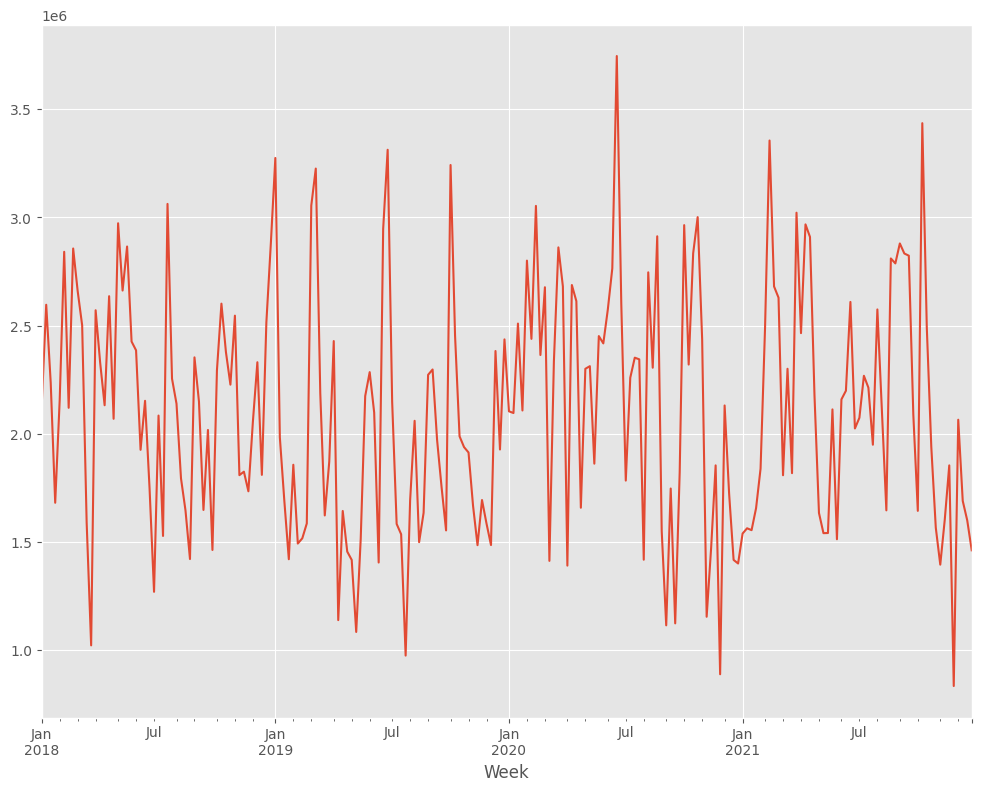

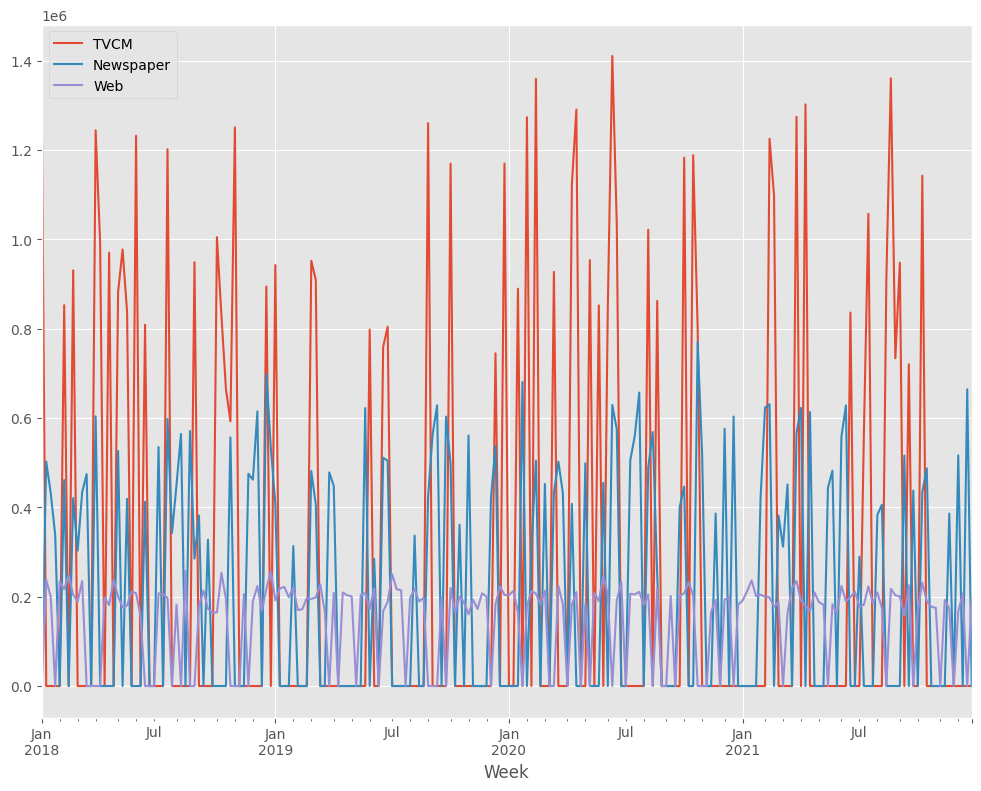

In [3]:
# データセット読み込み
url = 'https://www.salesanalytics.co.jp/4zdt'
df = pd.read_csv(url,
                 parse_dates=['Week'],
                 index_col='Week'
                )

# データ確認
print(df.info()) #変数の情報
print(df.head()) #データの一部

# 説明変数Xと目的変数yに分解
X = df.drop(columns=['Sales'])
y = df['Sales']

# グラフ化
y.plot()
X.plot()

## アドストックを考慮しない線形回帰モデル
    アドストックを考慮しない線形回帰モデルを構築し、どの程度の精度を持ったものだったのかを見てみます。

    ちなみに、前回と同じものです。

    線形回帰モデルのインスタンスを作ります。

    以下、コードです。

In [4]:
# 線形回帰モデルのインスタンス
lr = LinearRegression()

    線形回帰モデルが、どの程度の予測精度を持ったモデルになるのかを確かめるために、
    時系列のCV（クロスバリデーション）を実施します。今回は、デフォルトの5分割のCVです。

    以下、コードです。

In [5]:
# クロスバリデーションで精度検証（R2）
np.mean(cross_val_score(lr,
                        X, y,
                        cv=TimeSeriesSplit()
                       )
       )

0.7027465640779165

    全データでモデルを構築し、予測精度（R**2）を見てみます。

    以下、コードです。

In [6]:
# 全データで精度検証（R2）
lr.fit(X, y)
lr.score(X, y)

0.7400400171566186

## アドストックを考慮した線形回帰モデル（Optunaでハイパーパラメータチューニング）
    Optunaで最適な飽和モデルとキャリーオーバー効果モデルの組み合わせを探しつつ、
    それぞれのモデルのハイパーパラメータチューニングをします。

## アドストックを表現する関数の設定
    個々の飽和モデルとキャリーオーバー効果モデルの関数を定義し、その関数の変換器クラスを構築します。

## 飽和モデル
    以下の3つの飽和モデルの関数を定義し、その関数の変換器クラスを構築します。

    指数型飽和モデル（exp_Saturation）
    ロジスティック型飽和モデル（logit_Saturation）
    ゴンペルツ型飽和モデル（gom_Saturation）

    先ず、飽和モデルの関数をそれぞれ定義します。

    以下、指数型飽和モデルの関数です。

In [7]:
# 指数型飽和モデル（exp_Saturation）
def exp_Saturation(X,a):
    return 1 - np.exp(-a*X)

    以下、ロジスティック型飽和モデルの関数です。

In [8]:
# ロジスティック型飽和モデル（logit_Saturation）
def logit_Saturation(X,K,b,c,m):
    return K/(1+b*np.exp(-c*(X-m)))

    以下、ゴンペルツ型飽和モデルの関数です。

In [9]:
# ゴンペルツ型飽和モデル（gom_Saturation）
def gom_Saturation(X,K,b,c,m):
    return K*(b**np.exp(-c*(X-m)))

    次に、定義した関数を使い飽和モデルの変換器クラスを構築します。

    以下、指数型飽和モデルの変換器です。

In [10]:
# 指数型飽和モデル（exp_Saturation）
class pipe_exp_Saturation(BaseEstimator, TransformerMixin):

    # 初期化
    def __init__(self,a=1.0):
        self.a = a

    # 学習
    def fit(self, X, y=None):
        return self

    # 処理（入力→出力）
    def transform(self, X):
        X_ = exp_Saturation(X,
                            self.a
                           ).reshape(-1,1)
        return X_

    以下、ロジスティック型飽和モデルの変換器です。

In [11]:
# ロジスティック型飽和モデル（logit_Saturation）
class pipe_logit_Saturation(BaseEstimator, TransformerMixin):

    # 初期化
    def __init__(self,K=1.0,m=100.0,b=1.0, c=0.1):
        self.K = K
        self.m = m
        self.b = b
        self.c = c

    # 学習
    def fit(self, X, y=None):
        return self

    # 処理（入力→出力）
    def transform(self, X):
        X_ = logit_Saturation(X,
                              self.K,
                              self.b,
                              self.c,
                              self.m
                             ).reshape(-1,1)
        return X_

    以下、ゴンペルツ型飽和モデルの変換器です。

In [12]:
# ゴンペルツ型飽和モデル（gom_Saturation）
class pipe_gom_Saturation(BaseEstimator, TransformerMixin):

    # 初期化
    def __init__(self,K=1.0,m=100.0,b=1.0,c=0.1):
        self.K = K
        self.m = m
        self.b = b
        self.c = c

    # 学習
    def fit(self, X, y=None):
        return self

    # 処理（入力→出力）
    def transform(self, X):
        X_ = gom_Saturation(X,
                            self.K,
                            self.b,
                            self.c,
                            self.m
                           ).reshape(-1,1)
        return X_

## キャリーオーバー効果モデル
    以下の2つのキャリーオーバー効果モデルの関数を定義し、その関数の変換器クラスを構築します。

    ・定率減少型キャリーオーバー効果モデル　※ピークが広告などの投入時（simple_Carryover）
    ・ピーク可変型キャリーオーバー効果モデル（peak_Carryover）

    先ず、キャリーオーバー効果モデルの関数を定義します。

    以下、定率減少型キャリーオーバー効果モデルの関数です。

In [13]:
# 定率減少型キャリーオーバー効果モデル　※ピークが広告などの投入時（simple_Carryover）
def simple_Carryover(X: np.ndarray, rate, length):

    filter = (
        rate ** np.arange(length + 1)
    ).reshape(-1, 1)

    convolution = convolve2d(X, filter)

    if length > 0 : convolution = convolution[: -length]

    return convolution[:,0]

    以下、ピーク可変型キャリーオーバー効果モデルの関数です。

In [14]:
# ピーク可変型キャリーオーバー効果モデル（peak_Carryover）
def peak_Carryover(X: np.ndarray, length, peak, rate):
    X = np.append(np.zeros(length-1), X)

    Ws = np.zeros(length)

    for l in range(length):
        W = rate**((l-peak)**2)
        Ws[length-1-l] = W

    carryover_X = []

    for i in range(length-1, len(X)):
        X_array = X[i-length+1:i+1]
        Xi = sum(X_array * Ws)/sum(Ws)
        carryover_X.append(Xi)

    return np.array(carryover_X)

    次に、定義した関数を使いキャリーオーバー効果モデルの変換器クラスを構築します。

    以下、定率減少型キャリーオーバー効果モデルの変換器です。

In [15]:
# 定率減少型キャリーオーバー効果モデル　※ピークが広告など投入時（simple_Carryover）
class pipe_simple_Carryover(BaseEstimator, TransformerMixin):
    # 初期化
    def __init__(self,length=4,rate=0.5):
        self.length = length
        self.rate = rate

    # 学習
    def fit(self, X, y=None):
        return self
    # 処理（入力→出力）
    def transform(self, X):
        X_ = simple_Carryover(X,
                              self.rate,
                              self.length
                             )
        return X_

    以下、ピーク可変型キャリーオーバー効果モデルの変換器です。

In [16]:
# Pipeline用変換器（キャリーオーバー効果モデル）
class pipe_peak_Carryover(BaseEstimator, TransformerMixin):
    # 初期化
    def __init__(self,length=4,peak=1,rate=0.5):
        self.length = length
        self.peak = peak
        self.rate = rate

    # 学習
    def fit(self, X, y=None):
        return self
    # 処理（入力→出力）
    def transform(self, X):
        X_ = peak_Carryover(X,
                            self.length,
                            self.peak,
                            self.rate
                           )
        return X_

## パイパーパラメータ探索の実施
    Optunaを使い関数の組み合わせと、それぞれの関数の最適なパイパーパラメータを探索します。

    Optunaを使ったハイパーパラメータチューニングに関しては、以下の一連の記事を参考にして頂ければと思います。

    url: https://www.salesanalytics.co.jp/datascience/datascience072/

    先ずは、Optunaで利用する目的関数を定義します。

    以下、コードです。

In [17]:
# 目的関数の設定
def objective(trial):

    #TVCM

    ##TVCM Adstock func

    TVCM_Saturation_func = trial.suggest_categorical(
        "TVCM_Saturation_func",
        ["exp", "logit","gom"]
    )

    TVCM_Carryover_func = trial.suggest_categorical(
        "TVCM_Carryover_func",
        ["simple", "peak"]
    )

    ##TVCM_Saturation

    if TVCM_Saturation_func == 'exp':

        TVCM_a = trial.suggest_float(
            "TVCM_a",
            0, 0.01
        )

        TVCM_Saturation = pipe_exp_Saturation(a=TVCM_a)

    elif TVCM_Saturation_func == 'logit':

        TVCM_K = trial.suggest_float(
            "TVCM_K",
            np.min(X.TVCM), np.max(X.TVCM)*2
        )
        TVCM_m = trial.suggest_float(
            "TVCM_m",
            np.min(X.TVCM), np.max(X.TVCM)
        )
        TVCM_b = trial.suggest_float(
            "TVCM_b",
            0, 10
        )
        TVCM_c = trial.suggest_float(
            "TVCM_c",
            0, 1
        )

        TVCM_Saturation = pipe_logit_Saturation(
            K=TVCM_K,
            m=TVCM_m,
            b=TVCM_b,
            c=TVCM_c
        )

    else:

        TVCM_K = trial.suggest_float(
            "TVCM_K",
            np.min(X.TVCM),
            np.max(X.TVCM)*2
        )
        TVCM_m = trial.suggest_float(
            "TVCM_m",
            np.min(X.TVCM),
            np.max(X.TVCM)
        )
        TVCM_b = trial.suggest_float(
            "TVCM_b",
            0, 1
        )
        TVCM_c = trial.suggest_float(
            "TVCM_c",
            0, 1
        )

        TVCM_Saturation = pipe_gom_Saturation(
            K=TVCM_K,
            m=TVCM_m,
            b=TVCM_b,
            c=TVCM_c
        )

    ##TVCM Carryover

    if TVCM_Carryover_func == 'simple':

        TVCM_rate = trial.suggest_float(
            "TVCM_rate",
            0,1
        )
        TVCM_length = trial.suggest_int(
            "TVCM_length",
            0,6
        )

        TVCM_Carryover = pipe_simple_Carryover(
            length=TVCM_length,
            rate=TVCM_rate
        )

    else:

        TVCM_rate = trial.suggest_float(
            "TVCM_rate",
            0, 1
        )
        TVCM_length = trial.suggest_int(
            "TVCM_length",
            1,7
        )
        TVCM_peak = trial.suggest_int(
            "TVCM_peak",
            0,2
        )

        TVCM_Carryover = pipe_peak_Carryover(
            length=TVCM_length,
            rate=TVCM_rate,
            peak=TVCM_peak
        )
    #Newspaper

    ##Newspaper Adstock func

    Newspaper_Saturation_func = trial.suggest_categorical(
        "Newspaper_Saturation_func",
        ["exp", "logit","gom"]
    )

    Newspaper_Carryover_func = trial.suggest_categorical(
        "Newspaper_Carryover_func",
        ["simple", "peak"]
    )

    ##Newspaper_Saturation

    if Newspaper_Saturation_func == 'exp':

        Newspaper_a = trial.suggest_float(
            "Newspaper_a",
            0, 0.01
        )

        Newspaper_Saturation = pipe_exp_Saturation(a=Newspaper_a)

    elif Newspaper_Saturation_func == 'logit':

        Newspaper_K = trial.suggest_float(
            "Newspaper_K",
            np.min(X.Newspaper), np.max(X.Newspaper)*2
        )
        Newspaper_m = trial.suggest_float(
            "Newspaper_m",
            np.min(X.Newspaper), np.max(X.Newspaper)
        )
        Newspaper_b = trial.suggest_float(
            "Newspaper_b",
            0, 10
        )
        Newspaper_c = trial.suggest_float(
            "Newspaper_c",
            0, 1
        )

        Newspaper_Saturation = pipe_logit_Saturation(
            K=Newspaper_K,
            m=Newspaper_m,
            b=Newspaper_b,
            c=Newspaper_c
        )

    else:

        Newspaper_K = trial.suggest_float(
            "Newspaper_K",
            np.min(X.Newspaper), np.max(X.Newspaper)*2
        )
        Newspaper_m = trial.suggest_float(
            "Newspaper_m",
            np.min(X.Newspaper), np.max(X.Newspaper)
        )
        Newspaper_b = trial.suggest_float(
            "Newspaper_b",
            0, 1
        )
        Newspaper_c = trial.suggest_float(
            "Newspaper_c",
            0, 1
        )

        Newspaper_Saturation = pipe_gom_Saturation(
            K=Newspaper_K,
            m=Newspaper_m,
            b=Newspaper_b,
            c=Newspaper_c
        )

    ##Newspaper Carryover

    if Newspaper_Carryover_func == 'simple':

        Newspaper_rate = trial.suggest_float(
            "Newspaper_rate",
            0,1
        )
        Newspaper_length = trial.suggest_int(
            "Newspaper_length",
            0,6
        )

        Newspaper_Carryover = pipe_simple_Carryover(
            length=Newspaper_length,
            rate=Newspaper_rate
        )

    else:

        Newspaper_rate = trial.suggest_float(
            "Newspaper_rate",
            0, 1
        )
        Newspaper_length = trial.suggest_int(
            "Newspaper_length",
            1,7
        )
        Newspaper_peak = trial.suggest_int(
            "Newspaper_peak",
            0,2
        )

        Newspaper_Carryover = pipe_peak_Carryover(
            length=Newspaper_length,
            rate=Newspaper_rate,
            peak=Newspaper_peak
        )

    #Web

    ##Web Adstock func

    Web_Saturation_func = trial.suggest_categorical(
        "Web_Saturation_func",
        ["exp", "logit","gom"]
    )

    Web_Carryover_func = trial.suggest_categorical(
        "Web_Carryover_func",
        ["simple", "peak"]
    )

    ##Web_Saturation

    if Web_Saturation_func == 'exp':

        Web_a = trial.suggest_float(
            "Web_a",
            0, 0.01
        )

        Web_Saturation = pipe_exp_Saturation(a=Web_a)

    elif Web_Saturation_func == 'logit':

        Web_K = trial.suggest_float(
            "Web_K",
            np.min(X.Web), np.max(X.Web)*2
        )
        Web_m = trial.suggest_float(
            "Web_m",
            np.min(X.Web), np.max(X.Web)
        )
        Web_b = trial.suggest_float(
            "Web_b",
            0, 10
        )
        Web_c = trial.suggest_float(
            "Web_c",
            0, 1
        )

        Web_Saturation = pipe_logit_Saturation(
            K=Web_K,
            m=Web_m,
            b=Web_b,
            c=Web_c
        )

    else:

        Web_K = trial.suggest_float(
            "Web_K",
            np.min(X.Web), np.max(X.Web)*2
        )
        Web_m = trial.suggest_float(
            "Web_m",
            np.min(X.Web), np.max(X.Web)
        )
        Web_b = trial.suggest_float(
            "Web_b",
            0, 1
        )
        Web_c = trial.suggest_float(
            "Web_c",
            0, 1
        )

        Web_Saturation = pipe_gom_Saturation(
            K=Web_K,
            m=Web_m,
            b=Web_b,
            c=Web_c
        )

    ##Web Carryover

    if Web_Carryover_func == 'simple':

        Web_rate = trial.suggest_float(
            "Web_rate",
            0,1
        )
        Web_length = trial.suggest_int(
            "Web_length",
            0,6
        )

        Web_Carryover = pipe_simple_Carryover(
            length=Web_length,
            rate=Web_rate
        )

    else:

        Web_rate = trial.suggest_float(
            "Web_rate",
            0, 1
        )
        Web_length = trial.suggest_int(
            "Web_length",
            1,7
        )
        Web_peak = trial.suggest_int(
            "Web_peak",
            0,2
        )

        Web_Carryover = pipe_peak_Carryover(
            length=Web_length,
            rate=Web_rate,
            peak=Web_peak
        )

    # パイプライン化

    ## 変換器（Adstock）
    adstock = ColumnTransformer(
        [
         ('TVCM_pipe', Pipeline([
             ('TVCM_carryover', TVCM_Carryover),
             ('TVCM_saturation', TVCM_Saturation)
         ]), ['TVCM']),
         ('Newspaper_pipe', Pipeline([
             ('Newspaper_carryover', Newspaper_Carryover),
             ('Newspaper_saturation', Newspaper_Saturation)
         ]), ['Newspaper']),
         ('Web_pipe', Pipeline([
             ('Web_carryover', Web_Carryover),
             ('Web_saturation', Web_Saturation)
         ]), ['Web']),
        ],
        remainder='passthrough'
    )
    ## 説明変数の変換（adstock）→線形回帰モデル（regression）
    MMM_pipe = Pipeline([
        ('adstock', adstock),
        ('regression', LinearRegression())
    ])

    #CVによる評価
    score = cross_val_score(
        MMM_pipe,
        X,
        y,
        cv=TimeSeriesSplit()
    )
    accuracy = score.mean()
    return accuracy


    分かりやすくするため、ベタに長めのコードにしています。
    頭の方から説明すると、飽和モデルとキャリーオーバー効果モデルの関数の選択があり、その後に選択された関数に応じてIf文でそれぞれの変換器を選択しています。
    それを、TVCM、Newspaper、Webの順番に冗長に繰り返しています。
    そして、選択した変換器を使いパイプラインを構築しCV（クロスバリデーション）評価をしています。

    この目的関数に対し最適化を実行することで、最適な関数の組み合わせとそれぞれのハイパーパラメータを探索します。

    以下、コードです。実行時間が長く終了しない場合には、「n_trials」の数字を小さくして下さい。

In [22]:
import optuna
# 目的関数の最適化を実行する
study = optuna.create_study(direction="maximize")
study.optimize(objective,
               n_trials=1000,
               show_progress_bar=True)

[I 2024-01-31 14:51:36,864] A new study created in memory with name: no-name-73ad615f-eb07-4988-9742-80cabb928826


  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:51:36,994] Trial 0 finished with value: 0.45177043377611525 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005320287108425735, 'TVCM_rate': 0.258105571408091, 'TVCM_length': 3, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 1371281.8087616244, 'Newspaper_m': 150604.12874480197, 'Newspaper_b': 6.355853163772714, 'Newspaper_c': 0.5508590555320297, 'Newspaper_rate': 0.983564041260365, 'Newspaper_length': 4, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 209048.11530554376, 'Web_m': 98475.7341668239, 'Web_b': 8.692224042751821, 'Web_c': 0.5702704022193389, 'Web_rate': 0.09752431933016614, 'Web_length': 7, 'Web_peak': 0}. Best is trial 0 with value: 0.45177043377611525.
[I 2024-01-31 14:51:37,089] Trial 1 finished with value: 0.015378260585490678 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 900533.91849

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:51:37,262] Trial 3 finished with value: 0.16376672026511213 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 329180.840836187, 'TVCM_m': 1085595.1223239435, 'TVCM_b': 6.6623135959542426, 'TVCM_c': 0.21658062448057624, 'TVCM_rate': 0.5376669806808425, 'TVCM_length': 5, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'simple', 'Newspaper_a': 0.0011139428330497725, 'Newspaper_rate': 0.08577364458405567, 'Newspaper_length': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 106968.6619860196, 'Web_m': 57553.80311968941, 'Web_b': 8.609597329954843, 'Web_c': 0.8639299560895266, 'Web_rate': 0.6669562489091192, 'Web_length': 5}. Best is trial 2 with value: 0.5068967026031997.
[I 2024-01-31 14:51:37,356] Trial 4 finished with value: 0.08046259717668616 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 1936001.3114380592, 'TVCM_m': 993635.7444

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m


[I 2024-01-31 14:51:37,552] Trial 6 finished with value: 0.4018276335700133 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.009157570237315343, 'TVCM_rate': 0.07625745301616915, 'TVCM_length': 6, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.002273678452392882, 'Newspaper_rate': 0.33766490280338746, 'Newspaper_length': 1, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.005041652423471094, 'Web_rate': 0.9962006512579136, 'Web_length': 5, 'Web_peak': 0}. Best is trial 5 with value: 0.5162999385433173.
[I 2024-01-31 14:51:37,663] Trial 7 finished with value: 0.39760760948097384 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2295216.8103333325, 'TVCM_m': 622344.3538021229, 'TVCM_b': 0.6629381247190576, 'TVCM_c': 0.8721301502047991, 'TVCM_rate': 0.02411514143656346, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:37,743] Trial 8 finished with value: -9.157677719985209 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005374418808661234, 'TVCM_rate': 0.20813617714538069, 'TVCM_length': 5, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 780540.2212316865, 'Newspaper_m': 144152.58495116272, 'Newspaper_b': 0.5195537606781888, 'Newspaper_c': 0.5011486408789788, 'Newspaper_rate': 0.008293209994758799, 'Newspaper_length': 3, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 136993.50738095195, 'Web_m': 111224.01766110923, 'Web_b': 0.6356230210621648, 'Web_c': 0.7184132030924819, 'Web_rate': 0.9269334007835014, 'Web_length': 0}. Best is trial 5 with value: 0.5162999385433173.
[I 2024-01-31 14:51:37,853] Trial 9 finished with value: 0.43724930667452816 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1198050.8207366779, 'TVCM_m': 1125972.7

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:51:38,064] Trial 10 finished with value: 0.4735796657706867 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0004470852192129879, 'TVCM_rate': 0.9843917088736983, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 125530.48376885103, 'Newspaper_m': 716019.1141645309, 'Newspaper_b': 9.99088583875815, 'Newspaper_c': 0.9682047735832076, 'Newspaper_rate': 0.7076801184998225, 'Newspaper_length': 6, 'Newspaper_peak': 2, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 324037.2375873873, 'Web_m': 169546.83697775315, 'Web_b': 0.3665784112365394, 'Web_c': 0.13074168957373866, 'Web_rate': 0.3341258140217219, 'Web_length': 2}. Best is trial 5 with value: 0.5162999385433173.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:38,286] Trial 11 finished with value: 0.43738684739754624 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0014671391421268777, 'TVCM_rate': 0.7600245591511394, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1533152.0978394097, 'Newspaper_m': 357927.4798508404, 'Newspaper_b': 4.520967764254786, 'Newspaper_c': 0.007035124995588282, 'Newspaper_rate': 0.2757930805099761, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'peak', 'Web_K': 487266.94802711793, 'Web_m': 67756.95178742756, 'Web_b': 0.28042419634754634, 'Web_c': 0.34013211817257294, 'Web_rate': 0.33417727941135256, 'Web_length': 7, 'Web_peak': 2}. Best is trial 5 with value: 0.5162999385433173.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:51:38,503] Trial 12 finished with value: 0.3267144204730076 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0028247288718485234, 'TVCM_rate': 0.3407097448673351, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1019359.9505992024, 'Newspaper_m': 330177.4154178536, 'Newspaper_b': 4.344244852040786, 'Newspaper_c': 0.015587745398011776, 'Newspaper_rate': 0.40895802447032, 'Newspaper_length': 3, 'Newspaper_peak': 2, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'peak', 'Web_K': 334567.21523333277, 'Web_m': 150443.46300554936, 'Web_b': 0.0030733441514968485, 'Web_c': 0.33446800282367883, 'Web_rate': 0.3530240698541358, 'Web_length': 2, 'Web_peak': 1}. Best is trial 5 with value: 0.5162999385433173.
[I 2024-01-31 14:51:38,694] Trial 13 finished with value: 0.33737336157220815 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:51:38,888] Trial 14 finished with value: 0.42322691626496917 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003898553279991826, 'TVCM_rate': 0.33679309339631713, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 402376.6538992666, 'Newspaper_m': 518909.5189586636, 'Newspaper_b': 2.7355436080464512, 'Newspaper_c': 0.7853957656452416, 'Newspaper_rate': 0.5947223338569713, 'Newspaper_length': 2, 'Newspaper_peak': 1, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 253817.04860013645, 'Web_m': 116133.78071267184, 'Web_b': 0.6829265455118795, 'Web_c': 0.9987545285594527, 'Web_rate': 0.7486267982318842, 'Web_length': 1}. Best is trial 5 with value: 0.5162999385433173.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:51:39,147] Trial 15 finished with value: 0.3888938719000773 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 37886.884331452195, 'TVCM_m': 10465.204073004075, 'TVCM_b': 9.676942459049009, 'TVCM_c': 0.02668566968237529, 'TVCM_rate': 0.6763298129763731, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1139834.5160274247, 'Newspaper_m': 239737.27810451848, 'Newspaper_b': 6.681467558443833, 'Newspaper_c': 0.2822685234423639, 'Newspaper_rate': 0.8155990855265983, 'Newspaper_length': 2, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.009527148258024972, 'Web_rate': 0.4609327208868631, 'Web_length': 4, 'Web_peak': 2}. Best is trial 5 with value: 0.5162999385433173.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:51:39,548] Trial 16 finished with value: 0.35813433183415266 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006887332275392904, 'TVCM_rate': 0.42320019998275954, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1535207.2708794563, 'Newspaper_m': 533508.9401605246, 'Newspaper_b': 2.471131292798121, 'Newspaper_c': 0.25454137092469575, 'Newspaper_rate': 0.49342533639852015, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 385546.9428462066, 'Web_m': 3571.6956296196586, 'Web_b': 0.20510407398198072, 'Web_c': 0.4829112414722317, 'Web_rate': 0.006038413430578871, 'Web_length': 1}. Best is trial 5 with value: 0.5162999385433173.
[I 2024-01-31 14:51:39,673] Trial 17 finished with value: 0.5292114060574902 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017389847153

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:51:39,805] Trial 18 finished with value: 0.2378936632361972 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 2784535.698810869, 'TVCM_m': 282302.716450418, 'TVCM_b': 3.588758083897636, 'TVCM_c': 0.5489415419608424, 'TVCM_rate': 0.8995396089610714, 'TVCM_length': 3, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 657780.7404649032, 'Newspaper_m': 2561.9273356776976, 'Newspaper_b': 0.033655777486148064, 'Newspaper_c': 0.7216984701124524, 'Newspaper_rate': 0.6361947298105977, 'Newspaper_length': 5, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0010295134431381105, 'Web_rate': 0.4280424206469038, 'Web_length': 1}. Best is trial 17 with value: 0.5292114060574902.
[I 2024-01-31 14:51:39,945] Trial 19 finished with value: -0.0069479408073590985 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:40,068] Trial 20 finished with value: 0.6859333690026131 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00032790411416475443, 'TVCM_rate': 0.4378984059495931, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 491271.9943007121, 'Newspaper_m': 241804.4146026657, 'Newspaper_b': 0.2970825341212295, 'Newspaper_c': 0.6687680031016192, 'Newspaper_rate': 0.43110560404120346, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 929.2678884856577, 'Web_m': 185694.68250372304, 'Web_b': 0.47806542680363595, 'Web_c': 0.3764083191807627, 'Web_rate': 0.5417399389702029, 'Web_length': 3}. Best is trial 20 with value: 0.6859333690026131.
[I 2024-01-31 14:51:40,191] Trial 21 finished with value: 0.6986956324338044 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00038223788272754

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:40,308] Trial 22 finished with value: 0.7258135055669227 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 2.0189102121522494e-05, 'TVCM_rate': 0.15114845698157972, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 449859.7885481471, 'Newspaper_m': 247855.44953712463, 'Newspaper_b': 0.3215994381213134, 'Newspaper_c': 0.6680132160346788, 'Newspaper_rate': 0.3769939963019533, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 59891.45266147975, 'Web_m': 250362.53079148324, 'Web_b': 0.5595711576203157, 'Web_c': 0.4143429702163097, 'Web_rate': 0.5285028543476468, 'Web_length': 4}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:40,431] Trial 23 finished with value: 0.6545420206208494 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00024798619814371

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:40,558] Trial 24 finished with value: 0.5260702009919995 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 4.152165592080583e-05, 'TVCM_rate': 0.42037640452702973, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 469876.8740886424, 'Newspaper_m': 436111.5112775493, 'Newspaper_b': 0.3654726913012827, 'Newspaper_c': 0.8815597326833364, 'Newspaper_rate': 0.4207273916252271, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 58987.223636119146, 'Web_m': 254405.66181215184, 'Web_b': 0.7350822541150641, 'Web_c': 0.4420038107946137, 'Web_rate': 0.7499034767313881, 'Web_length': 4}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:40,669] Trial 25 finished with value: 0.5593445239172834 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001202077455350707

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:40,795] Trial 26 finished with value: 0.6878280976651756 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0022544550145987175, 'TVCM_rate': 0.3023906603839617, 'TVCM_length': 2, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 231930.26126865207, 'Newspaper_m': 276324.94992408896, 'Newspaper_b': 0.485786638865102, 'Newspaper_c': 0.6628992743459499, 'Newspaper_rate': 0.5284625662943729, 'Newspaper_length': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 10462.903654825099, 'Web_m': 228344.74581834822, 'Web_b': 0.5273936804216162, 'Web_c': 0.38274383347163987, 'Web_rate': 0.5135027145657721, 'Web_length': 2}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:40,923] Trial 27 finished with value: 0.5344352156616495 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0023704931174996094, 'TV

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-

[I 2024-01-31 14:51:41,131] Trial 28 finished with value: 0.31142440758073886 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 697212.9206934066, 'TVCM_m': 590479.3340465871, 'TVCM_b': 9.31347963120026, 'TVCM_c': 0.9849554852025357, 'TVCM_rate': 0.2658641438437839, 'TVCM_length': 3, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 245146.32885690613, 'Newspaper_m': 304314.19922223076, 'Newspaper_b': 0.4314153385644339, 'Newspaper_c': 0.5937344752370036, 'Newspaper_rate': 0.541880990399489, 'Newspaper_length': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 87863.95828080778, 'Web_m': 231232.90180343334, 'Web_b': 2.035149292541186, 'Web_c': 0.6533465534126176, 'Web_rate': 0.7220424254616504, 'Web_length': 2}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:41,318] Trial 29 finished with value: 0.40209173394148356 and parameters: {'TVCM_Satura

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:41,477] Trial 30 finished with value: 0.4232430125633089 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0012009412291870913, 'TVCM_rate': 0.13383930380660236, 'TVCM_length': 3, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 272077.47089405265, 'Newspaper_m': 672256.4705653931, 'Newspaper_b': 0.14720734128890534, 'Newspaper_c': 0.8629850856732608, 'Newspaper_rate': 0.5442937915346481, 'Newspaper_length': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 44069.661785176366, 'Web_m': 254441.49413962083, 'Web_b': 6.309401235682996, 'Web_c': 0.4714211807934034, 'Web_rate': 0.5968537514265178, 'Web_length': 3}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:41,661] Trial 31 finished with value: 0.5920236989305968 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 6.372137896606486e-06, '

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:41,825] Trial 32 finished with value: 0.6132461012865769 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.000841752566254563, 'TVCM_rate': 0.27562242032312106, 'TVCM_length': 2, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 332274.26156215894, 'Newspaper_m': 277396.62872067746, 'Newspaper_b': 0.44171931258255503, 'Newspaper_c': 0.6736681986440903, 'Newspaper_rate': 0.45878124500345985, 'Newspaper_length': 2, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 73763.4658134778, 'Web_m': 212417.72638860883, 'Web_b': 0.3494778771009189, 'Web_c': 0.4006185488914197, 'Web_rate': 0.6245482281341522, 'Web_length': 3}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:42,015] Trial 33 finished with value: 0.5769438650240885 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002241848060698577, 'T

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:42,208] Trial 34 finished with value: 0.4856030779920168 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0008032724226577882, 'TVCM_rate': 0.30394638403357277, 'TVCM_length': 7, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 597290.9890717628, 'Newspaper_m': 83481.46992812448, 'Newspaper_b': 0.18642062800033526, 'Newspaper_c': 0.7346849841204552, 'Newspaper_rate': 0.2307057502540389, 'Newspaper_length': 3, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 30154.761928115684, 'Web_m': 179809.96663275166, 'Web_b': 0.6146503902796434, 'Web_c': 0.4073444953482412, 'Web_rate': 0.49831399481162997, 'Web_length': 2}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:42,334] Trial 35 finished with value: 0.10601738595939716 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:42,471] Trial 36 finished with value: 0.6987648136966476 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0008136618792574173, 'TVCM_rate': 0.207965108526183, 'TVCM_length': 2, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 432564.99562482163, 'Newspaper_m': 287706.24516168254, 'Newspaper_b': 0.24335389873644692, 'Newspaper_c': 0.5701958578980775, 'Newspaper_rate': 0.35320072302419503, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 249.33980328846386, 'Web_m': 242103.36056388664, 'Web_b': 0.7126355225249308, 'Web_c': 0.5140810972343742, 'Web_rate': 0.3901943058564761, 'Web_length': 4}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:42,592] Trial 37 finished with value: 0.4962877257516685 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0021

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:42,716] Trial 38 finished with value: 0.6136263717862454 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0009442721802281814, 'TVCM_rate': 0.08095598979057875, 'TVCM_length': 3, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 663884.8516856686, 'Newspaper_m': 310491.8265693294, 'Newspaper_b': 0.09253743596184391, 'Newspaper_c': 0.5186309813699251, 'Newspaper_rate': 0.11360886974362283, 'Newspaper_length': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 165541.14831405526, 'Web_m': 244781.86698472814, 'Web_b': 0.815348669209974, 'Web_c': 0.6284219058701555, 'Web_rate': 0.3885183091007084, 'Web_length': 5}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:42,835] Trial 39 finished with value: 0.2338893741988647 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 1903160.40376007, 'TVCM_m'

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:42,947] Trial 40 finished with value: 0.4561971453349856 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.00438775277265132, 'TVCM_rate': 0.11907026398893691, 'TVCM_length': 3, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 884463.724466988, 'Newspaper_m': 355589.3639878259, 'Newspaper_b': 0.23547826413074138, 'Newspaper_c': 0.5798370918611857, 'Newspaper_rate': 0.2347757808919938, 'Newspaper_length': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.006371292815235193, 'Web_rate': 0.6318750066956096, 'Web_length': 4}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:43,077] Trial 41 finished with value: 0.7114089929948264 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0006589462897459962, 'TVCM_rate': 0.3896663130602002, 'TVCM_length': 2, 'TVCM_peak': 1, 'Newspaper_Saturation_fu

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:43,206] Trial 42 finished with value: 0.6635159380417104 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0008900989867794268, 'TVCM_rate': 0.21790112358633631, 'TVCM_length': 2, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 387800.73782746674, 'Newspaper_m': 184564.68632100942, 'Newspaper_b': 0.44900581052983235, 'Newspaper_c': 0.5747014109947295, 'Newspaper_rate': 0.46773065831365906, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 2951.0907404266263, 'Web_m': 241072.4581439976, 'Web_b': 0.6837286327161858, 'Web_c': 0.43595837319895775, 'Web_rate': 0.48333258745933017, 'Web_length': 2}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:43,339] Trial 43 finished with value: 0.607961091789183 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.00

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:43,474] Trial 44 finished with value: 0.4741727221884224 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005325845634670589, 'TVCM_rate': 0.2960924599817662, 'TVCM_length': 5, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 333122.9125403257, 'Newspaper_m': 203987.32675214246, 'Newspaper_b': 0.6139877977620043, 'Newspaper_c': 0.4389444737116149, 'Newspaper_rate': 0.37129592171067993, 'Newspaper_length': 3, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 41284.750419835094, 'Web_m': 219675.81955663773, 'Web_b': 0.5829900589200407, 'Web_c': 0.1523353873600366, 'Web_rate': 0.1437620061501469, 'Web_length': 2}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:43,596] Trial 45 finished with value: 0.6006205477869211 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.002651

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:43,733] Trial 46 finished with value: 0.5447374025889047 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0015293857067408376, 'TVCM_rate': 0.18267886933934818, 'TVCM_length': 4, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 214057.07517304237, 'Newspaper_m': 143262.6735142413, 'Newspaper_b': 0.10988898688112353, 'Newspaper_c': 0.6407178833766489, 'Newspaper_rate': 0.32986876724773356, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 125625.80475727, 'Web_m': 222394.6257439977, 'Web_b': 0.4186479377624186, 'Web_c': 0.4828074412141653, 'Web_rate': 0.5222031269038734, 'Web_length': 3}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:43,868] Trial 47 finished with value: 0.43794940960027545 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 664277

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:44,014] Trial 48 finished with value: 0.47042329046357495 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 2191072.545931297, 'TVCM_m': 835337.8662232902, 'TVCM_b': 0.3345373107556468, 'TVCM_c': 0.9991117003188088, 'TVCM_rate': 0.35471564329348726, 'TVCM_length': 1, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 628206.8971105856, 'Newspaper_m': 331079.66931841697, 'Newspaper_b': 0.395502757603272, 'Newspaper_c': 0.8219423913243092, 'Newspaper_rate': 0.7537713181919121, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 58442.60114664737, 'Web_m': 239696.39064908097, 'Web_b': 0.5158190300684886, 'Web_c': 0.36506799308177396, 'Web_rate': 0.584324467657682, 'Web_length': 2}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:44,151] Trial 49 finished with value: 0.5847683574302319 and paramete

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:44,245] Trial 50 finished with value: 0.47000746163042895 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.008895270189722446, 'TVCM_rate': 0.06062605375568911, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'simple', 'Newspaper_a': 0.007822082322039386, 'Newspaper_rate': 0.036380919908583165, 'Newspaper_length': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0007457599240367364, 'Web_rate': 0.4626490242838067, 'Web_length': 3}. Best is trial 22 with value: 0.7258135055669227.
[I 2024-01-31 14:51:44,356] Trial 51 finished with value: 0.726758454357738 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0004937837825725248, 'TVCM_rate': 0.482997100384984, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 454306.3071589356, 'Newspaper_m': 217133.2029730668, 'Newspaper

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:44,484] Trial 52 finished with value: 0.6664918752271597 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0006377116714280508, 'TVCM_rate': 0.47803678417363943, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 506400.1894210283, 'Newspaper_m': 199416.87618112, 'Newspaper_b': 0.26948950160580953, 'Newspaper_c': 0.5439523785444763, 'Newspaper_rate': 0.5124704534908078, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 938.6352559922678, 'Web_m': 219567.6207720345, 'Web_b': 0.3284207092096644, 'Web_c': 0.2950405802368574, 'Web_rate': 0.6572482427400977, 'Web_length': 3}. Best is trial 51 with value: 0.726758454357738.
[I 2024-01-31 14:51:44,611] Trial 53 finished with value: 0.5761770501581603 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 2.8231989283312693e-06, 

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:44,735] Trial 54 finished with value: 0.5186445683964649 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0006961927537014434, 'TVCM_rate': 0.5391695735029864, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 831161.6512773864, 'Newspaper_m': 284608.17160238384, 'Newspaper_b': 0.19943574980551654, 'Newspaper_c': 0.6137157187991944, 'Newspaper_rate': 0.30582705113486985, 'Newspaper_length': 3, 'Newspaper_peak': 1, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 21043.646026530598, 'Web_m': 201824.9281628166, 'Web_b': 0.5302993723342855, 'Web_c': 0.4254250753424766, 'Web_rate': 0.3014781703965463, 'Web_length': 4}. Best is trial 51 with value: 0.726758454357738.
[I 2024-01-31 14:51:44,862] Trial 55 finished with value: 0.6101885497207387 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001411701536406816

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:51:44,989] Trial 56 finished with value: 0.4605591886079005 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00187055349099991, 'TVCM_rate': 0.37701096835918413, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 551299.6551737463, 'Newspaper_m': 168677.38768998114, 'Newspaper_b': 1.4797402358989824, 'Newspaper_c': 0.15261523499590068, 'Newspaper_rate': 0.45334654518624035, 'Newspaper_length': 3, 'Newspaper_peak': 1, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 75129.22618796438, 'Web_m': 244291.7217931627, 'Web_b': 0.6414749288197477, 'Web_c': 0.30944345910296567, 'Web_rate': 0.5491864782591053, 'Web_length': 2}. Best is trial 51 with value: 0.726758454357738.
[I 2024-01-31 14:51:45,111] Trial 57 finished with value: 0.5869909899852023 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00059992633323214

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m))

[I 2024-01-31 14:51:45,251] Trial 58 finished with value: 0.5655796598983654 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1149365.3996598986, 'TVCM_m': 357914.46796571615, 'TVCM_b': 3.8453075749115304, 'TVCM_c': 0.6733003987701656, 'TVCM_rate': 0.3011543233817291, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 340956.4720544305, 'Newspaper_m': 249801.1747963986, 'Newspaper_b': 0.1126121363892662, 'Newspaper_c': 0.8084146512545018, 'Newspaper_rate': 0.6235837573853309, 'Newspaper_length': 1, 'Newspaper_peak': 1, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 117786.51791247368, 'Web_m': 134640.15856441538, 'Web_b': 0.4525844144536113, 'Web_c': 0.34428291047583964, 'Web_rate': 0.7801376360628723, 'Web_length': 3}. Best is trial 51 with value: 0.726758454357738.
[I 2024-01-31 14:51:45,389] Trial 59 finished with value: 0.4759323189841127 and parameters: {'TVCM_

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:45,506] Trial 60 finished with value: 0.5944257104674622 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.003149500180282586, 'TVCM_rate': 0.45716684430016963, 'TVCM_length': 2, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1342986.3898739254, 'Newspaper_m': 167419.6720285744, 'Newspaper_b': 0.551034688405033, 'Newspaper_c': 0.6322572649506112, 'Newspaper_rate': 0.49134118717677, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.007177499841858538, 'Web_rate': 0.682571061336723, 'Web_length': 3}. Best is trial 51 with value: 0.726758454357738.
[I 2024-01-31 14:51:45,633] Trial 61 finished with value: 0.7259120909858356 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0003220368954793837, 'TVCM_rate': 0.42437360615015857, 'TVCM_length': 1, 'Newspaper_Saturation

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:45,759] Trial 62 finished with value: 0.7270707860914184 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.000487617560199859, 'TVCM_rate': 0.4028615357488588, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 495806.7861208153, 'Newspaper_m': 266172.4215960495, 'Newspaper_b': 0.3454474623222293, 'Newspaper_c': 0.6665705806794131, 'Newspaper_rate': 0.4303861779272886, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 18642.668778531406, 'Web_m': 214602.0106508228, 'Web_b': 0.5921046135241547, 'Web_c': 0.38907806755440816, 'Web_rate': 0.5358913039078037, 'Web_length': 2}. Best is trial 62 with value: 0.7270707860914184.
[I 2024-01-31 14:51:45,887] Trial 63 finished with value: 0.7206864897500372 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00040442387670893126

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:46,024] Trial 64 finished with value: 0.5863383062334562 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0011975041082519975, 'TVCM_rate': 0.5052522336841735, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 601821.4763593521, 'Newspaper_m': 224038.63594374497, 'Newspaper_b': 0.3580849913252022, 'Newspaper_c': 0.7347875719801358, 'Newspaper_rate': 0.4419014554948301, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 56566.49575024817, 'Web_m': 216964.7078459224, 'Web_b': 0.573756307492716, 'Web_c': 0.8523725868057751, 'Web_rate': 0.6319865183160509, 'Web_length': 4}. Best is trial 62 with value: 0.7270707860914184.
[I 2024-01-31 14:51:46,148] Trial 65 finished with value: 0.6048818907528319 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00046575139244547394,

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:46,285] Trial 66 finished with value: 0.724857034438443 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00033766692804809966, 'TVCM_rate': 0.4108271677727919, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 452581.1287757773, 'Newspaper_m': 317220.478038045, 'Newspaper_b': 0.21279668049528355, 'Newspaper_c': 0.7139344298678693, 'Newspaper_rate': 0.3162080119817831, 'Newspaper_length': 3, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 96047.84385414963, 'Web_m': 176171.7089321593, 'Web_b': 0.6182590726171738, 'Web_c': 0.9500401527440406, 'Web_rate': 0.43525330016608565, 'Web_length': 1}. Best is trial 62 with value: 0.7270707860914184.
[I 2024-01-31 14:51:46,411] Trial 67 finished with value: 0.703352704200096 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00018723642744225346,

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:46,539] Trial 68 finished with value: 0.6050007359101471 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0011582092276498724, 'TVCM_rate': 0.46532435013094225, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 703120.2372951854, 'Newspaper_m': 307190.32304295193, 'Newspaper_b': 0.32096319131043566, 'Newspaper_c': 0.8293306998509185, 'Newspaper_rate': 0.4766944652845531, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 143237.34540999084, 'Web_m': 204525.57447264076, 'Web_b': 0.5560712041678605, 'Web_c': 0.9318691344804346, 'Web_rate': 0.43611053986250703, 'Web_length': 0}. Best is trial 62 with value: 0.7270707860914184.
[I 2024-01-31 14:51:46,672] Trial 69 finished with value: 0.6338542198829565 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.000390730623902

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:46,799] Trial 70 finished with value: 0.4313132146568804 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.008392152144976558, 'TVCM_rate': 0.624638697144934, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.004046487316690398, 'Newspaper_rate': 0.9265716739438532, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'peak', 'Web_K': 20682.546854334585, 'Web_m': 180845.07242144796, 'Web_b': 0.49436799678726273, 'Web_c': 0.7518601072531108, 'Web_rate': 0.48458263440994653, 'Web_length': 2, 'Web_peak': 2}. Best is trial 62 with value: 0.7270707860914184.
[I 2024-01-31 14:51:46,922] Trial 71 finished with value: 0.7164102488288437 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 2.8575012077402876e-05, 'TVCM_rate': 0.4127084959964097, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom'

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:47,051] Trial 72 finished with value: 0.6734304958481342 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00035325967970451096, 'TVCM_rate': 0.50361181464843, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 298552.61163854407, 'Newspaper_m': 377233.3178936247, 'Newspaper_b': 0.29406746176025644, 'Newspaper_c': 0.6976586005945261, 'Newspaper_rate': 0.42128054879976123, 'Newspaper_length': 2, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 67317.35299946203, 'Web_m': 151722.9035946302, 'Web_b': 0.6005101097006472, 'Web_c': 0.9108184279180587, 'Web_rate': 0.5229191860753933, 'Web_length': 1}. Best is trial 62 with value: 0.7270707860914184.
[I 2024-01-31 14:51:47,172] Trial 73 finished with value: 0.534462648976208 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00012695343058239425

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:47,303] Trial 74 finished with value: 0.748315648195309 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0013848894393112638, 'TVCM_rate': 0.5555077547733887, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 567038.3992103743, 'Newspaper_m': 223890.04372070188, 'Newspaper_b': 0.1475473599620157, 'Newspaper_c': 0.7737728300531518, 'Newspaper_rate': 0.19910171213764083, 'Newspaper_length': 3, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 171498.1921026426, 'Web_m': 130976.67104733965, 'Web_b': 0.6150060400036022, 'Web_c': 0.8960749037147842, 'Web_rate': 0.5759719745645749, 'Web_length': 1}. Best is trial 74 with value: 0.748315648195309.
[I 2024-01-31 14:51:47,432] Trial 75 finished with value: 0.625955976070291 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0014167956583626428, 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m))

[I 2024-01-31 14:51:47,570] Trial 76 finished with value: 0.16037749001896648 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1598394.4444023692, 'TVCM_m': 1254535.5071183871, 'TVCM_b': 1.9260400329980767, 'TVCM_c': 0.16928484106938857, 'TVCM_rate': 0.6487612374538747, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 385027.0775082521, 'Newspaper_m': 307987.0526675163, 'Newspaper_b': 0.22352528674599384, 'Newspaper_c': 0.8486105256066863, 'Newspaper_rate': 0.15029304267930393, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 160693.31696976145, 'Web_m': 146874.3091091197, 'Web_b': 0.5013204931522327, 'Web_c': 0.8780872399549975, 'Web_rate': 0.9467358423229322, 'Web_length': 1}. Best is trial 74 with value: 0.748315648195309.
[I 2024-01-31 14:51:47,710] Trial 77 finished with value: 0.6271128004842044 and parameters: {'TVC

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:47,833] Trial 78 finished with value: 0.5212614963215163 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2397590.2649548263, 'TVCM_m': 511491.5008072322, 'TVCM_b': 0.580079077090157, 'TVCM_c': 0.8010331104322405, 'TVCM_rate': 0.5537629136829594, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 573724.1067457614, 'Newspaper_m': 400594.4321493995, 'Newspaper_b': 0.07590983814866728, 'Newspaper_c': 0.7954461357790579, 'Newspaper_rate': 0.25727941906332025, 'Newspaper_length': 3, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.002867340150226127, 'Web_rate': 0.6028019521799275, 'Web_length': 0}. Best is trial 74 with value: 0.748315648195309.
[I 2024-01-31 14:51:47,974] Trial 79 finished with value: 0.5246126314028314 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.000376526164407098

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:48,115] Trial 80 finished with value: 0.7483156481972676 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 6.141407369559686e-05, 'TVCM_rate': 0.5213641865701675, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 290728.710224271, 'Newspaper_m': 183916.08467701002, 'Newspaper_b': 0.13165993289387534, 'Newspaper_c': 0.67626872001449, 'Newspaper_rate': 0.2127869051320711, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 134102.52218976838, 'Web_m': 124574.2051802165, 'Web_b': 0.4628301332402454, 'Web_c': 0.992560771144601, 'Web_rate': 0.5441905768351762, 'Web_length': 1}. Best is trial 80 with value: 0.7483156481972676.
[I 2024-01-31 14:51:48,266] Trial 81 finished with value: 0.625467507313622 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 8.118390541608154e-05, 'T

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:48,428] Trial 82 finished with value: 0.7633882452261895 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 6.030811089852523e-06, 'TVCM_rate': 0.5209746614087915, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 300015.15665449516, 'Newspaper_m': 264139.4783488869, 'Newspaper_b': 0.37421334811011475, 'Newspaper_c': 0.678304120077085, 'Newspaper_rate': 0.21236348057106452, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 148613.73666063955, 'Web_m': 126039.11071980785, 'Web_b': 0.38598116425244217, 'Web_c': 0.8435391509769637, 'Web_rate': 0.5699469392418258, 'Web_length': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:48,559] Trial 83 finished with value: 0.7194837554382802 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0004857249065971

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:48,794] Trial 84 finished with value: 0.6285671191261405 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0008669703172913311, 'TVCM_rate': 0.6173654670414589, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 456071.47599533666, 'Newspaper_m': 255268.38056682065, 'Newspaper_b': 0.41671693648546654, 'Newspaper_c': 0.6128761614738251, 'Newspaper_rate': 0.3961277759126585, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 142675.66312723618, 'Web_m': 109213.80200442277, 'Web_b': 0.45859008357241937, 'Web_c': 0.8827549077555771, 'Web_rate': 0.6169509566089795, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:49,040] Trial 85 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.000530593260121745, 'TVCM_rate': 0.5661726355333105, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 92683.55215016566, 'Newspaper_m': 151869.5940344293, 'Newspaper_b': 0.3702788281312187, 'Newspaper_c': 0.7072242212001976, 'Newspaper_rate': 0.1544577046940568, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 189418.1661023576, 'Web_m': 98429.19647515823, 'Web_b': 0.39247095645970476, 'Web_c': 0.9999932788131242, 'Web_rate': 0.5086961637053197, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:51:49,304] Trial 86 finished with value: 0.5376924398508971 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0011378747349446582, 'TVCM_rate': 0.6814901582072092, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 220493.68072659714, 'Newspaper_m': 768276.676183218, 'Newspaper_b': 0.06818711156972687, 'Newspaper_c': 0.6241624628810888, 'Newspaper_rate': 0.0712128103094852, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 235148.71449776404, 'Web_m': 96718.82481724936, 'Web_b': 0.2640152727459164, 'Web_c': 0.9906903316548898, 'Web_rate': 0.5097915938609321, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:49,428] Trial 87 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001657961104096857,

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:49,660] Trial 88 finished with value: 0.6780975500539744 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0016028291470841073, 'TVCM_rate': 0.8594459066375784, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 84864.61673302174, 'Newspaper_m': 145570.97148112798, 'Newspaper_b': 0.37859831513930753, 'Newspaper_c': 0.6820154705070268, 'Newspaper_rate': 0.06556612486016097, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 180654.15802920028, 'Web_m': 76796.16207940911, 'Web_b': 1.134880678254877, 'Web_c': 0.9260215063292918, 'Web_rate': 0.6715193431876261, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:49,783] Trial 89 finished with value: 0.6044682051689885 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0049028481930927

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-

[I 2024-01-31 14:51:50,046] Trial 90 finished with value: 0.4898104128367362 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 339297.7162267668, 'TVCM_m': 862453.7612327985, 'TVCM_b': 8.45837450559882, 'TVCM_c': 0.10243775477123451, 'TVCM_rate': 0.7940072058739448, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 139042.49897406378, 'Newspaper_m': 113988.02667313899, 'Newspaper_b': 0.44162391396145245, 'Newspaper_c': 0.6566040122264981, 'Newspaper_rate': 0.20780858104106287, 'Newspaper_length': 4, 'Newspaper_peak': 1, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 220303.20139829267, 'Web_m': 118248.66323450289, 'Web_b': 1.8502909194441404, 'Web_c': 0.27549063519282446, 'Web_rate': 0.5182509218785619, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:50,315] Trial 91 finished with value: 0.7445302805116195 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0007121984701320699, 'TVCM_rate': 0.9744533139799443, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 7133.011428799084, 'Newspaper_m': 184007.36060455392, 'Newspaper_b': 0.34278748090093597, 'Newspaper_c': 0.7111541592526963, 'Newspaper_rate': 0.1652542682011691, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 172381.4072152329, 'Web_m': 74299.18664566887, 'Web_b': 4.800435064183792, 'Web_c': 0.9589374406840769, 'Web_rate': 0.44254366179017857, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:50,533] Trial 92 finished with value: 0.7169538629425551 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0020304604640424347, 'TVCM_rate': 0.9365070645016074, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 81188.91557207816, 'Newspaper_m': 78822.76452568351, 'Newspaper_b': 0.34316650552024236, 'Newspaper_c': 0.7052833706464391, 'Newspaper_rate': 0.16372096478517043, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 199144.482837322, 'Web_m': 76521.8204247466, 'Web_b': 5.198136673253628, 'Web_c': 0.9938157630422464, 'Web_rate': 0.40587197026391075, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:50,771] Trial 93 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0008632584063126247, 'TVCM_rate': 0.9686439689670766, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 50819.37282122273, 'Newspaper_m': 187766.87666919985, 'Newspaper_b': 0.38938860938871483, 'Newspaper_c': 0.5921710153743519, 'Newspaper_rate': 0.10697967977352735, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 172938.53813831607, 'Web_m': 63037.45221609454, 'Web_b': 7.306345690663418, 'Web_c': 0.9627697025208841, 'Web_rate': 0.5852185005569891, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:51,001] Trial 94 finished with value: 0.7445302805116194 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0008891122175112355, 'TVCM_rate': 0.9471061569378231, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 14200.119666582701, 'Newspaper_m': 158508.70204568864, 'Newspaper_b': 0.4679684542034309, 'Newspaper_c': 0.5837474678092556, 'Newspaper_rate': 0.005134893822682979, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 172956.42875046097, 'Web_m': 38792.94986061589, 'Web_b': 9.914889152917201, 'Web_c': 0.8419924167740622, 'Web_rate': 0.3616438903716233, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:51,144] Trial 95 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.000925645496308

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:51,301] Trial 96 finished with value: 0.6654119940363594 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015714106858257639, 'TVCM_rate': 0.988305642695853, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 4677.824751182506, 'Newspaper_m': 155444.59688529756, 'Newspaper_b': 0.46376392028580465, 'Newspaper_c': 0.5667879451412673, 'Newspaper_rate': 0.017426957678860433, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 172490.43413197013, 'Web_m': 37922.104712198896, 'Web_b': 9.887289986414233, 'Web_c': 0.9074147444966575, 'Web_rate': 0.351616805536768, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:51,595] Trial 97 finished with value: 0.7445302805116191 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2478596.1005366226, 'TVCM_m': 481686.1248599911, 'TVCM_b': 0.3846715374733907, 'TVCM_c': 0.327499701434142, 'TVCM_rate': 0.9618345143133296, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 44753.105825034385, 'Newspaper_m': 187200.92886638123, 'Newspaper_b': 0.5329383270142599, 'Newspaper_c': 0.5196115962774213, 'Newspaper_rate': 0.10107204366770217, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 154055.21064098287, 'Web_m': 48959.27761949229, 'Web_b': 7.434322860746567, 'Web_c': 0.7644037844936546, 'Web_rate': 0.25434494418086184, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:51,744] Trial 98 finished with value: 0.6780975500539743 and parame

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m))

[I 2024-01-31 14:51:51,991] Trial 99 finished with value: -0.054836375945943594 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2014874.66291169, 'TVCM_m': 175326.4658730729, 'TVCM_b': 0.13943995985899083, 'TVCM_c': 0.5675312545394675, 'TVCM_rate': 0.9659658645963823, 'TVCM_length': 5, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 104782.85548047816, 'Newspaper_m': 137745.96361409183, 'Newspaper_b': 0.5662727393674765, 'Newspaper_c': 0.5893652063843247, 'Newspaper_rate': 0.05100438820705125, 'Newspaper_length': 4, 'Newspaper_peak': 2, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 238769.37957270094, 'Web_m': 53916.90368991591, 'Web_b': 8.775875011796515, 'Web_c': 0.7703699240953298, 'Web_rate': 0.28215739580546584, 'Web_length': 7, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:52,337] Trial 100 finished with value: 0.6802320578864954 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1638344.4033699501, 'TVCM_m': 648713.8114195958, 'TVCM_b': 0.282697018486714, 'TVCM_c': 0.27647571784329866, 'TVCM_rate': 0.8813663457601983, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 41127.74293001598, 'Newspaper_m': 126503.25720311224, 'Newspaper_b': 0.5150158121482159, 'Newspaper_c': 0.39398661299445037, 'Newspaper_rate': 0.0971739827631828, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 181590.28495266289, 'Web_m': 61259.03405177377, 'Web_b': 9.137438410536113, 'Web_c': 0.9638525803376322, 'Web_rate': 0.23522096513082824, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:52,702] Trial 101 finished with value: 0.7445302805116185 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2533813.8411676963, 'TVCM_m': 157744.1662135435, 'TVCM_b': 0.5895876279604982, 'TVCM_c': 0.4134740361482187, 'TVCM_rate': 0.9982241449958731, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 2727.9476916261337, 'Newspaper_m': 182039.80950136302, 'Newspaper_b': 0.47989196059363787, 'Newspaper_c': 0.5571756424512757, 'Newspaper_rate': 0.0015941182819316359, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 205943.45110048648, 'Web_m': 22408.990586325064, 'Web_b': 7.473323583449854, 'Web_c': 0.925146583708786, 'Web_rate': 0.15728085698611471, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:53,116] Trial 102 finished with value: 0.7445302805116187 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2558795.5999099975, 'TVCM_m': 151639.1590399853, 'TVCM_b': 0.6162060613217126, 'TVCM_c': 0.42766031339008975, 'TVCM_rate': 0.9108293076279257, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 2651.374630544444, 'Newspaper_m': 161789.84810503235, 'Newspaper_b': 0.47087248130577786, 'Newspaper_c': 0.45532785433225254, 'Newspaper_rate': 0.0003091363925931869, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 206107.8659675983, 'Web_m': 47301.08794890914, 'Web_b': 7.262125279918324, 'Web_c': 0.92375701850096, 'Web_rate': 0.054171975825068386, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:53,471] Trial 103 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2109077.9350909963, 'TVCM_m': 427595.1660159778, 'TVCM_b': 0.6909590464897657, 'TVCM_c': 0.40472569967473593, 'TVCM_rate': 0.9199023792476201, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 177412.75545554236, 'Newspaper_m': 161547.25169685096, 'Newspaper_b': 0.5501896080858627, 'Newspaper_c': 0.4814777997011429, 'Newspaper_rate': 0.08445334575610958, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 133501.48034392006, 'Web_m': 49836.95777967565, 'Web_b': 7.3249405053766905, 'Web_c': 0.8278985245256335, 'Web_rate': 0.09313755787192612, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:53,846] Trial 104 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2287509.8028700934, 'TVCM_m': 483063.0284120792, 'TVCM_b': 0.7483670797095769, 'TVCM_c': 0.26153893172958703, 'TVCM_rate': 0.8322728665880678, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 177631.73505637416, 'Newspaper_m': 73295.38356405875, 'Newspaper_b': 0.5605130542278265, 'Newspaper_c': 0.48794550613465965, 'Newspaper_rate': 0.07998754173009683, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 134277.07560745164, 'Web_m': 66746.65063626111, 'Web_b': 3.3815754656626815, 'Web_c': 0.8552437394581616, 'Web_rate': 0.09697358729968239, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:54,137] Trial 105 finished with value: 0.7028903052571784 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2117516.812134417, 'TVCM_m': 745093.2817461233, 'TVCM_b': 0.7698692128242165, 'TVCM_c': 0.13373044638974602, 'TVCM_rate': 0.8295930526812223, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 179447.67674144072, 'Newspaper_m': 90391.5446973796, 'Newspaper_b': 0.5782570331026771, 'Newspaper_c': 0.42831844215719445, 'Newspaper_rate': 0.12784564631359385, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 128548.06949295677, 'Web_m': 68905.49085505748, 'Web_b': 3.4238740928250735, 'Web_c': 0.8353627334052323, 'Web_rate': 0.10726647280947502, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:54,374] Trial 106 finished with value: 0.687013488387106 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1297391.471986565, 'TVCM_m': 428555.5571276044, 'TVCM_b': 0.7283378721535946, 'TVCM_c': 0.08036056537785063, 'TVCM_rate': 0.8787086880463515, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 114300.71245844522, 'Newspaper_m': 34960.931527832305, 'Newspaper_b': 0.41253752274225663, 'Newspaper_c': 0.4688156433672495, 'Newspaper_rate': 0.07860037942687143, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 167652.41391080903, 'Web_m': 88191.18223417993, 'Web_b': 4.760244862391766, 'Web_c': 0.8958837632841837, 'Web_rate': 0.016616239516813847, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:54,518] Trial 107 finished with value: 0.6133270169713079 and pa

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:54,674] Trial 108 finished with value: 0.4899662261116708 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1762454.5120113883, 'TVCM_m': 556597.0256958207, 'TVCM_b': 0.8219862184579214, 'TVCM_c': 0.23410609001102448, 'TVCM_rate': 0.9415787027100614, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 71278.93871198685, 'Newspaper_m': 63755.55747065882, 'Newspaper_b': 0.6618874069889951, 'Newspaper_c': 0.5072450022753553, 'Newspaper_rate': 0.16531064927171918, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 279938.83318512014, 'Web_m': 74986.43171285797, 'Web_b': 5.743884378131325, 'Web_c': 0.741393799774859, 'Web_rate': 0.18778323050490456, 'Web_length': 1, 'Web_peak': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:54,806] Trial 109 finished with value: 0.7340043688952937 and param

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:51:54,947] Trial 110 finished with value: 0.57818249664668 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0024348477904802004, 'TVCM_rate': 0.8968618919610757, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.0005355191803511263, 'Newspaper_rate': 0.023024542516201868, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 136078.84742902845, 'Web_m': 63885.12695932956, 'Web_b': 4.210000273126318, 'Web_c': 0.9480408763677668, 'Web_rate': 0.36015496466394215, 'Web_length': 1, 'Web_peak': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:55,102] Trial 111 finished with value: 0.7445302805116194 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2305035.2679407517, 'TVCM_m': 478844.18297058804, 'TVCM_b': 0.5055775518680716, 'TVCM_c': 0.3733066074269

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:55,267] Trial 112 finished with value: 0.6338542198829568 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2223838.926353297, 'TVCM_m': 269112.2657577641, 'TVCM_b': 0.5230497405031891, 'TVCM_c': 0.37457997114457825, 'TVCM_rate': 0.927110899884583, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 203212.16322275857, 'Newspaper_m': 19546.550689646923, 'Newspaper_b': 0.5054702084376475, 'Newspaper_c': 0.4854729832894431, 'Newspaper_rate': 0.13304346939437145, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 187463.4336401168, 'Web_m': 52705.22416712147, 'Web_b': 6.873151686091384, 'Web_c': 0.7894490887413683, 'Web_rate': 0.0235925726704084, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:55,416] Trial 113 finished with value: 0.7445302805116194 and parame

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:55,581] Trial 114 finished with value: 0.7398178343385584 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2033698.602597666, 'TVCM_m': 683700.4614163997, 'TVCM_b': 0.6734127294693578, 'TVCM_c': 0.5455180223148017, 'TVCM_rate': 0.8575061729122344, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 62989.9158845381, 'Newspaper_m': 195644.84116697597, 'Newspaper_b': 0.42352814149703477, 'Newspaper_c': 0.5824351076995815, 'Newspaper_rate': 0.05980340445168148, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 149993.09921364998, 'Web_m': 33575.027063236776, 'Web_b': 8.207982095798117, 'Web_c': 0.9997319322446605, 'Web_rate': 0.03138028441128954, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:55,735] Trial 115 finished with value: 0.7445302805116192 and para

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:55,882] Trial 116 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0036404244528735774, 'TVCM_rate': 0.887758488615588, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 252667.5142446943, 'Newspaper_m': 176036.6558399839, 'Newspaper_b': 0.0484748724359264, 'Newspaper_c': 0.6053171954808636, 'Newspaper_rate': 0.10070330785838476, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 111278.8497665738, 'Web_m': 101882.64435450696, 'Web_b': 8.261359213723422, 'Web_c': 0.8244283579848769, 'Web_rate': 0.13738690159500397, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:56,050] Trial 117 finished with value: 0.7374108787139517 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 268

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:56,193] Trial 118 finished with value: 0.6654119940363595 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001332026359329316, 'TVCM_rate': 0.7950748487249669, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 32202.614623558933, 'Newspaper_m': 151904.32271633053, 'Newspaper_b': 0.37434458258775694, 'Newspaper_c': 0.5926609169779504, 'Newspaper_rate': 0.22562260218315477, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 191385.51712211187, 'Web_m': 92403.69053274857, 'Web_b': 2.5211006880433917, 'Web_c': 0.7198928860127747, 'Web_rate': 0.062205505188784316, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:56,326] Trial 119 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:56,489] Trial 120 finished with value: 0.5585946670716158 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2341547.6333117597, 'TVCM_m': 74166.90295862162, 'TVCM_b': 0.6631307246377746, 'TVCM_c': 0.3780757453317388, 'TVCM_rate': 0.9996891111354401, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 148248.54474320848, 'Newspaper_m': 595134.7537921828, 'Newspaper_b': 0.4332078318088716, 'Newspaper_c': 0.5552131053408285, 'Newspaper_rate': 0.09467517246929473, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 171784.83580891497, 'Web_m': 2598.9945528272583, 'Web_b': 7.772215551475145, 'Web_c': 0.861831938324462, 'Web_rate': 0.07790591227165734, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:56,640] Trial 121 finished with value: 0.7445302805116192 and para

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:56,798] Trial 122 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2103916.8611716367, 'TVCM_m': 499451.6263645466, 'TVCM_b': 0.8038499624643775, 'TVCM_c': 0.3844577492910098, 'TVCM_rate': 0.8674253202966522, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 25083.8615941975, 'Newspaper_m': 98200.45239451382, 'Newspaper_b': 0.12063740228140601, 'Newspaper_c': 0.49091909372963105, 'Newspaper_rate': 0.07613449144801201, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 131187.77280613943, 'Web_m': 43144.27435006526, 'Web_b': 5.683260564168794, 'Web_c': 0.9764323728830427, 'Web_rate': 0.12909595649136096, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:56,966] Trial 123 finished with value: 0.6042672726504256 and para

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:57,138] Trial 124 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1698990.2356386697, 'TVCM_m': 532215.2988420306, 'TVCM_b': 0.5427394300948873, 'TVCM_c': 0.3864571792309448, 'TVCM_rate': 0.9055664726758278, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 91974.75812209689, 'Newspaper_m': 126050.42843883374, 'Newspaper_b': 0.10355294827548531, 'Newspaper_c': 0.6051090922627584, 'Newspaper_rate': 0.17774571549297216, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 121616.74085333169, 'Web_m': 132404.0963295224, 'Web_b': 5.744995101238168, 'Web_c': 0.8896013206194751, 'Web_rate': 0.14839355189532097, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:57,293] Trial 125 finished with value: 0.7445302805116192 and par

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:57,465] Trial 126 finished with value: 0.6518847970416908 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1973697.524416916, 'TVCM_m': 602887.7305687033, 'TVCM_b': 0.45880048458317635, 'TVCM_c': 0.5112604741409866, 'TVCM_rate': 0.7609545312648305, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 959650.9016641753, 'Newspaper_m': 105055.499851701, 'Newspaper_b': 0.08909239600229617, 'Newspaper_c': 0.7377877275763418, 'Newspaper_rate': 0.24302128961736974, 'Newspaper_length': 4, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 161112.77851612185, 'Web_m': 143801.48978174594, 'Web_b': 5.860205082578234, 'Web_c': 0.790788630226783, 'Web_rate': 0.1210216640859961, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:57,603] Trial 127 finished with value: 0.41738070088578205 and parameters: {'TVCM_Satur

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:57,760] Trial 128 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1563365.155935868, 'TVCM_m': 300796.770007625, 'TVCM_b': 0.6229922414277067, 'TVCM_c': 0.4208476001535571, 'TVCM_rate': 0.9188930460900898, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 131343.2014944737, 'Newspaper_m': 149518.81233351192, 'Newspaper_b': 0.12883474084698363, 'Newspaper_c': 0.6102433407651515, 'Newspaper_rate': 0.1744220781870406, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 147165.3345688577, 'Web_m': 43327.39443886102, 'Web_b': 6.806653708382114, 'Web_c': 0.8800605409840309, 'Web_rate': 0.12058468864442319, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:57,924] Trial 129 finished with value: 0.45986244190406084 and parameters: {'TVCM_

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:51:58,097] Trial 130 finished with value: 0.5804046727441976 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1846477.8117771095, 'TVCM_m': 684712.8624958225, 'TVCM_b': 0.7838491255407423, 'TVCM_c': 0.4606406623655196, 'TVCM_rate': 0.5333058399799752, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 39862.84339234904, 'Newspaper_m': 134823.74511471586, 'Newspaper_b': 0.16324752773246504, 'Newspaper_c': 0.566211701754785, 'Newspaper_rate': 0.073911026908114, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 124756.65982073874, 'Web_m': 125464.96862997422, 'Web_b': 5.481022547330621, 'Web_c': 0.9249536225699121, 'Web_rate': 0.5914617395048799, 'Web_length': 2, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:58,248] Trial 131 finished with value: 0.7445302805116196 and parame

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:58,400] Trial 132 finished with value: 0.7445302805116195 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006904708556402533, 'TVCM_rate': 0.9735847086129651, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 61606.194510493064, 'Newspaper_m': 207791.5885023428, 'Newspaper_b': 0.33138021885254937, 'Newspaper_c': 0.5073889837618096, 'Newspaper_rate': 0.026933898073626075, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 187076.00980079593, 'Web_m': 34041.59334442811, 'Web_b': 4.780264628460843, 'Web_c': 0.9507799912878928, 'Web_rate': 0.49787254828720995, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:58,543] Trial 133 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:58,693] Trial 134 finished with value: 0.6254675073136207 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0071600242414760675, 'TVCM_rate': 0.9032503649777347, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 155004.1629769721, 'Newspaper_m': 209665.39247766868, 'Newspaper_b': 0.009202042550730951, 'Newspaper_c': 0.5145335662283288, 'Newspaper_rate': 0.03353862786395759, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 139616.00100234276, 'Web_m': 11095.810959103088, 'Web_b': 4.587461796174144, 'Web_c': 0.8931351020186787, 'Web_rate': 0.49988741728107644, 'Web_length': 2, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:58,837] Trial 135 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:58,992] Trial 136 finished with value: 0.5172763767889926 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1025740.9262502091, 'TVCM_m': 471223.23090159975, 'TVCM_b': 0.8807204099867477, 'TVCM_c': 0.5218516927337615, 'TVCM_rate': 0.9755652573243723, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.004602654176435456, 'Newspaper_rate': 0.057348489564964654, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 195173.80788012248, 'Web_m': 36009.035899414484, 'Web_b': 4.74849134897271, 'Web_c': 0.8201815585344552, 'Web_rate': 0.5026632804472009, 'Web_length': 2, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:59,144] Trial 137 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0078697375428489

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:59,292] Trial 138 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.007368122416486643, 'TVCM_rate': 0.9314261086317847, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 116948.59782270927, 'Newspaper_m': 207916.77063334594, 'Newspaper_b': 0.33215154943845415, 'Newspaper_c': 0.49350162126213265, 'Newspaper_rate': 0.054991005740301926, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 132926.5253266691, 'Web_m': 28331.883324037495, 'Web_b': 4.909128672787559, 'Web_c': 0.9895782124531252, 'Web_rate': 0.4514558039908948, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:59,449] Trial 139 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:51:59,610] Trial 140 finished with value: 0.6254675073136207 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006285386933961316, 'TVCM_rate': 0.9613663578593566, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 116225.98362949955, 'Newspaper_m': 198044.46159525635, 'Newspaper_b': 0.3345994141088748, 'Newspaper_c': 0.46069609027476016, 'Newspaper_rate': 0.05030063394194346, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 131312.82278935664, 'Web_m': 44322.33611027166, 'Web_b': 4.936838282152288, 'Web_c': 0.9156054415189437, 'Web_rate': 0.4429186525264305, 'Web_length': 2, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:51:59,775] Trial 141 finished with value: 0.7445302805116194 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-

[I 2024-01-31 14:51:59,981] Trial 142 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2437923.405694093, 'TVCM_m': 231625.02415190206, 'TVCM_b': 1.3910509320265088, 'TVCM_c': 0.9578518786284109, 'TVCM_rate': 0.9401973497959936, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 22179.867585784592, 'Newspaper_m': 231357.6950052784, 'Newspaper_b': 0.26609852896729697, 'Newspaper_c': 0.4909660578457726, 'Newspaper_rate': 0.06052659880838531, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 120735.4280068636, 'Web_m': 27003.89824608341, 'Web_b': 4.347993273287074, 'Web_c': 0.8847894103847987, 'Web_rate': 0.4681691977730705, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-

[I 2024-01-31 14:52:00,234] Trial 143 finished with value: 0.7374108787139517 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2688250.9399426053, 'TVCM_m': 630251.0264428892, 'TVCM_b': 2.746140926628854, 'TVCM_c': 0.8140069659617111, 'TVCM_rate': 0.8884234748054566, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 299465.56990118115, 'Newspaper_m': 205639.67504848662, 'Newspaper_b': 0.1328274299010303, 'Newspaper_c': 0.4430568030186443, 'Newspaper_rate': 0.016624008665638033, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 147777.6021203967, 'Web_m': 18659.194357386255, 'Web_b': 5.1751490884604685, 'Web_c': 0.9028991837023643, 'Web_rate': 0.38257983190997086, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-

[I 2024-01-31 14:52:00,473] Trial 144 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2193053.350825828, 'TVCM_m': 510860.7152576451, 'TVCM_b': 5.474528044445638, 'TVCM_c': 0.30792439561524276, 'TVCM_rate': 0.9778652739979533, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 55388.28636150717, 'Newspaper_m': 186505.54204663244, 'Newspaper_b': 0.06793076082415733, 'Newspaper_c': 0.547438142750359, 'Newspaper_rate': 0.03636548481077194, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 111574.5831331439, 'Web_m': 40123.996550860364, 'Web_b': 5.461845322616583, 'Web_c': 0.9785886769871682, 'Web_rate': 0.40125201879383543, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:00,654] Trial 145 finished with value: 0.748409113372315 and para

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-

[I 2024-01-31 14:52:00,879] Trial 146 finished with value: 0.748409113372315 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1929739.310617411, 'TVCM_m': 335197.7200249144, 'TVCM_b': 1.3061532329263192, 'TVCM_c': 0.7346007195605145, 'TVCM_rate': 0.9122539470573894, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 214136.9159938602, 'Newspaper_m': 269745.23925595236, 'Newspaper_b': 0.27802923718278744, 'Newspaper_c': 0.5314398672015088, 'Newspaper_rate': 0.07733374224889675, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 159285.82898778556, 'Web_m': 34050.337631945455, 'Web_b': 4.0133578083223425, 'Web_c': 0.8331908131267468, 'Web_rate': 0.4898843560409023, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:01,149] Trial 147 finished with value: 0.753722563646846 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1932444.4915418327, 'TVCM_m': 354455.5973335424, 'TVCM_b': 1.4079495674673166, 'TVCM_c': 0.7626472480356081, 'TVCM_rate': 0.8075105391351122, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 219161.78593210177, 'Newspaper_m': 263090.50585411617, 'Newspaper_b': 5.402041958877821, 'Newspaper_c': 0.5320317454747041, 'Newspaper_rate': 0.08694467177438428, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 163108.72688695023, 'Web_m': 158321.35857809868, 'Web_b': 4.2309792163701525, 'Web_c': 0.8254527883476552, 'Web_rate': 0.4216124315302357, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:01,406] Trial 148 finished with value: 0.624894278163677 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1917563.539489967, 'TVCM_m': 332446.6825207597, 'TVCM_b': 1.4164552717769556, 'TVCM_c': 0.866654934825826, 'TVCM_rate': 0.795393432353796, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 321527.3041374191, 'Newspaper_m': 277554.3421409075, 'Newspaper_b': 5.543273998535979, 'Newspaper_c': 0.532169094370374, 'Newspaper_rate': 0.0821224976186872, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.002912036475214555, 'Web_rate': 0.47849103814540883, 'Web_length': 2, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:01,680] Trial 149 finished with value: 0.6598278821608388 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2058287.43537705, 'TVCM_m': 383513.1108145647, 'TVCM_b': 2.14741195603091, 'TVCM_c': 0.7338330033116868, 'TVCM_rate': 0.812289911184688, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 258593.90607096508, 'Newspaper_m': 283520.7140770089, 'Newspaper_b': 5.400677976179568, 'Newspaper_c': 0.5613646408993235, 'Newspaper_rate': 0.00016917634859725528, 'Newspaper_length': 5, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 162246.02369004645, 'Web_m': 160734.71143602004, 'Web_b': 4.0557504378383245, 'Web_c': 0.8260851271931289, 'Web_rate': 0.4305337472769478, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:01,949] Trial 150 finished with value: 0.7445302805116266 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1981701.215737985, 'TVCM_m': 224288.41941349846, 'TVCM_b': 2.463278711258875, 'TVCM_c': 0.7718934600495277, 'TVCM_rate': 0.8446681003840494, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 216089.1009496943, 'Newspaper_m': 265807.4669011854, 'Newspaper_b': 1.0699776174312592, 'Newspaper_c': 0.5180398110859803, 'Newspaper_rate': 0.07088694522344366, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 176882.73096872005, 'Web_m': 49097.60284670293, 'Web_b': 4.00235659834867, 'Web_c': 0.7971164020966797, 'Web_rate': 0.5284479286709145, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:02,242] Trial 151 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1953697.2235307782, 'TVCM_m': 324026.6851589678, 'TVCM_b': 1.301964937427564, 'TVCM_c': 0.7789905796386858, 'TVCM_rate': 0.8403416233441546, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 198709.12880045187, 'Newspaper_m': 263522.32343501796, 'Newspaper_b': 0.8196921882976843, 'Newspaper_c': 0.5156092721103701, 'Newspaper_rate': 0.12128919573885868, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 176494.59534090006, 'Web_m': 48541.027648737676, 'Web_b': 3.905945830407684, 'Web_c': 0.794538917211243, 'Web_rate': 0.5179206619169628, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:02,510] Trial 152 finished with value: 0.7574535552892894 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1844071.3276765775, 'TVCM_m': 214670.58041516517, 'TVCM_b': 1.2867840993227517, 'TVCM_c': 0.7684763723147566, 'TVCM_rate': 0.724851425443937, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 218155.40460298795, 'Newspaper_m': 259208.8323700843, 'Newspaper_b': 1.2161124831655257, 'Newspaper_c': 0.5180795035108677, 'Newspaper_rate': 0.1076628978576733, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 170943.71990000855, 'Web_m': 49346.25627218369, 'Web_b': 3.875158903063528, 'Web_c': 0.7804167266590015, 'Web_rate': 0.5334765149064764, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:02,771] Trial 153 finished with value: 0.751483717556621 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1950213.229163338, 'TVCM_m': 231498.9251580741, 'TVCM_b': 2.586629255800805, 'TVCM_c': 0.7503913797837863, 'TVCM_rate': 0.7817011162343463, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 227805.57741309548, 'Newspaper_m': 295403.59262173244, 'Newspaper_b': 1.8672589711332372, 'Newspaper_c': 0.5143603652243679, 'Newspaper_rate': 0.11772512746692973, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 179485.06692973647, 'Web_m': 35179.24377320851, 'Web_b': 3.9238062245102396, 'Web_c': 0.7815520214402032, 'Web_rate': 0.5364530691073144, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:02,964] Trial 154 finished with value: 0.7535545934599985 and pa

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:03,154] Trial 155 finished with value: 0.751483717556621 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1911013.9906661878, 'TVCM_m': 61227.13895038585, 'TVCM_b': 2.9592883572162676, 'TVCM_c': 0.7755386871554719, 'TVCM_rate': 0.7566063992501556, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 208653.6527366565, 'Newspaper_m': 291881.1556628969, 'Newspaper_b': 1.852520407536536, 'Newspaper_c': 0.5233101822982433, 'Newspaper_rate': 0.12662967293420394, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 202499.775631245, 'Web_m': 36836.292372341406, 'Web_b': 3.938474862321423, 'Web_c': 0.7764823698193332, 'Web_rate': 0.5337909993406589, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:03,312] Trial 156 finished with value: 0.7514837175566209 and param

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:03,490] Trial 157 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1939619.0623347247, 'TVCM_m': 80039.40787944075, 'TVCM_b': 2.6622158604358743, 'TVCM_c': 0.7686026443560895, 'TVCM_rate': 0.7445898933082332, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 214015.65713795176, 'Newspaper_m': 268070.6194515852, 'Newspaper_b': 1.9778061509591875, 'Newspaper_c': 0.5105811347770636, 'Newspaper_rate': 0.12486307122633303, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 181482.37584387037, 'Web_m': 34533.115039136086, 'Web_b': 3.7587649854290235, 'Web_c': 0.7738299951036327, 'Web_rate': 0.5283805083989219, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:03,668] Trial 158 finished with value: 0.7514837175566209 and

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:03,887] Trial 159 finished with value: 0.751483717556621 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1829597.3548572592, 'TVCM_m': 79859.74878454526, 'TVCM_b': 2.56648336909915, 'TVCM_c': 0.7733336945391582, 'TVCM_rate': 0.7314043446874932, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 230498.72307805685, 'Newspaper_m': 292704.66999874037, 'Newspaper_b': 2.0639629121409837, 'Newspaper_c': 0.5163046130239155, 'Newspaper_rate': 0.1327514831718189, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 212692.88658110122, 'Web_m': 47992.6874409279, 'Web_b': 3.840934779576996, 'Web_c': 0.6927942220865748, 'Web_rate': 0.5241534585578388, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:04,141] Trial 160 finished with value: 0.7514837175566209 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1830873.350760307, 'TVCM_m': 82290.13066175891, 'TVCM_b': 2.6856431735296886, 'TVCM_c': 0.774674963596661, 'TVCM_rate': 0.7282895088979897, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 216600.90049185042, 'Newspaper_m': 294803.85094922216, 'Newspaper_b': 2.0811968284804903, 'Newspaper_c': 0.5181722080213594, 'Newspaper_rate': 0.12461248921442128, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 232316.5163923824, 'Web_m': 49017.97493246994, 'Web_b': 3.7727161541877416, 'Web_c': 0.6676200972090708, 'Web_rate': 0.5278851608351119, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:04,353] Trial 161 finished with value: 0.7514837175566208 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1828113.3041890678, 'TVCM_m': 83761.11504706086, 'TVCM_b': 2.7696555167373895, 'TVCM_c': 0.7733928631233669, 'TVCM_rate': 0.7082693207926056, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 231344.64245302597, 'Newspaper_m': 298496.08701598534, 'Newspaper_b': 2.237570263407373, 'Newspaper_c': 0.5160391805234528, 'Newspaper_rate': 0.12317674244937288, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 234463.88445858992, 'Web_m': 47438.52206609737, 'Web_b': 3.8840039539527593, 'Web_c': 0.6529045155012285, 'Web_rate': 0.5306087597695821, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:04,588] Trial 162 finished with value: 0.751483717556621 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1818025.1227783163, 'TVCM_m': 88256.44494908677, 'TVCM_b': 3.4699500182293708, 'TVCM_c': 0.7804997390210694, 'TVCM_rate': 0.7278703946497167, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 233584.26689928846, 'Newspaper_m': 297066.1107354666, 'Newspaper_b': 1.983570544886697, 'Newspaper_c': 0.462995524146586, 'Newspaper_rate': 0.11982233292240542, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 248430.1380313224, 'Web_m': 36852.39939940002, 'Web_b': 3.4846818627042464, 'Web_c': 0.6923743093964831, 'Web_rate': 0.5316624877066491, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:04,829] Trial 163 finished with value: 0.7482284210907397 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1844529.5336648321, 'TVCM_m': 89859.26348114519, 'TVCM_b': 2.8724504045632657, 'TVCM_c': 0.7736281301542304, 'TVCM_rate': 0.7244953876775911, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 230990.59239026727, 'Newspaper_m': 319529.97804442566, 'Newspaper_b': 2.037663364050401, 'Newspaper_c': 0.4174721137219354, 'Newspaper_rate': 0.1224909260147184, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 233695.37923108006, 'Web_m': 39213.37838028272, 'Web_b': 3.5660067949888696, 'Web_c': 0.6642793286175535, 'Web_rate': 0.530207045813424, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:05,084] Trial 164 finished with value: 0.7535545934599985 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1809577.3757152467, 'TVCM_m': 60041.831327756336, 'TVCM_b': 3.3745006857327944, 'TVCM_c': 0.7004820324672393, 'TVCM_rate': 0.759325686308509, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 213790.87868671175, 'Newspaper_m': 290125.39344858634, 'Newspaper_b': 1.9163741273938868, 'Newspaper_c': 0.36262245233221885, 'Newspaper_rate': 0.12165956721622825, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 273416.4796247672, 'Web_m': 47986.0650013366, 'Web_b': 3.048462678867314, 'Web_c': 0.691498378429617, 'Web_rate': 0.5571865516365512, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:05,290] Trial 165 finished with value: 0.7483611074897787 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1814132.9654939522, 'TVCM_m': 60025.82249711294, 'TVCM_b': 3.301376904030679, 'TVCM_c': 0.7022859172194639, 'TVCM_rate': 0.7652889155847995, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 215153.00359608277, 'Newspaper_m': 297979.6744916983, 'Newspaper_b': 1.855185447057061, 'Newspaper_c': 0.4698907305169056, 'Newspaper_rate': 0.13345922617104236, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 263811.831515848, 'Web_m': 47436.96152754969, 'Web_b': 3.02683600230657, 'Web_c': 0.681843928267197, 'Web_rate': 0.5616510428746806, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:05,459] Trial 166 finished with value: 0.751483717556621 and paramete

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:05,631] Trial 167 finished with value: 0.7514837175566209 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1726124.7258451236, 'TVCM_m': 111600.4976449111, 'TVCM_b': 4.019246229502584, 'TVCM_c': 0.7789086493669815, 'TVCM_rate': 0.7194331534203833, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 255021.16202527273, 'Newspaper_m': 295688.985557436, 'Newspaper_b': 2.5747143683204525, 'Newspaper_c': 0.3690944725761866, 'Newspaper_rate': 0.11828550623225115, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 249294.87742778627, 'Web_m': 50169.70494562885, 'Web_b': 3.782967594790267, 'Web_c': 0.6308129320871774, 'Web_rate': 0.5222117018951855, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:05,805] Trial 168 finished with value: 0.751483717556621 and para

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:06,128] Trial 169 finished with value: 0.6837202902017546 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1712422.752037781, 'TVCM_m': 128195.47670693131, 'TVCM_b': 4.142622510125344, 'TVCM_c': 0.8388803823342703, 'TVCM_rate': 0.7403021754733099, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 330964.81409054314, 'Newspaper_m': 331583.95106074255, 'Newspaper_b': 3.0292136619216943, 'Newspaper_c': 0.3254369956219754, 'Newspaper_rate': 0.14934428916594397, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 245985.5457410413, 'Web_m': 58587.69864605483, 'Web_b': 3.062150322099428, 'Web_c': 0.6298229695526779, 'Web_rate': 0.5551445216389822, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:06,409] Trial 170 finished with value: 0.751483717556621 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1697477.1482167535, 'TVCM_m': 8445.642378969773, 'TVCM_b': 4.021038127547339, 'TVCM_c': 0.8003537113496205, 'TVCM_rate': 0.690003540281983, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 354872.1147111071, 'Newspaper_m': 293729.3501085964, 'Newspaper_b': 2.8904813241758074, 'Newspaper_c': 0.36117707358427115, 'Newspaper_rate': 0.11726656365813327, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 280757.2791783157, 'Web_m': 55448.57026875604, 'Web_b': 3.686780807910636, 'Web_c': 0.7212573590449092, 'Web_rate': 0.5754851899232926, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:06,700] Trial 171 finished with value: 0.751483717556621 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1766013.0738810073, 'TVCM_m': 38471.571471595584, 'TVCM_b': 4.037398675117133, 'TVCM_c': 0.803771913853623, 'TVCM_rate': 0.6974472588491686, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 267591.09265259677, 'Newspaper_m': 297572.1867159625, 'Newspaper_b': 2.8674089746701847, 'Newspaper_c': 0.3571503664959713, 'Newspaper_rate': 0.11546060872738553, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 278982.7294190391, 'Web_m': 58283.91513131821, 'Web_b': 3.667260900142191, 'Web_c': 0.7150307694908165, 'Web_rate': 0.5790800232672881, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:07,074] Trial 172 finished with value: 0.7483611074897787 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1802604.7078467726, 'TVCM_m': 47794.88037121855, 'TVCM_b': 3.5397037593384515, 'TVCM_c': 0.802133950056033, 'TVCM_rate': 0.685329074136168, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 303345.9282957384, 'Newspaper_m': 312269.4269325, 'Newspaper_b': 3.0643012142685464, 'Newspaper_c': 0.3534631578043592, 'Newspaper_rate': 0.11236321974991764, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 278697.386488779, 'Web_m': 57675.98813391142, 'Web_b': 3.278557704773756, 'Web_c': 0.7206789016573917, 'Web_rate': 0.5755463948873628, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:07,434] Trial 173 finished with value: 0.7322710354292002 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1894886.7610278276, 'TVCM_m': 32132.982146466416, 'TVCM_b': 3.2684661102896033, 'TVCM_c': 0.826126679530205, 'TVCM_rate': 0.652761558349094, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 264609.6190606768, 'Newspaper_m': 343090.41522394813, 'Newspaper_b': 1.6750104869157645, 'Newspaper_c': 0.2918353346015215, 'Newspaper_rate': 0.14416811784493422, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 268562.5091443976, 'Web_m': 59014.31304390618, 'Web_b': 3.615376171424921, 'Web_c': 0.7429880282797479, 'Web_rate': 0.6164321971807519, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:07,787] Trial 174 finished with value: 0.7572303796409253 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1662425.5689459569, 'TVCM_m': 7926.523262169445, 'TVCM_b': 4.588669590727132, 'TVCM_c': 0.8524878725711128, 'TVCM_rate': 0.7754694535545, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 373765.32483324234, 'Newspaper_m': 289280.33936918684, 'Newspaper_b': 2.225315378005174, 'Newspaper_c': 0.30296396924741925, 'Newspaper_rate': 0.15641447550627366, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 306375.57324454555, 'Web_m': 51839.48600124919, 'Web_b': 3.0937395000172856, 'Web_c': 0.702298533038616, 'Web_rate': 0.5479304115225866, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:08,296] Trial 175 finished with value: 0.7541267219692412 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1670692.1143139813, 'TVCM_m': 12687.581120962626, 'TVCM_b': 4.388320195941754, 'TVCM_c': 0.85614441052332, 'TVCM_rate': 0.7751141839998912, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 332914.31340779236, 'Newspaper_m': 250718.52990220825, 'Newspaper_b': 2.406490786635178, 'Newspaper_c': 0.2668736914214108, 'Newspaper_rate': 0.15732879481412032, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 313575.34168405645, 'Web_m': 53170.03861262635, 'Web_b': 3.077364342053298, 'Web_c': 0.7003762053256651, 'Web_rate': 0.5942240639628472, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:08,678] Trial 176 finished with value: 0.7541267219692411 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1690766.3195534137, 'TVCM_m': 12008.887839248957, 'TVCM_b': 4.550574619398227, 'TVCM_c': 0.8542091067205069, 'TVCM_rate': 0.7778329065682701, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 348027.6953113462, 'Newspaper_m': 253900.26352666633, 'Newspaper_b': 2.3573027821051795, 'Newspaper_c': 0.268774430929388, 'Newspaper_rate': 0.16056660582607518, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 311684.1984159705, 'Web_m': 54988.919343349145, 'Web_b': 2.6343099764443325, 'Web_c': 0.6911131951320514, 'Web_rate': 0.6390552560170222, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:09,062] Trial 177 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1544790.8935510586, 'TVCM_m': 13364.37822664194, 'TVCM_b': 4.543663093534392, 'TVCM_c': 0.8954896754433538, 'TVCM_rate': 0.7650278373348012, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 337511.35882439127, 'Newspaper_m': 251551.05039813888, 'Newspaper_b': 2.34771790954731, 'Newspaper_c': 0.2116714670056124, 'Newspaper_rate': 0.16520822963684964, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 296511.4383393971, 'Web_m': 56654.61709830367, 'Web_b': 2.703800366930096, 'Web_c': 0.6985335270761838, 'Web_rate': 0.6495034121880998, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:09,452] Trial 178 finished with value: 0.7574535552892891 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1632673.219399051, 'TVCM_m': 12117.696899313116, 'TVCM_b': 4.532846921870138, 'TVCM_c': 0.9271654283205024, 'TVCM_rate': 0.7753779426260969, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 387632.97369002196, 'Newspaper_m': 248476.5041981012, 'Newspaper_b': 2.3295760155503054, 'Newspaper_c': 0.1983756598566741, 'Newspaper_rate': 0.16098891579119548, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 311820.0717808736, 'Web_m': 54049.24880694797, 'Web_b': 2.708683736689533, 'Web_c': 0.6981261059249368, 'Web_rate': 0.6206164286228645, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:09,623] Trial 179 finished with value: 0.7445302805116192 and par

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:09,860] Trial 180 finished with value: 0.7541267219692416 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1666705.2111636435, 'TVCM_m': 193331.71782299876, 'TVCM_b': 4.696486317267581, 'TVCM_c': 0.8989199523008998, 'TVCM_rate': 0.7791646461048995, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 356868.0414565153, 'Newspaper_m': 247977.2351595979, 'Newspaper_b': 1.680609952834582, 'Newspaper_c': 0.22503960352758087, 'Newspaper_rate': 0.1861214839342268, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 309869.82420210604, 'Web_m': 70962.04280139555, 'Web_b': 2.8426213437743204, 'Web_c': 0.5980426302692908, 'Web_rate': 0.6494791525969701, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:10,149] Trial 181 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1641904.2229445996, 'TVCM_m': 194301.10635505518, 'TVCM_b': 5.078859279856033, 'TVCM_c': 0.8613633967431298, 'TVCM_rate': 0.7874563194221684, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 353039.3415840667, 'Newspaper_m': 250873.0198413427, 'Newspaper_b': 1.6335022678463937, 'Newspaper_c': 0.2399345708369785, 'Newspaper_rate': 0.18245388146411168, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 313953.6156447615, 'Web_m': 52675.7136148764, 'Web_b': 2.824901580611092, 'Web_c': 0.5885706730312459, 'Web_rate': 0.6665307930805651, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:10,473] Trial 182 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1480339.692425553, 'TVCM_m': 192365.368213429, 'TVCM_b': 4.880472163651328, 'TVCM_c': 0.896829057088454, 'TVCM_rate': 0.7819213869393359, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 362263.0493653917, 'Newspaper_m': 255755.54707825065, 'Newspaper_b': 1.4975333296511635, 'Newspaper_c': 0.22252101448397446, 'Newspaper_rate': 0.19374346560415123, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 311328.5314410708, 'Web_m': 70240.19877444388, 'Web_b': 2.9023342952593367, 'Web_c': 0.7644566683673146, 'Web_rate': 0.6434594841917016, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:10,770] Trial 183 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1473440.5891284933, 'TVCM_m': 189126.95757750442, 'TVCM_b': 4.928760171601658, 'TVCM_c': 0.8970663678216654, 'TVCM_rate': 0.7822921787427359, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 385866.79409385094, 'Newspaper_m': 249184.3324663251, 'Newspaper_b': 1.5268578772574204, 'Newspaper_c': 0.22472701398631834, 'Newspaper_rate': 0.19071469037918848, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 311418.649523225, 'Web_m': 40996.7179579667, 'Web_b': 2.8362475754701655, 'Web_c': 0.767862366356048, 'Web_rate': 0.6633518235678291, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:11,067] Trial 184 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1417425.8305961494, 'TVCM_m': 196052.60626403158, 'TVCM_b': 4.967167222793046, 'TVCM_c': 0.90565406569493, 'TVCM_rate': 0.7801663251261187, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 381574.3187412336, 'Newspaper_m': 253597.16350422916, 'Newspaper_b': 1.557961305120622, 'Newspaper_c': 0.20838542831416948, 'Newspaper_rate': 0.18959928138896895, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 311066.80358485226, 'Web_m': 45555.79512106911, 'Web_b': 2.902291842843858, 'Web_c': 0.7672478258866778, 'Web_rate': 0.6463341657184797, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:11,391] Trial 185 finished with value: 0.7541267219692412 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1376431.247502178, 'TVCM_m': 197131.52819897712, 'TVCM_b': 4.985453473643151, 'TVCM_c': 0.899321838475313, 'TVCM_rate': 0.7798304367233453, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 368699.88734120893, 'Newspaper_m': 247319.24477848853, 'Newspaper_b': 1.4850606102828676, 'Newspaper_c': 0.19284480506921664, 'Newspaper_rate': 0.1999987318292437, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 316513.95453041, 'Web_m': 68347.55823608958, 'Web_b': 2.753078558649921, 'Web_c': 0.7687040323332345, 'Web_rate': 0.6577629827960855, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:11,599] Trial 186 finished with value: 0.7541267219695513 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1382014.773046833, 'TVCM_m': 213645.55759331444, 'TVCM_b': 4.999701446047444, 'TVCM_c': 0.9105183083287302, 'TVCM_rate': 0.7813542271789192, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 413564.29637874255, 'Newspaper_m': 243436.67093812872, 'Newspaper_b': 1.513195784604969, 'Newspaper_c': 0.21074874783422506, 'Newspaper_rate': 0.189706459611309, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 314229.2172802563, 'Web_m': 65262.73425951206, 'Web_b': 2.781196876485463, 'Web_c': 0.7638261793947523, 'Web_rate': 0.657217041670431, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:11,766] Trial 187 finished with value: 0.7541267219692414 and param

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:11,941] Trial 188 finished with value: 0.7574889864007845 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1391748.6814018316, 'TVCM_m': 164787.92520461814, 'TVCM_b': 4.954565157473281, 'TVCM_c': 0.8998684200283134, 'TVCM_rate': 0.8058453066048846, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 421011.06877773715, 'Newspaper_m': 258950.9826960885, 'Newspaper_b': 1.430962930654526, 'Newspaper_c': 0.21218161282722736, 'Newspaper_rate': 0.19210703230121795, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'peak', 'Web_K': 315039.729441801, 'Web_m': 69243.14702817665, 'Web_b': 2.7361937343680847, 'Web_c': 0.751476827967618, 'Web_rate': 0.7264476442646586, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:12,104] Trial 189 finished with value: 0.7541267219694129 and par

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:12,263] Trial 190 finished with value: 0.5431412576891808 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1355238.184060989, 'TVCM_m': 192805.49898009605, 'TVCM_b': 4.9825874060511905, 'TVCM_c': 0.912187220011564, 'TVCM_rate': 0.8062238362025043, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 418733.5972450358, 'Newspaper_m': 246308.69650944127, 'Newspaper_b': 1.3044371224753288, 'Newspaper_c': 0.2190072233149948, 'Newspaper_rate': 0.1943660476179597, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.004938610733746252, 'Web_rate': 0.7274914097023749, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:12,428] Trial 191 finished with value: 0.7541267219694598 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:12,603] Trial 192 finished with value: 0.7541267219694527 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1471875.0850228383, 'TVCM_m': 185819.95703615103, 'TVCM_b': 4.908999451622842, 'TVCM_c': 0.9076641437086858, 'TVCM_rate': 0.7822558715160579, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 378856.31170995993, 'Newspaper_m': 246657.6749961023, 'Newspaper_b': 1.4518133488287581, 'Newspaper_c': 0.16013652387597355, 'Newspaper_rate': 0.25123735947780085, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0051152566515299865, 'Web_rate': 0.6459697824222732, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:12,765] Trial 193 finished with value: 0.7541267219694519 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:12,932] Trial 194 finished with value: 0.5367076555414572 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1471493.0029480401, 'TVCM_m': 176366.67073713287, 'TVCM_b': 5.297280483592181, 'TVCM_c': 0.9429563197605738, 'TVCM_rate': 0.8292411496354464, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 391807.5002102853, 'Newspaper_m': 241402.71720646782, 'Newspaper_b': 1.048254577008222, 'Newspaper_c': 0.1274598653569003, 'Newspaper_rate': 0.23618832297261177, 'Newspaper_length': 7, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0049049660374695355, 'Web_rate': 0.6982367178532692, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:13,107] Trial 195 finished with value: 0.7572303809357969 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:13,271] Trial 196 finished with value: 0.7540658964036215 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1242624.1688099436, 'TVCM_m': 159425.81470580475, 'TVCM_b': 4.813946087007479, 'TVCM_c': 0.890330773515829, 'TVCM_rate': 0.8187629851755729, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 417571.96371137415, 'Newspaper_m': 271198.3208957659, 'Newspaper_b': 1.258347505584913, 'Newspaper_c': 0.1623752242631438, 'Newspaper_rate': 0.2512060901226069, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0057022969150020445, 'Web_rate': 0.6739854005112921, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:13,447] Trial 197 finished with value: 0.7541267219694492 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:13,611] Trial 198 finished with value: 0.7574535552894504 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1495706.4452515705, 'TVCM_m': 259349.30087192837, 'TVCM_b': 5.449988195363895, 'TVCM_c': 0.939610955140236, 'TVCM_rate': 0.8076869269299713, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 431531.4584381445, 'Newspaper_m': 235367.56717060687, 'Newspaper_b': 1.6659147486374941, 'Newspaper_c': 0.2330301423166906, 'Newspaper_rate': 0.21998034057392404, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0039251706769748325, 'Web_rate': 0.7401635453168895, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:13,768] Trial 199 finished with value: 0.7541267219694042 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:13,940] Trial 200 finished with value: 0.615835888197811 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1563104.4567379763, 'TVCM_m': 256503.61309196684, 'TVCM_b': 6.172580442077751, 'TVCM_c': 0.9438531754936597, 'TVCM_rate': 0.8124930627194497, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 434707.1326658625, 'Newspaper_m': 233629.47310880435, 'Newspaper_b': 1.1620924190581832, 'Newspaper_c': 0.17195205801681615, 'Newspaper_rate': 0.2818951014612942, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.003952214946204944, 'Web_rate': 0.8213233244677587, 'Web_length': 6, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:14,103] Trial 201 finished with value: 0.7574535552894779 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:14,275] Trial 202 finished with value: 0.7445302805117481 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1509510.9458836305, 'TVCM_m': 283148.06720745214, 'TVCM_b': 5.338892449039093, 'TVCM_c': 0.9852644827440511, 'TVCM_rate': 0.831706649224853, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 479573.75706494536, 'Newspaper_m': 230349.6825247979, 'Newspaper_b': 0.8531143118016254, 'Newspaper_c': 0.11794783537014175, 'Newspaper_rate': 0.22774443287747267, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.004158385468547193, 'Web_rate': 0.7519565490069516, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:14,445] Trial 203 finished with value: 0.7572303796422235 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:14,614] Trial 204 finished with value: 0.7540658964034728 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1291477.019244606, 'TVCM_m': 238406.71087208122, 'TVCM_b': 5.682300665874492, 'TVCM_c': 0.9328724975535344, 'TVCM_rate': 0.8064307640339933, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 442384.5615054162, 'Newspaper_m': 271477.4869152527, 'Newspaper_b': 1.7126249578439716, 'Newspaper_c': 0.24218043028549502, 'Newspaper_rate': 0.2605983249851557, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.004284876429388389, 'Web_rate': 0.7688595214175118, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:14,773] Trial 205 finished with value: 0.757453555289465 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:14,936] Trial 206 finished with value: 0.7445302805117961 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1157034.1709954075, 'TVCM_m': 285068.73025147733, 'TVCM_b': 6.03941323972478, 'TVCM_c': 0.9646020855972968, 'TVCM_rate': 0.8368284627478993, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 409924.1236290137, 'Newspaper_m': 232326.72777029016, 'Newspaper_b': 1.2175362613523226, 'Newspaper_c': 0.14276045069762833, 'Newspaper_rate': 0.21867939303759837, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.004125801853235457, 'Web_rate': 0.7953872188379543, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:15,093] Trial 207 finished with value: 0.75406589640336 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:15,293] Trial 208 finished with value: 0.7541267219694178 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1408078.4822472367, 'TVCM_m': 223351.57014047215, 'TVCM_b': 5.24650984628067, 'TVCM_c': 0.9303732234941551, 'TVCM_rate': 0.8109722340561344, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 414939.03511543677, 'Newspaper_m': 237816.02516426772, 'Newspaper_b': 1.7327033998317298, 'Newspaper_c': 0.11004479155316574, 'Newspaper_rate': 0.24779148991658242, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.003776309145622402, 'Web_rate': 0.7392628772689144, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:15,522] Trial 209 finished with value: 0.7445302805117835 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1253098.9943092242, 'TVCM_m': 252915.23914969421, 'TVCM_b': 5.2533730777697984, 'TVCM_c': 0.930713051954768, 'TVCM_rate': 0.8187300357866545, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 425328.09793726855, 'Newspaper_m': 225016.3109929333, 'Newspaper_b': 1.3473907032094314, 'Newspaper_c': 0.09735222873716509, 'Newspaper_rate': 0.24544419485387298, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.003807019504237185, 'Web_rate': 0.7382383022735128, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:15,725] Trial 210 finished with value: 0.46804712889706945 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 1421219.313293727, 'TVCM_m': 153325.8283334136, 'TVCM_b': 5.564918471734868, 'TVCM_c': 0.8780349847797364, 'TVCM_rate': 0.8484963721772006, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 408634.2556247036, 'Newspaper_m': 236577.359526909, 'Newspaper_b': 1.7631836485727903, 'Newspaper_c': 0.2956505814105861, 'Newspaper_rate': 0.21688451624262528, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.004382402459119201, 'Web_rate': 0.7632656773996858, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:15,979] Trial 211 finished with value: 0.7572303796420882 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1523037.0002117387, 'TVCM_m': 230349.21662237766, 'TVCM_b': 4.6523194096815175, 'TVCM_c': 0.9999593382476006, 'TVCM_rate': 0.8020096092991058, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 451956.86780312046, 'Newspaper_m': 264818.55814284075, 'Newspaper_b': 1.6931419579255673, 'Newspaper_c': 0.18695360103312914, 'Newspaper_rate': 0.25962154164479745, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.003508734589774521, 'Web_rate': 0.6935281811550593, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:16,210] Trial 212 finished with value: 0.7540658964033164 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1616558.1653367698, 'TVCM_m': 219686.45140846787, 'TVCM_b': 4.693616059693371, 'TVCM_c': 0.9883155372084156, 'TVCM_rate': 0.8109726884304074, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 473809.5946658879, 'Newspaper_m': 275570.46359812975, 'Newspaper_b': 1.3574054644210596, 'Newspaper_c': 0.08440312405720651, 'Newspaper_rate': 0.26042927484959744, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0034595323547038344, 'Web_rate': 0.6827393280437565, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:16,446] Trial 213 finished with value: 0.7593341048867701 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1428335.689969837, 'TVCM_m': 218795.71268358707, 'TVCM_b': 5.88880660179877, 'TVCM_c': 0.9271666281041909, 'TVCM_rate': 0.7994009994038215, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 441032.3565567468, 'Newspaper_m': 264907.44424028945, 'Newspaper_b': 1.1039930742097896, 'Newspaper_c': 0.18791972505466023, 'Newspaper_rate': 0.2351416102162653, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0046649395230713405, 'Web_rate': 0.7868352652334326, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:16,675] Trial 214 finished with value: 0.7541267219693957 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1429193.414033419, 'TVCM_m': 256644.47736613182, 'TVCM_b': 6.357341564731712, 'TVCM_c': 0.9548358608751201, 'TVCM_rate': 0.8002381563947681, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 443663.32144197123, 'Newspaper_m': 235762.02918790458, 'Newspaper_b': 1.05335625372484, 'Newspaper_c': 0.18242291249635004, 'Newspaper_rate': 0.23885437847106702, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0047643600545493525, 'Web_rate': 0.7836611569774585, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:16,843] Trial 215 finished with value: 0.7541267219693932 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:17,012] Trial 216 finished with value: 0.7445302805117636 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1410073.6384611346, 'TVCM_m': 263352.111053492, 'TVCM_b': 6.992978310003419, 'TVCM_c': 0.9998495790348783, 'TVCM_rate': 0.8053518222525673, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 453168.2635115749, 'Newspaper_m': 222346.52362411714, 'Newspaper_b': 1.0834286547509946, 'Newspaper_c': 0.1867976183569491, 'Newspaper_rate': 0.2365709594371812, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.004594347110962353, 'Web_rate': 0.7980406533367594, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:17,162] Trial 217 finished with value: 0.7445302805117289 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:17,328] Trial 218 finished with value: 0.7445302805117409 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1440883.2236907594, 'TVCM_m': 152961.1062109233, 'TVCM_b': 5.820473420547466, 'TVCM_c': 0.9264961733105327, 'TVCM_rate': 0.8002104953208774, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 494408.48089632555, 'Newspaper_m': 221889.19885775977, 'Newspaper_b': 0.9173797613172868, 'Newspaper_c': 0.029498817610677575, 'Newspaper_rate': 0.21648213100088362, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0036714144393758517, 'Web_rate': 0.8389710518562892, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:17,486] Trial 219 finished with value: 0.7541267219694049 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVC

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:17,651] Trial 220 finished with value: 0.7540658964036867 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1525856.932108853, 'TVCM_m': 273017.42444187007, 'TVCM_b': 5.17162196957558, 'TVCM_c': 0.9779090750076339, 'TVCM_rate': 0.8543009020338864, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 407804.8262707934, 'Newspaper_m': 264809.8168893821, 'Newspaper_b': 1.0600741201935018, 'Newspaper_c': 0.16821000843125644, 'Newspaper_rate': 0.312404172614242, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.005588697642023918, 'Web_rate': 0.7344558425106029, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:17,811] Trial 221 finished with value: 0.7541267219693968 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:17,977] Trial 222 finished with value: 0.754126721969407 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1597697.8083891254, 'TVCM_m': 296644.3807056781, 'TVCM_b': 5.447851287292786, 'TVCM_c': 0.9286095293587632, 'TVCM_rate': 0.824690523231065, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 427952.09900874825, 'Newspaper_m': 239171.92353145216, 'Newspaper_b': 1.165176831018092, 'Newspaper_c': 0.13615790866179261, 'Newspaper_rate': 0.29284222475537897, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.005252733057479141, 'Web_rate': 0.691627435386539, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:18,149] Trial 223 finished with value: 0.7540658964037509 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:18,313] Trial 224 finished with value: 0.744530280511784 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1602546.7471194442, 'TVCM_m': 227516.71870681603, 'TVCM_b': 5.840228580877916, 'TVCM_c': 0.9247167984396826, 'TVCM_rate': 0.8213514613661814, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 423747.4798732254, 'Newspaper_m': 218539.7528224259, 'Newspaper_b': 1.2683066618660532, 'Newspaper_c': 0.14485500959301986, 'Newspaper_rate': 0.3010819681750973, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.005144850543704284, 'Web_rate': 0.8884097388222478, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:18,489] Trial 225 finished with value: 0.7572303796419176 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:18,685] Trial 226 finished with value: 0.7540658964032427 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1019746.3216369788, 'TVCM_m': 292779.3153642646, 'TVCM_b': 5.189445237076972, 'TVCM_c': 0.8793996000283825, 'TVCM_rate': 0.8599791765700249, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 491741.4354714939, 'Newspaper_m': 265468.86584758747, 'Newspaper_b': 1.7473814478967062, 'Newspaper_c': 0.26367692480380694, 'Newspaper_rate': 0.2694192137422471, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.005980299706307084, 'Web_rate': 0.7065202560597769, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:18,848] Trial 227 finished with value: 0.7540658964039044 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:19,032] Trial 228 finished with value: 0.5675051210642668 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1513904.2310927897, 'TVCM_m': 1111191.9934857339, 'TVCM_b': 6.039283964343882, 'TVCM_c': 0.924011596568619, 'TVCM_rate': 0.8703371577573812, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 474074.7773567733, 'Newspaper_m': 274903.75404275465, 'Newspaper_b': 0.8402455692856168, 'Newspaper_c': 0.16433320589467143, 'Newspaper_rate': 0.22378411280811147, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00380294740975925, 'Web_rate': 0.7473397001905665, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:19,205] Trial 229 finished with value: 0.7541267219694288 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:19,385] Trial 230 finished with value: 0.7445302805118147 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1208821.0217377967, 'TVCM_m': 297445.7481747947, 'TVCM_b': 5.660614056732204, 'TVCM_c': 0.9686814357885253, 'TVCM_rate': 0.7936184930976344, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 389554.7583455664, 'Newspaper_m': 213292.74240123478, 'Newspaper_b': 1.3959211498048238, 'Newspaper_c': 0.10127994247784411, 'Newspaper_rate': 0.2119107486297917, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0064202071875835666, 'Web_rate': 0.8520372848807249, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:19,706] Trial 231 finished with value: 0.7541267219694154 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1351318.2615692138, 'TVCM_m': 254072.4926520813, 'TVCM_b': 5.4448656093483105, 'TVCM_c': 0.9896843855468305, 'TVCM_rate': 0.8186128658804142, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 417882.3035547385, 'Newspaper_m': 240140.90827235696, 'Newspaper_b': 1.7644928641376743, 'Newspaper_c': 0.24827957867624956, 'Newspaper_rate': 0.2579222613401608, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006019377648048668, 'Web_rate': 0.8962007469429433, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:19,988] Trial 232 finished with value: 0.7541267219694208 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1352648.3670325507, 'TVCM_m': 255124.7684653522, 'TVCM_b': 5.121539944316592, 'TVCM_c': 0.9979951264225695, 'TVCM_rate': 0.8264536862846501, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 411567.2068221361, 'Newspaper_m': 245386.0673018346, 'Newspaper_b': 1.5676140289607037, 'Newspaper_c': 0.2005572637824218, 'Newspaper_rate': 0.2575782686916809, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.005955480244476737, 'Web_rate': 0.8901882901480348, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:20,287] Trial 233 finished with value: 0.7593341048868008 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1336852.6982496912, 'TVCM_m': 243878.66539064568, 'TVCM_b': 4.728292968525279, 'TVCM_c': 0.9973115226062416, 'TVCM_rate': 0.8413609544052018, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 403625.76594525855, 'Newspaper_m': 252687.1604931863, 'Newspaper_b': 1.5214998163003155, 'Newspaper_c': 0.2521692983641242, 'Newspaper_rate': 0.25305089340042414, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0060792906572381235, 'Web_rate': 0.9283032582798444, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:20,598] Trial 234 finished with value: 0.7572303796432717 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1282366.627101179, 'TVCM_m': 241399.74313867366, 'TVCM_b': 4.714181058336646, 'TVCM_c': 0.9974639313609243, 'TVCM_rate': 0.7655136743878654, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 318125.64211155416, 'Newspaper_m': 264601.35654552036, 'Newspaper_b': 2.197812928882865, 'Newspaper_c': 0.28305423206053565, 'Newspaper_rate': 0.2547384588188494, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0062384315281765025, 'Web_rate': 0.9123579535562965, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:20,923] Trial 235 finished with value: 0.7572303796425143 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1266419.0850002333, 'TVCM_m': 249355.36274573338, 'TVCM_b': 4.317150139445301, 'TVCM_c': 0.9958077477041622, 'TVCM_rate': 0.7600276626340057, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 386655.96783874056, 'Newspaper_m': 263086.6361698651, 'Newspaper_b': 2.235023240772426, 'Newspaper_c': 0.3121491347634966, 'Newspaper_rate': 0.25393816276832565, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006298839690459246, 'Web_rate': 0.9061689918474174, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:21,221] Trial 236 finished with value: 0.7540658964045278 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1273075.7557550524, 'TVCM_m': 164832.85071200816, 'TVCM_b': 4.451393444742918, 'TVCM_c': 0.9918875835241617, 'TVCM_rate': 0.7643941328021844, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 323514.85505748447, 'Newspaper_m': 279119.66282558645, 'Newspaper_b': 2.2436341392784147, 'Newspaper_c': 0.2951292040132415, 'Newspaper_rate': 0.25181689272213004, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006518283717899049, 'Web_rate': 0.9740208746968608, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:21,373] Trial 237 finished with value: 0.7593341048868318 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:21,538] Trial 238 finished with value: 0.5096709719518674 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1099350.7461403455, 'TVCM_m': 1215760.9710813817, 'TVCM_b': 4.2756809467934005, 'TVCM_c': 0.9969265601575809, 'TVCM_rate': 0.7484355904338714, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 366376.76674741134, 'Newspaper_m': 260896.0804708398, 'Newspaper_b': 2.1543032371955695, 'Newspaper_c': 0.32119610231447926, 'Newspaper_rate': 0.2165364932788482, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0062245841206620195, 'Web_rate': 0.9093920122986645, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:21,697] Trial 239 finished with value: 0.7540658964038103 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:21,886] Trial 240 finished with value: 0.7593341048869023 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1209001.1143987048, 'TVCM_m': 243534.77761136793, 'TVCM_b': 4.736682191849631, 'TVCM_c': 0.9962617317251564, 'TVCM_rate': 0.7583406314941291, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 325222.76666156674, 'Newspaper_m': 261689.3500340313, 'Newspaper_b': 1.9259609635566965, 'Newspaper_c': 0.25505817697092914, 'Newspaper_rate': 0.2111824848294617, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00600668756473285, 'Web_rate': 0.8749362372720348, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:22,143] Trial 241 finished with value: 0.7593341048869207 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1198192.433126749, 'TVCM_m': 243874.30383276538, 'TVCM_b': 4.778263273200078, 'TVCM_c': 0.9972060055863559, 'TVCM_rate': 0.750281286874583, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 315453.5343957584, 'Newspaper_m': 262462.1559932436, 'Newspaper_b': 1.9129217787138102, 'Newspaper_c': 0.2556184227132645, 'Newspaper_rate': 0.20950750427782544, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006988868923068758, 'Web_rate': 0.8832333200568077, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:22,310] Trial 242 finished with value: 0.7593341048869333 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:22,529] Trial 243 finished with value: 0.7593341048869444 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1189184.1641251568, 'TVCM_m': 167618.4290587707, 'TVCM_b': 4.738782284657507, 'TVCM_c': 0.956067091679768, 'TVCM_rate': 0.7417857888852035, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 303813.5489606122, 'Newspaper_m': 263823.7643787593, 'Newspaper_b': 2.2093775842096495, 'Newspaper_c': 0.31367249913792966, 'Newspaper_rate': 0.20555272186861617, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006761037025547651, 'Web_rate': 0.9328113010492405, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:22,806] Trial 244 finished with value: 0.7593341048869395 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1207938.5361229328, 'TVCM_m': 175027.25299932098, 'TVCM_b': 4.718003277577803, 'TVCM_c': 0.9654387285461992, 'TVCM_rate': 0.7633576875170549, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 306162.30150917603, 'Newspaper_m': 268138.96017084154, 'Newspaper_b': 2.073840341657962, 'Newspaper_c': 0.27156590731399477, 'Newspaper_rate': 0.20441495411641575, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0068842411040409045, 'Web_rate': 0.9109856999309424, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:23,052] Trial 245 finished with value: 0.5633443915031224 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1191417.6453428846, 'TVCM_m': 997617.5554252532, 'TVCM_b': 4.744355561491925, 'TVCM_c': 0.9649824523228863, 'TVCM_rate': 0.7413050158929284, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 317759.1810840242, 'Newspaper_m': 263571.71706464177, 'Newspaper_b': 2.188431845616593, 'Newspaper_c': 0.3121565909985894, 'Newspaper_rate': 0.2034191125218068, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007011837509979797, 'Web_rate': 0.9038257107198656, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:23,236] Trial 246 finished with value: 0.7540658964049566 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:23,423] Trial 247 finished with value: 0.7593341048869389 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1137677.8344392125, 'TVCM_m': 146407.46521102008, 'TVCM_b': 4.3718701116142515, 'TVCM_c': 0.9565044603714713, 'TVCM_rate': 0.7558024822294497, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 306545.6730283339, 'Newspaper_m': 262971.05815969745, 'Newspaper_b': 2.1503146661651833, 'Newspaper_c': 0.2653390786284082, 'Newspaper_rate': 0.22865731542216025, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0067575484101274315, 'Web_rate': 0.9597790901805859, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:23,619] Trial 248 finished with value: 0.7593341048869224 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:23,962] Trial 249 finished with value: 0.7179422500871111 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 911265.4056627338, 'TVCM_m': 129918.56569574852, 'TVCM_b': 4.372172612026754, 'TVCM_c': 0.9542726702736436, 'TVCM_rate': 0.7221092650848641, 'TVCM_length': 7, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 302661.1981572254, 'Newspaper_m': 266057.8952767764, 'Newspaper_b': 2.6187802905662134, 'Newspaper_c': 0.28590169740621424, 'Newspaper_rate': 0.2075321012216328, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007883683032699998, 'Web_rate': 0.9594020279512598, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:24,244] Trial 250 finished with value: 0.7540658964046381 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1110745.2592293862, 'TVCM_m': 212526.83365626843, 'TVCM_b': 4.314060270582496, 'TVCM_c': 0.9798659747425676, 'TVCM_rate': 0.752787994535616, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 315950.3493883359, 'Newspaper_m': 280989.7255660134, 'Newspaper_b': 2.1934402283853744, 'Newspaper_c': 0.27037686850475545, 'Newspaper_rate': 0.22222508476718109, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007493342993898075, 'Web_rate': 0.9995122013345122, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:24,497] Trial 251 finished with value: 0.7559282467429762 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1194796.2838318946, 'TVCM_m': 144896.01961211796, 'TVCM_b': 4.479334093267772, 'TVCM_c': 0.949417073872919, 'TVCM_rate': 0.7628752437424432, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 334309.1797157809, 'Newspaper_m': 316811.5192096895, 'Newspaper_b': 2.053469765519803, 'Newspaper_c': 0.3021863492564953, 'Newspaper_rate': 0.20402780915428867, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006733378517616351, 'Web_rate': 0.9517371561529689, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:24,774] Trial 252 finished with value: 0.5417693912962178 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 963169.8298581663, 'TVCM_m': 148617.23195521013, 'TVCM_b': 4.52330102810504, 'TVCM_c': 0.9507054862630039, 'TVCM_rate': 0.7604389258497732, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'simple', 'Newspaper_a': 0.007307817508510192, 'Newspaper_rate': 0.20954865107310092, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006963960339578019, 'Web_rate': 0.9494565085267795, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:25,049] Trial 253 finished with value: 0.7541267249134518 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1133114.8511538066, 'TVCM_m': 133609.7871720706, 'TVCM_b': 4.445105254283384, 'TVCM_c': 0.9825092160048959, 'TVCM_rate': 0.7159145173115516, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 296269.0355924842, 'Newspaper_m': 313888.26254749007, 'Newspaper_b': 2.0728896180533054, 'Newspaper_c': 0.3097204700746801, 'Newspaper_rate': 0.17025092944418413, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006766343510778143, 'Web_rate': 0.9252540878136382, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:25,339] Trial 254 finished with value: 0.7445302805118917 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1221587.9523068676, 'TVCM_m': 107917.51982194182, 'TVCM_b': 3.846676743144494, 'TVCM_c': 0.9634885754631882, 'TVCM_rate': 0.7364456675899869, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 329527.1088412298, 'Newspaper_m': 277589.2538748847, 'Newspaper_b': 2.29416793268604, 'Newspaper_c': 0.2586555074350059, 'Newspaper_rate': 0.22896076180705868, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007535022287065193, 'Web_rate': 0.9588004195461521, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:25,515] Trial 255 finished with value: 0.7445302805119742 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1171532.6770236087,

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:25,678] Trial 256 finished with value: 0.6085785867946221 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1216933.0621804092, 'TVCM_m': 329211.8703511022, 'TVCM_b': 4.208925955711932, 'TVCM_c': 0.9764632482030604, 'TVCM_rate': 0.7405457935777221, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 1129029.798562414, 'Newspaper_m': 282870.69153349695, 'Newspaper_b': 2.5500651341724296, 'Newspaper_c': 0.278818891892933, 'Newspaper_rate': 0.20393161337282328, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006660646086284701, 'Web_rate': 0.9343191830450627, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:25,867] Trial 257 finished with value: 0.7374010981836506 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1139655.5783269673

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:26,049] Trial 258 finished with value: 0.7445302805118665 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1037705.6732684511, 'TVCM_m': 158552.90214129546, 'TVCM_b': 4.544119170257152, 'TVCM_c': 0.9430764168275367, 'TVCM_rate': 0.7730163434118569, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 346443.0636061185, 'Newspaper_m': 265262.5081804989, 'Newspaper_b': 2.3591777175800845, 'Newspaper_c': 0.3292336667535424, 'Newspaper_rate': 0.20448576469932975, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0073410193805449175, 'Web_rate': 0.9105658090037171, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:26,359] Trial 259 finished with value: 0.759334104886989 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1276620.471592836, 'TVCM_m': 273756.80478329875, 'TVCM_b': 3.814885285419656, 'TVCM_c': 0.9722512082231505, 'TVCM_rate': 0.7472557940437868, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 285135.9657527873, 'Newspaper_m': 265085.0792762591, 'Newspaper_b': 1.939677044981853, 'Newspaper_c': 0.2783777324452569, 'Newspaper_rate': 0.2354740394524562, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006785248625247039, 'Web_rate': 0.9858391736442429, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:26,620] Trial 260 finished with value: 0.7593341048870081 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1250979.0467036387, 'TVCM_m': 270170.29808753013, 'TVCM_b': 3.731387747957582, 'TVCM_c': 0.9782699718245835, 'TVCM_rate': 0.7139986106659246, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 278206.58573549043, 'Newspaper_m': 261664.1880968942, 'Newspaper_b': 1.8779282242278763, 'Newspaper_c': 0.28136534503127514, 'Newspaper_rate': 0.23298989167454706, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007252805349843402, 'Web_rate': 0.8734701479837323, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:27,004] Trial 261 finished with value: 0.759334104887008 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1295023.2942335121, 'TVCM_m': 278313.4333865242, 'TVCM_b': 3.9541716384431322, 'TVCM_c': 0.9770736103569629, 'TVCM_rate': 0.7112705445358143, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 278207.68419946544, 'Newspaper_m': 260902.70277030958, 'Newspaper_b': 1.9270159188399776, 'Newspaper_c': 0.28031553904771234, 'Newspaper_rate': 0.23288516387394312, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007872712056966404, 'Web_rate': 0.988549554233032, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:27,371] Trial 262 finished with value: 0.7572303796441153 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1269006.8691632983, 'TVCM_m': 279770.42080282565, 'TVCM_b': 3.884383219301255, 'TVCM_c': 0.9979376112970542, 'TVCM_rate': 0.7278646484858959, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 272812.4162403663, 'Newspaper_m': 266311.1684640564, 'Newspaper_b': 1.8528144018030133, 'Newspaper_c': 0.28241502044192995, 'Newspaper_rate': 0.23465011271297614, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007882937677910715, 'Web_rate': 0.8685560000167062, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:27,758] Trial 263 finished with value: 0.7540658964055513 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1272699.742046972, 'TVCM_m': 268156.1210348439, 'TVCM_b': 3.874601494687003, 'TVCM_c': 0.9779237514213649, 'TVCM_rate': 0.663378875328478, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 268529.9625056645, 'Newspaper_m': 279802.4910158078, 'Newspaper_b': 1.9029530030220765, 'Newspaper_c': 0.27731697427855945, 'Newspaper_rate': 0.23019359861776273, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008094375052726827, 'Web_rate': 0.9882498909164763, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:28,242] Trial 264 finished with value: 0.759334104887057 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1300376.6454613719, 'TVCM_m': 317654.1194808259, 'TVCM_b': 3.948947606362524, 'TVCM_c': 0.964260070063864, 'TVCM_rate': 0.7085962803060922, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 262379.93799026986, 'Newspaper_m': 259060.28250550828, 'Newspaper_b': 1.9308670553569482, 'Newspaper_c': 0.2730788405526544, 'Newspaper_rate': 0.2312912757999545, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008215872821891169, 'Web_rate': 0.8806331411540356, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:28,502] Trial 265 finished with value: 0.7593341048870161 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1315772.6354389365, 'TVCM_m': 332989.73417268926, 'TVCM_b': 3.967179714629152, 'TVCM_c': 0.9641165064100982, 'TVCM_rate': 0.7098444902906891, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 275418.4973079348, 'Newspaper_m': 258929.95944713062, 'Newspaper_b': 1.8641919447382813, 'Newspaper_c': 0.2776612850476536, 'Newspaper_rate': 0.23301806924239812, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00837716585576407, 'Web_rate': 0.8679622485021291, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:28,673] Trial 266 finished with value: 0.7593341048869877 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:28,850] Trial 267 finished with value: 0.7593341048870135 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1328320.6453632927, 'TVCM_m': 351305.59426902037, 'TVCM_b': 3.879988666051371, 'TVCM_c': 0.9591750384496338, 'TVCM_rate': 0.6742358811199926, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 276291.3640771008, 'Newspaper_m': 259680.97491199756, 'Newspaper_b': 1.9294418288027488, 'Newspaper_c': 0.2626207415281305, 'Newspaper_rate': 0.2315378830243957, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008333001800333887, 'Web_rate': 0.8759264856670279, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:29,037] Trial 268 finished with value: 0.6763318552140328 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:29,219] Trial 269 finished with value: 0.7445302805119498 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1221944.9546067922, 'TVCM_m': 358312.27256586927, 'TVCM_b': 4.054580115787692, 'TVCM_c': 0.9393372633437447, 'TVCM_rate': 0.69298214215841, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 298971.98912698915, 'Newspaper_m': 221107.05734674842, 'Newspaper_b': 1.9377534574875572, 'Newspaper_c': 0.26139501331509757, 'Newspaper_rate': 0.2298979260761813, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008335363274079846, 'Web_rate': 0.8404263120309358, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:29,400] Trial 270 finished with value: 0.754126721969649 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:29,561] Trial 271 finished with value: 0.5623050310780174 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1178633.6470754684, 'TVCM_m': 352287.7936406047, 'TVCM_b': 4.103352080768326, 'TVCM_c': 0.9426606091171728, 'TVCM_rate': 0.7164301706142777, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.0036288882135511232, 'Newspaper_rate': 0.20436919461250902, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.009086139425430127, 'Web_rate': 0.8822096282087128, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:29,720] Trial 272 finished with value: 0.6978943211968859 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1310983.5411947824, 'TVCM_m': 407264.3826082331, 'TVCM_b': 3.6852757546467707, 'TVCM_c': 0.9612260375

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:29,907] Trial 273 finished with value: 0.7541267219692914 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1227655.330413067, 'TVCM_m': 386794.6318762022, 'TVCM_b': 3.21840736389754, 'TVCM_c': 0.9246599862837623, 'TVCM_rate': 0.7015148191182178, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 789557.2181547842, 'Newspaper_m': 253511.48771764935, 'Newspaper_b': 2.1084498811508725, 'Newspaper_c': 0.2809857882788142, 'Newspaper_rate': 0.21674692114635116, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00725708097183327, 'Web_rate': 0.9259082061334284, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:30,089] Trial 274 finished with value: 0.7572303796434564 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 7

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:30,281] Trial 275 finished with value: 0.7574889864012411 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1150999.4630102743, 'TVCM_m': 316181.5394795926, 'TVCM_b': 4.1800804791934265, 'TVCM_c': 0.9473510111959075, 'TVCM_rate': 0.7107673461727463, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 257263.9865671688, 'Newspaper_m': 253093.22155707475, 'Newspaper_b': 1.7460855252271137, 'Newspaper_c': 0.2524464368039022, 'Newspaper_rate': 0.22771346902381084, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006874029788988696, 'Web_rate': 0.996504766416003, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:30,450] Trial 276 finished with value: 0.744530280512065 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:30,629] Trial 277 finished with value: 0.5454955886557535 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 308335.4948396918, 'TVCM_m': 363696.75307640183, 'TVCM_b': 3.556297199719311, 'TVCM_c': 0.9592072598515609, 'TVCM_rate': 0.707066183464103, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 258688.12532059665, 'Newspaper_m': 527851.3401740593, 'Newspaper_b': 2.029079757792956, 'Newspaper_c': 0.2923101607624692, 'Newspaper_rate': 0.8113725330770793, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007691987624307411, 'Web_rate': 0.94201205675938, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:30,807] Trial 278 finished with value: 0.5808234893595878 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 134

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:30,997] Trial 279 finished with value: 0.7541267219696272 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1069214.4375696061, 'TVCM_m': 324073.74263314856, 'TVCM_b': 4.04496803308665, 'TVCM_c': 0.9234514008209341, 'TVCM_rate': 0.7327035462129996, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 280449.3343046093, 'Newspaper_m': 252926.9127815618, 'Newspaper_b': 7.380739636746592, 'Newspaper_c': 0.2351587643661078, 'Newspaper_rate': 0.1966746339869744, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0069249806385549145, 'Web_rate': 0.9949542412187267, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:31,175] Trial 280 finished with value: 0.7445302805120736 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:31,351] Trial 281 finished with value: 0.7593341446268898 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1009280.6313166736, 'TVCM_m': 306466.9781274126, 'TVCM_b': 4.335420412123321, 'TVCM_c': 0.9405373752555418, 'TVCM_rate': 0.6898049492858261, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 346355.01866798574, 'Newspaper_m': 253764.73924898627, 'Newspaper_b': 2.028101131507832, 'Newspaper_c': 0.2259044112912617, 'Newspaper_rate': 0.27667239980820657, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 8.182626251833185e-05, 'Web_rate': 0.9614948834614371, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:31,525] Trial 282 finished with value: 0.7593341048868802 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:31,697] Trial 283 finished with value: 0.7540658964042777 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 982217.5268938667, 'TVCM_m': 310074.90859889827, 'TVCM_b': 3.549530355109316, 'TVCM_c': 0.9469985715436123, 'TVCM_rate': 0.6849093406876386, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 343091.7132325966, 'Newspaper_m': 282218.54778656334, 'Newspaper_b': 2.0417452976959596, 'Newspaper_c': 0.28929128863642983, 'Newspaper_rate': 0.2746638317935016, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0019260839159475187, 'Web_rate': 0.9615513698029808, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:31,865] Trial 284 finished with value: 0.7593341048869323 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:32,053] Trial 285 finished with value: 0.7593341048869334 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 855472.3539043422, 'TVCM_m': 335864.529052738, 'TVCM_b': 3.9522973912169923, 'TVCM_c': 0.9768490175433365, 'TVCM_rate': 0.6585718396696886, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 309798.98023661843, 'Newspaper_m': 255574.84711410524, 'Newspaper_b': 2.6410017293185626, 'Newspaper_c': 0.3261366301325107, 'Newspaper_rate': 0.23917158161767169, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0004028092773757759, 'Web_rate': 0.9436126205280704, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:32,241] Trial 286 finished with value: 0.4387232528563102 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:32,422] Trial 287 finished with value: 0.7444601986959403 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 844874.8445929871, 'TVCM_m': 438566.90402253973, 'TVCM_b': 4.11631215577465, 'TVCM_c': 0.9763773865001034, 'TVCM_rate': 0.6756296611659793, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 289861.70058404194, 'Newspaper_m': 306010.3708991924, 'Newspaper_b': 2.179417605833671, 'Newspaper_c': 0.3077891153835177, 'Newspaper_rate': 0.27249079460798886, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0012927661679911565, 'Web_rate': 0.9738255406449386, 'Web_length': 1, 'Web_peak': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:32,608] Trial 288 finished with value: 0.549129963518104 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:32,779] Trial 289 finished with value: 0.5559498820843188 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 994847.8095709821, 'TVCM_m': 338343.38819525455, 'TVCM_b': 4.378610620651154, 'TVCM_c': 0.0010113918720695558, 'TVCM_rate': 0.6561746133949112, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 317122.38116688246, 'Newspaper_m': 457482.1137710946, 'Newspaper_b': 2.0155105872335564, 'Newspaper_c': 0.28264630762966736, 'Newspaper_rate': 0.23864056556313293, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0017048446955467188, 'Web_rate': 0.9175623748608353, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:32,949] Trial 290 finished with value: 0.7540658964054814 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:33,153] Trial 291 finished with value: 0.7593341048871016 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 901197.0972391274, 'TVCM_m': 310642.16406884184, 'TVCM_b': 3.405372887396468, 'TVCM_c': 0.9360428883995756, 'TVCM_rate': 0.6695154853184142, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 250488.74992414864, 'Newspaper_m': 253784.16980117123, 'Newspaper_b': 2.7551994809700524, 'Newspaper_c': 0.9906602167910432, 'Newspaper_rate': 0.23604950695884167, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0007971675546902808, 'Web_rate': 0.9000395483756262, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:33,322] Trial 292 finished with value: 0.6330501437742594 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:33,569] Trial 293 finished with value: 0.7593341048870668 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 811368.9715164398, 'TVCM_m': 313495.2963171406, 'TVCM_b': 4.2671807062265135, 'TVCM_c': 0.9473939762937764, 'TVCM_rate': 0.6665088592668382, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 260170.44948513346, 'Newspaper_m': 256892.03370856197, 'Newspaper_b': 2.5050992820159057, 'Newspaper_c': 0.9482972803094023, 'Newspaper_rate': 0.26133093345427405, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0005842420650156356, 'Web_rate': 0.9272935303454429, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:52:33,809] Trial 294 finished with value: 0.7524786640294368 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 948791.5526562032, 'TVCM_m': 313744.0293117895, 'TVCM_b': 4.270408875124154, 'TVCM_c': 0.940819031373121, 'TVCM_rate': 0.6114463580232332, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 258837.55598053476, 'Newspaper_m': 286082.77544285264, 'Newspaper_b': 2.8294644494355405, 'Newspaper_c': 0.3121322192369386, 'Newspaper_rate': 0.2698233028718544, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0004145117172038187, 'Web_rate': 0.9414924374293681, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:34,082] Trial 295 finished with value: 0.7572303796447575 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 793773.0827565511, 'TVCM_m': 399844.30444200506, 'TVCM_b': 4.034242790685956, 'TVCM_c': 0.95860946008797, 'TVCM_rate': 0.6630291323546014, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 248990.14309474433, 'Newspaper_m': 254172.08596379688, 'Newspaper_b': 2.735556102039866, 'Newspaper_c': 0.96073773891808, 'Newspaper_rate': 0.3060947325441057, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0009110289608449538, 'Web_rate': 0.9257386543308599, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:34,342] Trial 296 finished with value: 0.6382140307892274 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1009837.5304257679, 'TVCM_m': 338316.84101349715, 'TVCM_b': 3.7793039070233525, 'TVCM_c': 0.9583422315387966, 'TVCM_rate': 0.698570894614722, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 295361.86939041875, 'Newspaper_m': 275068.3844962589, 'Newspaper_b': 2.5313448437546877, 'Newspaper_c': 0.9194255251432673, 'Newspaper_rate': 0.26796420349570826, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 9.444274528917326e-06, 'Web_rate': 0.8987045430627615, 'Web_length': 2, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:34,675] Trial 297 finished with value: 0.7593341048869267 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 840516.901174398, 'TVCM_m': 277023.06978951365, 'TVCM_b': 3.03043972493348, 'TVCM_c': 0.9268082673091218, 'TVCM_rate': 0.6023572386091053, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 313203.14419247926, 'Newspaper_m': 255915.42343382756, 'Newspaper_b': 3.297670100420134, 'Newspaper_c': 0.9983134049590582, 'Newspaper_rate': 0.239039048632224, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0005361241887505187, 'Web_rate': 0.9684491482784929, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:34,944] Trial 298 finished with value: 0.7540658964045119 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 840033.0896347545, 'TVCM_m': 282273.261937904, 'TVCM_b': 3.488655033601769, 'TVCM_c': 0.9209826603014872, 'TVCM_rate': 0.609214363640399, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 324828.1578886438, 'Newspaper_m': 266815.9345198245, 'Newspaper_b': 3.0458931380521093, 'Newspaper_c': 0.9972523525898379, 'Newspaper_rate': 0.29532685943195836, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0007082591805974719, 'Web_rate': 0.9475421225297924, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:35,162] Trial 299 finished with value: 0.6541973351483396 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 866469.7235711336, 'TVCM_m': 828819.285433729, 'TVCM_b': 3.1054495507808526, 'TVCM_c': 0.9851141285148236, 'TVCM_rate': 0.5914596324476175, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 296242.54411534, 'Newspaper_m': 290848.75469806837, 'Newspaper_b': 3.4884476808096805, 'Newspaper_c': 0.9899641959714605, 'Newspaper_rate': 0.24542979705912565, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0013119495150157568, 'Web_rate': 0.9239389787893026, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:35,348] Trial 300 finished with value: 0.5376924398508971 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:35,624] Trial 301 finished with value: 0.7574889864010941 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 657594.8079089886, 'TVCM_m': 367098.80258227425, 'TVCM_b': 3.7512677446147764, 'TVCM_c': 0.966459559023038, 'TVCM_rate': 0.6434414454620079, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 314793.10459832713, 'Newspaper_m': 249438.1472808403, 'Newspaper_b': 2.384054859984199, 'Newspaper_c': 0.9837433957742665, 'Newspaper_rate': 0.24274507178176719, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007892866416614089, 'Web_rate': 0.9651310537294567, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:35,885] Trial 302 finished with value: 0.7540658964053712 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 881975.3901571048, 'TVCM_m': 304216.5495505539, 'TVCM_b': 3.9768453629901703, 'TVCM_c': 0.9990967215257524, 'TVCM_rate': 0.6905265891744462, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 276294.0120960703, 'Newspaper_m': 268691.38463965524, 'Newspaper_b': 2.6787264173295755, 'Newspaper_c': 0.9368475059400861, 'Newspaper_rate': 0.2589872421233465, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0073745549489173026, 'Web_rate': 0.905849584787089, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:36,219] Trial 303 finished with value: 0.5951951539325451 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1089956.125563048, 'TVCM_m': 255148.14984798292, 'TVCM_b': 3.0773655487355933, 'TVCM_c': 0.9787810574843467, 'TVCM_rate': 0.6642442758445041, 'TVCM_length': 5, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 348425.71399207454, 'Newspaper_m': 306568.309840972, 'Newspaper_b': 2.1910530924179086, 'Newspaper_c': 0.9496754665393692, 'Newspaper_rate': 0.2297087949061456, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0010833107914794218, 'Web_rate': 0.9326228448041799, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:36,483] Trial 304 finished with value: 0.7445302805119032 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 797295.5053738867, 'TVCM_m': 449240.1791248745, 'TVCM_b': 4.357927795266087, 'TVCM_c': 0.9362435084374866, 'TVCM_rate': 0.6864873041874082, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 324107.635180036, 'Newspaper_m': 222669.76520711757, 'Newspaper_b': 2.465429258333805, 'Newspaper_c': 0.9725557781757113, 'Newspaper_rate': 0.29025257252573194, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0087711581263877, 'Web_rate': 0.8800283397860404, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:36,808] Trial 305 finished with value: 0.6158358873436667 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 947793.8643099229, 'TVCM_m': 207034.4979893993, 'TVCM_b': 3.628370220496653, 'TVCM_c': 0.9620664335198922, 'TVCM_rate': 0.7133161997070637, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 243295.28898869854, 'Newspaper_m': 251654.6029638609, 'Newspaper_b': 2.0852905078485477, 'Newspaper_c': 0.976905435595224, 'Newspaper_rate': 0.2072154401781031, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0006060855166867374, 'Web_rate': 0.8486182237058418, 'Web_length': 5, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:37,067] Trial 306 finished with value: 0.7540658964051515 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1029454.5473491824, 'TVCM_m': 278732.87971700553, 'TVCM_b': 3.3543324003810886, 'TVCM_c': 0.9144015702606739, 'TVCM_rate': 0.6528655981255496, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 286534.5795673743, 'Newspaper_m': 275940.1660735843, 'Newspaper_b': 9.89134796357348, 'Newspaper_c': 0.9818524390662435, 'Newspaper_rate': 0.24410533905717777, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007068790664266602, 'Web_rate': 0.9676507477036435, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:37,320] Trial 307 finished with value: 0.6709662596455581 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1214317.1070196303, 'TVCM_m': 346817.7909473427, 'TVCM_b': 4.80635945037837, 'TVCM_c': 0.985042530932022, 'TVCM_rate': 0.7367649126989064, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 173835.7825341852, 'Newspaper_m': 285227.0534834745, 'Newspaper_b': 2.30109586269312, 'Newspaper_c': 0.29639976855336625, 'Newspaper_rate': 0.2263891935414022, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007546178900744124, 'Web_rate': 0.9096442763845944, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:37,491] Trial 308 finished with value: 0.7593341048868657 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 111

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:37,693] Trial 309 finished with value: 0.7593341048869416 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1117784.2200850036, 'TVCM_m': 285729.43486719165, 'TVCM_b': 4.471500530942413, 'TVCM_c': 0.9608539401611531, 'TVCM_rate': 0.70159784511515, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 305268.6567723337, 'Newspaper_m': 246770.45979271017, 'Newspaper_b': 2.625317980181866, 'Newspaper_c': 0.8688748299220797, 'Newspaper_rate': 0.31834389137070834, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0002257304051524493, 'Web_rate': 0.9473168412263591, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:37,901] Trial 310 finished with value: 0.6763318552137096 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 1095688.6063610956, 'TVCM_m': 294742.318322725, 'TVCM_b': 4.357586363229822, 'TVCM_c': 0.9475894262428382, 'TVCM_rate': 0.7006704243812806, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1370958.190486624, 'Newspaper_m': 226935.07662184542, 'Newspaper_b': 2.9278458166713843, 'Newspaper_c': 0.9995794612766775, 'Newspaper_rate': 0.27395681097708835, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00024911581023452954, 'Web_rate': 0.9483931114638501, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:52:38,127] Trial 311 finished with value: 0.7445302805119361 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1132818.5711839765, 'TVCM_m': 389836.1862742168, 'TVCM_b': 9.763621847301675, 'TVCM_c': 0.9589803661629709, 'TVCM_rate': 0.682806190154051, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 305540.33496961184, 'Newspaper_m': 208991.281117569, 'Newspaper_b': 2.746649611935299, 'Newspaper_c': 0.9320521170467282, 'Newspaper_rate': 0.31084751829440277, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0022667961683252107, 'Web_rate': 0.9781483900055973, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:38,432] Trial 312 finished with value: 0.7540658964062115 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1008802.5559167243, 'TVCM_m': 308135.9011384967, 'TVCM_b': 4.125841643973854, 'TVCM_c': 0.07516268069990162, 'TVCM_rate': 0.7196347371119747, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 245111.73766804245, 'Newspaper_m': 246192.71033617493, 'Newspaper_b': 2.4813221509211165, 'Newspaper_c': 0.8877196989633329, 'Newspaper_rate': 0.3585384454818701, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00296482113310846, 'Web_rate': 0.9484907384852521, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:38,817] Trial 313 finished with value: 0.5854033684815417 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1196692.2295615752, 'TVCM_m': 348227.0854492584, 'TVCM_b': 4.505241283333895, 'TVCM_c': 0.9435131251700655, 'TVCM_rate': 0.6354635497969502, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.00844615140742306, 'Newspaper_rate': 0.2889957029992502, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.000985939382804308, 'Web_rate': 0.8999608621598737, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:39,303] Trial 314 finished with value: 0.759334858819536 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 578818.2664666213, 'TVCM_m': 267080.5582506021, 'TVCM_b': 3.920567761630445, 'TVCM_c': 0.20122760148804952, 'TVCM_rate': 0.6646509137146865, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 280246.8502861233, 'Newspaper_m': 271914.44963030796, 'Newspaper_b': 2.623642312836478, 'Newspaper_c': 0.853912408333623, 'Newspaper_rate': 0.2006375369746611, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 6.370408582434503e-05, 'Web_rate': 0.9760490136009538, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:39,736] Trial 315 finished with value: 0.48350103899027985 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 559662.2592333619, 'TVCM_m': 275447.1972040634, 'TVCM_b': 3.8207498390994927, 'TVCM_c': 0.9210799562376832, 'TVCM_rate': 0.6703696865299574, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 277761.7194182369, 'Newspaper_m': 301577.52124384104, 'Newspaper_b': 3.296326393358198, 'Newspaper_c': 0.8619512011209436, 'Newspaper_rate': 0.9713148125080929, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00010932246434579995, 'Web_rate': 0.9808775856512332, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:40,142] Trial 316 finished with value: 0.5297273388071597 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 451421.1299812639, 'TVCM_m': 312448.7325381917, 'TVCM_b': 3.945835669612474, 'TVCM_c': 0.9612491219536814, 'TVCM_rate': 0.6568770730501095, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 323356.84082263085, 'Newspaper_m': 229149.14307769784, 'Newspaper_b': 3.1650963785581947, 'Newspaper_c': 0.8340556249949473, 'Newspaper_rate': 0.17926607326411842, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00043710270366787557, 'Web_rate': 0.9638647292272141, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:40,504] Trial 317 finished with value: 0.7593341048871142 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 893638.958223355, 'TVCM_m': 263824.898837856, 'TVCM_b': 4.185832512852778, 'TVCM_c': 0.8798395778371219, 'TVCM_rate': 0.7029780263138672, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 247396.88261140374, 'Newspaper_m': 247200.91044490802, 'Newspaper_b': 3.9447522364135215, 'Newspaper_c': 0.9472286804731782, 'Newspaper_rate': 0.3243520685515455, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.000853429575008043, 'Web_rate': 0.998897894389815, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:40,690] Trial 318 finished with value: 0.7540658964062228 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 86

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:40,889] Trial 319 finished with value: 0.7593341048870248 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 724169.2750462107, 'TVCM_m': 336862.419967655, 'TVCM_b': 3.6082488025804325, 'TVCM_c': 0.1637976703628119, 'TVCM_rate': 0.7285432000637388, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 273466.34722268465, 'Newspaper_m': 239764.48220622094, 'Newspaper_b': 3.623070907346157, 'Newspaper_c': 0.9553416084333577, 'Newspaper_rate': 0.3276327539584128, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0003175777540871625, 'Web_rate': 0.8288261997800165, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:41,083] Trial 320 finished with value: 0.7445302805124838 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:41,283] Trial 321 finished with value: 0.7593341048870665 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 568929.231591644, 'TVCM_m': 340015.775597207, 'TVCM_b': 2.9422294501790103, 'TVCM_c': 0.09825818146785326, 'TVCM_rate': 0.6359975038969539, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 261287.63857631883, 'Newspaper_m': 238791.21087342792, 'Newspaper_b': 2.6475103331231415, 'Newspaper_c': 0.9688371168209373, 'Newspaper_rate': 0.3595987182091606, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007954288253507257, 'Web_rate': 0.8629792919386009, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:41,473] Trial 322 finished with value: 0.6380278351699901 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:41,675] Trial 323 finished with value: 0.754065896408537 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 536419.9784336304, 'TVCM_m': 366497.5644021564, 'TVCM_b': 3.2626936921510366, 'TVCM_c': 0.11091952004713888, 'TVCM_rate': 0.6372809657090778, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 194580.99557806773, 'Newspaper_m': 243832.7203054351, 'Newspaper_b': 3.9125149980512433, 'Newspaper_c': 0.9683806034807644, 'Newspaper_rate': 0.38844074392391115, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007751762436261335, 'Web_rate': 0.8835702198020741, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:41,858] Trial 324 finished with value: 0.754126721969641 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:42,060] Trial 325 finished with value: 0.6949321397127546 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 448189.2040562387, 'TVCM_m': 322929.8688546024, 'TVCM_b': 2.4014806917176146, 'TVCM_c': 0.08058325234476638, 'TVCM_rate': 0.65256563649769, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 268852.82067680766, 'Newspaper_m': 238808.49395461328, 'Newspaper_b': 4.528222743990256, 'Newspaper_c': 0.9054033245317872, 'Newspaper_rate': 0.35410669845747417, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00800979770661484, 'Web_rate': 0.9997905128175362, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:42,271] Trial 326 finished with value: 0.7429401280443729 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 731466.6385256138, 'TVCM_m': 397622.9559328379, 'TVCM_b': 3.4897882586818136, 'TVCM_c': 0.14779681655269425, 'TVCM_rate': 0.6698229501520983, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 233492.9881437757, 'Newspaper_m': 287625.7091846149, 'Newspaper_b': 3.2479669059467975, 'Newspaper_c': 0.959473843132737, 'Newspaper_rate': 0.33595679471244105, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008579763850647916, 'Web_rate': 0.97482430120996, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:42,469] Trial 327 finished with value: 0.7445302805119715 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 8

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:42,665] Trial 328 finished with value: 0.6416367602217689 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 607973.7843332337, 'TVCM_m': 332992.0038682869, 'TVCM_b': 3.4173807522931963, 'TVCM_c': 0.9287609627098062, 'TVCM_rate': 0.7145751498898917, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 241654.05533313996, 'Newspaper_m': 429817.86855487485, 'Newspaper_b': 2.5759558980057413, 'Newspaper_c': 0.7939498014863744, 'Newspaper_rate': 0.3658166012050473, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.000260133190557343, 'Web_rate': 0.8232652230482901, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:42,860] Trial 329 finished with value: 0.46144821077656656 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:43,052] Trial 330 finished with value: 0.2851993186556011 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 885222.8932705673, 'TVCM_m': 1361069.694403332, 'TVCM_b': 4.1930974221096555, 'TVCM_c': 0.05533529634225699, 'TVCM_rate': 0.6912164973863163, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 200689.21534508813, 'Newspaper_m': 244448.57479283435, 'Newspaper_b': 3.547208870500398, 'Newspaper_c': 0.9416030288086844, 'Newspaper_rate': 0.32394875123010747, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006634462162668105, 'Web_rate': 0.9788380793226966, 'Web_length': 2, 'Web_peak': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:43,247] Trial 331 finished with value: 0.7540658964057332 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:43,458] Trial 332 finished with value: 0.648744129963435 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1255026.259214926, 'TVCM_m': 356437.12187567726, 'TVCM_b': 4.117443534348501, 'TVCM_c': 0.35100328127265923, 'TVCM_rate': 0.6695701760514295, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 308449.14503654704, 'Newspaper_m': 224457.73922141307, 'Newspaper_b': 2.608644403973468, 'Newspaper_c': 0.9822426897217815, 'Newspaper_rate': 0.6996130414817128, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007776599608155058, 'Web_rate': 0.8667151127948136, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:43,647] Trial 333 finished with value: 0.6158358881977934 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:43,822] Trial 334 finished with value: 0.5829196193034706 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 761938.2352729081, 'TVCM_m': 114445.44178413611, 'TVCM_b': 4.309771819186622, 'TVCM_c': 0.28593558325084334, 'TVCM_rate': 0.7072635187822354, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.005739073419764351, 'Newspaper_rate': 0.37523766424016003, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008067900576024412, 'Web_rate': 0.9419388215575806, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:44,029] Trial 335 finished with value: 0.7541267219696606 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 377155.6596754837, 'TVCM_m': 377212.1943158351, 'TVCM_b': 2.911350846739765, 'TVCM_c': 0.25663270589321097, 'TVCM_rate': 0.646666121184986, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 273929.78334908624, 'Newspaper_m': 240998.13073860412, 'Newspaper_b': 2.4311615617511175, 'Newspaper_c': 0.9256595628912314, 'Newspaper_rate': 0.2063398135695397, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.009758035729035308, 'Web_rate': 0.894958013555953, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:44,246] Trial 336 finished with value: 0.5480784567464033 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 824683.5851094443, 'TVCM_m': 334041.89616406534, 'TVCM_b': 3.3459212558423284, 'TVCM_c': 0.44116479824452925, 'TVCM_rate': 0.6845587947844094, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 230243.03559780575, 'Newspaper_m': 287937.2106745228, 'Newspaper_b': 2.334463781683122, 'Newspaper_c': 0.9698807825223557, 'Newspaper_rate': 0.28327291481605876, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007509979464184597, 'Web_rate': 0.9588465080335887, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:44,450] Trial 337 finished with value: 0.7524786640261723 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 580936.9654042949, 'TVCM_m': 299278.06241496897, 'TVCM_b': 4.0516364735859325, 'TVCM_c': 0.12534208170793554, 'TVCM_rate': 0.6250841055803183, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 929983.7271070268, 'Newspaper_m': 273220.48450376507, 'Newspaper_b': 3.9226570968565415, 'Newspaper_c': 0.8462999366459815, 'Newspaper_rate': 0.3396685281939669, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0005891472755566145, 'Web_rate': 0.8517919978114827, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:44,638] Trial 338 finished with value: 0.7541267219696124 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:44,824] Trial 339 finished with value: 0.7541267219695715 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 648631.9597390371, 'TVCM_m': 197394.54072409798, 'TVCM_b': 4.423811716283348, 'TVCM_c': 0.9148415160509464, 'TVCM_rate': 0.7426809551830738, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 304965.9266173474, 'Newspaper_m': 230103.29533735526, 'Newspaper_b': 3.235095085261339, 'Newspaper_c': 0.31870845834588346, 'Newspaper_rate': 0.26256574265883603, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.001165604708918114, 'Web_rate': 0.9715074242752978, 'Web_length': 1, 'Web_peak': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:45,012] Trial 340 finished with value: 0.7201087052785591 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:45,220] Trial 341 finished with value: 0.7572303796466192 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1167573.6979756134, 'TVCM_m': 250964.82194373553, 'TVCM_b': 4.276127405905481, 'TVCM_c': 0.9757465535796722, 'TVCM_rate': 0.6682407006015838, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 204177.2731394282, 'Newspaper_m': 266637.6084749991, 'Newspaper_b': 2.3306585261324666, 'Newspaper_c': 0.30391291787330915, 'Newspaper_rate': 0.2510105525288481, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007293210983421458, 'Web_rate': 0.9075285484165677, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:45,427] Trial 342 finished with value: 0.7428994246377281 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 921130.1596003548, 'TVCM_m': 351370.15770820645, 'TVCM_b': 4.020306373081882, 'TVCM_c': 0.9048399638075517, 'TVCM_rate': 0.7119438731440376, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 299098.9613152357, 'Newspaper_m': 305453.8406771583, 'Newspaper_b': 2.772640353266519, 'Newspaper_c': 0.8948768327323512, 'Newspaper_rate': 0.29144301693265995, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006890536901699398, 'Web_rate': 0.9455035871294621, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:45,610] Trial 343 finished with value: 0.7541267219696771 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:45,814] Trial 344 finished with value: 0.7322710354297898 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1232054.719488403, 'TVCM_m': 312123.2616635071, 'TVCM_b': 3.7829813007403317, 'TVCM_c': 0.5998916388344671, 'TVCM_rate': 0.6564010519448947, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 234811.67586824443, 'Newspaper_m': 333385.3966008318, 'Newspaper_b': 2.1772658914390224, 'Newspaper_c': 0.27423071683541167, 'Newspaper_rate': 0.17324952709845107, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008920844729917351, 'Web_rate': 0.8893128249583228, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:46,000] Trial 345 finished with value: 0.5023344697874 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:46,217] Trial 346 finished with value: 0.7455052175540041 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1054514.709855272, 'TVCM_m': 381553.8658891615, 'TVCM_b': 3.1529369705701034, 'TVCM_c': 0.09660470649168569, 'TVCM_rate': 0.6812480055323279, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 277906.6548669729, 'Newspaper_m': 211092.6844807724, 'Newspaper_b': 2.893024519620957, 'Newspaper_c': 0.29545238241740224, 'Newspaper_rate': 0.27255099493428203, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 1.3074143162445756e-05, 'Web_rate': 0.8339512063388583, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:46,415] Trial 347 finished with value: 0.759334104887657 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:46,632] Trial 348 finished with value: 0.7574535552905133 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 840291.9029283801, 'TVCM_m': 206609.8684112138, 'TVCM_b': 4.133321254940742, 'TVCM_c': 0.4777981894321706, 'TVCM_rate': 0.7024079766667498, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 156273.51244127986, 'Newspaper_m': 231966.2031715514, 'Newspaper_b': 3.138042678066812, 'Newspaper_c': 0.9596198798829904, 'Newspaper_rate': 0.24502940932895068, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006670416384908992, 'Web_rate': 0.9573684909794189, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:46,823] Trial 349 finished with value: 0.7540658964101299 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:47,019] Trial 350 finished with value: 0.7252748446740336 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 977632.9268695996, 'TVCM_m': 649641.5314268635, 'TVCM_b': 4.252110282022739, 'TVCM_c': 0.9390583082631178, 'TVCM_rate': 0.6797303307867703, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1269227.6368516232, 'Newspaper_m': 245418.8770588073, 'Newspaper_b': 3.537085976334425, 'Newspaper_c': 0.9142392856978024, 'Newspaper_rate': 0.30331331783327403, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008234364523333587, 'Web_rate': 0.9463396935291315, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:47,228] Trial 351 finished with value: 0.45328839399219467 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 910308.3014375872, 'TVCM_m': 96461.2744099711, 'TVCM_b': 3.8367698861796016, 'TVCM_c': 0.41155080691021695, 'TVCM_rate': 0.4631903437273291, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 202528.04212391216, 'Newspaper_m': 258963.26030714292, 'Newspaper_b': 3.875064598916632, 'Newspaper_c': 0.9795956174832264, 'Newspaper_rate': 0.22895858351502804, 'Newspaper_length': 7, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007942220816121883, 'Web_rate': 0.9176534055862217, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:47,434] Trial 352 finished with value: 0.7524786640297597 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'si

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:47,805] Trial 354 finished with value: 0.6404381202854648 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 804351.5611532298, 'TVCM_m': 230202.83336850122, 'TVCM_b': 3.3505368885927367, 'TVCM_c': 0.24701136441753957, 'TVCM_rate': 0.7228080360324494, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 349544.63825506903, 'Newspaper_m': 273808.9937131684, 'Newspaper_b': 4.089029825575391, 'Newspaper_c': 0.9269235812146385, 'Newspaper_rate': 0.6483650663610506, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00646888725693476, 'Web_rate': 0.9738493919415626, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-

[I 2024-01-31 14:52:48,016] Trial 355 finished with value: 0.7004383459933308 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1370782.9664160754, 'TVCM_m': 289564.0369362334, 'TVCM_b': 3.6700884839152104, 'TVCM_c': 0.6743045964501678, 'TVCM_rate': 0.7257408117550589, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 225699.54462512035, 'Newspaper_m': 250185.42856375352, 'Newspaper_b': 2.2241090213625156, 'Newspaper_c': 0.984480596242743, 'Newspaper_rate': 0.5624452053029446, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'peak', 'Web_K': 463033.99024257227, 'Web_m': 168672.07074259722, 'Web_b': 0.15952229018419406, 'Web_c': 0.047117612664368425, 'Web_rate': 0.9308208139639923, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:48,200] Trial 356 finished with value: 0.6020238769052239 and

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:48,431] Trial 357 finished with value: 0.6654119940379422 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1139035.8723204846, 'TVCM_m': 267626.1667343297, 'TVCM_b': 4.192830569664288, 'TVCM_c': 0.8841255070958408, 'TVCM_rate': 0.6793515882990634, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 262227.47121015814, 'Newspaper_m': 216510.33597858646, 'Newspaper_b': 2.9950721954025465, 'Newspaper_c': 0.3441001972670067, 'Newspaper_rate': 0.22299946104730528, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0007066624110443378, 'Web_rate': 0.9030280757540956, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:48,632] Trial 358 finished with value: 0.5636871316302645 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 950823.2428327443, 'TVCM_m': 1039725.915885976, 'TVCM_b': 3.9063742756298536, 'TVCM_c': 0.942730277378056, 'TVCM_rate': 0.7021005790542595, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 319412.2358845244, 'Newspaper_m': 263244.44154149125, 'Newspaper_b': 2.459113705397992, 'Newspaper_c': 0.27712499403337015, 'Newspaper_rate': 0.287981340415555, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007062603666540188, 'Web_rate': 0.8655353843138248, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:48,822] Trial 359 finished with value: 0.7540658964050779 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 6

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:49,031] Trial 360 finished with value: 0.621009840252077 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1276752.3686980612, 'TVCM_m': 235831.3337435326, 'TVCM_b': 9.445397360962076, 'TVCM_c': 0.9569413172924424, 'TVCM_rate': 0.6208656012016379, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 192719.82949695748, 'Newspaper_m': 242862.05826695738, 'Newspaper_b': 2.087140868212545, 'Newspaper_c': 0.302740515144271, 'Newspaper_rate': 0.19016402644749203, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.000410529258300347, 'Web_rate': 0.9168305656584059, 'Web_length': 4, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:49,255] Trial 361 finished with value: 0.5117336317943225 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1357518.5596323567, 'TVCM_m': 720608.2103230217, 'TVCM_b': 3.5031541692969688, 'TVCM_c': 0.03751885389939995, 'TVCM_rate': 0.4922382265828439, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 244752.97522380593, 'Newspaper_m': 259635.20358254935, 'Newspaper_b': 1.8834397267382437, 'Newspaper_c': 0.9635044586919393, 'Newspaper_rate': 0.520884187853706, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0068316396217967396, 'Web_rate': 0.9360211488932032, 'Web_length': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:49,463] Trial 362 finished with value: 0.61975408617269 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 527924.3805309413, 'TVCM_m': 172028.23121738824, 'TVCM_b': 4.551920273860426, 'TVCM_c': 0.3208610473790192, 'TVCM_rate': 0.532561709976124, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 341230.0808317355, 'Newspaper_m': 305245.4384998256, 'Newspaper_b': 3.6359493762577806, 'Newspaper_c': 0.9952156553629338, 'Newspaper_rate': 0.22262591272055884, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008126519394392753, 'Web_rate': 0.9775261281115715, 'Web_length': 2, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:49,669] Trial 363 finished with value: 0.754126721969791 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1001143.065813358, 'TVCM_m': 129045.95673047326, 'TVCM_b': 3.747283746739814, 'TVCM_c': 0.9189954949193604, 'TVCM_rate': 0.7422253215245648, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 272683.3239941151, 'Newspaper_m': 229548.2665205936, 'Newspaper_b': 2.225248743235826, 'Newspaper_c': 0.9361819814294633, 'Newspaper_rate': 0.2618352033111921, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00015796513949600197, 'Web_rate': 0.8403309407530043, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:49,863] Trial 364 finished with value: 0.5966921678722523 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:50,065] Trial 365 finished with value: 0.7445302805121765 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1078575.0913584789, 'TVCM_m': 327648.22915876325, 'TVCM_b': 2.8071798439443962, 'TVCM_c': 0.9453747345475368, 'TVCM_rate': 0.6880877177856545, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 230140.9195056227, 'Newspaper_m': 198376.21273366496, 'Newspaper_b': 3.403744067038195, 'Newspaper_c': 0.3173581256658006, 'Newspaper_rate': 0.1981823436128389, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0008930656080128261, 'Web_rate': 0.9054181839457234, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:50,329] Trial 366 finished with value: 0.754065896413266 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 122840.39095577621, 'TVCM_m': 281286.93820296886, 'TVCM_b': 2.3653738387820953, 'TVCM_c': 0.9688959340227349, 'TVCM_rate': 0.6476178168371536, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 148239.1217787324, 'Newspaper_m': 287633.6201037096, 'Newspaper_b': 2.010355321841851, 'Newspaper_c': 0.29150128165124456, 'Newspaper_rate': 0.23484188278343507, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0005919862396672996, 'Web_rate': 0.9373541236622444, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:50,595] Trial 367 finished with value: 0.7572303796429926 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1180496.5689656846, 'TVCM_m': 212716.38985753752, 'TVCM_b': 4.083368115619111, 'TVCM_c': 0.16218184601002997, 'TVCM_rate': 0.7039957193447768, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 338959.4597988087, 'Newspaper_m': 245516.88981970574, 'Newspaper_b': 2.363682058738957, 'Newspaper_c': 0.9699697098852146, 'Newspaper_rate': 0.3497829932238448, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007267911315838155, 'Web_rate': 0.9765096179094614, 'Web_length': 1, 'Web_peak': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-

[I 2024-01-31 14:52:50,866] Trial 368 finished with value: 0.664750899102851 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1244604.8694054843, 'TVCM_m': 351158.0786144661, 'TVCM_b': 3.5968737996027618, 'TVCM_c': 0.9827493793158601, 'TVCM_rate': 0.732466605479752, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 270307.28841200017, 'Newspaper_m': 273139.25453531684, 'Newspaper_b': 1.853854435662344, 'Newspaper_c': 0.7586259342923058, 'Newspaper_rate': 0.4139267960149954, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'peak', 'Web_K': 383364.79442462034, 'Web_m': 185403.75991974887, 'Web_b': 0.04934201567629426, 'Web_c': 0.5478559452259383, 'Web_rate': 0.8722790990905965, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:51,154] Trial 369 finished with value: 0.6680898825038588 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 737469.9235471814, 'TVCM_m': 254861.77854500804, 'TVCM_b': 3.3582829076304, 'TVCM_c': 0.927893803831061, 'TVCM_rate': 0.5901132607211653, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 304213.23093648016, 'Newspaper_m': 256885.85389345518, 'Newspaper_b': 5.916971264630368, 'Newspaper_c': 0.9474672638638799, 'Newspaper_rate': 0.2142482225640913, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.008350645436173988, 'Web_rate': 0.8937475285765628, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:51,438] Trial 370 finished with value: 0.6103031242316292 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1305363.4944944044, 'TVCM_m': 893144.6790484396, 'TVCM_b': 4.397417540577228, 'TVCM_c': 0.11085290639928529, 'TVCM_rate': 0.6715202845375527, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 204267.39480812417, 'Newspaper_m': 217361.45524629284, 'Newspaper_b': 2.7229838382235267, 'Newspaper_c': 0.8687570939462482, 'Newspaper_rate': 0.28468071427249975, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006719071255121282, 'Web_rate': 0.9571182216295957, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:51,713] Trial 371 finished with value: 0.7541267219694807 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1132845.5060473443, 'TVCM_m': 314379.04160924675, 'TVCM_b': 3.846402567811702, 'TVCM_c': 0.9034140767326682, 'TVCM_rate': 0.6937430026795107, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 356410.0697671664, 'Newspaper_m': 246165.07662106116, 'Newspaper_b': 2.1417036109130954, 'Newspaper_c': 0.23157058621253568, 'Newspaper_rate': 0.252576316890578, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.00636239098844434, 'Web_rate': 0.8098453449056291, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:51,894] Trial 372 finished with value: 0.7593341048871066 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:52,098] Trial 373 finished with value: 0.6137105273525089 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 774138.6138479513, 'TVCM_m': 289232.2312090402, 'TVCM_b': 4.008062261863538, 'TVCM_c': 0.20318621076526738, 'TVCM_rate': 0.7108056267314509, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 717901.2716133661, 'Newspaper_m': 289173.11155325343, 'Newspaper_b': 2.9756457049618694, 'Newspaper_c': 0.9040128146941999, 'Newspaper_rate': 0.18097588779293894, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008775732279906953, 'Web_rate': 0.9155114816593727, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:52,341] Trial 374 finished with value: 0.7445302805121929 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 829245.5057843697, 'TVCM_m': 265011.644327685, 'TVCM_b': 3.6632294344977976, 'TVCM_c': 0.22533636716124436, 'TVCM_rate': 0.6630544626500635, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 227094.08747835876, 'Newspaper_m': 231634.15018836164, 'Newspaper_b': 3.046570383461124, 'Newspaper_c': 0.8874369333515396, 'Newspaper_rate': 0.16055462333710674, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008652892739648914, 'Web_rate': 0.9326489550403825, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:52,626] Trial 375 finished with value: 0.7387778892134559 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 892534.2598493213, 'TVCM_m': 339586.4755517258, 'TVCM_b': 3.142270893041529, 'TVCM_c': 0.3045469398479472, 'TVCM_rate': 0.6850319292944954, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 248610.11099303816, 'Newspaper_m': 271520.1755489627, 'Newspaper_b': 2.8952948861690952, 'Newspaper_c': 0.9119475668035842, 'Newspaper_rate': 0.23454350921610942, 'Newspaper_length': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00029656885724704623, 'Web_rate': 0.8887274628907633, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:52,962] Trial 376 finished with value: 0.5866957789795795 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 656287.4236908492, 'TVCM_m': 306662.9630591322, 'TVCM_b': 4.085757593073384, 'TVCM_c': 0.9825242792667271, 'TVCM_rate': 0.6401885351588313, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.003019650763973211, 'Newspaper_rate': 0.30406454309529807, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 1.7514294910698288e-06, 'Web_rate': 0.8691879412026396, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:53,360] Trial 377 finished with value: 0.5843184685396292 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 955362.065798244, 'TVCM_m': 242600.4034451549, 'TVCM_b': 3.8581872717147414, 'TVCM_c': 0.16275532234583964, 'TVCM_rate': 0.7229730396510097, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 272378.5070937397, 'Newspaper_m': 392264.4478604138, 'Newspaper_b': 3.3534812531665183, 'Newspaper_c': 0.9327860129119492, 'Newspaper_rate': 0.27116946768326217, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009333535113742802, 'Web_rate': 0.8509790688023857, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-

[I 2024-01-31 14:52:53,960] Trial 378 finished with value: 0.6323358187321283 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 703718.2923055682, 'TVCM_m': 393345.50590858184, 'TVCM_b': 4.533873867240792, 'TVCM_c': 0.12841117120506385, 'TVCM_rate': 0.7049500982367607, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 178662.20358056613, 'Newspaper_m': 305009.69444907014, 'Newspaper_b': 2.7318918937071963, 'Newspaper_c': 0.9613512926806589, 'Newspaper_rate': 0.17267732009139364, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 350466.8629249078, 'Web_m': 205904.58813337554, 'Web_b': 0.2986284568593558, 'Web_c': 0.23992871172496555, 'Web_rate': 0.9177026353041077, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:54,533] Trial 379 finished with value: 0.7374010981861512 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1388488.7364313663, 'TVCM_m': 366577.9579976507, 'TVCM_b': 4.870332994579732, 'TVCM_c': 0.0552480087647165, 'TVCM_rate': 0.6123696930701161, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 226065.70074508426, 'Newspaper_m': 321916.6761907575, 'Newspaper_b': 3.110628512930025, 'Newspaper_c': 0.9999483674625989, 'Newspaper_rate': 0.1986584707482221, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008370984579430411, 'Web_rate': 0.9431301977826908, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:54,916] Trial 380 finished with value: 0.6321282305641118 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 606214.9205297709, 'TVCM_m': 288679.20398867637, 'TVCM_b': 4.197979249173347, 'TVCM_c': 0.9653599549641013, 'TVCM_rate': 0.7435500717707078, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 283149.0536873081, 'Newspaper_m': 254927.66488202504, 'Newspaper_b': 2.558351474444971, 'Newspaper_c': 0.8384094270957893, 'Newspaper_rate': 0.24468380919913146, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009021301693104685, 'Web_rate': 0.9081301262679198, 'Web_length': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:55,277] Trial 381 finished with value: 0.613710527352355 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 800844.7306670776, 'TVCM_m': 452980.75739958556, 'TVCM_b': 3.439159769973152, 'TVCM_c': 0.8694976373189149, 'TVCM_rate': 0.6604179225918114, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 255668.73030456298, 'Newspaper_m': 282754.41702546313, 'Newspaper_b': 3.221406659210037, 'Newspaper_c': 0.9204283467197638, 'Newspaper_rate': 0.22162243670662488, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0005102977532850506, 'Web_rate': 0.8867126239522379, 'Web_length': 3, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:55,603] Trial 382 finished with value: 0.5338831508236348 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 906303.4914972979, 'TVCM_m': 789955.2634267106, 'TVCM_b': 4.619108728989048, 'TVCM_c': 0.9378762549274824, 'TVCM_rate': 0.6897978731560064, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 301282.94375649747, 'Newspaper_m': 242860.66275846172, 'Newspaper_b': 2.428157218160492, 'Newspaper_c': 0.8657861828110283, 'Newspaper_rate': 0.26430431393673226, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0012137115718662606, 'Web_rate': 0.9503308562674488, 'Web_length': 2, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:55,842] Trial 383 finished with value: 0.46073265376088807 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1230515.1070093662, 'TVCM_m': 326460.06201840343, 'TVCM_b': 3.7368391501961358, 'TVCM_c': 0.9970395217608874, 'TVCM_rate': 0.7198765012161328, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 326855.0851589136, 'Newspaper_m': 270326.8779620067, 'Newspaper_b': 1.7426870836873463, 'Newspaper_c': 0.9483771444749752, 'Newspaper_rate': 0.28521321714648273, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.007971186063170186, 'Web_rate': 0.8511236553124752, 'Web_length': 2, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:56,023] Trial 384 finished with value: 0.6852202868799494 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:56,224] Trial 385 finished with value: 0.6719322412160966 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 859088.1334005774, 'TVCM_m': 250942.50695033377, 'TVCM_b': 3.2382410692127546, 'TVCM_c': 0.9521309020733209, 'TVCM_rate': 0.6436696855418073, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 259127.13364402912, 'Newspaper_m': 264310.38461019174, 'Newspaper_b': 1.9559442262639184, 'Newspaper_c': 0.3213763384876649, 'Newspaper_rate': 0.23115307703822674, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.006525435110766262, 'Web_rate': 0.9721148851771556, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:56,418] Trial 386 finished with value: 0.7540658964050653 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:56,635] Trial 387 finished with value: 0.7574889864013663 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 756141.4609352163, 'TVCM_m': 350680.01426060987, 'TVCM_b': 4.175469625944618, 'TVCM_c': 0.9703273064802757, 'TVCM_rate': 0.6996562047438919, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 228314.06463343147, 'Newspaper_m': 249873.71624649598, 'Newspaper_b': 2.6809160441910294, 'Newspaper_c': 0.981677895347716, 'Newspaper_rate': 0.24993075040375307, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.000380730732460683, 'Web_rate': 0.9014112283432585, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:56,827] Trial 388 finished with value: 0.6748726332591563 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:57,041] Trial 389 finished with value: 0.09949896733426238 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 1191545.47980614, 'TVCM_m': 306855.944563355, 'TVCM_b': 3.921624277794978, 'TVCM_c': 0.2889335298165771, 'TVCM_rate': 0.6272836047490298, 'TVCM_length': 5, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 327334.66200453247, 'Newspaper_m': 695869.9161206633, 'Newspaper_b': 1.6817861155657332, 'Newspaper_c': 0.28923518700478607, 'Newspaper_rate': 0.3099922345689927, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0009862360132855171, 'Web_rate': 0.9639375302897768, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-

[I 2024-01-31 14:52:57,259] Trial 390 finished with value: 0.6606448975598274 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1279143.7730485941, 'TVCM_m': 235081.18747547254, 'TVCM_b': 4.25402295627769, 'TVCM_c': 0.9821847985998662, 'TVCM_rate': 0.5796225488674578, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 359084.008353597, 'Newspaper_m': 277019.0506168958, 'Newspaper_b': 3.732422812567719, 'Newspaper_c': 0.9378826027668687, 'Newspaper_rate': 0.18012120100769516, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'peak', 'Web_K': 412563.23785351403, 'Web_m': 194318.9612840549, 'Web_b': 0.23022260641684122, 'Web_c': 0.4962382292510641, 'Web_rate': 0.8709848437215683, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:57,482] Trial 391 finished with value: 0.7574537127145644 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 508066.58570870606, 'TVCM_m': 326460.9873765772, 'TVCM_b': 4.989669227261084, 'TVCM_c': 0.5842569671046726, 'TVCM_rate': 0.7445747047340256, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 284141.43726507854, 'Newspaper_m': 238888.58274959016, 'Newspaper_b': 2.2687156004958693, 'Newspaper_c': 0.961636264578961, 'Newspaper_rate': 0.2110808343686401, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.001435934180437884, 'Web_rate': 0.9244832964234623, 'Web_length': 1, 'Web_peak': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:57,716] Trial 392 finished with value: 0.744530280512627 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 832211.2053929743, 'TVCM_m': 264900.84925225575, 'TVCM_b': 4.558653748719279, 'TVCM_c': 0.6299325572008573, 'TVCM_rate': 0.7100196723934729, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 171102.30578452384, 'Newspaper_m': 265558.7410183646, 'Newspaper_b': 3.174433994112229, 'Newspaper_c': 0.22932144752943948, 'Newspaper_rate': 0.26419695077055866, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'peak', 'Web_a': 0.0068298108324990866, 'Web_rate': 0.9804637492573801, 'Web_length': 1, 'Web_peak': 1}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:57,923] Trial 393 finished with value: 0.759334104887084 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 931301.9858871433, 'TVCM_m': 417768.0954817063, 'TVCM_b': 3.7660346809643914, 'TVCM_c': 0.9522276652514425, 'TVCM_rate': 0.6609399949223979, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 255165.22174507257, 'Newspaper_m': 256433.5910327183, 'Newspaper_b': 2.0543061478670803, 'Newspaper_c': 0.2715831199789452, 'Newspaper_rate': 0.2430277543994157, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0005615232631228338, 'Web_rate': 0.948715076563055, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:58,149] Trial 394 finished with value: 0.7305401888892092 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 966750.6897624655, 'TVCM_m': 408415.79233086563, 'TVCM_b': 3.769973038336557, 'TVCM_c': 0.9993169659251782, 'TVCM_rate': 0.6584487984156631, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 238626.28469225415, 'Newspaper_m': 204947.1324777733, 'Newspaper_b': 2.049834494537246, 'Newspaper_c': 0.26931539618938366, 'Newspaper_rate': 0.47811467070770364, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00022026000220731813, 'Web_rate': 0.8903278537161988, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:58,363] Trial 395 finished with value: 0.6565501485664237 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1060990.3565543902, 'TVCM_m': 354344.31267051975, 'TVCM_b': 4.012065360850393, 'TVCM_c': 0.9558574725363155, 'TVCM_rate': 0.6899741946317037, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 197342.51359001867, 'Newspaper_m': 280969.3057900832, 'Newspaper_b': 1.8506285867273329, 'Newspaper_c': 0.30639909491083944, 'Newspaper_rate': 0.28303041376122823, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.007055292343475869, 'Web_rate': 0.9359985814909496, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:58,544] Trial 396 finished with value: 0.5856423106867353 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1373758.9

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:58,763] Trial 397 finished with value: 0.7445302805120688 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 926177.4397634955, 'TVCM_m': 306141.5021519064, 'TVCM_b': 4.157769406929161, 'TVCM_c': 0.980829170006763, 'TVCM_rate': 0.7454740521597104, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 256614.37975608266, 'Newspaper_m': 235365.83804053505, 'Newspaper_b': 2.058285969273977, 'Newspaper_c': 0.24507267241754777, 'Newspaper_rate': 0.20738881218033958, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008452734717091532, 'Web_rate': 0.954125137572247, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:58,950] Trial 398 finished with value: 0.7541267219698696 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1299318.71421

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:59,172] Trial 399 finished with value: 0.7524786640291682 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1170385.7051273158, 'TVCM_m': 416686.90141509287, 'TVCM_b': 3.8163741906392117, 'TVCM_c': 0.7100966565919411, 'TVCM_rate': 0.7038164273133573, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 269194.1337594061, 'Newspaper_m': 295278.6933548408, 'Newspaper_b': 1.8276514288176462, 'Newspaper_c': 0.2601846211851649, 'Newspaper_rate': 0.229825799152622, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.006621162077311192, 'Web_rate': 0.9192840576536613, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:59,364] Trial 400 finished with value: 0.7541267219706738 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1264555.1714

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:52:59,576] Trial 401 finished with value: 0.7593341048871076 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1099455.5806492108, 'TVCM_m': 488640.97345611, 'TVCM_b': 4.766432238235944, 'TVCM_c': 0.09491931259693276, 'TVCM_rate': 0.7283191653735034, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 248735.0015453474, 'Newspaper_m': 245276.30851247508, 'Newspaper_b': 4.349451540824409, 'Newspaper_c': 0.3372697939147955, 'Newspaper_rate': 0.3244383657204983, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008101309270069943, 'Web_rate': 0.9460569865455171, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:52:59,783] Trial 402 finished with value: 0.7593341048880262 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1214480.082080

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-

[I 2024-01-31 14:53:00,007] Trial 403 finished with value: 0.7113534241701309 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 388424.305042287, 'TVCM_m': 510141.9562700916, 'TVCM_b': 5.065386067219881, 'TVCM_c': 0.10296702683862896, 'TVCM_rate': 0.7310024492804229, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 155763.43774081708, 'Newspaper_m': 214853.56637889924, 'Newspaper_b': 4.1351461778202125, 'Newspaper_c': 0.3361388925237508, 'Newspaper_rate': 0.36163537049564476, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 477947.8607333659, 'Web_m': 173307.27549023976, 'Web_b': 0.36712873595240747, 'Web_c': 0.1869912457447166, 'Web_rate': 0.9555869627041903, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:00,219] Trial 404 finished with value: 0.7281398913184549 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1067134.0481219622, 'TVCM_m': 605667.6681557245, 'TVCM_b': 4.833620623068055, 'TVCM_c': 0.07276941831132708, 'TVCM_rate': 0.7158227380609155, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 151979.38788561436, 'Newspaper_m': 238931.66798835117, 'Newspaper_b': 4.63606827889898, 'Newspaper_c': 0.35254857865694494, 'Newspaper_rate': 0.389212660102399, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008130464941155165, 'Web_rate': 0.9984763591092369, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:00,415] Trial 405 finished with value: 0.7593341048891622 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1094543.5387

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:00,646] Trial 406 finished with value: 0.754126721971048 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1180596.6251268156, 'TVCM_m': 474660.85138667, 'TVCM_b': 4.7216636874235025, 'TVCM_c': 0.08521189310392203, 'TVCM_rate': 0.7447270068894251, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 129263.76638367103, 'Newspaper_m': 229156.171914789, 'Newspaper_b': 3.932070390605541, 'Newspaper_c': 0.33465526098989423, 'Newspaper_rate': 0.32662462881870935, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00889967615486844, 'Web_rate': 0.9846487600307688, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:00,913] Trial 407 finished with value: 0.7445302805125393 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1099483.6070639198, 'TVCM_m': 476709.4647205169, 'TVCM_b': 4.628492178392664, 'TVCM_c': 0.8766882519545328, 'TVCM_rate': 0.7289471156253418, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 178936.02063996962, 'Newspaper_m': 195864.02615513955, 'Newspaper_b': 4.813822406585363, 'Newspaper_c': 0.29777576862218597, 'Newspaper_rate': 0.33721926844863576, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008755339763535045, 'Web_rate': 0.9720400305319342, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:01,269] Trial 408 finished with value: 0.6709662596459773 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'peak', 'TVCM_K': 1105808.761741545, 'TVCM_m': 421541.48860412603, 'TVCM_b': 5.0547033371814925, 'TVCM_c': 0.8528289352669807, 'TVCM_rate': 0.7531983403390103, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 128136.71351449628, 'Newspaper_m': 245446.6731693548, 'Newspaper_b': 4.273803344345633, 'Newspaper_c': 0.34004800768579735, 'Newspaper_rate': 0.3728606374987347, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008529628416300016, 'Web_rate': 0.9609607682655942, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:01,551] Trial 409 finished with value: 0.7541267219813437 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.009773563030487584, 'TVCM_rate': 0.70593737227092, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 103992.01812511338, 'Newspaper_m': 222326.99223377067, 'Newspaper_b': 4.401811231931578, 'Newspaper_c': 0.36372187841446385, 'Newspaper_rate': 0.3470021029994568, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009230011681310548, 'Web_rate': 0.9796531311881754, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:01,877] Trial 410 finished with value: 0.6719322412164068 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1142617.5475984225, 'TVCM_m': 454926.2426717343, 'TVCM_b': 4.8682661067034285, 'TVCM_c': 0.12207289324558314, 'TVCM_rate': 0.007409304723059784, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 197117.73716709143, 'Newspaper_m': 240833.32334130385, 'Newspaper_b': 3.8481593241775114, 'Newspaper_c': 0.38647253702607093, 'Newspaper_rate': 0.31457078259789406, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.007989877474975388, 'Web_rate': 0.947692517407254, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:02,176] Trial 411 finished with value: 0.548080673575672 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1235342.3127557165, 'TVCM_m': 505672.60581978125, 'TVCM_b': 4.425491709607906, 'TVCM_c': 0.8325186000299004, 'TVCM_rate': 0.7312201751761787, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 152167.06444558623, 'Newspaper_m': 271413.2423881634, 'Newspaper_b': 4.144376814432587, 'Newspaper_c': 0.31838645755535255, 'Newspaper_rate': 0.33170018969698944, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008247334146743316, 'Web_rate': 0.9220971520732894, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:02,595] Trial 412 finished with value: 0.6583403334318849 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1322475.8631019888, 'TVCM_m': 411547.14425161266, 'TVCM_b': 4.595101289795222, 'TVCM_c': 0.8988012845796357, 'TVCM_rate': 0.6918725507699341, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 217991.5675420107, 'Newspaper_m': 214525.5917948158, 'Newspaper_b': 4.104059689446478, 'Newspaper_c': 0.2923315179858542, 'Newspaper_rate': 0.305518805222145, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008382310587610119, 'Web_rate': 0.9862975836684882, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:03,079] Trial 413 finished with value: 0.6709662596461151 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1020196.4101568076, 'TVCM_m': 512795.3648204712, 'TVCM_b': 4.314894272523969, 'TVCM_c': 0.1503333977537575, 'TVCM_rate': 0.3596636498437443, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 119477.71268392267, 'Newspaper_m': 252826.9312200524, 'Newspaper_b': 3.9417805401021, 'Newspaper_c': 0.31596376751956357, 'Newspaper_rate': 0.35036480628836353, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00783879908982504, 'Web_rate': 0.9592419842951465, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:03,500] Trial 414 finished with value: 0.7291926301347724 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1220323.0496408553, 'TVCM_m': 462155.7753233503, 'TVCM_b': 4.669729857134629, 'TVCM_c': 0.04670914726145384, 'TVCM_rate': 0.7116751821294526, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 240100.35022405413, 'Newspaper_m': 234070.59953891265, 'Newspaper_b': 4.38487326096174, 'Newspaper_c': 0.24227502441984233, 'Newspaper_rate': 0.3084170851949638, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008042118905928122, 'Web_rate': 0.9046892037970857, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-

[I 2024-01-31 14:53:03,756] Trial 415 finished with value: 0.7518269695874948 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1137870.695757619, 'TVCM_m': 532428.4915675414, 'TVCM_b': 4.4428997844289055, 'TVCM_c': 0.23999741596610513, 'TVCM_rate': 0.7316877054441402, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 189269.57963163927, 'Newspaper_m': 278195.13475758553, 'Newspaper_b': 4.2420946727384, 'Newspaper_c': 0.9132511790153981, 'Newspaper_rate': 0.3273030238350132, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 501511.22852118354, 'Web_m': 156060.57958682635, 'Web_b': 0.136601687649334, 'Web_c': 0.465667888534867, 'Web_rate': 0.9346303808578064, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:04,043] Trial 416 finished with value: 0.5359330761315132 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1413957.7687276762, 'TVCM_m': 451633.3945358478, 'TVCM_b': 4.17421138331947, 'TVCM_c': 0.8844480057497938, 'TVCM_rate': 0.7547499667300559, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 234160.4338456958, 'Newspaper_m': 261030.97372045403, 'Newspaper_b': 4.430065407708553, 'Newspaper_c': 0.267339949283297, 'Newspaper_rate': 0.37158602686744324, 'Newspaper_length': 7, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008096279711863575, 'Web_rate': 0.9605983929053019, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:04,352] Trial 417 finished with value: 0.7593341048870792 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1340536.5170617416, 'TVCM_m': 430694.71787464287, 'TVCM_b': 4.866654469636195, 'TVCM_c': 0.9111718499655913, 'TVCM_rate': 0.691026087561057, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 256049.5308723635, 'Newspaper_m': 245475.72999965685, 'Newspaper_b': 3.761327443788707, 'Newspaper_c': 0.30757390500686077, 'Newspaper_rate': 0.2977583799578182, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009172710354466497, 'Web_rate': 0.9976136367088242, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:04,619] Trial 418 finished with value: 0.5852340384815264 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1340181.855004414, 'TVCM_m': 431024.8302990736, 'TVCM_b': 4.877474777574809, 'TVCM_c': 0.8984332588854914, 'TVCM_rate': 0.6967730849980099, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.004989533699184492, 'Newspaper_rate': 0.32277310981426444, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008879489227126008, 'Web_rate': 0.9911656390173845, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:04,988] Trial 419 finished with value: 0.6849580445222802 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1385530.7040668183, 'TVCM_m': 428990.89545000397, 'TVCM_b': 5.065418352072471, 'TVCM_c': 0.869920813634873, 'TVCM_rate': 0.3234400884289988, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 212195.79250427638, 'Newspaper_m': 202400.66280973214, 'Newspaper_b': 3.699099145051452, 'Newspaper_c': 0.36907764561205464, 'Newspaper_rate': 0.3447521463898537, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008757695134388975, 'Web_rate': 0.9932570117084463, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:05,270] Trial 420 finished with value: 0.7593341048968941 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005612867316895213, 'TVCM_rate': 0.6844835617211491, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 254991.42461024228, 'Newspaper_m': 242237.20219241505, 'Newspaper_b': 3.927867571981304, 'Newspaper_c': 0.3534401499160932, 'Newspaper_rate': 0.2989297170240825, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00922781298788454, 'Web_rate': 0.9766894430126613, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:05,518] Trial 421 finished with value: 0.7445302805357743 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005729560161377797, 'TVCM_rate': 0.6694361916617946, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 174557.13704703643, 'Newspaper_m': 214761.2122572401, 'Newspaper_b': 4.045011867593731, 'Newspaper_c': 0.348790669262365, 'Newspaper_rate': 0.29832098049704026, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00930950497753149, 'Web_rate': 0.9976829243638671, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:05,776] Trial 422 finished with value: 0.7593341048969867 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004447633534870188, 'TVCM_rate': 0.6848438598808949, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 253849.82280828911, 'Newspaper_m': 244406.46082806902, 'Newspaper_b': 3.9732216951938426, 'Newspaper_c': 0.35187814130605577, 'Newspaper_rate': 0.30221462313091635, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009208053580944583, 'Web_rate': 0.9739256694017219, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:05,972] Trial 423 finished with value: 0.7541267219699229 and parameters: {'TVCM_Saturation_func': 'logit', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 644824.5558828493, 'TVCM_m': 442226.73481573246, 'TVCM_b': 3.1903343731897222, 'TVCM_c': 0.865297

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:06,180] Trial 424 finished with value: 0.7541267219785398 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004512670484210887, 'TVCM_rate': 0.6790153965231693, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 265094.0526845374, 'Newspaper_m': 238164.82197568458, 'Newspaper_b': 3.8741550118341213, 'Newspaper_c': 0.33425456326323755, 'Newspaper_rate': 0.29951017087900234, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009565066907996423, 'Web_rate': 0.9818900472273421, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:06,346] Trial 425 finished with value: 0.7541267219802832 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004181002036852905, 'TVCM_rate': 0.6819754585685452, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:06,531] Trial 426 finished with value: 0.7593341048976521 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003060425211532726, 'TVCM_rate': 0.7135614376131965, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 246085.49236667133, 'Newspaper_m': 245762.57628545913, 'Newspaper_b': 3.628473781491989, 'Newspaper_c': 0.30795866202753175, 'Newspaper_rate': 0.31431009553732026, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009034158459953567, 'Web_rate': 0.9850857098095168, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:06,725] Trial 427 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003145606096910337, 'TVCM_rate': 0.7104222696074103, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:06,932] Trial 428 finished with value: 0.744530280541054 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004924371251639801, 'TVCM_rate': 0.44668721394585753, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 158128.57923484695, 'Newspaper_m': 205481.10620259005, 'Newspaper_b': 4.008270409879259, 'Newspaper_c': 0.37875448122549693, 'Newspaper_rate': 0.34260529108008103, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009172049599679145, 'Web_rate': 0.977235455226294, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:07,140] Trial 429 finished with value: 0.5993667147872562 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00640610273467849, 'TVCM_rate': 0.6824515063764618, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 238042.66164478575, 'Newspaper_m': 243579.52289070652, 'Newspaper_b': 3.779483973538932, 'Newspaper_c': 0.32747530070876585, 'Newspaper_rate': 0.3059104383750947, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00901314514456316, 'Web_rate': 0.9679246021681785, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:07,343] Trial 430 finished with value: 0.47371376849839636 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0035476316445028164, 'TVCM_rate': 0.7125679545167878, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Sat

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:07,533] Trial 431 finished with value: 0.7593341048968487 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005736239012196029, 'TVCM_rate': 0.6711793422047363, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 255558.92816588146, 'Newspaper_m': 242630.53108578606, 'Newspaper_b': 4.201867599152302, 'Newspaper_c': 0.3017515555640014, 'Newspaper_rate': 0.31575761948295206, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009270435983689792, 'Web_rate': 0.9955196312160939, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:07,727] Trial 432 finished with value: 0.7541267219701598 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005852567906736873, 'TVCM_rate': 0.694059912621562, 'TVCM_length': 1, 'Newspaper_Saturation_func': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:07,908] Trial 433 finished with value: 0.689966709650225 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005492288501182915, 'TVCM_rate': 0.6633948859827161, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 182554.62085784748, 'Newspaper_m': 217449.6063241116, 'Newspaper_b': 5.16435713971384, 'Newspaper_c': 0.3471200004112623, 'Newspaper_rate': 0.3273708681607672, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009399746562262794, 'Web_rate': 0.9825532021758594, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:08,115] Trial 434 finished with value: 0.7572303797084645 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004709218768275718, 'TVCM_rate': 0.7138108484494898, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 250332.83426138782, 'Newspaper_m': 245124.06789906567, 'Newspaper_b': 4.165824765188108, 'Newspaper_c': 0.3046828596499454, 'Newspaper_rate': 0.34904535714949697, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008893340203328525, 'Web_rate': 0.9951421294930339, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:08,312] Trial 435 finished with value: 0.7559282467443038 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003988280902784202, 'TVCM_rate': 0.6443244575002238, 'TVCM_length': 1, 'Newspaper_Saturation_func':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:08,509] Trial 436 finished with value: 0.754065896407992 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006602371372756519, 'TVCM_rate': 0.6894366985694965, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133825.19040192338, 'Newspaper_m': 249866.49887538323, 'Newspaper_b': 3.666992092594899, 'Newspaper_c': 0.3996257397489208, 'Newspaper_rate': 0.39527383629289764, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00861320701787916, 'Web_rate': 0.9958774040461108, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:08,689] Trial 437 finished with value: 0.7445302805290539 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0051379218722225435, 'TVCM_rate': 0.722587083615328, 'TVCM_length': 1, 'Newspaper_Saturation_func': '

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:08,876] Trial 438 finished with value: 0.5376924398508971 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002899631337472548, 'TVCM_rate': 0.668404943638274, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 245908.56148495956, 'Newspaper_m': 743692.7649294978, 'Newspaper_b': 4.5766144110111835, 'Newspaper_c': 0.29834789391390243, 'Newspaper_rate': 0.36438548362884277, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009226787282436744, 'Web_rate': 0.9534910514325688, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:09,085] Trial 439 finished with value: 0.6719322412039629 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005945079818875733, 'TVCM_rate': 0.69674862700572, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 260974.22719238471, 'Newspaper_m': 248135.73411435902, 'Newspaper_b': 3.898923691863367, 'Newspaper_c': 0.42629366706545335, 'Newspaper_rate': 0.2974105440592991, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00908895755390865, 'Web_rate': 0.9674183341661663, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:09,277] Trial 440 finished with value: 0.5849640555164987 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005539353452002553, 'TVCM_rate': 0.7205748427366601, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'e

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:09,460] Trial 441 finished with value: 0.7541267219836231 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0034702202817528875, 'TVCM_rate': 0.6333008333225824, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 213156.59088403574, 'Newspaper_m': 226592.77423318182, 'Newspaper_b': 3.476634692890249, 'Newspaper_c': 0.3369527213977572, 'Newspaper_rate': 0.2861326509075973, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009746829240850156, 'Web_rate': 0.9725890012900578, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:09,626] Trial 442 finished with value: 0.754065896413659 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003891502628540162, 'TVCM_rate': 0.6782636365412911, 'TVCM_length': 1, 'Newspaper_Saturation_func': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:09,806] Trial 443 finished with value: 0.6871459583658062 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00519861847897353, 'TVCM_rate': 0.7043010437348878, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 175184.2734230846, 'Newspaper_m': 242867.5051142455, 'Newspaper_b': 4.692742089081287, 'Newspaper_c': 0.2997125944230714, 'Newspaper_rate': 0.3041687130589401, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008933978959131145, 'Web_rate': 0.9988620178511582, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:09,979] Trial 444 finished with value: 0.7540658964823915 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0042389637271417315, 'TVCM_rate': 0.6524455899706472, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'l

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:10,171] Trial 445 finished with value: 0.7540658964598326 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.007947599547035673, 'TVCM_rate': 0.727899756476292, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 271328.7765321029, 'Newspaper_m': 257823.4465434736, 'Newspaper_b': 3.8506204265601296, 'Newspaper_c': 0.9424573521794625, 'Newspaper_rate': 0.35562756263715245, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009423334819000779, 'Web_rate': 0.9764214827756975, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:10,368] Trial 446 finished with value: 0.7541267219787937 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004568681537736755, 'TVCM_rate': 0.6871718611937143, 'TVCM_length': 1, 'Newspaper_Saturation_func': '

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:10,555] Trial 447 finished with value: 0.7541267219840286 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006080241256667516, 'TVCM_rate': 0.6992234297654155, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 210211.93189024297, 'Newspaper_m': 219994.44296974508, 'Newspaper_b': 3.442814310998535, 'Newspaper_c': 0.3614925584726736, 'Newspaper_rate': 0.326535344239501, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.007614279056563258, 'Web_rate': 0.9998072941594817, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:10,716] Trial 448 finished with value: 0.7540658964700638 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0026225488113877636, 'TVCM_rate': 0.6611696094314423, 'TVCM_length': 1, 'Newspaper_Saturation_func': 

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:10,908] Trial 449 finished with value: 0.6780975500150943 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.006731963823319995, 'TVCM_rate': 0.7324752255557752, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 145663.41358814636, 'Newspaper_m': 195271.295134812, 'Newspaper_b': 4.028828536294533, 'Newspaper_c': 0.3467289669624548, 'Newspaper_rate': 0.38179981555514586, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00864145439866432, 'Web_rate': 0.9569945683565728, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:11,128] Trial 450 finished with value: 0.7540658964610893 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00477605668105252, 'TVCM_rate': 0.6738558489634479, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 268409.0411909094, 'Newspaper_m': 266636.14419704775, 'Newspaper_b': 3.5721491089954234, 'Newspaper_c': 0.9259328700845441, 'Newspaper_rate': 0.30982722459796147, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008884577898158911, 'Web_rate': 0.329591004524565, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:11,314] Trial 451 finished with value: 0.654679630894744 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0033851143659214774, 'TVCM_rate': 0.7140913357578569, 'TVCM_length': 1, 'Newspaper_Saturation_func': '

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:11,501] Trial 452 finished with value: 0.7445302805316688 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005668176570821702, 'TVCM_rate': 0.6450153635940625, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 191595.70917820727, 'Newspaper_m': 233849.67539372787, 'Newspaper_b': 4.236918658384629, 'Newspaper_c': 0.22451840500257192, 'Newspaper_rate': 0.27232255192564186, 'Newspaper_length': 3, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.007728185876297983, 'Web_rate': 0.976923041833291, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:11,785] Trial 453 finished with value: 0.7067642432604313 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002883274496121659, 'TVCM_rate': 0.6924144882998265, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 271529.1289868214, 'Newspaper_m': 299380.21578501334, 'Newspaper_b': 3.946503622583568, 'Newspaper_c': 0.9515714903955341, 'Newspaper_rate': 0.33681386068988317, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 345348.5998134719, 'Web_m': 168502.88930430997, 'Web_b': 0.4139361920320322, 'Web_c': 0.4359751553338104, 'Web_rate': 0.9606048918011575, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:12,143] Trial 454 finished with value: 0.7572303797220243 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003780417998056138, 'TVCM_rate': 0.71581676618269, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 228452.89544321352, 'Newspaper_m': 257819.64426003068, 'Newspaper_b': 3.6758703191683124, 'Newspaper_c': 0.3255156933926189, 'Newspaper_rate': 0.2944501893287076, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008253712793537685, 'Web_rate': 0.9239840826761178, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:12,425] Trial 455 finished with value: 0.7540658964058895 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0074631414214099846, 'TVCM_rate': 0.7371571336179876, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 168125.23572648293, 'Newspaper_m': 279232.3717396766, 'Newspaper_b': 5.0045394265570184, 'Newspaper_c': 0.28164080557182847, 'Newspaper_rate': 0.26063215772300047, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009313009395112476, 'Web_rate': 0.9720221598682475, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:53:12,782] Trial 456 finished with value: 0.7435363990439947 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1423418.1948780576, 'TVCM_m': 535714.4196703155, 'TVCM_b': 0.9756958774254989, 'TVCM_c': 0.27405810766131844, 'TVCM_rate': 0.671753584593937, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 273144.42582837533, 'Newspaper_m': 214352.72980315136, 'Newspaper_b': 4.031933975395725, 'Newspaper_c': 0.9573769780479532, 'Newspaper_rate': 0.3490151861789092, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008382186216056565, 'Web_rate': 0.833891173107083, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:13,130] Trial 457 finished with value: 0.7593341048984957 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005151675788810408, 'TVCM_rate': 0.7004244432225045, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 237186.02594987545, 'Newspaper_m': 249395.05107337201, 'Newspaper_b': 3.3814547584656593, 'Newspaper_c': 0.2457837324772452, 'Newspaper_rate': 0.31791737854734936, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005710485305546887, 'Web_rate': 0.9405388065951844, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:13,387] Trial 458 finished with value: 0.7593341049036436 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005112651442241304, 'TVCM_rate': 0.23996449522767838, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 198124.24737262705, 'Newspaper_m': 243767.21084060753, 'Newspaper_b': 3.49544444446594, 'Newspaper_c': 0.24626954419551852, 'Newspaper_rate': 0.31607682030469336, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004823291365914597, 'Web_rate': 0.9379934750301452, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:13,675] Trial 459 finished with value: 0.6269984245683617 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005110924879308981, 'TVCM_rate': 0.6276618457068532, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 125583.01508563517, 'Newspaper_m': 231724.83609671157, 'Newspaper_b': 3.331575616183105, 'Newspaper_c': 0.21181284175292264, 'Newspaper_rate': 0.863809639110977, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0054879798021023815, 'Web_rate': 0.9211550683768103, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:13,902] Trial 460 finished with value: 0.7593341049044436 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005441154363266728, 'TVCM_rate': 0.2793745047802514, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 193629.65277725348, 'Newspaper_m': 243769.81971305877, 'Newspaper_b': 3.3715724369972984, 'Newspaper_c': 0.24377128366076464, 'Newspaper_rate': 0.3171341482402677, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008816192423671695, 'Web_rate': 0.9022003432348542, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:14,104] Trial 461 finished with value: 0.5879054910819075 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005479457841983348, 'TVCM_rate': 0.19653040151494233, 'TVCM_length': 1, 'Newspaper_Saturation_func

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:14,360] Trial 462 finished with value: 0.7412363308598542 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005281089477311354, 'TVCM_rate': 0.23980769916891312, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 191902.57509636736, 'Newspaper_m': 208739.83142337337, 'Newspaper_b': 3.426940065983912, 'Newspaper_c': 0.24331577880729008, 'Newspaper_rate': 0.37313994380877474, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008752460962232152, 'Web_rate': 0.9369658693992502, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:14,623] Trial 463 finished with value: 0.6763318551767381 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006264608142912671, 'TVCM_rate': 0.2060881127810231, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 147387.93126799882, 'Newspaper_m': 222567.593186483, 'Newspaper_b': 3.738847064760587, 'Newspaper_c': 0.21244364505709867, 'Newspaper_rate': 0.3173609420660209, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0049752936529448965, 'Web_rate': 0.9236299070603772, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:14,884] Trial 464 finished with value: 0.759334104903427 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004408650687814303, 'TVCM_rate': 0.3048563589053565, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 199395.47146115507, 'Newspaper_m': 239110.57993587037, 'Newspaper_b': 3.2379722018243537, 'Newspaper_c': 0.2458071099907974, 'Newspaper_rate': 0.34163967940311624, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0056345690541765, 'Web_rate': 0.9407970231919895, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:15,164] Trial 465 finished with value: 0.582641323282951 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004322676331066503, 'TVCM_rate': 0.2710865080259612, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.009955664814079281, 'Newspaper_rate': 0.3550507313302257, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 36687.60900713163, 'Web_m': 107881.83655826631, 'Web_b': 0.1834361149409932, 'Web_c': 0.15896527249137138, 'Web_rate': 0.9397247638564646, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:15,366] Trial 466 finished with value: 0.665411994054043 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004042373469267406, 'TVCM_rate': 0.22919795107727706, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:15,555] Trial 467 finished with value: 0.5266368381601989 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0046513709666456075, 'TVCM_rate': 0.24675729633839627, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105432.74946372035, 'Newspaper_m': 181025.0327836058, 'Newspaper_b': 3.286343912897915, 'Newspaper_c': 0.23757484126615905, 'Newspaper_rate': 0.4045084504826602, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005501611332640055, 'Web_rate': 0.9271404598507829, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:15,757] Trial 468 finished with value: 0.7593341049034682 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004961227516277381, 'TVCM_rate': 0.40078910978450605, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 199153.77372432168, 'Newspaper_m': 237822.86964411972, 'Newspaper_b': 3.559081970164686, 'Newspaper_c': 0.21036635273288645, 'Newspaper_rate': 0.3345722363734034, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005280592807532258, 'Web_rate': 0.9474031608020381, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:15,958] Trial 469 finished with value: 0.7445302805440124 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00498296907837173, 'TVCM_rate': 0.4362719642767096, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 150735.79331166862, 'Newspaper_m': 215519.19518616953, 'Newspaper_b': 3.522348248817974, 'Newspaper_c': 0.2152504229731259, 'Newspaper_rate': 0.3314632471967769, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00569271986776317, 'Web_rate': 0.9493985984966565, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:16,178] Trial 470 finished with value: 0.6719322411967551 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005914146405466592, 'TVCM_rate': 0.1637810626034726, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 205320.2021126738, 'Newspaper_m': 235267.26254376795, 'Newspaper_b': 3.1213004944055895, 'Newspaper_c': 0.19659127706965449, 'Newspaper_rate': 0.3672514698208211, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005918775445192566, 'Web_rate': 0.9505168340011436, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:16,364] Trial 471 finished with value: 0.75412672198821 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0053600349821704505, 'TVCM_rate': 0.0728030524776706, 'TVCM_length': 1, 'Newspaper_Satu

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:16,558] Trial 472 finished with value: 0.744530280529467 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004392628431807559, 'TVCM_rate': 0.29082314803801973, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 203072.8325704951, 'Newspaper_m': 239800.19835581616, 'Newspaper_b': 3.3594541017975112, 'Newspaper_c': 0.24596139007068735, 'Newspaper_rate': 0.3167026657824326, 'Newspaper_length': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005315301192001552, 'Web_rate': 0.9366256132339713, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:16,743] Trial 473 finished with value: 0.6661082279128964 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004838727474645365, 'TVCM_rate': 0.31660744349161607, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspap

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:16,932] Trial 474 finished with value: 0.7572303796439444 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0055869012406780955, 'TVCM_rate': 0.3045232980074415, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 178936.13774299994, 'Newspaper_m': 242325.48629030786, 'Newspaper_b': 3.234413288326507, 'Newspaper_c': 0.9346184561244716, 'Newspaper_rate': 0.3633977855096373, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005654575329228572, 'Web_rate': 0.9596625153466853, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:17,144] Trial 475 finished with value: 0.7445302805280404 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005741213190144503, 'TVCM_rate': 0.47637297491269015, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 211709.55834357723, 'Newspaper_m': 198850.27092452283, 'Newspaper_b': 3.013006507038542, 'Newspaper_c': 0.22697615139687055, 'Newspaper_rate': 0.33475200586878245, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005113402637342611, 'Web_rate': 0.9176962094520166, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:17,348] Trial 476 finished with value: 0.7541267219826511 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005016079093109785, 'TVCM_rate': 0.2615022750909084, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 220745.83417785366, 'Newspaper_m': 223012.5388446324, 'Newspaper_b': 3.8049171553170744, 'Newspaper_c': 0.9676847670004124, 'Newspaper_rate': 0.31610939799010335, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005374122186878735, 'Web_rate': 0.9659203948886587, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:17,556] Trial 477 finished with value: 0.7540658964022583 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006123353527836639, 'TVCM_rate': 0.21549588080149257, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 80525.61053940305, 'Newspaper_m': 243332.98704601327, 'Newspaper_b': 3.5451419166764, 'Newspaper_c': 0.7843037132343872, 'Newspaper_rate': 0.3830696416059732, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 70410.05580656185, 'Web_m': 81476.0839187878, 'Web_b': 0.6998976049958686, 'Web_c': 0.003019494020373381, 'Web_rate': 0.9356669445844346, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:17,754] Trial 478 finished with value: 0.7559282467926917 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005323881917277257

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:17,963] Trial 479 finished with value: 0.7445302805321139 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0063925911283668705, 'TVCM_rate': 0.2554717876644164, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 189506.10011538138, 'Newspaper_m': 212057.30167054338, 'Newspaper_b': 3.7894982370089, 'Newspaper_c': 0.9071683177688583, 'Newspaper_rate': 0.30011263008993416, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008997840962018342, 'Web_rate': 0.9092908646943181, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:18,165] Trial 480 finished with value: 0.5497432854692751 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004441053312788739, 'TVCM_rate': 0.23782274066427816, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 151961.70324549262, 'Newspaper_m': 595425.1634240865, 'Newspaper_b': 3.1006657732665994, 'Newspaper_c': 0.7316873018353434, 'Newspaper_rate': 0.32555505571169474, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009544793985319272, 'Web_rate': 0.9375538887754353, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:18,377] Trial 481 finished with value: 0.7593341048998701 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004119746815201472, 'TVCM_rate': 0.2938831773361498, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 224558.69120451986, 'Newspaper_m': 246161.1479048793, 'Newspaper_b': 3.447467544243044, 'Newspaper_c': 0.2101094637159491, 'Newspaper_rate': 0.2983880804179204, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009161123574318962, 'Web_rate': 0.9558247243661061, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:18,601] Trial 482 finished with value: 0.7593341049007106 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004690930284798165, 'TVCM_rate': 0.2851244148026274, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 217759.60923768053, 'Newspaper_m': 251616.75265469885, 'Newspaper_b': 3.466114100536771, 'Newspaper_c': 0.20970603892815193, 'Newspaper_rate': 0.2903496309969563, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009337068082196582, 'Web_rate': 0.9579715884985837, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:18,816] Trial 483 finished with value: 0.7593341049078742 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004584648667300276, 'TVCM_rate': 0.28788490115362014, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 177321.52671931373, 'Newspaper_m': 250591.12078966218, 'Newspaper_b': 3.398851209590876, 'Newspaper_c': 0.2017814543199198, 'Newspaper_rate': 0.2962039381717264, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009323944918410819, 'Web_rate': 0.9606845078646109, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:18,972] Trial 484 finished with value: 0.5877257968507813 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004173564979163327, 'TVCM_rate': 0.2804083909112959, 'TVCM_length': 1, 'Newspaper_Saturation_func':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:19,156] Trial 485 finished with value: 0.7593341049061951 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004650533977960098, 'TVCM_rate': 0.334304343611489, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 184768.6803945751, 'Newspaper_m': 247173.83392310707, 'Newspaper_b': 3.4267893353778223, 'Newspaper_c': 0.2299676150966546, 'Newspaper_rate': 0.2852008839600999, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009666429405808, 'Web_rate': 0.977761928275814, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:19,355] Trial 486 finished with value: 0.7593341049247111 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004695419240325172, 'TVCM_rate': 0.33734307939259384, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'log

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:19,540] Trial 487 finished with value: 0.7541267220025517 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004727209356402122, 'TVCM_rate': 0.3312602702407146, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 140059.52888095536, 'Newspaper_m': 226016.96837781786, 'Newspaper_b': 3.404767343644966, 'Newspaper_c': 0.19761979519015244, 'Newspaper_rate': 0.2840810248036045, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00964590470414695, 'Web_rate': 0.9757062096166323, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:19,730] Trial 488 finished with value: 0.7593341049438822 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004610182749064233, 'TVCM_rate': 0.30083519039623063, 'TVCM_length': 1, 'Newspaper_Saturation_func':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:19,928] Trial 489 finished with value: 0.7593341048866119 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004559586094900882, 'TVCM_rate': 0.2984487925510267, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 84820.12035848947, 'Newspaper_m': 246078.23733143887, 'Newspaper_b': 3.2559384630065935, 'Newspaper_c': 0.16711872733962566, 'Newspaper_rate': 0.30797423377626587, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009843978623873036, 'Web_rate': 0.9649819466318178, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:20,154] Trial 490 finished with value: 0.28495571652185675 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005041578305644271, 'TVCM_rate': 0.27975264759030927, 'TVCM_length': 6, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 122920.83935103718, 'Newspaper_m': 213532.26920407492, 'Newspaper_b': 3.4893238522797425, 'Newspaper_c': 0.19650444411430718, 'Newspaper_rate': 0.29063588692798653, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 84085.79225563342, 'Web_m': 251560.03707412106, 'Web_b': 0.7537098333026075, 'Web_c': 0.4143320602819017, 'Web_rate': 0.9776456192222329, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:20,384] Trial 491 finished with value: 0.7593341049470401 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004825959868138016, 'TVCM_rate': 0.3445476210021514, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105184.08651623633, 'Newspaper_m': 248555.55426805458, 'Newspaper_b': 3.13003514198538, 'Newspaper_c': 0.20925112216301972, 'Newspaper_rate': 0.31424024954808627, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00964889635695571, 'Web_rate': 0.9534408905071604, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:20,575] Trial 492 finished with value: 0.6763318551791634 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004804714876900019, 'TVCM_rate': 0.38594979383274536, 'TVCM_length': 0, 'Newspaper_Saturation_func':

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:20,761] Trial 493 finished with value: 0.7335912718183725 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004502256804539783, 'TVCM_rate': 0.3116357308750289, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 120184.31486156897, 'Newspaper_m': 237309.90688400282, 'Newspaper_b': 3.4282434034130955, 'Newspaper_c': 0.20568697659282348, 'Newspaper_rate': 0.31813597554228296, 'Newspaper_length': 5, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009901795057294842, 'Web_rate': 0.9775232355423902, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:20,936] Trial 494 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005182332714421873, 'TVCM_rate': 0.33765627741721194, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newsp

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:21,151] Trial 495 finished with value: 0.7593341048883792 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004136580833470951, 'TVCM_rate': 0.3441499646356595, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 99513.5857903476, 'Newspaper_m': 248602.63755388293, 'Newspaper_b': 3.45123204613139, 'Newspaper_c': 0.21501065011017212, 'Newspaper_rate': 0.2943230762754526, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009692517781550536, 'Web_rate': 0.9801706343198916, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:21,347] Trial 496 finished with value: 0.7541267219692415 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004213254257713457, 'TVCM_rate': 0.3551066471170036, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'l

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:21,551] Trial 497 finished with value: 0.5445426013700982 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004941085814154256, 'TVCM_rate': 0.3352157194156126, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 83622.78010023368, 'Newspaper_m': 206104.30353946052, 'Newspaper_b': 3.475864650371358, 'Newspaper_c': 0.18742700664325396, 'Newspaper_rate': 0.30844079531585483, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009523628817602665, 'Web_rate': 0.9643674319995743, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:21,733] Trial 498 finished with value: 0.7593341048883552 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003994005759524981, 'TVCM_rate': 0.29239176339481676, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:21,925] Trial 499 finished with value: 0.6871459583735942 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003917541814042586, 'TVCM_rate': 0.29277216073124235, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 116639.03033572363, 'Newspaper_m': 245154.55395597502, 'Newspaper_b': 3.3561370651987934, 'Newspaper_c': 0.20074905656360378, 'Newspaper_rate': 0.28537282395185226, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00966187925637987, 'Web_rate': 0.997390244604892, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:22,355] Trial 500 finished with value: 0.7541267219692411 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004659670365645738, 'TVCM_rate': 0.37408162240968984, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 58444.450182698136, 'Newspaper_m': 231973.31218857437, 'Newspaper_b': 3.6625038681755018, 'Newspaper_c': 0.21201715199001078, 'Newspaper_rate': 0.2947755888012329, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009769758692654593, 'Web_rate': 0.9740679953558574, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:22,709] Trial 501 finished with value: 0.7572303796513986 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004079331391109475, 'TVCM_rate': 0.31741388724993713, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 99819.68058238347, 'Newspaper_m': 251965.39018355508, 'Newspaper_b': 3.168176744103398, 'Newspaper_c': 0.16198069371667517, 'Newspaper_rate': 0.3053557874239406, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00942254484334652, 'Web_rate': 0.9833178029593936, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:22,900] Trial 502 finished with value: 0.7445302805778022 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004373402609895475, 'TVCM_rate': 0.273154345989735, 'TVCM_length': 1, 'Newspaper_Saturation_func': '

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:23,133] Trial 503 finished with value: 0.7593341048866117 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0037441208321511606, 'TVCM_rate': 0.3428738950044777, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 135669.26713090844, 'Newspaper_m': 249712.9747641372, 'Newspaper_b': 3.400734817522887, 'Newspaper_c': 0.17842044857109204, 'Newspaper_rate': 0.3125427159884864, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 403801.5031379211, 'Web_m': 102083.43700236184, 'Web_b': 0.22500606665312234, 'Web_c': 0.5645904184719237, 'Web_rate': 0.2115413504507343, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:23,317] Trial 504 finished with value: 0.535263562666356 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004897582914161

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:23,541] Trial 505 finished with value: 0.7540658964122198 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004575545572191258, 'TVCM_rate': 0.30021187017649054, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 101513.22499360844, 'Newspaper_m': 272501.74459275714, 'Newspaper_b': 3.096813457983156, 'Newspaper_c': 0.19636535206624586, 'Newspaper_rate': 0.2831300480385694, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009419227956977482, 'Web_rate': 0.9607758498251026, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:23,736] Trial 506 finished with value: 0.5855184579217347 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0054030149831609895, 'TVCM_rate': 0.3189930050475686, 'TVCM_length': 1, 'Newspaper_Saturation_func

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:23,916] Trial 507 finished with value: 0.7541267219692412 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004422975141420446, 'TVCM_rate': 0.3009602346650882, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 55006.78987393612, 'Newspaper_m': 229118.54403484229, 'Newspaper_b': 3.4981365423771495, 'Newspaper_c': 0.22330355206961572, 'Newspaper_rate': 0.3415908910480096, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009296949857232638, 'Web_rate': 0.9998809093914447, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:24,105] Trial 508 finished with value: 0.7445302805390457 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005153125120794486, 'TVCM_rate': 0.34401720105178946, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:24,309] Trial 509 finished with value: 0.7541267220084673 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004765527294231539, 'TVCM_rate': 0.28201289244669425, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 129073.17106102301, 'Newspaper_m': 242646.43553282713, 'Newspaper_b': 3.6598545524961237, 'Newspaper_c': 0.21076920948566813, 'Newspaper_rate': 0.27864522934454156, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009929435506633591, 'Web_rate': 0.957195444573582, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:24,493] Trial 510 finished with value: 0.670966259596024 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.004189901770439893, 'TVCM_rate': 0.2711276545383886, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Sa

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:24,689] Trial 511 finished with value: 0.7540658964022582 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004334323197203227, 'TVCM_rate': 0.3677234058758063, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 35575.91229090914, 'Newspaper_m': 255046.2749599999, 'Newspaper_b': 3.3824231941628096, 'Newspaper_c': 0.15394763273406264, 'Newspaper_rate': 0.33623955631945635, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009712899116257086, 'Web_rate': 0.9464449972215934, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:24,878] Trial 512 finished with value: 0.7340043689247618 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005294951998131941, 'TVCM_rate': 0.25775957158276225, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:25,241] Trial 513 finished with value: 0.7399132599063145 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004744482980466128, 'TVCM_rate': 0.32568264851621626, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133439.60322556237, 'Newspaper_m': 174059.79034772483, 'Newspaper_b': 3.5385135040891607, 'Newspaper_c': 0.22881369568970256, 'Newspaper_rate': 0.34967230449935954, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00955858897767556, 'Web_rate': 0.9798209799748631, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:25,796] Trial 514 finished with value: 0.744530280539266 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003918532600514935, 'TVCM_rate': 0.2926184409037048, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 163162.46880998876, 'Newspaper_m': 216268.09544730146, 'Newspaper_b': 3.0868693791169988, 'Newspaper_c': 0.1931670636404468, 'Newspaper_rate': 0.2803400156599429, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009139931264648028, 'Web_rate': 0.999701037277555, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:26,059] Trial 515 finished with value: 0.7593341110542859 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005049371513492876, 'TVCM_rate': 0.3084684871645997, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 77698.24317613179, 'Newspaper_m': 248898.1185725726, 'Newspaper_b': 3.299702654066088, 'Newspaper_c': 0.18007065874002956, 'Newspaper_rate': 0.3215142996358547, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 358929.50251509674, 'Web_m': 147215.8229082913, 'Web_b': 0.3100904609393597, 'Web_c': 0.3574997265906396, 'Web_rate': 0.9486120660911267, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:26,647] Trial 516 finished with value: 0.7540658964022585 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004995068758456739, 'TVCM_rate': 0.3240304533703642, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 62571.709504267405, 'Newspaper_m': 263976.9510337268, 'Newspaper_b': 3.2623755181523353, 'Newspaper_c': 0.1713659894892604, 'Newspaper_rate': 0.29262534238543386, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 365327.014105824, 'Web_m': 150632.91409753315, 'Web_b': 0.314744284197419, 'Web_c': 0.36179029527762907, 'Web_rate': 0.9436004887996735, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:27,191] Trial 517 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004601970670360165, 'TVCM_rate': 0.3074251621320056, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 27583.658363209965, 'Newspaper_m': 235351.71753035986, 'Newspaper_b': 3.3650653602228346, 'Newspaper_c': 0.17883479914826958, 'Newspaper_rate': 0.31508068958036434, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 449103.835838713, 'Web_m': 144755.48354110235, 'Web_b': 0.08022348019504655, 'Web_c': 0.32937204247539575, 'Web_rate': 0.951253049386481, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:27,601] Trial 518 finished with value: 0.624649069193062 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0055028255705380615, 'TVCM_rate': 0.35186402757680496, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105918.8419672369, 'Newspaper_m': 278295.5615545475, 'Newspaper_b': 3.041424787643975, 'Newspaper_c': 0.2080146821366488, 'Newspaper_rate': 0.30264619769198753, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 513490.5572943371, 'Web_m': 185899.39457508986, 'Web_b': 0.4369255740030223, 'Web_c': 0.21017096760187126, 'Web_rate': 0.9421533804680208, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:28,030] Trial 519 finished with value: 0.6103998622926305 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005109185936329904, 'TVCM_rate': 0.2843897926267197, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 79350.5061933033, 'Newspaper_m': 252000.05289513821, 'Newspaper_b': 3.6218374694403725, 'Newspaper_c': 0.24050561025290773, 'Newspaper_rate': 0.35762398307647447, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 397407.9297816537, 'Web_m': 225469.3554950719, 'Web_b': 0.3336802345542204, 'Web_c': 0.26722967473249915, 'Web_rate': 0.9651636075598454, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:28,478] Trial 520 finished with value: 0.6859233043189029 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004932964169372039, 'TVCM_rate': 0.26186692496896047, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 87415.40202437094, 'Newspaper_m': 265023.61882401776, 'Newspaper_b': 3.2369147495994577, 'Newspaper_c': 0.13053282630138105, 'Newspaper_rate': 0.6259649035476305, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 426948.479517567, 'Web_m': 89478.70295489105, 'Web_b': 0.36748792694953303, 'Web_c': 0.5169337246090652, 'Web_rate': 0.9376593612814693, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:28,929] Trial 521 finished with value: 0.6433242859437407 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004534814855581019, 'TVCM_rate': 0.3105951048500539, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 123272.51016572828, 'Newspaper_m': 198719.25374352658, 'Newspaper_b': 3.4311509544404224, 'Newspaper_c': 0.2212154582439558, 'Newspaper_rate': 0.27308709649936064, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 491260.29474248376, 'Web_m': 197517.2670809729, 'Web_b': 0.26206304276614023, 'Web_c': 0.2936621680221814, 'Web_rate': 0.9584192462605147, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:29,355] Trial 522 finished with value: 0.759334104886612 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005759131119076535, 'TVCM_rate': 0.33929815734827645, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 51562.904455177006, 'Newspaper_m': 236789.0194680567, 'Newspaper_b': 0.9606220603599094, 'Newspaper_c': 0.15416531082210672, 'Newspaper_rate': 0.3295764333045013, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 368017.4721674262, 'Web_m': 122514.78660896841, 'Web_b': 0.08917174986018933, 'Web_c': 0.4514117271372331, 'Web_rate': 0.9770961880882247, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:29,795] Trial 523 finished with value: 0.7572303796409253 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004097158509381108, 'TVCM_rate': 0.39093728293881097, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 142514.026251205, 'Newspaper_m': 252589.1230651603, 'Newspaper_b': 3.700495497863518, 'Newspaper_c': 0.18680883153122074, 'Newspaper_rate': 0.30385241572145694, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 295355.1696309591, 'Web_m': 93699.47666108672, 'Web_b': 0.5234118200038045, 'Web_c': 0.08980782679682259, 'Web_rate': 0.9330874733487455, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:30,147] Trial 524 finished with value: 0.7541267219933827 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004688202720694028, 'TVCM_rate': 0.29361401082293903, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 164520.92689180758, 'Newspaper_m': 216890.35743599595, 'Newspaper_b': 3.013296352933441, 'Newspaper_c': 0.2417380139449327, 'Newspaper_rate': 0.3408719771798541, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009451383354469423, 'Web_rate': 0.9625731707823565, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:30,377] Trial 525 finished with value: 0.7540658964022583 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00526449584402903, 'TVCM_rate': 0.37497416786014437, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 127908.44089460494, 'Newspaper_m': 282176.4153208743, 'Newspaper_b': 3.52081444728718, 'Newspaper_c': 0.1996271696997649, 'Newspaper_rate': 0.27536757540380685, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 345418.51362636336, 'Web_m': 153680.56634737234, 'Web_b': 0.27167505871846365, 'Web_c': 0.18317987285297221, 'Web_rate': 0.0036481892801851767, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:30,592] Trial 526 finished with value: 0.6139005967215347 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004406149892454205, 'TVCM_rate': 0.2600082675910961, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 81237.86174895556, 'Newspaper_m': 226973.16925387346, 'Newspaper_b': 3.3886508021679203, 'Newspaper_c': 0.22692732121022602, 'Newspaper_rate': 0.31642744858290744, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 380576.9405330569, 'Web_m': 234795.2346587984, 'Web_b': 0.24287452526539322, 'Web_c': 0.13757420361075756, 'Web_rate': 0.9786009611721416, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:30,799] Trial 527 finished with value: 0.7593341049100547 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0048422910984348795, 'TVCM_rate': 0.32444644345890844, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 168874.1916926483, 'Newspaper_m': 249967.4973741204, 'Newspaper_b': 3.8418059765227293, 'Newspaper_c': 0.14396071544303501, 'Newspaper_rate': 0.29006348269733223, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009263787564220798, 'Web_rate': 0.9485938861204761, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:30,989] Trial 528 finished with value: 0.7540658964065022 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004808807731633861, 'TVCM_rate': 0.32754058634731475, 'TVCM_length': 1, 'Newspaper_Saturation_fun

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:31,198] Trial 529 finished with value: 0.7445302805116423 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005082782519341746, 'TVCM_rate': 0.3491343412719661, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 2378.6934737702395, 'Newspaper_m': 205380.00804927485, 'Newspaper_b': 3.7265910113412333, 'Newspaper_c': 0.14086320073497205, 'Newspaper_rate': 0.33027764508565494, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009051995529022052, 'Web_rate': 0.9639296713210321, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:31,349] Trial 530 finished with value: 0.5853825332283599 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004301314767053426, 'TVCM_rate': 0.3043670468695805, 'TVCM_length': 1, 'Newspaper_Saturation_func

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:31,538] Trial 531 finished with value: 0.5431412588184692 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005628773923800853, 'TVCM_rate': 0.2778631227301062, 'TVCM_length': 5, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 97673.23086218598, 'Newspaper_m': 228461.1996754196, 'Newspaper_b': 4.031214032387347, 'Newspaper_c': 0.1658963326895566, 'Newspaper_rate': 0.35412757315855076, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009348941704826442, 'Web_rate': 0.9819436457656759, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:31,732] Trial 532 finished with value: 0.7540658964022583 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004854992157675764, 'TVCM_rate': 0.3112156270906525, 'TVCM_length': 1, 'Newspaper_Satur

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:31,946] Trial 533 finished with value: 0.759334104886612 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005411543104012704, 'TVCM_rate': 0.23280158946162552, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 57990.66409767415, 'Newspaper_m': 250987.86531255135, 'Newspaper_b': 3.1838919038981635, 'Newspaper_c': 0.12513274345911748, 'Newspaper_rate': 0.2885600210750904, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0096687794776175, 'Web_rate': 0.9813426513048985, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:32,158] Trial 534 finished with value: 0.7445302805530594 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003677344396981518, 'TVCM_rate': 0.3315039641769437, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133269.4935391501, 'Newspaper_m': 190109.822497556, 'Newspaper_b': 3.585468222358247, 'Newspaper_c': 0.17928609990215277, 'Newspaper_rate': 0.33438054199797357, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009812966650165008, 'Web_rate': 0.9627551835254894, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:32,384] Trial 535 finished with value: 0.6653303541708533 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004569700244340952, 'TVCM_rate': 0.28380223404685073, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 179465.1358474691, 'Newspaper_m': 239879.15268776304, 'Newspaper_b': 0.6820473830370163, 'Newspaper_c': 0.2033855920263652, 'Newspaper_rate': 0.7514909469022157, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0023122484783471087, 'Web_rate': 0.9286372418168416, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:32,591] Trial 536 finished with value: 0.754065896409753 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0033113203293038433, 'TVCM_rate': 0.2503855045160654, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 117040.20466983996, 'Newspaper_m': 269447.48073683056, 'Newspaper_b': 3.9108249495584206, 'Newspaper_c': 0.24698278999973874, 'Newspaper_rate': 0.3049250042586674, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009059311154685291, 'Web_rate': 0.9443003476307703, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:32,893] Trial 537 finished with value: 0.6852202868900171 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005158810782194298, 'TVCM_rate': 0.4137986779600351, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 148632.37301445904, 'Newspaper_m': 217748.561081552, 'Newspaper_b': 2.977959706827465, 'Newspaper_c': 0.21876350921526466, 'Newspaper_rate': 0.36247959965347337, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009304204969353566, 'Web_rate': 0.9816470380941066, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:33,224] Trial 538 finished with value: 0.7593341048886185 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0049934549914410166, 'TVCM_rate': 0.36616476254871305, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 93392.04055624979, 'Newspaper_m': 254737.25918622722, 'Newspaper_b': 3.6897241533826106, 'Newspaper_c': 0.16915042751738552, 'Newspaper_rate': 0.2833010722446861, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0035269887321474503, 'Web_rate': 0.9520938825039365, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:33,716] Trial 539 finished with value: 0.5464491992018583 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004945724879946302, 'TVCM_rate': 0.3676691390824443, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 47399.466937361096, 'Newspaper_m': 273413.5663099109, 'Newspaper_b': 3.6055565684062483, 'Newspaper_c': 0.14976688413166683, 'Newspaper_rate': 0.27306766721035963, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.003459593755645766, 'Web_rate': 0.9259146670602857, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:34,067] Trial 540 finished with value: 0.6074632038285817 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004719950667540449, 'TVCM_rate': 0.34790122838946613, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 83201.85446846587, 'Newspaper_m': 480619.3968853919, 'Newspaper_b': 3.2132423859321553, 'Newspaper_c': 0.1690526919021222, 'Newspaper_rate': 0.28174050719936256, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009531706025687998, 'Web_rate': 0.9723363586126359, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:34,458] Trial 541 finished with value: 0.53566450823349 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005326395763728588, 'TVCM_rate': 0.3643837348819849, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 107638.69494890553, 'Newspaper_m': 257926.94599974854, 'Newspaper_b': 3.435117323422722, 'Newspaper_c': 0.18796800356348586, 'Newspaper_rate': 0.2987753365278936, 'Newspaper_length': 7, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.002594275140307953, 'Web_rate': 0.9996778598380989, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:34,859] Trial 542 finished with value: 0.7524786640258881 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004295533148584497, 'TVCM_rate': 0.33629649261540184, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 27143.090644872806, 'Newspaper_m': 289344.4594761901, 'Newspaper_b': 3.689763208031028, 'Newspaper_c': 0.11168119442989918, 'Newspaper_rate': 0.2689562967113636, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 446512.8952210167, 'Web_m': 135945.58925478207, 'Web_b': 0.011341105834315357, 'Web_c': 0.24434800625266728, 'Web_rate': 0.9477394245202643, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:35,241] Trial 543 finished with value: 0.7572303796409251 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004490255712739174, 'TVCM_rate': 0.318752284962336, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 69103.120608756, 'Newspaper_m': 252355.07529906902, 'Newspaper_b': 7.760434784000575, 'Newspaper_c': 0.19918666333543278, 'Newspaper_rate': 0.3131580694785362, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0038891551434613305, 'Web_rate': 0.9638396605166288, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:35,454] Trial 544 finished with value: 0.7541267219695443 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005083350887128805, 'TVCM_rate': 0.38150496063169226, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1468189.300065991, 'Newspaper_m': 231287.7727057555, 'Newspaper_b': 3.2993397315078687, 'Newspaper_c': 0.17614675803584223, 'Newspaper_rate': 0.28197922734547093, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009783593941293921, 'Web_rate': 0.9830414505490658, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:35,887] Trial 545 finished with value: 0.7540658964050461 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0048715026490934125, 'TVCM_rate': 0.2930955012269514, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 191926.31769946328, 'Newspaper_m': 273261.8480087329, 'Newspaper_b': 3.5022122278541916, 'Newspaper_c': 0.22381143385429836, 'Newspaper_rate': 0.29985459753598187, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009544421200219264, 'Web_rate': 0.9257936781521232, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:36,285] Trial 546 finished with value: 0.7540658964137439 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005918465874538266, 'TVCM_rate': 0.316270360045126, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 94546.2919465072, 'Newspaper_m': 255113.03619923684, 'Newspaper_b': 0.9960981069172559, 'Newspaper_c': 0.21032805214279102, 'Newspaper_rate': 0.32255940213847656, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.003639369303024487, 'Web_rate': 0.947423982973715, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:36,720] Trial 547 finished with value: 0.7445302805306 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004068659702860627, 'TVCM_rate': 0.3526064095296975, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 196917.05702099443, 'Newspaper_m': 219049.3267600211, 'Newspaper_b': 3.0909472751329625, 'Newspaper_c': 0.13919589882439037, 'Newspaper_rate': 0.29083784671169377, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008962979287021085, 'Web_rate': 0.9651541028227776, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:37,076] Trial 548 finished with value: 0.7541267220102762 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00552175510230111, 'TVCM_rate': 0.27036787168145104, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 126190.65687478, 'Newspaper_m': 239168.5554783041, 'Newspaper_b': 4.1060456384795465, 'Newspaper_c': 0.24606686938014516, 'Newspaper_rate': 0.26927481945265347, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004557258507200496, 'Web_rate': 0.9845718275988038, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:37,639] Trial 549 finished with value: 0.6705471285046027 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004632810606841386, 'TVCM_rate': 0.3023218336224355, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 166028.8532538914, 'Newspaper_m': 265129.0538163733, 'Newspaper_b': 3.644869575070441, 'Newspaper_c': 0.16219225485236768, 'Newspaper_rate': 0.4302457592212036, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009274459009191452, 'Web_rate': 0.29330057167759116, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:38,180] Trial 550 finished with value: 0.739591802962939 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005177356892723061, 'TVCM_rate': 0.3309437556044451, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 74954.05102559442, 'Newspaper_m': 288499.02568842226, 'Newspaper_b': 3.3058667471124297, 'Newspaper_c': 0.19493397248220892, 'Newspaper_rate': 0.32076818134253493, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005317306402481872, 'Web_rate': 0.9371283283311002, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:38,917] Trial 551 finished with value: 0.545181001781841 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0048137964140352076, 'TVCM_rate': 0.287138930124784, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.0020050421104505557, 'Newspaper_rate': 0.29369620415346304, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 459422.9217404084, 'Web_m': 180780.03315481445, 'Web_b': 0.2940094452734405, 'Web_c': 0.550226002730726, 'Web_rate': 0.9630376335760263, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:39,128] Trial 552 finished with value: 0.7260176222627932 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0044495585078865784, 'TVCM_rate': 0.3911680477933821, 'TVCM_length': 2, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 193296.12905538589, 'Newspaper_m': 247543.344682376, 'Newspaper_b': 3.7718954223707026, 'Newspaper_c': 0.2257136733240289, 'Newspaper_rate': 0.3467173834830188, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0040777967220654845, 'Web_rate': 0.9187797401611317, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:39,323] Trial 553 finished with value: 0.7541267219962593 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004954930121727619, 'TVCM_rate': 0.350949874282861, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logi

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:39,529] Trial 554 finished with value: 0.7445302805751276 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0038625574322067287, 'TVCM_rate': 0.3124068440848521, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 107652.90690875489, 'Newspaper_m': 206351.06292243925, 'Newspaper_b': 9.513854682171715, 'Newspaper_c': 0.2516494276648533, 'Newspaper_rate': 0.2671649851946394, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009426359350171285, 'Web_rate': 0.9463158792870893, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:39,740] Trial 555 finished with value: 0.7540658964022594 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004163235384426189, 'TVCM_rate': 0.26879008696031903, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 33420.60454900417, 'Newspaper_m': 267648.23923704214, 'Newspaper_b': 2.930680418633335, 'Newspaper_c': 0.20708423834417078, 'Newspaper_rate': 0.3269380189914045, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009144158194109775, 'Web_rate': 0.9800939369958706, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:39,944] Trial 556 finished with value: 0.7593341048884044 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004641475937523217, 'TVCM_rate': 0.24593842807594923, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 610702.271577134, 'Newspaper_m': 247597.60697886453, 'Newspaper_b': 3.1537801052284786, 'Newspaper_c': 0.22921857986905952, 'Newspaper_rate': 0.2795385728943857, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009780135685837799, 'Web_rate': 0.9654922199710075, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:40,173] Trial 557 finished with value: 0.7572303796537394 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004684018939349192, 'TVCM_rate': 0.23464934139290317, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 574732.4971196279, 'Newspaper_m': 257686.6702871865, 'Newspaper_b': 3.1432563029200624, 'Newspaper_c': 0.2358155979908741, 'Newspaper_rate': 0.28195072849517544, 'Newspaper_length': 3, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00953838566903412, 'Web_rate': 0.9220759672657597, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:40,395] Trial 558 finished with value: 0.7450053282340097 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005324282251877115, 'TVCM_rate': 0.22039216601065992, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 823912.0337757345, 'Newspaper_m': 309664.5386026304, 'Newspaper_b': 2.998455151340499, 'Newspaper_c': 0.25045499736427973, 'Newspaper_rate': 0.31233389703969194, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008870529726299444, 'Web_rate': 0.9454878453968044, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:40,588] Trial 559 finished with value: 0.7450506282413033 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005631768626745741, 'TVCM_rate': 0.24971143866147927, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:40,801] Trial 560 finished with value: 0.7493550241381367 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005006773510605479, 'TVCM_rate': 0.3328186056639375, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1047734.2661916243, 'Newspaper_m': 282065.188422254, 'Newspaper_b': 2.966705540386818, 'Newspaper_c': 0.19426844651764716, 'Newspaper_rate': 0.2658762855125696, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 417127.6409639814, 'Web_m': 162894.08916993902, 'Web_b': 0.3966796178471567, 'Web_c': 0.3823034004665393, 'Web_rate': 0.9314870576128381, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:41,009] Trial 561 finished with value: 0.7593341048881566 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004630418389960001, 'TVCM_rate': 0.25674964375300674, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 657883.1558649747, 'Newspaper_m': 239719.7206021039, 'Newspaper_b': 0.9957379014590364, 'Newspaper_c': 0.2315338909658307, 'Newspaper_rate': 0.3441832445032924, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0019591500153244823, 'Web_rate': 0.9574092556835189, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:41,229] Trial 562 finished with value: 0.7540658965048724 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005204859070180316, 'TVCM_rate': 0.36990774789731623, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 203236.96467374946, 'Newspaper_m': 258722.73436580427, 'Newspaper_b': 3.180911730747761, 'Newspaper_c': 0.1414660980356108, 'Newspaper_rate': 0.2994570295940886, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009800300002199218, 'Web_rate': 0.9143266838500452, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:41,441] Trial 563 finished with value: 0.7445302805280459 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004360281760561786, 'TVCM_rate': 0.4024915907892064, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 211672.30595446102, 'Newspaper_m': 213954.87730587597, 'Newspaper_b': 3.400890482192122, 'Newspaper_c': 0.18553835374087366, 'Newspaper_rate': 0.3215189228230666, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009593149064657112, 'Web_rate': 0.9680558808321127, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:41,633] Trial 564 finished with value: 0.7540658964139826 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004864498430534339, 'TVCM_rate': 0.31454819667491896, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:41,831] Trial 565 finished with value: 0.7593341049083004 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005440664196295082, 'TVCM_rate': 0.2815379517264838, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 175571.96352039423, 'Newspaper_m': 245370.78498455608, 'Newspaper_b': 3.3979932028573594, 'Newspaper_c': 0.21656820088400056, 'Newspaper_rate': 0.3011286268135068, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00908616853406776, 'Web_rate': 0.9728610268204992, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:42,041] Trial 566 finished with value: 0.7593341048880424 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0054459663521537575, 'TVCM_rate': 0.27857348341076654, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 683712.8756074437, 'Newspaper_m': 234851.3959126723, 'Newspaper_b': 4.176762327262433, 'Newspaper_c': 0.6504504203136394, 'Newspaper_rate': 0.3613547886641091, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009003189728307742, 'Web_rate': 0.9271984501165745, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


[I 2024-01-31 14:53:42,280] Trial 567 finished with value: 0.5534630597926057 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006036922321204895, 'TVCM_rate': 0.18615600737545812, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 176786.8266721789, 'Newspaper_m': 221419.02137189786, 'Newspaper_b': 3.2078860079882716, 'Newspaper_c': 0.2289943991379722, 'Newspaper_rate': 0.398335573430484, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009185871598918458, 'Web_rate': 0.9543466738166186, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m

[I 2024-01-31 14:53:42,525] Trial 568 finished with value: 0.645502659562567 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0056619340039303365, 'TVCM_rate': 0.23935201337421036, 'TVCM_length': 1, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 210989.6932982316, 'Newspaper_m': 250595.43688292135, 'Newspaper_b': 2.881838263935065, 'Newspaper_c': 0.20770071872471277, 'Newspaper_rate': 0.33693302101328554, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 389964.25476184924, 'Web_m': 173743.57973796953, 'Web_b': 0.12488694686783175, 'Web_c': 0.3380798186349227, 'Web_rate': 0.9449141970255702, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:42,718] Trial 569 finished with value: 0.744530280512157 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0

<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:42,909] Trial 570 finished with value: 0.5843478253693668 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005152035635244723, 'TVCM_rate': 0.2681780713800268, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 171307.84861214945, 'Newspaper_m': 295462.8099374701, 'Newspaper_b': 3.717956165582463, 'Newspaper_c': 0.2461631827023812, 'Newspaper_rate': 0.2699757520063782, 'Newspaper_length': 3, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00904637531318373, 'Web_rate': 0.9318807073385054, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:53:43,124] Trial 571 finished with value: 0.7540658964171347 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005427935428377331, 'TVCM_rate': 0.3052614806754703, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'logit', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 533789.3970208182, 'Newspaper_m': 269689.4509813347, 'Newspaper_b': 3.128262566017625, 'Newspaper_c': 0.19556439933128852, 'Newspaper_rate': 0.30644895944756884, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005609145072098496, 'Web_rate': 0.9129096179611673, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:43,355] Trial 572 finished with value: 0.7593341049034313 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004775808168711276, 'TVCM_rate': 0.20854992358924695, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 199370.17447498598, 'Newspaper_m': 236965.45038785803, 'Newspaper_b': 0.9966568713075445, 'Newspaper_c': 0.1559560627822286, 'Newspaper_rate': 0.3372718723313687, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008821366571322247, 'Web_rate': 0.9630607701871854, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:43,798] Trial 573 finished with value: 0.5573653923818936 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004949098908311907, 'TVCM_rate': 0.20628106938758123, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 209888.50661899117, 'Newspaper_m': 205321.56368367886, 'Newspaper_b': 0.9959767253428788, 'Newspaper_c': 0.09130853964217893, 'Newspaper_rate': 0.3772597337337115, 'Newspaper_length': 6, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008843266242888146, 'Web_rate': 0.9508998766880448, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:44,212] Trial 574 finished with value: 0.6801824294857155 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005253013719860355, 'TVCM_rate': 0.15319628292980733, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 181104.1203136639, 'Newspaper_m': 230471.22456126698, 'Newspaper_b': 0.791998373256984, 'Newspaper_c': 0.18485703758459845, 'Newspaper_rate': 0.3491278892482491, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008882445891957675, 'Web_rate': 0.9820348555142147, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:44,511] Trial 575 finished with value: 0.7412365413602833 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0047748595843193605, 'TVCM_rate': 0.21742608704414426, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 149963.82607930223, 'Newspaper_m': 217013.48147021403, 'Newspaper_b': 0.9966856359604837, 'Newspaper_c': 0.12647556924869757, 'Newspaper_rate': 0.3351459549390746, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009200573198466726, 'Web_rate': 0.9353743244913962, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:44,899] Trial 576 finished with value: 0.7593341049027656 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005002997229275623, 'TVCM_rate': 0.28116600900079775, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 203439.0782629646, 'Newspaper_m': 240995.21563027462, 'Newspaper_b': 0.7410482439606576, 'Newspaper_c': 0.15303504093813633, 'Newspaper_rate': 0.3545033277000862, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008676223427884235, 'Web_rate': 0.9798725689483819, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:45,172] Trial 577 finished with value: 0.7593341049013261 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005481625741771782, 'TVCM_rate': 0.2803694932339895, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 213157.6285895471, 'Newspaper_m': 235025.7099324507, 'Newspaper_b': 0.7119427304340344, 'Newspaper_c': 0.016074216782926753, 'Newspaper_rate': 0.3736314608807254, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008691299003702756, 'Web_rate': 0.9826590638147774, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:45,395] Trial 578 finished with value: 0.7446112061281833 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005564194630244858, 'TVCM_rate': 0.1711927460912855, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 216811.28095777857, 'Newspaper_m': 206732.85992214462, 'Newspaper_b': 0.7017551307801618, 'Newspaper_c': 0.00041536497041270645, 'Newspaper_rate': 0.4546494693859422, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 353026.26067970984, 'Web_m': 101608.26129447397, 'Web_b': 0.791357171608182, 'Web_c': 0.606158185817678, 'Web_rate': 0.9763931707116476, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:45,693] Trial 579 finished with value: 0.6147462312381261 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005351474406179287, 'TVCM_rate': 0.283574481909433, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 218387.35068515682, 'Newspaper_m': 226052.00890974383, 'Newspaper_b': 0.8991751913138324, 'Newspaper_c': 0.10425120847402693, 'Newspaper_rate': 0.40718841304807596, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008695176709590956, 'Web_rate': 0.9836892900273067, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:45,890] Trial 580 finished with value: 0.7593341049048773 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005766681017284077, 'TVCM_rate': 0.26441078939885976, 'TVCM_length': 1, 'Newspaper_Saturation_func':

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:46,312] Trial 581 finished with value: 0.729620485695384 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005838762866655957, 'TVCM_rate': 0.26842214228305994, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 193646.40423136752, 'Newspaper_m': 185199.9515586091, 'Newspaper_b': 0.7415887371287164, 'Newspaper_c': 0.03258814204598903, 'Newspaper_rate': 0.39682115804852214, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008990345200110569, 'Web_rate': 0.9598661275076299, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:46,699] Trial 582 finished with value: 0.7541267219879966 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005065271385865561, 'TVCM_rate': 0.2545586422799718, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 186657.42104357085, 'Newspaper_m': 216461.71587413136, 'Newspaper_b': 0.7447935713548176, 'Newspaper_c': 0.05104311254590203, 'Newspaper_rate': 0.3755467121358777, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008653263344014428, 'Web_rate': 0.9196727140697611, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:47,050] Trial 583 finished with value: 0.7445302805324177 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004776086484268735, 'TVCM_rate': 0.29327115510636165, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 188117.61939884347, 'Newspaper_m': 197777.51546693133, 'Newspaper_b': 0.7291757546043709, 'Newspaper_c': 0.056991425924295125, 'Newspaper_rate': 0.3673536537702764, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009022006840540431, 'Web_rate': 0.9389850517539768, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:47,320] Trial 584 finished with value: 0.7559282467562864 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0021341958152879988, 'TVCM_rate': 0.21893797215324354, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 220874.83428546143, 'Newspaper_m': 227675.15782836408, 'Newspaper_b': 0.6423627424744389, 'Newspaper_c': 0.024571859551272994, 'Newspaper_rate': 0.3912057243478112, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00580869518806459, 'Web_rate': 0.9632422494751258, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:47,591] Trial 585 finished with value: 0.7593341049109206 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004531588140891627, 'TVCM_rate': 0.2779966082699035, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 165840.38361106795, 'Newspaper_m': 232804.60920690556, 'Newspaper_b': 0.9972582613084979, 'Newspaper_c': 0.041367745391073754, 'Newspaper_rate': 0.3669799008772428, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008723295203353005, 'Web_rate': 0.9525812488427734, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:47,902] Trial 586 finished with value: 0.6647913491821134 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004455600902956062, 'TVCM_rate': 0.27357178649018227, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 164830.35316873936, 'Newspaper_m': 203613.52961772622, 'Newspaper_b': 0.7752038562350753, 'Newspaper_c': 0.07223162398107831, 'Newspaper_rate': 0.3836360313254908, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 60248.92813589609, 'Web_m': 189953.7414376322, 'Web_b': 0.44742568007360406, 'Web_c': 0.3110503296062459, 'Web_rate': 0.9067980291551064, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:48,293] Trial 587 finished with value: 0.7559282467683623 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004515751092749226, 'TVCM_rate': 0.23165842501363532, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 160700.56678109718, 'Newspaper_m': 229738.6203299727, 'Newspaper_b': 0.6042079937485512, 'Newspaper_c': 0.044218984508827, 'Newspaper_rate': 0.37333184663759567, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00856884155108713, 'Web_rate': 0.9323177068740133, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:48,649] Trial 588 finished with value: 0.6876851012186311 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.004787436918437273, 'TVCM_rate': 0.2887218442535603, 'TVCM_length': 6, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 992777.0542487635, 'Newspaper_m': 217581.30845684846, 'Newspaper_b': 0.8677126632121108, 'Newspaper_c': 0.025449028731214948, 'Newspaper_rate': 0.36367921323087926, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008900772536990812, 'Web_rate': 0.9433607874061073, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:49,074] Trial 589 finished with value: 0.739913269291511 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005036481154076004, 'TVCM_rate': 0.12451626551122243, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 200068.49984678515, 'Newspaper_m': 177614.4157826632, 'Newspaper_b': 0.9967640308186825, 'Newspaper_c': 0.04038304473052862, 'Newspaper_rate': 0.3591223800722635, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008758514652018299, 'Web_rate': 0.9041992513746299, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:49,652] Trial 590 finished with value: 0.6558439614288039 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004301528364283096, 'TVCM_rate': 0.2530769702915629, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 176973.70193674852, 'Newspaper_m': 236468.02482887259, 'Newspaper_b': 0.9971319206179907, 'Newspaper_c': 0.01736774589039386, 'Newspaper_rate': 0.41900028574116066, 'Newspaper_length': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008618666057871099, 'Web_rate': 0.9544850287603089, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:50,156] Trial 591 finished with value: 0.7540659545587904 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004566974040430376, 'TVCM_rate': 0.2981554101837001, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 160236.08749506288, 'Newspaper_m': 261551.41453533148, 'Newspaper_b': 0.7739299854165803, 'Newspaper_c': 0.0029596705908567222, 'Newspaper_rate': 0.38171641064432205, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009119302787025779, 'Web_rate': 0.9143583877052215, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:50,468] Trial 592 finished with value: 0.37075638641775155 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002510014865956031, 'TVCM_rate': 0.2710892985284006, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 217232.55393233942, 'Newspaper_m': 651346.7940912617, 'Newspaper_b': 0.997510690083089, 'Newspaper_c': 0.036445578534668996, 'Newspaper_rate': 0.34639018807765826, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00875316394196135, 'Web_rate': 0.37570206719595645, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:50,733] Trial 593 finished with value: 0.7541267220032503 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005188496306982784, 'TVCM_rate': 0.30570440979102875, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 138613.7077927503, 'Newspaper_m': 214890.188676837, 'Newspaper_b': 0.521387492078432, 'Newspaper_c': 0.06609993173181372, 'Newspaper_rate': 0.40769769214882134, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005194788877003691, 'Web_rate': 0.9591517465750068, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:50,953] Trial 594 finished with value: 0.7593341048866118 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004894486672199993, 'TVCM_rate': 0.25349644140142463, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 190351.55188243213, 'Newspaper_m': 240944.3376733997, 'Newspaper_b': 0.9977432312416092, 'Newspaper_c': 0.0680330307600837, 'Newspaper_rate': 0.35808557928819107, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 327058.43558509555, 'Web_m': 128268.04193241295, 'Web_b': 0.6662463155336518, 'Web_c': 0.0599425884849531, 'Web_rate': 0.9326059781804931, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:51,175] Trial 595 finished with value: 0.7593341048997636 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0047010665838166715, 'TVCM_rate': 0.279452758114024, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 225463.64257476502, 'Newspaper_m': 233599.99270181163, 'Newspaper_b': 0.9976506416600786, 'Newspaper_c': 0.09958020738341919, 'Newspaper_rate': 0.35092224577894204, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00934998693202221, 'Web_rate': 0.9613023667292301, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:51,393] Trial 596 finished with value: 0.6654119940613759 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004663538656069209, 'TVCM_rate': 0.29099083658332425, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 146681.60614317778, 'Newspaper_m': 196836.93765078744, 'Newspaper_b': 0.9520098404489712, 'Newspaper_c': 0.08464194752788262, 'Newspaper_rate': 0.36601298107936936, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009456725616901744, 'Web_rate': 0.9208299342442776, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:51,593] Trial 597 finished with value: 0.5860532988012597 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00505145133311517, 'TVCM_rate': 0.2699573691115779, 'TVCM_length': 1, 'Newspaper_Saturation_func':

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:51,801] Trial 598 finished with value: 0.7559282467628727 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005396353841074211, 'TVCM_rate': 0.23534734904695104, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 181251.90616168792, 'Newspaper_m': 226621.16486111408, 'Newspaper_b': 0.8073611188919629, 'Newspaper_c': 0.12132676652677019, 'Newspaper_rate': 0.38702973096448756, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00898257995584998, 'Web_rate': 0.9606700244809825, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:52,026] Trial 599 finished with value: 0.47415392819025276 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 107517.1044679759, 'TVCM_m': 1171609.7554390717, 'TVCM_b': 0.07176965581494921, 'TVCM_c': 0.4944259136765567, 'TVCM_rate': 0.30870900993931094, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 217473.51128442225, 'Newspaper_m': 215751.56147662192, 'Newspaper_b': 0.9979952790266764, 'Newspaper_c': 0.10151465673996479, 'Newspaper_rate': 0.34695060644836334, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009409501501623396, 'Web_rate': 0.9294524110107331, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:52,246] Trial 600 finished with value: 0.5527857047185831 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0030223670947437144, 'TVCM_rate': 0.27958884219613844, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 141632.04530220717, 'Newspaper_m': 232922.22690109262, 'Newspaper_b': 0.7163408921013409, 'Newspaper_c': 0.0539444773848836, 'Newspaper_rate': 0.37835586302182683, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009093853715057984, 'Web_rate': 0.9660473072684432, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:52,467] Trial 601 finished with value: 0.7524786640291159 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004924776658056638, 'TVCM_rate': 0.31651736119225127, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 183771.68518211378, 'Newspaper_m': 258595.66099033804, 'Newspaper_b': 0.9985564077753755, 'Newspaper_c': 0.10430583961632167, 'Newspaper_rate': 0.43554324746881407, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008858930595472611, 'Web_rate': 0.9455561490669122, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:52,673] Trial 602 finished with value: 0.7524786641128252 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004764061946524186, 'TVCM_rate': 0.19723056830178065, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 220970.14107439847, 'Newspaper_m': 275652.6628522086, 'Newspaper_b': 0.9679062377826573, 'Newspaper_c': 0.014640586792431971, 'Newspaper_rate': 0.3390958584064089, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005496212248694267, 'Web_rate': 0.9046942217023854, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:52,916] Trial 603 finished with value: 0.6082994919454621 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0052010625222494965, 'TVCM_rate': 0.259774507149073, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 161581.15354059424, 'Newspaper_m': 207525.22820338435, 'Newspaper_b': 0.4962887230645916, 'Newspaper_c': 0.1430175092634433, 'Newspaper_rate': 0.39781577825427067, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 291668.2393744588, 'Web_m': 212442.48793232808, 'Web_b': 0.3420633162438679, 'Web_c': 0.22724918021081353, 'Web_rate': 0.9823870922680007, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:53,185] Trial 604 finished with value: 0.7593341049029043 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004550971322278735, 'TVCM_rate': 0.3240833857116011, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 202571.26394931338, 'Newspaper_m': 233477.53934689544, 'Newspaper_b': 0.9983357404494773, 'Newspaper_c': 0.07631854697550772, 'Newspaper_rate': 0.36549073689549105, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008478134187984881, 'Web_rate': 0.947159889065532, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:53,385] Trial 605 finished with value: 0.7347766555235864 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004481818817321149, 'TVCM_rate': 0.3196247379007443, 'TVCM_length': 1, 'Newspaper_Saturation_func': 

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:53,625] Trial 606 finished with value: 0.7541267219696571 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004693279538953084, 'TVCM_rate': 0.2940708108530187, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1253793.2064358206, 'Newspaper_m': 225321.7922092007, 'Newspaper_b': 0.9575340427653758, 'Newspaper_c': 0.11524733686935552, 'Newspaper_rate': 0.36761686091237683, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008525378419153625, 'Web_rate': 0.9365336179760126, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:53,957] Trial 607 finished with value: 0.7593341049052039 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004299327049994002, 'TVCM_rate': 0.3262453312678554, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 189630.1446073872, 'Newspaper_m': 233244.30057377336, 'Newspaper_b': 0.9711961046923578, 'Newspaper_c': 0.04654158282584108, 'Newspaper_rate': 0.37687964844277866, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008799226113108327, 'Web_rate': 0.9500890145465603, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:54,357] Trial 608 finished with value: 0.6774415583910061 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.00904502541399236, 'TVCM_rate': 0.32748992239387753, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 169071.932530877, 'Newspaper_m': 209484.83565751492, 'Newspaper_b': 0.9418149848729661, 'Newspaper_c': 0.05363640672849861, 'Newspaper_rate': 0.39119359163589534, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008802944403413906, 'Web_rate': 0.9552066332378464, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:54,697] Trial 609 finished with value: 0.7593341049046527 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004350115338829395, 'TVCM_rate': 0.3333729370079402, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 192505.20541191412, 'Newspaper_m': 228340.64505540387, 'Newspaper_b': 0.9758838149210391, 'Newspaper_c': 0.04186856933752123, 'Newspaper_rate': 0.403687142133596, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008683461656582642, 'Web_rate': 0.9211877343679914, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:55,034] Trial 610 finished with value: 0.6537515790026602 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004377748118201495, 'TVCM_rate': 0.34121927848732836, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 131326.40078553866, 'Newspaper_m': 174958.64890344595, 'Newspaper_b': 0.971559613345006, 'Newspaper_c': 0.043665407984159, 'Newspaper_rate': 0.4020156718691357, 'Newspaper_length': 5, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008562425409947881, 'Web_rate': 0.8985293554177237, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:55,383] Trial 611 finished with value: 0.6338542199054031 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004145878434512418, 'TVCM_rate': 0.3394301686181774, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 175534.43553621983, 'Newspaper_m': 65915.84806905716, 'Newspaper_b': 0.9758008404878917, 'Newspaper_c': 0.06456811314487988, 'Newspaper_rate': 0.41309577022088895, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008441894950509416, 'Web_rate': 0.9126410541155446, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:55,762] Trial 612 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00840878699623671, 'TVCM_rate': 0.3259590936391527, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 193308.20756080843, 'Newspaper_m': 218432.5502003912, 'Newspaper_b': 0.6474547048754934, 'Newspaper_c': 0.02191597210633955, 'Newspaper_rate': 0.3908243518197182, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 260637.59496090058, 'Web_m': 141813.99247209175, 'Web_b': 0.19511113820941137, 'Web_c': 0.4009939586154885, 'Web_rate': 0.919840721725129, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:55,954] Trial 613 finished with value: 0.7445302805416908 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00431196337704297

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:56,165] Trial 614 finished with value: 0.7540658964075078 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004220853318539138, 'TVCM_rate': 0.3249402181557165, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 139826.79266233474, 'Newspaper_m': 241898.9243700737, 'Newspaper_b': 0.9389676266830537, 'Newspaper_c': 0.028208035720908624, 'Newspaper_rate': 0.4273022144638975, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00877824084363442, 'Web_rate': 0.9328486136970209, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:56,384] Trial 615 finished with value: 0.5575543251261893 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0043839627641038496, 'TVCM_rate': 0.29726873130963577, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 189739.39042074606, 'Newspaper_m': 207777.29741990633, 'Newspaper_b': 0.9983926808554235, 'Newspaper_c': 0.05014694379644556, 'Newspaper_rate': 0.3894151009305095, 'Newspaper_length': 6, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008514382113543936, 'Web_rate': 0.9395290724545333, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:56,626] Trial 616 finished with value: 0.7071421507384374 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004561028933036735, 'TVCM_rate': 0.3415992581873542, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 203318.74443331236, 'Newspaper_m': 338115.5823790772, 'Newspaper_b': 0.842746584270192, 'Newspaper_c': 0.038374793237619435, 'Newspaper_rate': 0.36172175547402075, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008920386040285338, 'Web_rate': 0.9231513096270756, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:56,827] Trial 617 finished with value: 0.7559282467772904 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003989279244770864, 'TVCM_rate': 0.3091790222731876, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 138416.61747504445, 'Newspaper_m': 228011.20149337893, 'Newspaper_b': 0.7623172262585576, 'Newspaper_c': 0.016414097670951054, 'Newspaper_rate': 0.37635488221880214, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008743843311841954, 'Web_rate': 0.3489853883785298, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:57,059] Trial 618 finished with value: 0.5576655966163712 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2378750.3597996263, 'TVCM_m': 971893.2932338953, 'TVCM_b': 0.8685926627382559, 'TVCM_c': 0.44509297543354454, 'TVCM_rate': 0.24547636796488934, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 167749.8170441018, 'Newspaper_m': 235647.12208409613, 'Newspaper_b': 0.9737063573982024, 'Newspaper_c': 0.07957783215544745, 'Newspaper_rate': 0.3618888485797755, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009089097148383735, 'Web_rate': 0.9522861405584767, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:57,268] Trial 619 finished with value: 0.7540658965072099 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00488038544311258, 'TVCM_rate': 0.291046946930438, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 200960.60509745564, 'Newspaper_m': 259255.01208017027, 'Newspaper_b': 0.8262286836637647, 'Newspaper_c': 0.056740094349926516, 'Newspaper_rate': 0.3838991994091999, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008425208469331192, 'Web_rate': 0.9680596980516356, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:57,494] Trial 620 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004502292138873551, 'TVCM_rate': 0.32648643942884653, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 123108.94905563285, 'Newspaper_m': 220033.68330161434, 'Newspaper_b': 0.5724742783639494, 'Newspaper_c': 0.07302968886084063, 'Newspaper_rate': 0.35593661626475975, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 220469.69198728472, 'Web_m': 146698.06426362335, 'Web_b': 0.4734192157190866, 'Web_c': 0.5032336425353405, 'Web_rate': 0.9446260409260557, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:57,719] Trial 621 finished with value: 0.7540658964059729 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00460402213491111, 'TVCM_rate': 0.2699551511960717, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 166251.60235973154, 'Newspaper_m': 258869.58326921906, 'Newspaper_b': 0.9982556335446002, 'Newspaper_c': 0.03039350363204154, 'Newspaper_rate': 0.40965868154804763, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009531856457711213, 'Web_rate': 0.9220573757681892, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:57,921] Trial 622 finished with value: 0.7540658964049518 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004857660707647823, 'TVCM_rate': 0.22427216437707037, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 195268.34658435616, 'Newspaper_m': 234126.78222015858, 'Newspaper_b': 0.9975198593724932, 'Newspaper_c': 0.08751253323044098, 'Newspaper_rate': 0.47688095588191376, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008953928600261438, 'Web_rate': 0.9653521551827958, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:53:58,135] Trial 623 finished with value: 0.46857152109473016 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004163212989490841, 'TVCM_rate': 0.42359884139644777, 'TVCM_length': 0, 'Newspaper_Saturation_fun

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:58,347] Trial 624 finished with value: 0.7540658964880469 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00983125263974988, 'TVCM_rate': 0.3658349954695966, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 222274.0904070577, 'Newspaper_m': 249606.7507547906, 'Newspaper_b': 0.9983130685660653, 'Newspaper_c': 0.017930614476125963, 'Newspaper_rate': 0.37712401144796803, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008645754960480392, 'Web_rate': 0.978573506686036, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:58,590] Trial 625 finished with value: 0.693294004999188 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005475172516716162, 'TVCM_rate': 0.28354637963380763, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 181820.51727610824, 'Newspaper_m': 276504.7979734336, 'Newspaper_b': 0.9982730539169253, 'Newspaper_c': 0.04740746278699458, 'Newspaper_rate': 0.3391345613445692, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008921879519536328, 'Web_rate': 0.9466932364039634, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:58,828] Trial 626 finished with value: 0.615835888227859 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005026168427091018, 'TVCM_rate': 0.3478815735614289, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 121319.52137677633, 'Newspaper_m': 218617.93797389048, 'Newspaper_b': 0.6249930966543892, 'Newspaper_c': 0.06026833352252364, 'Newspaper_rate': 0.3647757987105646, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009985891974201027, 'Web_rate': 0.9277382966454605, 'Web_length': 4}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:59,036] Trial 627 finished with value: 0.6719322411994566 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005268712750190572, 'TVCM_rate': 0.3124692850533979, 'TVCM_length': 1, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 221762.56020368938, 'Newspaper_m': 237090.0502199587, 'Newspaper_b': 0.9981645051383614, 'Newspaper_c': 0.16270191538118794, 'Newspaper_rate': 0.3502911875930349, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009424648794845048, 'Web_rate': 0.9646118165581314, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:59,255] Trial 628 finished with value: 0.7524786640311902 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0043129382143257695, 'TVCM_rate': 0.25368176841360357, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 894722.0478427493, 'Newspaper_m': 264175.611017198, 'Newspaper_b': 0.9984332075273392, 'Newspaper_c': 0.11915375160890154, 'Newspaper_rate': 0.4108666074804368, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0028239191832484718, 'Web_rate': 0.9794845651073248, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:59,485] Trial 629 finished with value: 0.7541267219692415 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.009471719410771713, 'TVCM_rate': 0.296907320415381, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 145285.47784151742, 'Newspaper_m': 222864.5472005113, 'Newspaper_b': 0.18839292527225912, 'Newspaper_c': 0.0037063919614010645, 'Newspaper_rate': 0.34067551567505894, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 435272.5580845547, 'Web_m': 109394.16913767585, 'Web_b': 0.5029691540935909, 'Web_c': 0.36569485014188463, 'Web_rate': 0.945551142696658, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:53:59,715] Trial 630 finished with value: 0.680508454763055 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004625311559359849, 'TVCM_rate': 0.32793006387106427, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 196137.42787449915, 'Newspaper_m': 249062.79145527803, 'Newspaper_b': 0.9978231350317746, 'Newspaper_c': 0.68881898338923, 'Newspaper_rate': 0.39247297518527996, 'Newspaper_length': 3, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008405918777105208, 'Web_rate': 0.9047281732020872, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:53:59,942] Trial 631 finished with value: 0.7429684033878707 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004861344703693785, 'TVCM_rate': 0.277665315251134, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 167252.99100103267, 'Newspaper_m': 288099.7631465411, 'Newspaper_b': 0.99823499423879, 'Newspaper_c': 0.15793397008330673, 'Newspaper_rate': 0.43852339371719806, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009636841463804243, 'Web_rate': 0.9858845629296417, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:54:00,179] Trial 632 finished with value: 0.744530280525827 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004473286372602725, 'TVCM_rate': 0.35613615985006075, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 227602.87987135153, 'Newspaper_m': 206682.20027235034, 'Newspaper_b': 0.9982280804497039, 'Newspaper_c': 0.14746592698615266, 'Newspaper_rate': 0.3332248680668854, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009233106985243092, 'Web_rate': 0.9543083330319483, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:00,380] Trial 633 finished with value: 0.7540658964083558 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006041799293820285, 'TVCM_rate': 0.5464971386332822, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 129762.20873748173, 'Newspaper_m': 265095.56476282043, 'Newspaper_b': 0.4435854339505799, 'Newspaper_c': 0.07472283893071201, 'Newspaper_rate': 0.3624001172415369, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008720243026104631, 'Web_rate': 0.9374373343782321, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:00,593] Trial 634 finished with value: 0.6843313067708982 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004763469794734003, 'TVCM_rate': 0.3090450108402828, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 206786.52963629956, 'Newspaper_m': 377185.4806023341, 'Newspaper_b': 0.9982416940901331, 'Newspaper_c': 0.04924648648962443, 'Newspaper_rate': 0.330567153471344, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009068363893458718, 'Web_rate': 0.9671060105708265, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:00,878] Trial 635 finished with value: 0.7593341049078252 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005081206782781979, 'TVCM_rate': 0.255369854704107, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 177527.26527569676, 'Newspaper_m': 236372.35789130843, 'Newspaper_b': 0.9983824679547557, 'Newspaper_c': 0.030806331274637548, 'Newspaper_rate': 0.37360886189183595, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009420816505291876, 'Web_rate': 0.9225682811002788, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:01,181] Trial 636 finished with value: 0.7399132598640722 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005600472075755636, 'TVCM_rate': 0.2074793285226088, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 766115.0105598345, 'Newspaper_m': 183382.93866584924, 'Newspaper_b': 0.9638049531505599, 'Newspaper_c': 0.0401681568382347, 'Newspaper_rate': 0.38349551015125194, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009729329156674998, 'Web_rate': 0.8913939379442336, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:01,534] Trial 637 finished with value: 0.4021580785996868 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 220495.2033959633, 'TVCM_m': 1281074.768423059, 'TVCM_b': 0.3735866146208027, 'TVCM_c': 0.42604740061714724, 'TVCM_rate': 0.23838045225572174, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 152223.1880942676, 'Newspaper_m': 229822.30847088405, 'Newspaper_b': 0.9721145314274269, 'Newspaper_c': 0.026596488418582805, 'Newspaper_rate': 0.36846531163317636, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 29279.077250428963, 'Web_m': 79787.17266550426, 'Web_b': 0.3767695339331356, 'Web_c': 0.5441336200770206, 'Web_rate': 0.9101630491881141, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:01,844] Trial 638 finished with value: 0.754126722006751 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005311460584356412, 'TVCM_rate': 0.18156146071180626, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 131987.3155931192, 'Newspaper_m': 214152.49736515354, 'Newspaper_b': 0.9442969836475025, 'Newspaper_c': 0.018294609039416012, 'Newspaper_rate': 0.39887304302256954, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009498272358514746, 'Web_rate': 0.9178890716920423, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:02,151] Trial 639 finished with value: 0.7222449281299387 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005096221367365095, 'TVCM_rate': 0.25711773414203637, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 171894.49646286352, 'Newspaper_m': 163475.12157130562, 'Newspaper_b': 0.8916192433814791, 'Newspaper_c': 0.06239212738775684, 'Newspaper_rate': 0.3888834135175191, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009779946405035479, 'Web_rate': 0.2371143654797344, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:02,456] Trial 640 finished with value: 0.7593341049419895 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00583832729912784, 'TVCM_rate': 0.23378804306293943, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 109876.05167236023, 'Newspaper_m': 233696.56940172755, 'Newspaper_b': 0.9984383175554981, 'Newspaper_c': 0.8102929973107614, 'Newspaper_rate': 0.37501549948727647, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0042323894580362535, 'Web_rate': 0.8932748062487612, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:02,669] Trial 641 finished with value: 0.7410687258595848 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005941296688379451, 'TVCM_rate': 0.22096637161796714, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 112547.69875823247, 'Newspaper_m': 195129.07063614106, 'Newspaper_b': 0.970324779738756, 'Newspaper_c': 0.8184431082262105, 'Newspaper_rate': 0.41818746542071694, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0041909977112467205, 'Web_rate': 0.8913311533355762, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:02,984] Trial 642 finished with value: 0.7559282468022277 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006207350630117092, 'TVCM_rate': 0.24260168450117323, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105512.34300014589, 'Newspaper_m': 224844.33710577895, 'Newspaper_b': 0.9981641639975076, 'Newspaper_c': 0.8476916309588532, 'Newspaper_rate': 0.3800977166738049, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004515703510441419, 'Web_rate': 0.886923989491996, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:03,322] Trial 643 finished with value: 0.7412363308902182 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005516550527153341, 'TVCM_rate': 0.2198742337135232, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 122450.07679285943, 'Newspaper_m': 207707.47300728946, 'Newspaper_b': 0.9273058344646598, 'Newspaper_c': 0.0838591443892742, 'Newspaper_rate': 0.4034684921223268, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004933620776026729, 'Web_rate': 0.89278632267656, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:03,515] Trial 644 finished with value: 0.542255304177876 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005707036487823805, 'TVCM_rate': 0.23510597955009516, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'go

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:03,730] Trial 645 finished with value: 0.7593341048866117 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005339557586795403, 'TVCM_rate': 0.377239511560683, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 73886.05986101506, 'Newspaper_m': 227802.3523178556, 'Newspaper_b': 0.9979129188604428, 'Newspaper_c': 0.03519728816645992, 'Newspaper_rate': 0.43487615992255024, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.002069345417905164, 'Web_rate': 0.9208506367348207, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:04,105] Trial 646 finished with value: 0.6443202277288458 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005833589855961609, 'TVCM_rate': 0.26231492787711796, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 123067.52409467007, 'Newspaper_m': 237829.54831897773, 'Newspaper_b': 0.9699992352819646, 'Newspaper_c': 0.8071728162132052, 'Newspaper_rate': 0.3643064305118848, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 337537.5967191987, 'Web_m': 202223.71826924797, 'Web_b': 0.4228438462247599, 'Web_c': 0.09224699456992641, 'Web_rate': 0.9008210222361301, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:04,446] Trial 647 finished with value: 0.6774415583902105 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.006495392988653187, 'TVCM_rate': 0.20976107701399796, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 166782.77000492348, 'Newspaper_m': 214240.73692096374, 'Newspaper_b': 0.9979901600666459, 'Newspaper_c': 0.8273676722982182, 'Newspaper_rate': 0.35676930111285265, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005110570058862397, 'Web_rate': 0.931693953564442, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:04,860] Trial 648 finished with value: 0.7540658964055034 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00509651828874804, 'TVCM_rate': 0.2647760271925012, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 86540.42266933512, 'Newspaper_m': 252432.46325090033, 'Newspaper_b': 0.9449339137466923, 'Newspaper_c': 0.7494832776845036, 'Newspaper_rate': 0.40451623139416637, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00441669000598503, 'Web_rate': 0.9310917242352056, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:05,096] Trial 649 finished with value: 0.5645369427293345 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005554379498224655, 'TVCM_rate': 0.1896922955151141, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 182529.3043212882, 'Newspaper_m': 233276.18656595534, 'Newspaper_b': 0.9981715940345075, 'Newspaper_c': 0.04118532393054698, 'Newspaper_rate': 0.3766559454714015, 'Newspaper_length': 5, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008623266462334418, 'Web_rate': 0.9090124910612097, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:05,454] Trial 650 finished with value: 0.6780975500532819 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005008591547857532, 'TVCM_rate': 0.329311439556497, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1091385.9302597183, 'Newspaper_m': 195799.72575682824, 'Newspaper_b': 0.9977265889963132, 'Newspaper_c': 0.09534595082116727, 'Newspaper_rate': 0.35318802916423814, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0015351705313428076, 'Web_rate': 0.9430516657899668, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:05,864] Trial 651 finished with value: 0.6852202868906799 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005796482452625735, 'TVCM_rate': 0.3502449100665537, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 144870.04945277766, 'Newspaper_m': 223483.18460431084, 'Newspaper_b': 0.754253829648574, 'Newspaper_c': 0.6264702514463463, 'Newspaper_rate': 0.3489866933673327, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008394243045482537, 'Web_rate': 0.9865713197225935, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:06,160] Trial 652 finished with value: 0.7429401280399913 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00524788044385129, 'TVCM_rate': 0.46462978878854383, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 54065.932710203444, 'Newspaper_m': 263234.9440902834, 'Newspaper_b': 0.2999421089097991, 'Newspaper_c': 0.05667686705999694, 'Newspaper_rate': 0.44642301529258727, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005292872350492997, 'Web_rate': 0.3127217759055805, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:06,541] Trial 653 finished with value: 0.7540658964103885 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004908904697608594, 'TVCM_rate': 0.2733722545014261, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 112364.47021483594, 'Newspaper_m': 247182.34178569188, 'Newspaper_b': 0.7948945175414605, 'Newspaper_c': 0.13485341124633707, 'Newspaper_rate': 0.3812270082036877, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008829668040032476, 'Web_rate': 0.9316061021482183, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:06,899] Trial 654 finished with value: 0.7524786640258879 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006113756758436128, 'TVCM_rate': 0.31044369205859634, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 189058.783257353, 'Newspaper_m': 275463.8959757183, 'Newspaper_b': 0.9985442461087386, 'Newspaper_c': 0.021799685884888852, 'Newspaper_rate': 0.33679279994308187, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 495724.41839726386, 'Web_m': 85927.1082404998, 'Web_b': 0.16156465352760213, 'Web_c': 0.4341237375934413, 'Web_rate': 0.8958407750466223, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:07,501] Trial 655 finished with value: 0.7541267219970884 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0054349332869221305, 'TVCM_rate': 0.2529000844959155, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 153183.08502738483, 'Newspaper_m': 211949.58703970694, 'Newspaper_b': 0.5494833964805523, 'Newspaper_c': 0.06892117474588588, 'Newspaper_rate': 0.3934442328333451, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009542147432773516, 'Web_rate': 0.9986732011790617, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:07,702] Trial 656 finished with value: 0.7593341049052708 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0051083014973178015, 'TVCM_rate': 0.3906295484166073, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:07,944] Trial 657 finished with value: 0.6685805867030584 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2608416.8882384547, 'TVCM_m': 693325.8494129251, 'TVCM_b': 0.935406752180663, 'TVCM_c': 0.7356036160531798, 'TVCM_rate': 0.36970386434795083, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 93836.08024963104, 'Newspaper_m': 255929.50116109327, 'Newspaper_b': 0.9975631210935298, 'Newspaper_c': 0.12637000708624216, 'Newspaper_rate': 0.328328079714806, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009856229983828634, 'Web_rate': 0.9304654405474299, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:08,168] Trial 658 finished with value: 0.7593341049243689 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00476359875809405, 'TVCM_rate': 0.3998986012430479, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133066.707919046, 'Newspaper_m': 239225.47110257758, 'Newspaper_b': 0.9729608301372065, 'Newspaper_c': 0.1474642079151402, 'Newspaper_rate': 0.34517300530484185, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00473992887099597, 'Web_rate': 0.917195394207619, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:54:08,394] Trial 659 finished with value: 0.6044231748512019 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004700943255849661, 'TVCM_rate': 0.45022275758515856, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 113766.07407212522, 'Newspaper_m': 280933.2314025139, 'Newspaper_b': 0.9499318878103472, 'Newspaper_c': 0.08962837146056554, 'Newspaper_rate': 0.3324077283744361, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0052117647274193095, 'Web_rate': 0.894278049483631, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:08,619] Trial 660 finished with value: 0.7423860811998967 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004467191695252734, 'TVCM_rate': 0.4120574897310321, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 128526.03987059047, 'Newspaper_m': 220385.0328094428, 'Newspaper_b': 0.9719821785625713, 'Newspaper_c': 0.10031555367431491, 'Newspaper_rate': 0.5394121327671898, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 1.899771396651935e-06, 'Web_rate': 0.9120646258334585, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:08,846] Trial 661 finished with value: 0.7540658964022575 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004866369419616618, 'TVCM_rate': 0.43452823723486006, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 63358.105853229856, 'Newspaper_m': 264381.88402908517, 'Newspaper_b': 0.9697063801071879, 'Newspaper_c': 0.13327757892626196, 'Newspaper_rate': 0.33836313527412015, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004971805638594439, 'Web_rate': 0.9165576176903785, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:09,071] Trial 662 finished with value: 0.7593341048866121 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004609337079560018, 'TVCM_rate': 0.374023289499357, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 76189.26514309409, 'Newspaper_m': 243580.8116655718, 'Newspaper_b': 0.9246617645537668, 'Newspaper_c': 0.11023162132853372, 'Newspaper_rate': 0.32518090243151265, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004397150827821242, 'Web_rate': 0.8834327074996973, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:09,339] Trial 663 finished with value: 0.722082976347622 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005140896571739173, 'TVCM_rate': 0.3976870783071882, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 149030.56452014536, 'Newspaper_m': 184721.83842637087, 'Newspaper_b': 0.9983146091065738, 'Newspaper_c': 0.11727444117281074, 'Newspaper_rate': 0.349020066157802, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 288082.0792609283, 'Web_m': 166332.00082928728, 'Web_b': 0.8743626999307101, 'Web_c': 0.26072586580315255, 'Web_rate': 0.9039348029473802, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:09,535] Trial 664 finished with value: 0.7541267220251251 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00478133796809740

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:09,750] Trial 665 finished with value: 0.7445302805401621 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004353037785788328, 'TVCM_rate': 0.397582371171557, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 160580.4278627883, 'Newspaper_m': 204544.70652872123, 'Newspaper_b': 0.9732919375298715, 'Newspaper_c': 0.790256874263358, 'Newspaper_rate': 0.3489394785677176, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004805962236359685, 'Web_rate': 0.88792910720415, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:54:09,994] Trial 666 finished with value: 0.5893609758720124 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005231681664236525, 'TVCM_rate': 0.38671580014801044, 'TVCM_length': 7, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 129614.65935086363, 'Newspaper_m': 255803.35967332605, 'Newspaper_b': 0.998326496077993, 'Newspaper_c': 0.17382858287167138, 'Newspaper_rate': 0.3234525265413183, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005000870218162632, 'Web_rate': 0.9379032105343912, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:54:10,215] Trial 667 finished with value: 0.5464632586657104 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004516646548293076, 'TVCM_rate': 0.42582101991597915, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 172877.64133069236, 'Newspaper_m': 242807.64991787536, 'Newspaper_b': 0.9975867424898168, 'Newspaper_c': 0.153684410861536, 'Newspaper_rate': 0.9289728910967383, 'Newspaper_length': 5, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004769721258187078, 'Web_rate': 0.16645726558658014, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:10,437] Trial 668 finished with value: 0.7524786640124214 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005008581613231286, 'TVCM_rate': 0.48757273500462084, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 81517.3895037506, 'Newspaper_m': 273190.5265423153, 'Newspaper_b': 0.998155752072563, 'Newspaper_c': 0.11178944739724435, 'Newspaper_rate': 0.3636740591763163, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004039822746521718, 'Web_rate': 0.9125170650864286, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:10,803] Trial 669 finished with value: 0.7428994246448573 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003814371573667952, 'TVCM_rate': 0.3468499357808883, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133695.72352448947, 'Newspaper_m': 297439.0777051048, 'Newspaper_b': 0.9489639515102812, 'Newspaper_c': 0.08320462217744398, 'Newspaper_rate': 0.32729710523524236, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0042913128689509115, 'Web_rate': 0.944432773057366, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:11,195] Trial 670 finished with value: 0.754126721990289 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004713980937733516, 'TVCM_rate': 0.35721027822261703, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 176199.0819839446, 'Newspaper_m': 221590.35621139745, 'Newspaper_b': 0.9982904018649292, 'Newspaper_c': 0.7691999543662689, 'Newspaper_rate': 0.34378148449908946, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0032902557742448693, 'Web_rate': 0.92320104217019, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:11,596] Trial 671 finished with value: 0.5849023050791164 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004220225674846145, 'TVCM_rate': 0.335339548165427, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.00869103452985871, 'Newspaper_rate': 0.3197935553618852, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 226377.2573384413, 'Web_m': 8956.132871747483, 'Web_b': 0.626796137105682, 'Web_c': 0.5697167877847314, 'Web_rate': 0.9477460934776805, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:11,918] Trial 672 finished with value: 0.6799583962132334 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004909587586908931, 'TVCM_rate': 0.3616425926860664, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 43492.94306608325, 'Newspaper_m': 257988.4296937012, 'Newspaper_b': 0.9980135763210218, 'Newspaper_c': 0.8565008508946275, 'Newspaper_rate': 0.4200113062513412, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004593821016704316, 'Web_rate': 0.9472629688080616, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:12,265] Trial 673 finished with value: 0.7593341049156095 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0045932862953653765, 'TVCM_rate': 0.38129128716724686, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 151840.86664088434, 'Newspaper_m': 236713.1206384025, 'Newspaper_b': 0.9983150096438789, 'Newspaper_c': 0.17627049504082176, 'Newspaper_rate': 0.3577004026737144, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009357280513597866, 'Web_rate': 0.9140053713034682, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:12,703] Trial 674 finished with value: 0.7540658964135606 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005146981763561591, 'TVCM_rate': 0.38194799132254537, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 95303.92919029554, 'Newspaper_m': 248036.04552339623, 'Newspaper_b': 0.9982518580699589, 'Newspaper_c': 0.1824566675945479, 'Newspaper_rate': 0.3456528815775959, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00956647869962018, 'Web_rate': 0.8744460674128003, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:13,184] Trial 675 finished with value: 0.754065896410154 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00478797435959088, 'TVCM_rate': 0.3894428278001918, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 114021.85726368874, 'Newspaper_m': 271741.57438489015, 'Newspaper_b': 0.9981306202367493, 'Newspaper_c': 0.16295039469546746, 'Newspaper_rate': 0.3168898096675556, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009375495734060452, 'Web_rate': 0.898635154177084, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:13,595] Trial 676 finished with value: 0.7412363308752556 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0043032795669354735, 'TVCM_rate': 0.4054080391484185, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 145541.2426118544, 'Newspaper_m': 209354.84315978852, 'Newspaper_b': 0.9983131611128298, 'Newspaper_c': 0.17431548013437656, 'Newspaper_rate': 0.3822190407172073, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009632678083692756, 'Web_rate': 0.9075532542617111, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:13,945] Trial 677 finished with value: 0.6694093778366398 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 296977.72762004717, 'TVCM_m': 647048.6841131325, 'TVCM_b': 0.6504932568633848, 'TVCM_c': 0.6788732421933283, 'TVCM_rate': 0.4343757975162217, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 13027.28351511329, 'Newspaper_m': 236067.1519458164, 'Newspaper_b': 0.9717051870702702, 'Newspaper_c': 0.19334972779331022, 'Newspaper_rate': 0.35368453081070533, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009964072995329283, 'Web_rate': 0.8828262894657698, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:14,261] Trial 678 finished with value: 0.555451204675776 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004641716864696129, 'TVCM_rate': 0.3842898813481351, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 157717.5075810661, 'Newspaper_m': 286519.5550048953, 'Newspaper_b': 0.9984482938081221, 'Newspaper_c': 0.13886956879771528, 'Newspaper_rate': 0.3187591606516582, 'Newspaper_length': 5, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009331267940091424, 'Web_rate': 0.9228524626814983, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:14,488] Trial 679 finished with value: 0.6709662595957024 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005375985398665262, 'TVCM_rate': 0.3584957245975476, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105524.46650835087, 'Newspaper_m': 254300.98912830767, 'Newspaper_b': 0.9980836859409332, 'Newspaper_c': 0.15849860024333054, 'Newspaper_rate': 0.3359092429045196, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009210914520499281, 'Web_rate': 0.9069402226596707, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:14,733] Trial 680 finished with value: 0.7541267219692412 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005097537390549511, 'TVCM_rate': 0.4036379012383511, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 138934.69772916212, 'Newspaper_m': 221897.95830205528, 'Newspaper_b': 0.2525997622511363, 'Newspaper_c': 0.17753083537481384, 'Newspaper_rate': 0.3686838996350492, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 78344.02964406175, 'Web_m': 121066.40348529976, 'Web_b': 0.5878175145317819, 'Web_c': 0.07491052378364904, 'Web_rate': 0.9284293242041286, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:14,949] Trial 681 finished with value: 0.5344960304903237 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005686554927045775, 'TVCM_rate': 0.3836410825022743, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 176051.4122085329, 'Newspaper_m': 268207.7937182854, 'Newspaper_b': 0.9358713632616977, 'Newspaper_c': 0.1953702004046707, 'Newspaper_rate': 0.31092840348356054, 'Newspaper_length': 6, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009699653481369709, 'Web_rate': 0.8854380400668991, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:15,142] Trial 682 finished with value: 0.5812011738205156 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004011636855932914, 'TVCM_rate': 0.34062709512645933, 'TVCM_length': 1, 'Newspaper_Saturation_func': '

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:15,349] Trial 683 finished with value: 0.3277031176163878 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004901206676783954, 'TVCM_rate': 0.2300958896715426, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 61622.50293663402, 'Newspaper_m': 241336.45241747308, 'Newspaper_b': 0.9977197520033423, 'Newspaper_c': 0.19777175256291912, 'Newspaper_rate': 0.3452527867099401, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005053908630977854, 'Web_rate': 0.9552648454285786, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:15,559] Trial 684 finished with value: 0.757230379647004 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004448825330234457, 'TVCM_rate': 0.4200175315380818, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 126117.43942617555, 'Newspaper_m': 252410.36647308242, 'Newspaper_b': 0.9981419348519553, 'Newspaper_c': 0.14515376280821674, 'Newspaper_rate': 0.3094538541494602, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009415942576826989, 'Web_rate': 0.9105379179468991, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:54:15,798] Trial 685 finished with value: 0.5767560060830889 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.00531896104070141, 'TVCM_rate': 0.203505864301755, 'TVCM_length': 1, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 83257.86491149984, 'Newspaper_m': 430246.50469099684, 'Newspaper_b': 0.9985145690618866, 'Newspaper_c': 0.21847400524088972, 'Newspaper_rate': 0.33046943034573106, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0054254976785837634, 'Web_rate': 0.9613644050878946, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:16,035] Trial 686 finished with value: 0.6583317030067124 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004720335336184283, 'TVCM_rate': 0.353133950370734, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 181883.0591985136, 'Newspaper_m': 227618.84939611502, 'Newspaper_b': 0.9981441730487894, 'Newspaper_c': 0.7098035974075456, 'Newspaper_rate': 0.46539583960120195, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009146189719003774, 'Web_rate': 0.6054330195603725, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:16,288] Trial 687 finished with value: 0.7410604764418964 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004884754592122889, 'TVCM_rate': 0.36726934485246165, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 146635.75786951545, 'Newspaper_m': 318042.7770727759, 'Newspaper_b': 0.9981074721889813, 'Newspaper_c': 0.1694842949429423, 'Newspaper_rate': 0.36921701496556014, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009855819174046114, 'Web_rate': 0.9337456964863166, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:16,523] Trial 688 finished with value: 0.6111635904208613 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.007604942188210324, 'TVCM_rate': 0.3257831970095795, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 190741.66849635754, 'Newspaper_m': 196461.56944667042, 'Newspaper_b': 0.9983420602923201, 'Newspaper_c': 0.12295043488333292, 'Newspaper_rate': 0.34695855491968003, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 361004.5039538147, 'Web_m': 219789.44375779142, 'Web_b': 0.11936348083496234, 'Web_c': 0.03242902876123188, 'Web_rate': 0.9629281737828441, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:16,733] Trial 689 finished with value: 0.7593341048884541 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005901908272756849, 'TVCM_rate': 0.3040377352798318, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 97476.2910043007, 'Newspaper_m': 237652.33831357484, 'Newspaper_b': 0.9982605101006667, 'Newspaper_c': 0.18762015699955698, 'Newspaper_rate': 0.3214660457500817, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00961376444853392, 'Web_rate': 0.9358372210678049, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:16,971] Trial 690 finished with value: 0.7445302805394066 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006826534941412466, 'TVCM_rate': 0.24234510401361137, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 162749.01528265767, 'Newspaper_m': 214901.30296522094, 'Newspaper_b': 0.9984346349288677, 'Newspaper_c': 0.2134411050503478, 'Newspaper_rate': 0.3029144418719204, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00943458225634272, 'Web_rate': 0.9004971663570378, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:17,281] Trial 691 finished with value: 0.36025613783384747 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00629426406181255, 'TVCM_rate': 0.33861722022044577, 'TVCM_length': 2, 'Newspaper_Saturation_func': 

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:17,671] Trial 692 finished with value: 0.7540658964086767 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005128610440766269, 'TVCM_rate': 0.5284407513741345, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 126462.98442849919, 'Newspaper_m': 263718.4422308706, 'Newspaper_b': 0.9191508657688235, 'Newspaper_c': 0.14986792538217422, 'Newspaper_rate': 0.357967532079866, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009123843812127474, 'Web_rate': 0.9149304529766777, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:18,107] Trial 693 finished with value: 0.7524786640289185 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004268851590738712, 'TVCM_rate': 0.3928770118666886, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 189656.0805236976, 'Newspaper_m': 281212.44161608594, 'Newspaper_b': 0.9983771962842818, 'Newspaper_c': 0.22718722196878452, 'Newspaper_rate': 0.33057380780620466, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008956306129695352, 'Web_rate': 0.9687053462440796, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:18,554] Trial 694 finished with value: 0.7540658964065454 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.008622091522467177, 'TVCM_rate': 0.17168567412049635, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 154738.27847438533, 'Newspaper_m': 250397.9311587318, 'Newspaper_b': 0.9984517462952329, 'Newspaper_c': 0.195366984088616, 'Newspaper_rate': 0.4193253316274405, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004552304718760336, 'Web_rate': 0.9404277020475258, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:18,943] Trial 695 finished with value: 0.7593341048866119 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004575177682387595, 'TVCM_rate': 0.3129692622129834, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 66151.29073285803, 'Newspaper_m': 228456.78459159416, 'Newspaper_b': 0.9983296869024709, 'Newspaper_c': 0.8407279238721214, 'Newspaper_rate': 0.3969464115613844, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009774023369165993, 'Web_rate': 0.8817833904350765, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:19,409] Trial 696 finished with value: 0.759334104886612 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00501669390293208, 'TVCM_rate': 0.370542597137226, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 112168.21017917307, 'Newspaper_m': 242100.6231388391, 'Newspaper_b': 0.8618436818211721, 'Newspaper_c': 0.13970090458347223, 'Newspaper_rate': 0.30863132559947576, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 376598.0480095899, 'Web_m': 115169.84806562055, 'Web_b': 0.7259441482047309, 'Web_c': 0.5244456724884032, 'Web_rate': 0.9638409036893465, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:19,646] Trial 697 finished with value: 0.6114651211742207 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005464872073957391, 'TVCM_rate': 0.4431371864460558, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 195200.31876713654, 'Newspaper_m': 205498.52611784864, 'Newspaper_b': 0.9985386078939755, 'Newspaper_c': 0.16864086850599153, 'Newspaper_rate': 0.35556331787909423, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0030989957579183004, 'Web_rate': 0.9275127814669395, 'Web_length': 6}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:19,874] Trial 698 finished with value: 0.6089413795166376 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005682978056244458, 'TVCM_rate': 0.22905126211503007, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 162696.6870432081, 'Newspaper_m': 265153.53103259753, 'Newspaper_b': 0.9981853970632941, 'Newspaper_c': 0.8770443205832578, 'Newspaper_rate': 0.3366408987191869, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009516386409525538, 'Web_rate': 0.3937716172379242, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:20,143] Trial 699 finished with value: -0.5099845510701226 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004512505217744684, 'TVCM_rate': 0.19451847313883303, 'TVCM_length': 5, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 219098.86990269573, 'Newspaper_m': 222678.71744581635, 'Newspaper_b': 0.9538996688747585, 'Newspaper_c': 0.6682301343792925, 'Newspaper_rate': 0.37380512324339, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0017535119360258498, 'Web_rate': 0.945449260613898, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:20,536] Trial 700 finished with value: 0.6417703676961825 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 4351.969020028948, 'TVCM_m': 798107.6394786137, 'TVCM_b': 0.2692635464303109, 'TVCM_c': 0.6069873701880262, 'TVCM_rate': 0.2982181121656031, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 36156.777963652494, 'Newspaper_m': 296352.53752084443, 'Newspaper_b': 0.9987809822935931, 'Newspaper_c': 0.20783102332118317, 'Newspaper_rate': 0.3047095523028407, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.008903062148440185, 'Web_rate': 0.918991344572741, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:20,940] Trial 701 finished with value: 0.5044416759857225 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00475250002524278, 'TVCM_rate': 0.2549918972848893, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 135031.48579114905, 'Newspaper_m': 17893.068237316445, 'Newspaper_b': 0.9985679438608344, 'Newspaper_c': 0.1786216515865871, 'Newspaper_rate': 0.3288895416106584, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.002705909237598916, 'Web_rate': 0.967179690670371, 'Web_length': 4}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:21,345] Trial 702 finished with value: 0.7353789346727779 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005308205287873891, 'TVCM_rate': 0.3391862716152365, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 179024.49452636708, 'Newspaper_m': 253951.37539512265, 'Newspaper_b': 0.9984663911837619, 'Newspaper_c': 0.23493561356504283, 'Newspaper_rate': 0.5702554994064765, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00925912532607877, 'Web_rate': 0.902461686173332, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:21,641] Trial 703 finished with value: 0.5855359194300873 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004972407033676341, 'TVCM_rate': 0.31487698884426507, 'TVCM_length': 1, 'Newspaper_Saturation_func': '

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:22,035] Trial 704 finished with value: 0.6447979703465432 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005205125441268371, 'TVCM_rate': 0.4145144030405611, 'TVCM_length': 6, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 101181.8049685637, 'Newspaper_m': 238000.80698313212, 'Newspaper_b': 0.36629918305592896, 'Newspaper_c': 0.11538550283533683, 'Newspaper_rate': 0.35234091425323166, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.005180772385888974, 'Web_rate': 0.968732501159282, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:22,271] Trial 705 finished with value: 0.6158782919682356 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003625002668768442, 'TVCM_rate': 0.3562047412892244, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 203651.70410235832, 'Newspaper_m': 276036.1043247496, 'Newspaper_b': 0.22714381979279863, 'Newspaper_c': 0.15872155323536674, 'Newspaper_rate': 0.3235291286249861, 'Newspaper_length': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 437560.4312866178, 'Web_m': 208210.21030456328, 'Web_b': 0.21580524705242, 'Web_c': 0.1299087294679679, 'Web_rate': 0.92669329245927, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:22,524] Trial 706 finished with value: 0.7347766555167823 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004082136018848425, 'TVCM_rate': 0.2669188658460388, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 148811.26546435346, 'Newspaper_m': 185505.5122028538, 'Newspaper_b': 0.9983401708862414, 'Newspaper_c': 0.20202840291753987, 'Newspaper_rate': 0.40195968743124605, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0038663134571810913, 'Web_rate': 0.890036418900645, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:22,730] Trial 707 finished with value: 0.7541267219818941 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004464406042454997, 'TVCM_rate': 0.29091076803330934, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 227255.05965775123, 'Newspaper_m': 215857.0967084095, 'Newspaper_b': 0.9664700374452553, 'Newspaper_c': 0.22404941683046362, 'Newspaper_rate': 0.3727506565865985, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0048592351517027284, 'Web_rate': 0.9528687897302069, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:22,949] Trial 708 finished with value: 0.6709662596104544 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004729968988154362, 'TVCM_rate': 0.5685538902205739, 'TVCM_length': 0, 'Newspaper_Saturation_func':

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:23,191] Trial 709 finished with value: 0.7541267219696219 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006008428585122413, 'TVCM_rate': 0.3217586093994025, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1310349.917527391, 'Newspaper_m': 235430.0303459095, 'Newspaper_b': 0.9980607832479915, 'Newspaper_c': 0.13545307210767138, 'Newspaper_rate': 0.25697521854575883, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0022785503165359, 'Web_rate': 0.938262320786732, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:54:23,427] Trial 710 finished with value: 0.7593341049101422 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004348164116408349, 'TVCM_rate': 0.3763644437704425, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 168559.7912190007, 'Newspaper_m': 244439.93016775788, 'Newspaper_b': 0.9022389971933936, 'Newspaper_c': 0.8023034574616412, 'Newspaper_rate': 0.29942622059602386, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009994194674185648, 'Web_rate': 0.8721144559355097, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:23,675] Trial 711 finished with value: 0.7540658964040098 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004252860202956692, 'TVCM_rate': 0.388202351609623, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 85678.20117871305, 'Newspaper_m': 270150.7327326888, 'Newspaper_b': 0.8842972416847371, 'Newspaper_c': 0.04884080631394205, 'Newspaper_rate': 0.26465210494562263, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009890999511730737, 'Web_rate': 0.8606868263040326, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:23,912] Trial 712 finished with value: 0.7593341049123012 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005602082571014653, 'TVCM_rate': 0.40199660903767853, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 161322.7589050276, 'Newspaper_m': 249548.6672230192, 'Newspaper_b': 0.9642927551425384, 'Newspaper_c': 0.8039185092339496, 'Newspaper_rate': 0.29727927433009493, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009646113137601239, 'Web_rate': 0.8707777234491373, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:24,168] Trial 713 finished with value: 0.7524786640334327 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005518019277655044, 'TVCM_rate': 0.4601774114407309, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 120216.57893425136, 'Newspaper_m': 286002.3871447409, 'Newspaper_b': 0.9127827983311743, 'Newspaper_c': 0.8086712204986377, 'Newspaper_rate': 0.28802516177803034, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009926294324139634, 'Web_rate': 0.8517894320679674, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:24,433] Trial 714 finished with value: 0.5838250296086647 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005957071362027253, 'TVCM_rate': 0.3759694286838256, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 156114.12928650857, 'Newspaper_m': 305023.20897026855, 'Newspaper_b': 0.93975588279329, 'Newspaper_c': 0.8078568439192328, 'Newspaper_rate': 0.26452773652872946, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 401333.17486807663, 'Web_m': 245469.25823126675, 'Web_b': 0.03601769577868319, 'Web_c': 0.46541939035537755, 'Web_rate': 0.8771204522960335, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:24,781] Trial 715 finished with value: 0.7572303796409262 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005615717172291633, 'TVCM_rate': 0.4104388689366895, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 58823.00154074139, 'Newspaper_m': 254132.095986354, 'Newspaper_b': 0.907364176027559, 'Newspaper_c': 0.7718311304713362, 'Newspaper_rate': 0.29341094270541446, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009972884074893268, 'Web_rate': 0.8602391153671344, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:25,109] Trial 716 finished with value: 0.7233140230913726 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 210253.08212617744, 'TVCM_m': 598251.610655241, 'TVCM_b': 0.9426289856883541, 'TVCM_c': 0.6558181402064169, 'TVCM_rate': 0.4248812203379909, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 104933.54495400673, 'Newspaper_m': 268970.39687659504, 'Newspaper_b': 0.9588896232544138, 'Newspaper_c': 0.7883189978262916, 'Newspaper_rate': 0.2812795720515684, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009782037289132184, 'Web_rate': 0.8789861893313426, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:25,435] Trial 717 finished with value: 0.7593341049170395 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005712600753034586, 'TVCM_rate': 0.41082420158152444, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 148229.89165036083, 'Newspaper_m': 249155.93764403273, 'Newspaper_b': 0.9473735014093053, 'Newspaper_c': 0.8264105609588669, 'Newspaper_rate': 0.26005998234008676, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009687920852869486, 'Web_rate': 0.8860072899274098, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:25,787] Trial 718 finished with value: 0.7540658964022603 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006170122188459332, 'TVCM_rate': 0.4008560626950559, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 79184.1593763296, 'Newspaper_m': 277235.2811099799, 'Newspaper_b': 0.9347711223995185, 'Newspaper_c': 0.03516897747120094, 'Newspaper_rate': 0.2593848285820667, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009988771118006922, 'Web_rate': 0.8636326235729519, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:26,091] Trial 719 finished with value: 0.7593341049193402 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018541821088779475, 'TVCM_rate': 0.38535388324288317, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 142925.1192799103, 'Newspaper_m': 258020.4842868681, 'Newspaper_b': 0.952550488422448, 'Newspaper_c': 0.8304235652999418, 'Newspaper_rate': 0.27073552916928945, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009611498261275518, 'Web_rate': 0.8744192427566633, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:26,335] Trial 720 finished with value: 0.7524786640356765 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0013033785117206815, 'TVCM_rate': 0.38541460389485765, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105535.7003880376, 'Newspaper_m': 292550.5984161628, 'Newspaper_b': 0.9568339799605438, 'Newspaper_c': 0.8348408112843255, 'Newspaper_rate': 0.25703750050817264, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009676827154379938, 'Web_rate': 0.8529837264314442, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:26,581] Trial 721 finished with value: 0.5585304716632244 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017090578307839004, 'TVCM_rate': 0.43985636528152805, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 134067.63792747783, 'Newspaper_m': 595398.3774907977, 'Newspaper_b': 0.9010605347064999, 'Newspaper_c': 0.8173703508237367, 'Newspaper_rate': 0.25521530904566164, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00966148239028088, 'Web_rate': 0.8346707719212076, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:26,986] Trial 722 finished with value: 0.6195051860905536 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00586251754958652, 'TVCM_rate': 0.3807432883512811, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 82140.88829170832, 'Newspaper_m': 260028.09927596748, 'Newspaper_b': 0.9336801200068836, 'Newspaper_c': 0.8184046900731181, 'Newspaper_rate': 0.26985459630160774, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009677497106708108, 'Web_rate': 0.8502016937363567, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:27,398] Trial 723 finished with value: 0.6093380558174197 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005596540778996097, 'TVCM_rate': 0.4162546649618025, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 31181.393268913933, 'Newspaper_m': 273532.31521708815, 'Newspaper_b': 0.9693084779978018, 'Newspaper_c': 0.7796299797154823, 'Newspaper_rate': 0.2572982900877722, 'Newspaper_length': 5, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 12721.436331757315, 'Web_m': 229985.65823151247, 'Web_b': 0.3070659122208911, 'Web_c': 0.17876222075473747, 'Web_rate': 0.8107553336939404, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:27,820] Trial 724 finished with value: 0.5567250273474285 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0006012426012363841, 'TVCM_rate': 0.3970837560073129, 'TVCM_length': 7, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 134623.3255721379, 'Newspaper_m': 288962.14293128374, 'Newspaper_b': 0.9700532515241536, 'Newspaper_c': 0.8278507534473029, 'Newspaper_rate': 0.28072070903863366, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009515886665483303, 'Web_rate': 0.8672532432829747, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:28,196] Trial 725 finished with value: 0.759334104944098 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018895261061576685, 'TVCM_rate': 0.3621339241169868, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 107841.9195155281, 'Newspaper_m': 255975.34316423823, 'Newspaper_b': 0.9221933712604851, 'Newspaper_c': 0.7973157114478765, 'Newspaper_rate': 0.27506477224707804, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009691758168161329, 'Web_rate': 0.8428544586014419, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:28,588] Trial 726 finished with value: 0.7412363308390008 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0033520356307015723, 'TVCM_rate': 0.3741895837432311, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 55845.38971148573, 'Newspaper_m': 304381.30987451784, 'Newspaper_b': 0.9142094847459895, 'Newspaper_c': 0.7923996885908371, 'Newspaper_rate': 0.2643746582660812, 'Newspaper_length': 5, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009662712651708179, 'Web_rate': 0.796383669890178, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:28,816] Trial 727 finished with value: 0.7572305030888702 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 4.795118865163106e-05, 'TVCM_rate': 0.35883114716350123, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 94090.33853800982, 'Newspaper_m': 265915.6673199789, 'Newspaper_b': 0.9422059646084455, 'Newspaper_c': 0.8041931590348015, 'Newspaper_rate': 0.2547880738690715, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009865805169632225, 'Web_rate': 0.8476613173380485, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:29,035] Trial 728 finished with value: 0.7540658964022562 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0019469182496528758, 'TVCM_rate': 0.36508567029631633, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 67542.28427956544, 'Newspaper_m': 283659.1750613209, 'Newspaper_b': 0.8893883077351629, 'Newspaper_c': 0.8433492697379976, 'Newspaper_rate': 0.27376355191040425, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009767491503331739, 'Web_rate': 0.8761687689283593, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:29,278] Trial 729 finished with value: 0.7572303796464233 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0028030260477250454, 'TVCM_rate': 0.4027815529897971, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 132610.46424178637, 'Newspaper_m': 256852.32219714473, 'Newspaper_b': 0.954228875781371, 'Newspaper_c': 0.834184090707075, 'Newspaper_rate': 0.28311825006060826, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009550782077241556, 'Web_rate': 0.8176736228429913, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:29,493] Trial 730 finished with value: 0.7593341048991562 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0014480881984958133, 'TVCM_rate': 0.36827837855304313, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 103478.63358392114, 'Newspaper_m': 251671.06962851845, 'Newspaper_b': 0.9369040985867713, 'Newspaper_c': 0.7467721256826455, 'Newspaper_rate': 0.2500263953186722, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009831580794927628, 'Web_rate': 0.842202152100367, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:29,719] Trial 731 finished with value: 0.5442875761360406 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0021813632822395295, 'TVCM_rate': 0.3537814774991452, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 31916.71950062667, 'Newspaper_m': 268780.10920724727, 'Newspaper_b': 0.829623916125545, 'Newspaper_c': 0.8547707168461949, 'Newspaper_rate': 0.2780084186482411, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009994876289672747, 'Web_rate': 0.8708478272807345, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:29,960] Trial 732 finished with value: 0.7540658964022583 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0009748496561780284, 'TVCM_rate': 0.4252899749419733, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 104074.97812719591, 'Newspaper_m': 281617.1808867726, 'Newspaper_b': 0.9280242887871781, 'Newspaper_c': 0.8066649054826089, 'Newspaper_rate': 0.28114203286345363, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 268192.59511394636, 'Web_m': 95554.26550984997, 'Web_b': 0.2423341481682405, 'Web_c': 0.4171932446934428, 'Web_rate': 0.8790478872241833, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:30,200] Trial 733 finished with value: 0.6137105273487137 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002750631543722285, 'TVCM_rate': 0.3985293358455343, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 122465.62296441538, 'Newspaper_m': 258106.26902453406, 'Newspaper_b': 0.9680419153690805, 'Newspaper_c': 0.7918369547388975, 'Newspaper_rate': 0.2975651459104603, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009459338743313608, 'Web_rate': 0.8641489030345565, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:30,421] Trial 734 finished with value: 0.6871459583596053 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0002964068459760481, 'TVCM_rate': 0.3813372048241873, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 77370.24202168724, 'Newspaper_m': 251640.64405863042, 'Newspaper_b': 0.8737217059059916, 'Newspaper_c': 0.826050563241003, 'Newspaper_rate': 0.2523285950752516, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009573567431893297, 'Web_rate': 0.8364779945278165, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:30,672] Trial 735 finished with value: 0.6638117994369154 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002336092925518994, 'TVCM_rate': 0.34852359678354866, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 150556.67762931986, 'Newspaper_m': 330555.6857952284, 'Newspaper_b': 0.9530349244628955, 'Newspaper_c': 0.8623862686141961, 'Newspaper_rate': 0.2846675993112257, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00974684854898621, 'Web_rate': 0.889352425877231, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:30,943] Trial 736 finished with value: 0.6049625314464049 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2794887.389462791, 'TVCM_m': 941454.6109101945, 'TVCM_b': 0.9580886922274066, 'TVCM_c': 0.5806749226730805, 'TVCM_rate': 0.3700856588807662, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 155999.67155499684, 'Newspaper_m': 266660.7116058765, 'Newspaper_b': 0.9055608998987184, 'Newspaper_c': 0.8461130609300636, 'Newspaper_rate': 0.26265857364074574, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009320520658937577, 'Web_rate': 0.883576079564484, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:31,187] Trial 737 finished with value: 0.7541267220114584 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001834913889626769, 'TVCM_rate': 0.3443885875779403, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 124411.07677777189, 'Newspaper_m': 226787.74883375643, 'Newspaper_b': 0.9710494193559609, 'Newspaper_c': 0.7816092444328935, 'Newspaper_rate': 0.2944640422432365, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009423191083496566, 'Web_rate': 0.8201715742841743, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:31,414] Trial 738 finished with value: 0.5365398956183624 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003901224881543917, 'TVCM_rate': 0.44303432056185754, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 90177.0802583629, 'Newspaper_m': 248150.00876630846, 'Newspaper_b': 0.9219641951936671, 'Newspaper_c': 0.8166915375117325, 'Newspaper_rate': 0.25116227675307656, 'Newspaper_length': 7, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009665352883696042, 'Web_rate': 0.8689890547892952, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:31,686] Trial 739 finished with value: 0.7540658964068709 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00638725911852011, 'TVCM_rate': 0.3780346974698092, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 149187.29013809116, 'Newspaper_m': 279273.37296209944, 'Newspaper_b': 0.9501551375315803, 'Newspaper_c': 0.8263120739902157, 'Newspaper_rate': 0.29634787323097195, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00980889916017881, 'Web_rate': 0.8581322032388299, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:31,941] Trial 740 finished with value: 0.6952294149570702 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006606936699525166, 'TVCM_rate': 0.33717670468535305, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 63778.43209399636, 'Newspaper_m': 315871.094643613, 'Newspaper_b': 0.971190599212993, 'Newspaper_c': 0.7732375365708882, 'Newspaper_rate': 0.27097603495527767, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 100510.05985574552, 'Web_m': 174135.75520707906, 'Web_b': 0.5558673183714951, 'Web_c': 0.32425520552180387, 'Web_rate': 0.8887816003099175, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:32,181] Trial 741 finished with value: 0.7593341049272948 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0010667642443061946, 'TVCM_rate': 0.4153505796675842, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 128192.72376637322, 'Newspaper_m': 247196.51445615894, 'Newspaper_b': 0.4657028946477597, 'Newspaper_c': 0.760849150812231, 'Newspaper_rate': 0.29721493919006753, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009446402642157544, 'Web_rate': 0.846271571043833, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:32,564] Trial 742 finished with value: 0.7524786640362706 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0007967866277519087, 'TVCM_rate': 0.41433685299218465, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 102478.28614809373, 'Newspaper_m': 294553.7149894185, 'Newspaper_b': 0.39801714969915514, 'Newspaper_c': 0.7341854378049939, 'Newspaper_rate': 0.28285748610982614, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009987234748946775, 'Web_rate': 0.8575012404269586, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:33,037] Trial 743 finished with value: 0.6022408280464788 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.000555461710533824, 'TVCM_rate': 0.46910548093667653, 'TVCM_length': 5, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 614.5931877471885, 'Newspaper_m': 260818.0946251526, 'Newspaper_b': 0.4814920529624142, 'Newspaper_c': 0.7829397650306207, 'Newspaper_rate': 0.29427105349538846, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00941088264823969, 'Web_rate': 0.8278959560335493, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:33,488] Trial 744 finished with value: 0.659854075738259 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0011498141187694269, 'TVCM_rate': 0.4183824954178802, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 59956.110739277006, 'Newspaper_m': 83525.88790933287, 'Newspaper_b': 0.8495949285327717, 'Newspaper_c': 0.8000316715585996, 'Newspaper_rate': 0.2672891058605861, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009554812274401407, 'Web_rate': 0.8117910297597465, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:33,871] Trial 745 finished with value: 0.7340043689565556 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001591950377584837, 'TVCM_rate': 0.4382162829622167, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 116496.67284537545, 'Newspaper_m': 249735.67994864492, 'Newspaper_b': 0.922373828502124, 'Newspaper_c': 0.7667098652354747, 'Newspaper_rate': 0.3002135662739803, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00965727612652662, 'Web_rate': 0.8288439532418095, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:34,312] Trial 746 finished with value: 0.7540658964092315 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002464435194483278, 'TVCM_rate': 0.39625159771965196, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 121326.73342563176, 'Newspaper_m': 271096.9704340835, 'Newspaper_b': 0.4421484563210277, 'Newspaper_c': 0.7505942079875747, 'Newspaper_rate': 0.24867358540285942, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009330933833964999, 'Web_rate': 0.8309109772693428, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:34,556] Trial 747 finished with value: 0.7593341048866118 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00022104322594543237, 'TVCM_rate': 0.5040955560344486, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 44276.10221136399, 'Newspaper_m': 245390.24358494426, 'Newspaper_b': 0.5360660575162506, 'Newspaper_c': 0.8500192348362856, 'Newspaper_rate': 0.2726130507626902, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009343074896337011, 'Web_rate': 0.8526303850786302, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:35,038] Trial 748 finished with value: 0.7524786640258881 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0020421033996879958, 'TVCM_rate': 0.39770971951739564, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 156539.99590679404, 'Newspaper_m': 285523.8635135938, 'Newspaper_b': 0.33351115540799126, 'Newspaper_c': 0.8073157432007343, 'Newspaper_rate': 0.30165420645251073, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 49417.75067920706, 'Web_m': 132627.1597165812, 'Web_b': 0.538277439950184, 'Web_c': 0.6526351717027192, 'Web_rate': 0.8468179340592951, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:35,442] Trial 749 finished with value: 0.7593341048866116 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005794030445410268, 'TVCM_rate': 0.42836413647121924, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 81512.56688809654, 'Newspaper_m': 262251.7574619273, 'Newspaper_b': 0.6046279383122468, 'Newspaper_c': 0.8642668817776804, 'Newspaper_rate': 0.24918213253487628, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009733125503119963, 'Web_rate': 0.8765809358222071, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:35,810] Trial 750 finished with value: 0.7593341049282293 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015545894563992798, 'TVCM_rate': 0.4552291606176003, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 126745.39709375479, 'Newspaper_m': 241127.37661030306, 'Newspaper_b': 0.5025750119946403, 'Newspaper_c': 0.828276289024653, 'Newspaper_rate': 0.30092446345188606, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009526456585699363, 'Web_rate': 0.776391668167533, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:36,308] Trial 751 finished with value: 0.5454955886537689 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017205376021492706, 'TVCM_rate': 0.45537495461851885, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 92066.23311867652, 'Newspaper_m': 616484.5863993685, 'Newspaper_b': 0.6722664467195814, 'Newspaper_c': 0.8339895255851731, 'Newspaper_rate': 0.2837471801429041, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009999978636182388, 'Web_rate': 0.7977770827889794, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:36,756] Trial 752 finished with value: 0.7540658964087773 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0014440507844257636, 'TVCM_rate': 0.4628717331436513, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 125481.80052192515, 'Newspaper_m': 277439.3705226881, 'Newspaper_b': 0.41542430395362195, 'Newspaper_c': 0.7996331856820441, 'Newspaper_rate': 0.3029800827330829, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009613982580719714, 'Web_rate': 0.8124727798548896, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:37,039] Trial 753 finished with value: 0.6871459583717107 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0003485795578052208, 'TVCM_rate': 0.4338871445789877, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 99270.71432451527, 'Newspaper_m': 249167.1246840255, 'Newspaper_b': 0.370793083247163, 'Newspaper_c': 0.8256886810528193, 'Newspaper_rate': 0.27816996319597975, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009791452956922443, 'Web_rate': 0.8400721079585364, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:37,558] Trial 754 finished with value: 0.4988414764011201 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018914775641414245, 'TVCM_rate': 0.415173004747123, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 132914.65026538025, 'Newspaper_m': 450223.0293260368, 'Newspaper_b': 0.5876571279961823, 'Newspaper_c': 0.7999841489459856, 'Newspaper_rate': 0.30484058131567204, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00955503398646278, 'Web_rate': 0.8397826498925718, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:38,158] Trial 755 finished with value: 0.5376924398508971 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0010755663266823195, 'TVCM_rate': 0.39101141093264374, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 29837.395887467326, 'Newspaper_m': 722185.8007245206, 'Newspaper_b': 0.9521109360545693, 'Newspaper_c': 0.7608650646999727, 'Newspaper_rate': 0.26489254037203447, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00938138702042212, 'Web_rate': 0.7543522306088954, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:38,635] Trial 756 finished with value: 0.440051355348658 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2291593.513037611, 'TVCM_m': 732129.4420928998, 'TVCM_b': 0.7640329957845209, 'TVCM_c': 0.3375222686572185, 'TVCM_rate': 0.4094108922433528, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 150718.101326465, 'Newspaper_m': 504764.8583769926, 'Newspaper_b': 0.5089613265556338, 'Newspaper_c': 0.8454397774193674, 'Newspaper_rate': 0.2897183473706569, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009545466282633058, 'Web_rate': 0.8673620531330917, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:39,495] Trial 757 finished with value: 0.7143025106690777 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017503536984133149, 'TVCM_rate': 0.4666195158506803, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 53620.736615975475, 'Newspaper_m': 257231.48863334348, 'Newspaper_b': 0.9447539506362644, 'Newspaper_c': 0.8685515667801729, 'Newspaper_rate': 0.6780823506832421, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00983229039684822, 'Web_rate': 0.7941440279201735, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:40,052] Trial 758 finished with value: 0.6778979842345431 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0013563461325946768, 'TVCM_rate': 0.42307987582600937, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 118136.00457337883, 'Newspaper_m': 106023.49433897197, 'Newspaper_b': 0.31342998295783286, 'Newspaper_c': 0.8044241508251547, 'Newspaper_rate': 0.3069813557291131, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 481280.34012979496, 'Web_m': 150142.77246797644, 'Web_b': 0.355484143989776, 'Web_c': 0.6096973402721245, 'Web_rate': 0.8518540610676946, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:40,504] Trial 759 finished with value: 0.7541267219692411 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0022470663808708594, 'TVCM_rate': 0.4455570333436359, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 83559.61373214921, 'Newspaper_m': 242830.49435613945, 'Newspaper_b': 0.9651497835104977, 'Newspaper_c': 0.8315144258318105, 'Newspaper_rate': 0.25102477174919957, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009224951354900887, 'Web_rate': 0.8708304663218915, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:40,737] Trial 760 finished with value: 0.6709662596223424 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015487701610639778, 'TVCM_rate': 0.4882187678681905, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 155543.27241242872, 'Newspaper_m': 271723.25272913097, 'Newspaper_b': 0.056462120118785264, 'Newspaper_c': 0.8850501554403842, 'Newspaper_rate': 0.282438456826977, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009780168282706331, 'Web_rate': 0.8910222823988148, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:41,085] Trial 761 finished with value: 0.5853042114578518 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0006885371183348056, 'TVCM_rate': 0.3917925865507101, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:41,414] Trial 762 finished with value: 0.6763318551346363 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.002074950730007367, 'TVCM_rate': 0.36783311505984, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 100772.16243014854, 'Newspaper_m': 233481.60573280457, 'Newspaper_b': 0.4576491309677524, 'Newspaper_c': 0.7781193092910204, 'Newspaper_rate': 0.26786493754003776, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009447736878293854, 'Web_rate': 0.7665218890878163, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:41,632] Trial 763 finished with value: 0.7524786640318399 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001341088121352589, 'TVCM_rate': 0.44884420000773884, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 135348.54944164766, 'Newspaper_m': 295250.9134395036, 'Newspaper_b': 0.9713765297733166, 'Newspaper_c': 0.8164309992460692, 'Newspaper_rate': 0.24446169431670445, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0096895755823962, 'Web_rate': 0.8229882568278242, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:41,900] Trial 764 finished with value: 0.7340043688952937 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0011670827446565416, 'TVCM_rate': 0.40724413093649947, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 82103.80843454518, 'Newspaper_m': 260193.2598541484, 'Newspaper_b': 0.3854106398266478, 'Newspaper_c': 0.853798613568944, 'Newspaper_rate': 0.3091257764604681, 'Newspaper_length': 5, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009604203537090081, 'Web_rate': 0.8841316472902088, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:42,205] Trial 765 finished with value: 0.7593341048866118 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004658798650752668, 'TVCM_rate': 0.3865767619871294, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 167419.63592624365, 'Newspaper_m': 244916.5907775686, 'Newspaper_b': 0.34647770654145793, 'Newspaper_c': 0.8218458523907143, 'Newspaper_rate': 0.28930031611096013, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 410462.36231393716, 'Web_m': 104585.89492715517, 'Web_b': 0.6917635651637726, 'Web_c': 0.20908303677688167, 'Web_rate': 0.858815909902801, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:42,636] Trial 766 finished with value: 0.6190093940190282 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0009116735182111995, 'TVCM_rate': 0.36281708665951806, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133262.5911466072, 'Newspaper_m': 220918.41832800087, 'Newspaper_b': 0.928321857684518, 'Newspaper_c': 0.720608931090372, 'Newspaper_rate': 0.8671415794837497, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009270426482273272, 'Web_rate': 0.46243100156544614, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:43,075] Trial 767 finished with value: 0.7540658964022589 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0016528838129409944, 'TVCM_rate': 0.4824190567385916, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 61923.99544127338, 'Newspaper_m': 269711.25927208085, 'Newspaper_b': 0.4727308289227879, 'Newspaper_c': 0.7651605214107122, 'Newspaper_rate': 0.26827376817799425, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009442260186820877, 'Web_rate': 0.8960312298513207, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:43,482] Trial 768 finished with value: 0.7541267219933799 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018812315619167702, 'TVCM_rate': 0.42212923915074047, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 164530.57682142663, 'Newspaper_m': 237513.69222758064, 'Newspaper_b': 0.9732567779043033, 'Newspaper_c': 0.7982682836043601, 'Newspaper_rate': 0.3091175249931753, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009295277018784395, 'Web_rate': 0.8727046190779202, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:43,801] Trial 769 finished with value: 0.7593341049258229 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005276582472844522, 'TVCM_rate': 0.3831187472952746, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 130576.5755759705, 'Newspaper_m': 255065.55590817888, 'Newspaper_b': 0.9060538564900749, 'Newspaper_c': 0.8441113329933458, 'Newspaper_rate': 0.2844606961396248, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00983489908982209, 'Web_rate': 0.8405543704210454, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:44,060] Trial 770 finished with value: 0.75406589641211 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005285174330513001, 'TVCM_rate': 0.39013803399727415, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 102076.07494012648, 'Newspaper_m': 283757.2201096083, 'Newspaper_b': 0.8992378964091237, 'Newspaper_c': 0.8431399046400891, 'Newspaper_rate': 0.2721106791066516, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00975360330614296, 'Web_rate': 0.8313483991951112, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:44,337] Trial 771 finished with value: 0.5517955707891864 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00540515248637453, 'TVCM_rate': 0.40491658676908765, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 115322.01925726052, 'Newspaper_m': 263146.2784477257, 'Newspaper_b': 0.8931701030120269, 'Newspaper_c': 0.8611223191507907, 'Newspaper_rate': 0.24062249832088678, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009998914469078303, 'Web_rate': 0.8393294109005506, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:44,561] Trial 772 finished with value: 0.5867508245600387 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0050658351544211125, 'TVCM_rate': 0.37643466111915524, 'TVCM_length': 1, 'Newspaper_Saturation_func':

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:44,787] Trial 773 finished with value: 0.7524786640258879 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005282012524992153, 'TVCM_rate': 0.3888480493640257, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 69752.187445233, 'Newspaper_m': 292980.2508529664, 'Newspaper_b': 0.8777625395829287, 'Newspaper_c': 0.8253084981397196, 'Newspaper_rate': 0.2623054793230715, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009560549937826303, 'Web_rate': 0.8245294802796868, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:45,277] Trial 774 finished with value: 0.6272666993737062 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005650106915253012, 'TVCM_rate': 0.43581715234118595, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 125481.7363795666, 'Newspaper_m': 276519.00643354055, 'Newspaper_b': 0.20120389535941374, 'Newspaper_c': 0.8672569810724936, 'Newspaper_rate': 0.2888355921957595, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 256964.1359948439, 'Web_m': 157991.53179592523, 'Web_b': 0.10641826205228355, 'Web_c': 0.2900596700170135, 'Web_rate': 0.8504688443515687, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:45,704] Trial 775 finished with value: 0.7450053282277119 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0026232936996154785, 'TVCM_rate': 0.41688824037297767, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 24659.234121294605, 'Newspaper_m': 305654.3331781292, 'Newspaper_b': 0.9124461688031784, 'Newspaper_c': 0.7914011318445777, 'Newspaper_rate': 0.30564814380122834, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009780269436631385, 'Web_rate': 0.7817889928889454, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:45,943] Trial 776 finished with value: 0.7593341048866119 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004923759761539949, 'TVCM_rate': 0.36422733707001903, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 86002.99794327746, 'Newspaper_m': 254653.69972262255, 'Newspaper_b': 0.4222720993556653, 'Newspaper_c': 0.8408813158332021, 'Newspaper_rate': 0.24932785392991835, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009580634508941902, 'Web_rate': 0.845430271619562, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:46,239] Trial 777 finished with value: 0.5613184984413355 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2206292.1177175413, 'TVCM_m': 1081112.6966354963, 'TVCM_b': 0.9063593517191517, 'TVCM_c': 0.5172862166165896, 'TVCM_rate': 0.38071981569915814, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 144186.257968502, 'Newspaper_m': 252969.24216545635, 'Newspaper_b': 0.09365016411116645, 'Newspaper_c': 0.8146412202554858, 'Newspaper_rate': 0.273490037958269, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009440997096250769, 'Web_rate': 0.8066927546579784, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:46,662] Trial 778 finished with value: 0.7540658964103475 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015895626249600166, 'TVCM_rate': 0.4032986431655325, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 112658.36875469971, 'Newspaper_m': 270594.65108227584, 'Newspaper_b': 0.8492757901331016, 'Newspaper_c': 0.8831724290758366, 'Newspaper_rate': 0.296087686303193, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009995428521982697, 'Web_rate': 0.8612647374275499, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:47,017] Trial 779 finished with value: 0.7593341048866116 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0051378676247982435, 'TVCM_rate': 0.35835937326312506, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 48108.68790534232, 'Newspaper_m': 245627.0613958149, 'Newspaper_b': 0.8678574864910628, 'Newspaper_c': 0.8341719981425997, 'Newspaper_rate': 0.3144692578171583, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009773467787217653, 'Web_rate': 0.7681784348039793, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:47,438] Trial 780 finished with value: 0.7540658964066017 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005385258630887773, 'TVCM_rate': 0.3544184518666371, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 153751.30347322693, 'Newspaper_m': 262680.2857501837, 'Newspaper_b': 0.6308565887032278, 'Newspaper_c': 0.7847685070797465, 'Newspaper_rate': 0.27871901116118036, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0096029166082486, 'Web_rate': 0.8744944438770033, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:47,874] Trial 781 finished with value: 0.6090597935512883 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0019801343465165946, 'TVCM_rate': 0.42722243732790705, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 83371.45192882018, 'Newspaper_m': 283184.0358613819, 'Newspaper_b': 0.9272104417719816, 'Newspaper_c': 0.8097047014548897, 'Newspaper_rate': 0.25226679518404127, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00935271348748966, 'Web_rate': 0.8909198746665037, 'Web_length': 4}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:48,424] Trial 782 finished with value: 0.6745138283562941 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004872083066986651, 'TVCM_rate': 0.3763349303422261, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 115922.19756880325, 'Newspaper_m': 247033.01099926446, 'Newspaper_b': 0.17121134590143527, 'Newspaper_c': 0.8736452622241376, 'Newspaper_rate': 0.2946368315588804, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 464907.55898049596, 'Web_m': 188962.6530189479, 'Web_b': 0.1580523567208652, 'Web_c': 0.14605715764621224, 'Web_rate': 0.8381076209392588, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:48,858] Trial 783 finished with value: 0.6468912375511223 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006041191612845763, 'TVCM_rate': 0.3949153999716418, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 153056.81424077155, 'Newspaper_m': 229219.17962551265, 'Newspaper_b': 0.9496354241109621, 'Newspaper_c': 0.83765195794609, 'Newspaper_rate': 0.320017934141924, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0097988300287746, 'Web_rate': 0.8752461245420661, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:49,217] Trial 784 finished with value: 0.6709662596258954 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005516139041367794, 'TVCM_rate': 0.45851180076359177, 'TVCM_length': 1, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 169350.78240772293, 'Newspaper_m': 263694.09959371225, 'Newspaper_b': 0.907079702061452, 'Newspaper_c': 0.8515464884812807, 'Newspaper_rate': 0.2842783909063422, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00921283161329797, 'Web_rate': 0.620903003359861, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:49,502] Trial 785 finished with value: 0.5642912876914731 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001253152693718651, 'TVCM_rate': 0.5185710857846341, 'TVCM_length': 0, 'Newspaper_Saturat

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:49,837] Trial 786 finished with value: 0.7445302805582955 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004602471562635171, 'TVCM_rate': 0.4088602986681471, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 125572.33791795137, 'Newspaper_m': 216708.23648424217, 'Newspaper_b': 0.2734708457047109, 'Newspaper_c': 0.755299032837059, 'Newspaper_rate': 0.26754420822872743, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0096081094895114, 'Web_rate': 0.8179555156708648, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:50,115] Trial 787 finished with value: 0.7593341048885061 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0050289254600280105, 'TVCM_rate': 0.37511977711430144, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 96126.18066158016, 'Newspaper_m': 245237.46264555445, 'Newspaper_b': 0.9372665903457728, 'Newspaper_c': 0.8488936092143549, 'Newspaper_rate': 0.306391456831754, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009866113568829136, 'Web_rate': 0.8941763377975184, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:50,362] Trial 788 finished with value: 0.7524861244204757 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 2.66610674022874e-05, 'TVCM_rate': 0.4472228276848056, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 137811.21886946572, 'Newspaper_m': 278328.5167404366, 'Newspaper_b': 0.8088171915219915, 'Newspaper_c': 0.8131967788698418, 'Newspaper_rate': 0.31779951872156303, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009395524631698036, 'Web_rate': 0.8984541511381661, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:50,590] Trial 789 finished with value: 0.7342740624772321 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005187245108609692, 'TVCM_rate': 0.3604829236162009, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 166125.5722053288, 'Newspaper_m': 348903.3382739163, 'Newspaper_b': 0.9703499927699628, 'Newspaper_c': 0.784142020984456, 'Newspaper_rate': 0.15002638361790271, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009194642146147418, 'Web_rate': 0.8496768474977526, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:50,848] Trial 790 finished with value: 0.6899033405127374 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005779082747105751, 'TVCM_rate': 0.34667068291757647, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 51836.35500458206, 'Newspaper_m': 256107.97441658302, 'Newspaper_b': 0.8895648021290053, 'Newspaper_c': 0.8199993134504744, 'Newspaper_rate': 0.2917052271107323, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 505189.89881210885, 'Web_m': 179257.24541466372, 'Web_b': 0.6493043105987562, 'Web_c': 0.5853674942616899, 'Web_rate': 0.8745519837053755, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:51,064] Trial 791 finished with value: 0.6962254283011078 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002227346414747254, 'TVCM_rate': 0.41626146703508116, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1427944.1018144488, 'Newspaper_m': 390781.78735182434, 'Newspaper_b': 0.9733854204488595, 'Newspaper_c': 0.7965655355110529, 'Newspaper_rate': 0.2585388300501103, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009661630011599273, 'Web_rate': 0.8177665462141108, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:51,327] Trial 792 finished with value: 0.6777199880317422 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004756366672363532, 'TVCM_rate': 0.43140295314838023, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 99379.32646506632, 'Newspaper_m': 414529.0212745131, 'Newspaper_b': 0.9507461151309649, 'Newspaper_c': 0.8244720745023417, 'Newspaper_rate': 0.22457742492403585, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009826415554387312, 'Web_rate': 0.90552948416958, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:51,736] Trial 793 finished with value: 0.7541267220019506 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004978087816101673, 'TVCM_rate': 0.40239416196464867, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 167978.5312487573, 'Newspaper_m': 230543.89132960653, 'Newspaper_b': 0.9163635601789295, 'Newspaper_c': 0.4421906428810593, 'Newspaper_rate': 0.30870252160791256, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00013209538530112677, 'Web_rate': 0.8591557425021271, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:52,050] Trial 794 finished with value: 0.7541267220069884 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004588217757351433, 'TVCM_rate': 0.343706250036668, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 131571.5805339558, 'Newspaper_m': 241435.37914953654, 'Newspaper_b': 0.49388157948043543, 'Newspaper_c': 0.886670432088028, 'Newspaper_rate': 0.27368874505417645, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009993241137618838, 'Web_rate': 0.899982024080765, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:52,356] Trial 795 finished with value: 0.6182078697593445 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 239709.94051463506, 'TVCM_m': 857681.5934648924, 'TVCM_b': 0.5735584692633191, 'TVCM_c': 0.3862439896098512, 'TVCM_rate': 0.36806499552205657, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 62608.924297143094, 'Newspaper_m': 266441.09184715303, 'Newspaper_b': 0.9749237266047488, 'Newspaper_c': 0.7740471357755926, 'Newspaper_rate': 0.3168800798900121, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009482175844696397, 'Web_rate': 0.8343821675792834, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:52,827] Trial 796 finished with value: 0.7445302805673941 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005407301441229347, 'TVCM_rate': 0.3905655571217493, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 114874.17805133363, 'Newspaper_m': 213625.27294815343, 'Newspaper_b': 0.9405051561795835, 'Newspaper_c': 0.865257836283065, 'Newspaper_rate': 0.29244674353182837, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009113440297536447, 'Web_rate': 0.2621423033916355, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:53,040] Trial 797 finished with value: 0.7524786640299362 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00047581538603377015, 'TVCM_rate': 0.477155415612493, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 164132.26367437872, 'Newspaper_m': 296297.49845701794, 'Newspaper_b': 0.9494633856138379, 'Newspaper_c': 0.8067937980398071, 'Newspaper_rate': 0.2790752825801182, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009342319377211916, 'Web_rate': 0.8775153591988858, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:53,294] Trial 798 finished with value: 0.7593341048866119 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005224949606774203, 'TVCM_rate': 0.38470547345555145, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 203.74653172222315, 'Newspaper_m': 252623.41436447107, 'Newspaper_b': 0.9734164479890239, 'Newspaper_c': 0.8396321920953247, 'Newspaper_rate': 0.2457776557092195, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009537068192848892, 'Web_rate': 0.8964826722726772, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:53,558] Trial 799 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0008171476992166089, 'TVCM_rate': 0.34128273968708217, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 82988.11235808284, 'Newspaper_m': 229117.68096624484, 'Newspaper_b': 0.02886667486530714, 'Newspaper_c': 0.7933855596339212, 'Newspaper_rate': 0.3154454858061371, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 358422.59816854494, 'Web_m': 128663.12921188067, 'Web_b': 0.2801479763170796, 'Web_c': 0.3520100480716277, 'Web_rate': 0.89812325350204, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:53,791] Trial 800 finished with value: 0.6799583962204219 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0048391032575141775, 'TVCM_rate': 0.4262951105619036, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 137109.87903349413, 'Newspaper_m': 278083.7349222157, 'Newspaper_b': 0.550474722510928, 'Newspaper_c': 0.7568809343106352, 'Newspaper_rate': 0.2634535318204215, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009713035551644374, 'Web_rate': 0.7353391310407642, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:54,022] Trial 801 finished with value: 0.6666328016902316 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0015201348706192874, 'TVCM_rate': 0.3228244012294178, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 113724.09478670533, 'Newspaper_m': 313910.74539226695, 'Newspaper_b': 0.28483333698326385, 'Newspaper_c': 0.816632028419357, 'Newspaper_rate': 0.2949602200409482, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009215922050859929, 'Web_rate': 0.7821028070400494, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:54,234] Trial 802 finished with value: 0.5849474450765427 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005674582714339597, 'TVCM_rate': 0.3559425353242894, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.008191745617652305, 'Newspaper_rate': 0.32015659657569756, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009653045779281768, 'Web_rate': 0.8675994686816161, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:54,442] Trial 803 finished with value: 0.6114651211768559 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0044141254518117005, 'TVCM_rate': 0.3789628607867896, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 179330.61635840748, 'Newspaper_m': 239735.

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:54,682] Trial 804 finished with value: 0.7540658964071391 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005015146421800737, 'TVCM_rate': 0.40509179700052916, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 145023.36073061335, 'Newspaper_m': 260197.80431066678, 'Newspaper_b': 0.9726982265054566, 'Newspaper_c': 0.7361550050864814, 'Newspaper_rate': 0.2939638874660983, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009402865599772454, 'Web_rate': 0.8827106091217881, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:54,918] Trial 805 finished with value: 0.7445302805127718 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0047950989036117326, 'TVCM_rate': 0.4478195394587732, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 799171.934895343, 'Newspaper_m': 218643.75624749545, 'Newspaper_b': 0.9292407152657294, 'Newspaper_c': 0.7749799697384885, 'Newspaper_rate': 0.260734560549088, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00983780652718303, 'Web_rate': 0.9159434442002352, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:55,182] Trial 806 finished with value: 0.7593341048866117 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005568077349775857, 'TVCM_rate': 0.33147770867046655, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 75767.14815991692, 'Newspaper_m': 246147.29260465837, 'Newspaper_b': 0.9561295207442991, 'Newspaper_c': 0.8662072563705304, 'Newspaper_rate': 0.32296361335054224, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009081375776381649, 'Web_rate': 0.9031062525592344, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:55,436] Trial 807 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0030902680912270985, 'TVCM_rate': 0.3563172966226743, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 169718.22601187747, 'Newspaper_m': 200755.8643139415, 'Newspaper_b': 0.8815915800135791, 'Newspaper_c': 0.8009896729272826, 'Newspaper_rate': 0.2754571704112822, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 395976.8050437155, 'Web_m': 91503.09074993024, 'Web_b': 0.40513052392805826, 'Web_c': 0.5065840460671786, 'Web_rate': 0.8255412908226801, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:55,690] Trial 808 finished with value: 0.75406589641218 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006164318570095575, 'TVCM_rate': 0.3836983371913416, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 101725.72400510983, 'Newspaper_m': 269370.928609506, 'Newspaper_b': 0.430722241145181, 'Newspaper_c': 0.853406359108026, 'Newspaper_rate': 0.2965636504954934, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009481018395243054, 'Web_rate': 0.848262015482711, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:55,926] Trial 809 finished with value: 0.4405266750450346 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0010221400636814004, 'TVCM_rate': 0.4098516569018805, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 139126.63821938043, 'Newspaper_m': 230552.0714103306, 'Newspaper_b': 0.9003471879275704, 'Newspaper_c': 0.5897437934756775, 'Newspaper_rate': 0.30748676184422136, 'Newspaper_length': 7, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0096269772215767, 'Web_rate': 0.8716161862778394, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:56,182] Trial 810 finished with value: 0.5891482716187224 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017946443598240958, 'TVCM_rate': 0.33424230801536386, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 44831.353528570064, 'Newspaper_m': 286412.54146977485, 'Newspaper_b': 0.9729731837075005, 'Newspaper_c': 0.8225495734584958, 'Newspaper_rate': 0.7660371962096162, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009301128723621474, 'Web_rate': 0.8876063939861099, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:54:56,370] Trial 811 finished with value: 0.5398788476302198 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004579280913959371, 'TVCM_rate': 0.3668156825250667, 'TVCM_length': 1, 'Newspaper_Saturation_func':

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:56,600] Trial 812 finished with value: 0.7574889864231853 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005215347995180958, 'TVCM_rate': 0.39483723742917565, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 172075.85268136347, 'Newspaper_m': 256220.55893880164, 'Newspaper_b': 0.9431244478617162, 'Newspaper_c': 0.7903628205293255, 'Newspaper_rate': 0.21941568887728397, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009147616302782702, 'Web_rate': 0.9149314777822514, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))


[I 2024-01-31 14:54:56,827] Trial 813 finished with value: 0.7541267220219774 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0048453230033306816, 'TVCM_rate': 0.5008877924272828, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 111314.02573128889, 'Newspaper_m': 238840.83811411486, 'Newspaper_b': 0.4647179253552616, 'Newspaper_c': 0.8325906336571841, 'Newspaper_rate': 0.2577823307410737, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0024541922952107877, 'Web_rate': 0.9044453792861488, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:57,099] Trial 814 finished with value: 0.655209877491415 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 56984.34952141484, 'TVCM_m': 769162.9756614869, 'TVCM_b': 0.719109993056172, 'TVCM_c': 0.813338743140059, 'TVCM_rate': 0.316340836225902, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 138109.56323737596, 'Newspaper_m': 226204.48683727073, 'Newspaper_b': 0.9769370470083809, 'Newspaper_c': 0.8538045845825, 'Newspaper_rate': 0.3272805920390642, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0003310965907986001, 'Web_rate': 0.5796530423759525, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:57,354] Trial 815 finished with value: 0.6709662596273782 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005943805947279522, 'TVCM_rate': 0.4276781407380271, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 176309.8372521045, 'Newspaper_m': 266655.3256743947, 'Newspaper_b': 0.13805831897927323, 'Newspaper_c': 0.7128718017904664, 'Newspaper_rate': 0.2781760619051157, 'Newspaper_length': 6, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00945866616917237, 'Web_rate': 0.4332413071636081, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:57,638] Trial 816 finished with value: 0.6441129906867771 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004501139060131884, 'TVCM_rate': 0.3504787010642185, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 963968.4254422539, 'Newspaper_m': 210470.44780008623, 'Newspaper_b': 0.9985387376119168, 'Newspaper_c': 0.8907690990560737, 'Newspaper_rate': 0.24016273243824193, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 337832.955557038, 'Web_m': 197660.8854301959, 'Web_b': 0.0872262515933524, 'Web_c': 0.3962324879339042, 'Web_rate': 0.8426441137590156, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:57,879] Trial 817 finished with value: 0.5993667147828324 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005399477534318978, 'TVCM_rate': 0.5553604109583, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 81300.55041339644, 'Newspaper_m': 251493.68684153308, 'Newspaper_b': 0.8552424483620668, 'Newspaper_c': 0.7721340719334806, 'Newspaper_rate': 0.29882292499741236, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009690115786609776, 'Web_rate': 0.8615689702622948, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:58,147] Trial 818 finished with value: 0.7593341049209243 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0041754797561569315, 'TVCM_rate': 0.37689632693924197, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 139586.68376712114, 'Newspaper_m': 241091.1501887618, 'Newspaper_b': 0.9361295631549691, 'Newspaper_c': 0.8055483651381604, 'Newspaper_rate': 0.31830345399223314, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009999898520338597, 'Web_rate': 0.8861086230718862, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:58,549] Trial 819 finished with value: 0.6709662595837553 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.004309523155908775, 'TVCM_rate': 0.34235367923661697, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 94685.16679319857, 'Newspaper_m': 280409.9709430099, 'Newspaper_b': 0.9100752591428001, 'Newspaper_c': 0.8030172674304168, 'Newspaper_rate': 0.2817898495126481, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009971299801462491, 'Web_rate': 0.8751648654196936, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:58,840] Trial 820 finished with value: 0.7540658964022589 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00404362970875303, 'TVCM_rate': 0.3068276758005526, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 29840.97706613953, 'Newspaper_m': 259384.2684846586, 'Newspaper_b': 0.9226295250646275, 'Newspaper_c': 0.8098497646305971, 'Newspaper_rate': 0.3073911668279321, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009768171902211242, 'Web_rate': 0.8832371512689138, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:59,278] Trial 821 finished with value: 0.6647179354859889 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004247795452655419, 'TVCM_rate': 0.3730083673235942, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 118057.61741967217, 'Newspaper_m': 136521.0207052126, 'Newspaper_b': 0.9364136474376089, 'Newspaper_c': 0.7510218847856515, 'Newspaper_rate': 0.26209836769916, 'Newspaper_length': 5, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009827117557966003, 'Web_rate': 0.8557321361946154, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:54:59,754] Trial 822 finished with value: 0.6153889771901815 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004537184715165997, 'TVCM_rate': 0.32647029964114416, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 59752.36035019699, 'Newspaper_m': 222357.13118865693, 'Newspaper_b': 0.9558878897393241, 'Newspaper_c': 0.8302340501376101, 'Newspaper_rate': 0.2878312154503181, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009564270237268043, 'Web_rate': 0.8958393493534856, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:55:00,286] Trial 823 finished with value: 0.7428994246350558 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004007882070641587, 'TVCM_rate': 0.3556439627748601, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 143954.61812767916, 'Newspaper_m': 300722.6631284287, 'Newspaper_b': 0.6634866717851291, 'Newspaper_c': 0.7871915280734006, 'Newspaper_rate': 0.31654767221351854, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 40158.52237781588, 'Web_m': 98607.80091612936, 'Web_b': 2.2348693075385495, 'Web_c': 0.1098219370405853, 'Web_rate': 0.8284737539939057, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:00,901] Trial 824 finished with value: 0.7593341049467118 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004202820158941594, 'TVCM_rate': 0.29720015481121387, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105470.95929721967, 'Newspaper_m': 244818.43334923516, 'Newspaper_b': 0.8879376583348183, 'Newspaper_c': 0.6894218278101377, 'Newspaper_rate': 0.2789811849694288, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00984559168997614, 'Web_rate': 0.8711864704830576, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:01,749] Trial 825 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00388331375935077, 'TVCM_rate': 0.29459514033384604, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 68198.55454329669, 'Newspaper_m': 236249.78387190524, 'Newspaper_b': 0.9244288117640536, 'Newspaper_c': 0.6575316372165996, 'Newspaper_rate': 0.2444445131494632, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 456483.3358268203, 'Web_m': 141303.22445472213, 'Web_b': 0.3269844553584142, 'Web_c': 0.49295598514934424, 'Web_rate': 0.8677061937090793, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:02,000] Trial 826 finished with value: 0.7445302805116194 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004193550002077755, 'TVCM_rate': 0.2905711574608947, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 39463.70430727814, 'Newspaper_m': 205742.57973526546, 'Newspaper_b': 0.8675652987362006, 'Newspaper_c': 0.6141285172609641, 'Newspaper_rate': 0.21715204301822089, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00998038886970921, 'Web_rate': 0.8538395504526, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:02,267] Trial 827 finished with value: 0.7540658964144111 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0036681309567798167, 'TVCM_rate': 0.30359337868285907, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 91913.83030876465, 'Newspaper_m': 271380.2242658929, 'Newspaper_b': 0.8796854027318857, 'Newspaper_c': 0.7061289137449691, 'Newspaper_rate': 0.25880662832854084, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009842490219562367, 'Web_rate': 0.8738973459976385, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:02,513] Trial 828 finished with value: 0.7593341048866117 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004365567862805173, 'TVCM_rate': 0.4461580587642745, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 71732.77305466883, 'Newspaper_m': 252020.46189052664, 'Newspaper_b': 0.888537461871076, 'Newspaper_c': 0.7596335255036838, 'Newspaper_rate': 0.2745627639687143, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009819987660137315, 'Web_rate': 0.8379086587848621, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:02,762] Trial 829 finished with value: 0.7541267220287292 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0020489357594448143, 'TVCM_rate': 0.4108001212058962, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 104806.67557562295, 'Newspaper_m': 221996.61057290324, 'Newspaper_b': 0.8246752595593234, 'Newspaper_c': 0.7008726999622671, 'Newspaper_rate': 0.3234401173259426, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009607443721478917, 'Web_rate': 0.8913557290289134, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:03,006] Trial 830 finished with value: 0.7541267220171631 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0035106102640780033, 'TVCM_rate': 0.37395425367447016, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 116771.29407287182, 'Newspaper_m': 238373.451651618, 'Newspaper_b': 0.9074607237726441, 'Newspaper_c': 0.6772193394320406, 'Newspaper_rate': 0.2972133678651897, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009388426920209818, 'Web_rate': 0.8062715327568923, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:03,265] Trial 831 finished with value: 0.7572303796409233 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004028968025728616, 'TVCM_rate': 0.27908468517552115, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 73878.49997977007, 'Newspaper_m': 263155.64456780825, 'Newspaper_b': 0.894393231889752, 'Newspaper_c': 0.5695921893627677, 'Newspaper_rate': 0.2718273010351727, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009974421411903108, 'Web_rate': 0.8656863373660482, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:03,512] Trial 832 finished with value: 0.7524786640324302 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004198751894618009, 'TVCM_rate': 0.3194640057690106, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 129096.06896214053, 'Newspaper_m': 288572.5313312378, 'Newspaper_b': 0.9331579377694941, 'Newspaper_c': 0.6848679363798531, 'Newspaper_rate': 0.30427343756470093, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009662424317765693, 'Web_rate': 0.8862967672641033, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:03,774] Trial 833 finished with value: 0.6863187053130446 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0014535720102994876, 'TVCM_rate': 0.39864807353402065, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 99581.48534323291, 'Newspaper_m': 249769.39364512177, 'Newspaper_b': 0.35129716209096257, 'Newspaper_c': 0.7341607403382547, 'Newspaper_rate': 0.24072445035154932, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009803334422321492, 'Web_rate': 0.8335022134446095, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:04,037] Trial 834 finished with value: 0.6809327568823799 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0038226507380644007, 'TVCM_rate': 0.47256028650029186, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 18417.39579375548, 'Newspaper_m': 228593.08510901258, 'Newspaper_b': 0.79211992244127, 'Newspaper_c': 0.8162668777897699, 'Newspaper_rate': 0.1636122063230247, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 89770.73921882623, 'Web_m': 183040.74308542663, 'Web_b': 0.8759687871328914, 'Web_c': 0.45430889107998373, 'Web_rate': 0.8574729223703109, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:04,303] Trial 835 finished with value: 0.7540658964078233 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004388679103052536, 'TVCM_rate': 0.43743686313905006, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 135800.5152102385, 'Newspaper_m': 271053.9380491166, 'Newspaper_b': 0.530007282881869, 'Newspaper_c': 0.7911768243139142, 'Newspaper_rate': 0.32890748990962404, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009997355275439226, 'Web_rate': 0.8896420705070489, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:04,531] Trial 836 finished with value: 0.6114651211342554 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004647934205448798, 'TVCM_rate': 0.30354609838004953, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 101428.94796035686, 'Newspaper_m': 213693.2788620845, 'Newspaper_b': 0.9067163566758429, 'Newspaper_c': 0.7682601632866156, 'Newspaper_rate': 0.27902274151556566, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009462979799898224, 'Web_rate': 0.9061447876343547, 'Web_length': 6}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:04,788] Trial 837 finished with value: 0.7593341048866116 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0011906949446235905, 'TVCM_rate': 0.27300385864193516, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 64850.01718683238, 'Newspaper_m': 246660.69623060184, 'Newspaper_b': 0.8417026808980799, 'Newspaper_c': 0.6380307075552543, 'Newspaper_rate': 0.3039928000442769, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00929697138397186, 'Web_rate': 0.8503554508601533, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:05,042] Trial 838 finished with value: 0.6647326852918591 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 173447.6323395332, 'TVCM_m': 672267.2515595243, 'TVCM_b': 0.48927283206461397, 'TVCM_c': 0.558091664199744, 'TVCM_rate': 0.4204955595683205, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 151017.9052746762, 'Newspaper_m': 236550.1275365912, 'Newspaper_b': 0.5764479538168663, 'Newspaper_c': 0.8453461674552436, 'Newspaper_rate': 0.32454739031410557, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009656434479117073, 'Web_rate': 0.8887315577624247, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:55:05,268] Trial 839 finished with value: 0.381164644628187 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005684585644818364,

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:05,479] Trial 840 finished with value: 0.6526520603960602 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004144975394979198, 'TVCM_rate': 0.0998367531790576, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 122058.89353125409, 'Newspaper_m': 256083.43699155707, 'Newspaper_b': 0.9517747812729168, 'Newspaper_c': 0.7333373160201833, 'Newspaper_rate': 0.5082479206726664, 'Newspaper_length': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009829658330843507, 'Web_rate': 0.8748131099519936, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:05,746] Trial 841 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006996623635900061, 'TVCM_rate': 0.3504509010866319, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 35441.39098697709, 'Newspaper_m': 203224.65439977488, 'Newspaper_b': 0.8634403411998084, 'Newspaper_c': 0.8207897458197868, 'Newspaper_rate': 0.2281278172080062, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0036668191660885587, 'Web_rate': 0.8323924845913261, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:06,013] Trial 842 finished with value: 0.5369149690145474 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0023436506789195934, 'TVCM_rate': 0.31618841989679264, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 147555.13797056192, 'Newspaper_m': 282014.6717829338, 'Newspaper_b': 0.38687391254289105, 'Newspaper_c': 0.8714872197877895, 'Newspaper_rate': 0.19652825543705002, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 286314.9400197333, 'Web_m': 111882.39833179084, 'Web_b': 0.7804440357739647, 'Web_c': 0.27242752982437046, 'Web_rate': 0.8692762267934784, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:06,264] Trial 843 finished with value: 0.7541267219696898 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00023096737369641428, 'TVCM_rate': 0.39471528968321923, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1207023.663691393, 'Newspaper_m': 223225.1754931924, 'Newspaper_b': 0.9272612454720154, 'Newspaper_c': 0.8034627834238934, 'Newspaper_rate': 0.2967508671155133, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009287083770600748, 'Web_rate': 0.8011649659474678, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:06,557] Trial 844 finished with value: 0.7540658964022585 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004479793987102167, 'TVCM_rate': 0.053873651933013966, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 96403.68937424729, 'Newspaper_m': 261964.94338681223, 'Newspaper_b': 0.9528720900361994, 'Newspaper_c': 0.7789355027665344, 'Newspaper_rate': 0.2829786785236779, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 203947.2841074615, 'Web_m': 3906.969030911525, 'Web_b': 1.5268363224371853, 'Web_c': 0.018621637554887382, 'Web_rate': 0.9033367045871095, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:06,803] Trial 845 finished with value: 0.7593341049139026 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017800051199620137, 'TVCM_rate': 0.2853904578065093, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 156516.95098575746, 'Newspaper_m': 238582.62276796252, 'Newspaper_b': 0.8983545459598984, 'Newspaper_c': 0.8356229773726397, 'Newspaper_rate': 0.313506177762856, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00966855305413762, 'Web_rate': 0.9126143834284993, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:07,063] Trial 846 finished with value: 0.7540658964022574 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017209155260233665, 'TVCM_rate': 0.29060619559626694, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 67307.18699686392, 'Newspaper_m': 273873.8530254767, 'Newspaper_b': 0.8862226468716682, 'Newspaper_c': 0.8496796087273752, 'Newspaper_rate': 0.3113052893353085, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00969898789138109, 'Web_rate': 0.8569937343286637, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:07,330] Trial 847 finished with value: 0.7594932390544222 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002009050189920704, 'TVCM_rate': 0.33415938462737094, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 115467.81313761836, 'Newspaper_m': 247044.67826011442, 'Newspaper_b': 0.906379493624776, 'Newspaper_c': 0.8278430791896573, 'Newspaper_rate': 0.32262966123543235, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 2.957257749872265e-05, 'Web_rate': 0.882217632396587, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:07,557] Trial 848 finished with value: 0.7445304763286463 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018663950206395518, 'TVCM_rate': 0.33463190249674146, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 80766.60432470028, 'Newspaper_m': 172593.96923566837, 'Newspaper_b': 0.9043768161217078, 'Newspaper_c': 0.8391047227285696, 'Newspaper_rate': 0.3230635420988608, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 7.112423101874267e-05, 'Web_rate': 0.8672847327379543, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:07,804] Trial 849 finished with value: 0.6160173773902093 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002039736225260904, 'TVCM_rate': 0.36158605441062974, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 34865.590719102256, 'Newspaper_m': 239344.924329648, 'Newspaper_b': 0.8833874758679595, 'Newspaper_c': 0.8314494752355592, 'Newspaper_rate': 0.3282047937008012, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009845547305009765, 'Web_rate': 0.8797433742676907, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:08,050] Trial 850 finished with value: 0.7445696495835076 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017710854803802845, 'TVCM_rate': 0.3236632349940428, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 109735.04424583499, 'Newspaper_m': 195055.30054308334, 'Newspaper_b': 0.8674634777753204, 'Newspaper_c': 0.8648952262934083, 'Newspaper_rate': 0.317273379933722, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 3.771236879999312e-05, 'Web_rate': 0.8898956358168567, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:08,325] Trial 851 finished with value: 0.7445302805605392 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018065283120733764, 'TVCM_rate': 0.3456926710434705, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 122658.93630279675, 'Newspaper_m': 220843.32924305717, 'Newspaper_b': 0.888538733451471, 'Newspaper_c': 0.8175614836615089, 'Newspaper_rate': 0.29961287198495784, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0003429782925543197, 'Web_rate': 0.8401295856371817, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:08,675] Trial 852 finished with value: 0.7493550241381367 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0023007795325121175, 'TVCM_rate': 0.3787310224075191, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 91595.76074260405, 'Newspaper_m': 253567.7041876163, 'Newspaper_b': 0.9075812867317548, 'Newspaper_c': 0.8937883280173206, 'Newspaper_rate': 0.3395396407417215, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 225376.5867569509, 'Web_m': 163177.39528201445, 'Web_b': 0.45664975281005044, 'Web_c': 0.5268138514864101, 'Web_rate': 0.04095517609202637, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:09,086] Trial 853 finished with value: 0.7541267219692415 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015333631592965552, 'TVCM_rate': 0.33860604584231174, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 54201.35602620285, 'Newspaper_m': 234297.53826842734, 'Newspaper_b': 0.91991080219582, 'Newspaper_c': 0.8230163620197936, 'Newspaper_rate': 0.28097604199076065, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00025112112749727997, 'Web_rate': 0.8454306955611259, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:09,608] Trial 854 finished with value: 0.3804215698506474 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2476592.016306202, 'TVCM_m': 1331216.8482725075, 'TVCM_b': 0.18086923350973483, 'TVCM_c': 0.40906901944878005, 'TVCM_rate': 0.3642341069863704, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 130899.03435303245, 'Newspaper_m': 265126.5541369142, 'Newspaper_b': 0.8669952940495039, 'Newspaper_c': 0.8540312161322602, 'Newspaper_rate': 0.3137996528024734, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0006228303737420626, 'Web_rate': 0.8768395005432564, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:10,043] Trial 855 finished with value: 0.745452928756627 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0020683376234411927, 'TVCM_rate': 0.32654392839602375, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 80025.21484013743, 'Newspaper_m': 301767.05244765355, 'Newspaper_b': 0.9311204470854566, 'Newspaper_c': 0.7976066211508974, 'Newspaper_rate': 0.33427485421400405, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 2.3436096211450943e-05, 'Web_rate': 0.8891911064076816, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:10,372] Trial 856 finished with value: 0.686318705350984 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002177572975177096, 'TVCM_rate': 0.3713190438006206, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 110533.45280616188, 'Newspaper_m': 245041.34712709402, 'Newspaper_b': 0.895735756804657, 'Newspaper_c': 0.833013372730002, 'Newspaper_rate': 0.26547871756826674, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00012378257641804092, 'Web_rate': 0.856239880894082, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:10,737] Trial 857 finished with value: 0.744530280544307 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002487570096826696, 'TVCM_rate': 0.4083790641473985, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 150054.2608257484, 'Newspaper_m': 212935.6912332599, 'Newspaper_b': 0.6939321937021039, 'Newspaper_c': 0.7931624856112519, 'Newspaper_rate': 0.2955723069236581, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0003015344128375952, 'Web_rate': 0.9044142417966372, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:11,031] Trial 858 finished with value: 0.7524786640258881 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0016279226837384835, 'TVCM_rate': 0.4590128200296642, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 62576.698688096105, 'Newspaper_m': 281739.9000503423, 'Newspaper_b': 0.9119278971765998, 'Newspaper_c': 0.8805085917458364, 'Newspaper_rate': 0.3099855009285357, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00998582797559653, 'Web_rate': 0.8217802195181511, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:11,346] Trial 859 finished with value: 0.6719322411711882 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0013704351551849074, 'TVCM_rate': 0.34464674550271673, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133890.47721983254, 'Newspaper_m': 256660.22268680428, 'Newspaper_b': 0.9352039618525628, 'Newspaper_c': 0.8097424302494511, 'Newspaper_rate': 0.2492661199240807, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0002535353198950959, 'Web_rate': 0.7791262850223217, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:12,084] Trial 860 finished with value: 0.6672517548098039 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0017069580078886088, 'TVCM_rate': 0.3114681227424424, 'TVCM_length': 7, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 102662.90820222361, 'Newspaper_m': 223687.6305142208, 'Newspaper_b': 0.9171704741331745, 'Newspaper_c': 0.844755791693884, 'Newspaper_rate': 0.2778209908434158, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 241938.68171749983, 'Web_m': 149811.38820977282, 'Web_b': 0.3877844837374866, 'Web_c': 0.16066530991330213, 'Web_rate': 0.8637680909051687, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:12,437] Trial 861 finished with value: 0.7335912718434889 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0012817554304432165, 'TVCM_rate': 0.42665233367243327, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 150460.0152067493, 'Newspaper_m': 242151.6816217405, 'Newspaper_b': 0.8426265731605553, 'Newspaper_c': 0.8151975224418527, 'Newspaper_rate': 0.3310122362664863, 'Newspaper_length': 3, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00999705531090617, 'Web_rate': 0.7109566993824026, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:12,962] Trial 862 finished with value: 0.5993667147835718 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018025315362475995, 'TVCM_rate': 0.39227895667737195, 'TVCM_length': 3, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 88058.9669559072, 'Newspaper_m': 269034.0424674242, 'Newspaper_b': 0.8982816059678955, 'Newspaper_c': 0.8606964515752082, 'Newspaper_rate': 0.17907348629482361, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009660855766766875, 'Web_rate': 0.4141722047245876, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:13,409] Trial 863 finished with value: 0.7541267219692415 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002047585245267869, 'TVCM_rate': 0.3625060314913065, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 41964.94392710326, 'Newspaper_m': 233633.75159445324, 'Newspaper_b': 0.8741329078327329, 'Newspaper_c': 0.7757509129134823, 'Newspaper_rate': 0.2940653667787873, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0005312993713333706, 'Web_rate': 0.8864171538943523, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:13,925] Trial 864 finished with value: 0.6239925355146886 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0007031723122489888, 'TVCM_rate': 0.31011453508072273, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 120240.3691958946, 'Newspaper_m': 251014.14742967702, 'Newspaper_b': 0.9379713957067302, 'Newspaper_c': 0.8309102376721289, 'Newspaper_rate': 0.21714428547772527, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 1.5380113961360095e-05, 'Web_rate': 0.9114175744386936, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:14,428] Trial 865 finished with value: 0.7395918029629385 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015486329556390179, 'TVCM_rate': 0.34703273548244884, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 530.0598862956685, 'Newspaper_m': 289089.0272162241, 'Newspaper_b': 0.9489792913822279, 'Newspaper_c': 0.7947461632081602, 'Newspaper_rate': 0.31719583908311794, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0004293385057572637, 'Web_rate': 0.8704222471837982, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:14,754] Trial 866 finished with value: 0.7445302805448556 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0019506884129157208, 'TVCM_rate': 0.3834719129061872, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 148811.16916501668, 'Newspaper_m': 212067.47716764695, 'Newspaper_b': 0.9197586814692711, 'Newspaper_c': 0.7624679403086931, 'Newspaper_rate': 0.2575143867484021, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009745771405073572, 'Web_rate': 0.9048217019028574, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

[I 2024-01-31 14:55:15,035] Trial 867 finished with value: 0.4728577150319958 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002136382535898731, 'TVCM_rate': 0.33108417760457876, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.009054398822991583, 'Newspaper_rate': 0.2857048761605011, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 418923.5878879649, 'Web_m': 212231.03457910527, 'Web_b': 2.083642562298349, 'Web_c': 0.22614735763059046, 'Web_rate': 0.8423024200369943, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:15,448] Trial 868 finished with value: 0.754065896410597 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001928404954072909, 'TVCM_rate': 0.40827782418655506, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 110962.42303244537, 'Newspaper_m': 267078.7043464419, 'Newspaper_b': 0.8901434132141013, 'Newspaper_c': 0.87409032216183, 'Newspaper_rate': 0.3077396140799274, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00955989914210387, 'Web_rate': 0.6709249910082609, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:15,929] Trial 869 finished with value: 0.7410604764264557 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0014739548152449637, 'TVCM_rate': 0.43537874171657726, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 81211.07856178551, 'Newspaper_m': 320038.93764168763, 'Newspaper_b': 0.9334685146413545, 'Newspaper_c': 0.8503178546495012, 'Newspaper_rate': 0.3348463245284401, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009676538014563908, 'Web_rate': 0.8916458989342909, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:16,460] Trial 870 finished with value: 0.7541267219692411 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0010244920766473093, 'TVCM_rate': 0.362523954754302, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 162012.1702095117, 'Newspaper_m': 231105.8827039639, 'Newspaper_b': 0.8129685981715282, 'Newspaper_c': 0.832494824638581, 'Newspaper_rate': 0.26908002095257694, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 329631.5068397332, 'Web_m': 125355.22497386557, 'Web_b': 0.2518483448715721, 'Web_c': 0.5599850750281595, 'Web_rate': 0.9112871271550284, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:16,917] Trial 871 finished with value: 0.7574889864379588 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002434048991343822, 'TVCM_rate': 0.30526234965368454, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133577.45824756447, 'Newspaper_m': 251314.31308397115, 'Newspaper_b': 0.5114019204550568, 'Newspaper_c': 0.8078602806846553, 'Newspaper_rate': 0.23527052818477293, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009986662251984321, 'Web_rate': 0.8282937597765467, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:17,316] Trial 872 finished with value: 0.7540658964022582 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.007831013581639314, 'TVCM_rate': 0.388732201221662, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 58628.85978461952, 'Newspaper_m': 272804.7394376274, 'Newspaper_b': 0.9568684633802823, 'Newspaper_c': 0.7492764541648173, 'Newspaper_rate': 0.2923234442218815, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009497007006015239, 'Web_rate': 0.856985480367002, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:17,577] Trial 873 finished with value: 0.7541267219930002 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005890040811945935, 'TVCM_rate': 0.32534160557954184, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 165841.11193190978, 'Newspaper_m': 226936.6704654638, 'Newspaper_b': 0.7752749080176504, 'Newspaper_c': 0.6395213127441883, 'Newspaper_rate': 0.3402926843377423, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009747108696510645, 'Web_rate': 0.8815548801511237, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:17,864] Trial 874 finished with value: 0.7593341048866528 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2128622.216230144, 'TVCM_m': 50320.66504756303, 'TVCM_b': 0.7991331853812198, 'TVCM_c': 0.6561105607793397, 'TVCM_rate': 0.41123064149544486, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 871866.0423863045, 'Newspaper_m': 246798.09673271357, 'Newspaper_b': 0.8618461123918496, 'Newspaper_c': 0.7908175872363868, 'Newspaper_rate': 0.3177998949959729, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009816243928153343, 'Web_rate': 0.47811191089625926, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:18,331] Trial 875 finished with value: 0.7445302805761183 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006122804253629981, 'TVCM_rate': 0.3525476670318252, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 106823.07019539861, 'Newspaper_m': 195483.95622839985, 'Newspaper_b': 0.2537102684191983, 'Newspaper_c': 0.8271558395073147, 'Newspaper_rate': 0.2698041073560503, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009502675064577719, 'Web_rate': 0.21565215982290964, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:18,770] Trial 876 finished with value: 0.7540658964071566 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0004376768980316531, 'TVCM_rate': 0.5186902847734094, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 144777.1716027934, 'Newspaper_m': 260633.9307572542, 'Newspaper_b': 0.9127921066419716, 'Newspaper_c': 0.8129312821212684, 'Newspaper_rate': 0.3022001823251089, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00977745691501596, 'Web_rate': 0.914158234471962, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:19,128] Trial 877 finished with value: 0.6025243773651694 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0011657549233800879, 'TVCM_rate': 0.3747784619147374, 'TVCM_length': 5, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 92583.15886339355, 'Newspaper_m': 237290.89533070437, 'Newspaper_b': 0.8993306502989826, 'Newspaper_c': 0.851743375505754, 'Newspaper_rate': 0.24719025800670336, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009391185816484513, 'Web_rate': 0.8593263042928928, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:19,605] Trial 878 finished with value: 0.48164736205526826 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0016580530369918306, 'TVCM_rate': 0.4496651670123686, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 126252.7993927616, 'Newspaper_m': 216316.5740708359, 'Newspaper_b': 0.9754973407904373, 'Newspaper_c': 0.7791731991489914, 'Newspaper_rate': 0.6095290073101667, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 433092.1690014541, 'Web_m': 239854.09955999465, 'Web_b': 0.06777078829860983, 'Web_c': 0.6621996364058134, 'Web_rate': 0.890936179875747, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:20,088] Trial 879 finished with value: 0.6942561902806211 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0026928552343285753, 'TVCM_rate': 0.2898390163268511, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 169547.28663192235, 'Newspaper_m': 289707.13962835167, 'Newspaper_b': 0.7198713119757549, 'Newspaper_c': 0.5553248335042584, 'Newspaper_rate': 0.32465065028866424, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009150674155568514, 'Web_rate': 0.8110753724890976, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:20,393] Trial 880 finished with value: 0.6114651211599644 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005780173167712264, 'TVCM_rate': 0.4920948374377667, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 45717.98981805415, 'Newspaper_m': 259614.94718685298, 'Newspaper_b': 0.9541814038420162, 'Newspaper_c': 0.8855222297884707, 'Newspaper_rate': 0.28913123583057343, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009993339651793009, 'Web_rate': 0.8746286792747878, 'Web_length': 5}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:20,657] Trial 881 finished with value: 0.7574889864021624 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0022998915092554634, 'TVCM_rate': 0.4002470866319752, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 695254.3171364319, 'Newspaper_m': 244598.4170518635, 'Newspaper_b': 0.9325250441894553, 'Newspaper_c': 0.6649171537274157, 'Newspaper_rate': 0.2701426902602714, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0001781675050239173, 'Web_rate': 0.8438016584099438, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:55:20,920] Trial 882 finished with value: 0.5843192410163038 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018966044378277533, 'TVCM_rate': 0.3332123753292423, 'TVCM_length': 1, 'Newspaper_Saturation_func': 

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:21,278] Trial 883 finished with value: 0.7541267219692414 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005527130366191176, 'TVCM_rate': 0.4256185137633197, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 81782.10454589358, 'Newspaper_m': 224420.32925300198, 'Newspaper_b': 0.877919438589152, 'Newspaper_c': 0.8046520032625136, 'Newspaper_rate': 0.3171920617162328, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009508427537651505, 'Web_rate': 0.8816651365866094, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:21,910] Trial 884 finished with value: 0.7540658964095146 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0013540854074386298, 'TVCM_rate': 0.3643033556235983, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 118937.43205312098, 'Newspaper_m': 278238.1361497181, 'Newspaper_b': 0.4456286383666963, 'Newspaper_c': 0.8344558834603952, 'Newspaper_rate': 0.30078565312391536, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0007981955789285643, 'Web_rate': 0.9167722249097391, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:22,205] Trial 885 finished with value: 0.4402740231552305 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0031979331241577566, 'TVCM_rate': 0.3112049482949289, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 154659.9677280555, 'Newspaper_m': 206998.84871946773, 'Newspaper_b': 0.9735890634579916, 'Newspaper_c': 0.8653983870859993, 'Newspaper_rate': 0.1973296907234951, 'Newspaper_length': 7, 'Newspaper_peak': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009295142582450447, 'Web_rate': 0.9192565364290554, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:22,745] Trial 886 finished with value: 0.6775835453417954 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004756482352485084, 'TVCM_rate': 0.5802792027233012, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 173882.34529893578, 'Newspaper_m': 256712.10353519654, 'Newspaper_b': 0.32586491047524824, 'Newspaper_c': 0.8239716335800095, 'Newspaper_rate': 0.22565668124087196, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 60339.0003134343, 'Web_m': 191698.39019717355, 'Web_b': 0.5758912741956025, 'Web_c': 0.6435904337911007, 'Web_rate': 0.8411675926158867, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:23,252] Trial 887 finished with value: 0.7142101018278417 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006382924295524631, 'TVCM_rate': 0.29764120189312626, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 125817.8826038066, 'Newspaper_m': 367915.4159758556, 'Newspaper_b': 0.9131523449970088, 'Newspaper_c': 0.7815055068400244, 'Newspaper_rate': 0.2826380283357128, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 1.4522114805913251e-06, 'Web_rate': 0.8975544001332698, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:55:23,878] Trial 888 finished with value: 0.7541267219692412 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004013244177793033, 'TVCM_rate': 0.3453829739765297, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 73175.52586122991, 'Newspaper_m': 235679.87356655972, 'Newspaper_b': 0.30512708673482036, 'Newspaper_c': 0.8453453020914622, 'Newspaper_rate': 0.2538835143787969, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 298369.4586931267, 'Web_m': 137811.59643754232, 'Web_b': 2.351134478353049, 'Web_c': 0.24788114421109453, 'Web_rate': 0.8163333791846547, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:24,539] Trial 889 finished with value: 0.7540658964126242 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0043691982275845245, 'TVCM_rate': 0.3944627469053201, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 99518.26903825827, 'Newspaper_m': 272531.699665991, 'Newspaper_b': 0.949276067668464, 'Newspaper_c': 0.8005982517122903, 'Newspaper_rate': 0.3306022329111914, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009838269827303285, 'Web_rate': 0.8685676257325062, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:25,148] Trial 890 finished with value: 0.7428994246350566 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00375610246601614, 'TVCM_rate': 0.37101339372131065, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 20246.53696680216, 'Newspaper_m': 303716.50004142354, 'Newspaper_b': 0.9759529113829715, 'Newspaper_c': 0.7452150657365512, 'Newspaper_rate': 0.2836318121378983, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.006320477354202259, 'Web_rate': 0.5953528745297235, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:25,505] Trial 891 finished with value: 0.6719322411812414 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0028898072510768844, 'TVCM_rate': 0.3223459946868366, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 152188.04161099216, 'Newspaper_m': 244272.56192118867, 'Newspaper_b': 0.9320808725418983, 'Newspaper_c': 0.8185459458360579, 'Newspaper_rate': 0.30310263074157845, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00297168135936934, 'Web_rate': 0.6384143511178996, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:25,769] Trial 892 finished with value: 0.7541267219894412 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.000770739903082708, 'TVCM_rate': 0.5425969772909951, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 179857.03544917575, 'Newspaper_m': 224003.2566123447, 'Newspaper_b': 0.8960470623571616, 'Newspaper_c': 0.7664272361217135, 'Newspaper_rate': 0.34291864516147663, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009614314631923563, 'Web_rate': 0.7956068641126702, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:26,037] Trial 893 finished with value: 0.5319247841968014 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2009017.1058874698, 'TVCM_m': 1161284.4196130158, 'TVCM_b': 0.9767653653070125, 'TVCM_c': 0.5425159350277757, 'TVCM_rate': 0.38469580247473295, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105130.38148133992, 'Newspaper_m': 261695.0914441493, 'Newspaper_b': 0.8561893362394293, 'Newspaper_c': 0.8564870884688645, 'Newspaper_rate': 0.3133457104902071, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00045941703922456646, 'Web_rate': 0.8991781064221721, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:26,308] Trial 894 finished with value: 0.7445302805493743 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005473120035906715, 'TVCM_rate': 0.28286993110860276, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 139622.17475243917, 'Newspaper_m': 184074.10058131866, 'Newspaper_b': 0.40284811272193854, 'Newspaper_c': 0.8056125243185474, 'Newspaper_rate': 0.260552692923789, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009802233365714692, 'Web_rate': 0.9237608349802265, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:26,585] Trial 895 finished with value: 0.6207029030257758 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004700664094909549, 'TVCM_rate': 0.4156135867273293, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 50951.60063771217, 'Newspaper_m': 247389.00573406584, 'Newspaper_b': 0.9452971343382637, 'Newspaper_c': 0.7163451817610207, 'Newspaper_rate': 0.2796965006433282, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009419263174744638, 'Web_rate': 0.8540373425621088, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:26,852] Trial 896 finished with value: 0.6780975500539743 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005975729697372967, 'TVCM_rate': 0.4722595189426387, 'TVCM_length': 1, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 572838.8700078346, 'Newspaper_m': 205760.83480446372, 'Newspaper_b': 0.6144519284162757, 'Newspaper_c': 0.8354540301934419, 'Newspaper_rate': 0.32368778226278355, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 389201.702501352, 'Web_m': 155842.87671019667, 'Web_b': 0.17749345562600605, 'Web_c': 0.4819996077600585, 'Web_rate': 0.874715167305012, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:55:27,051] Trial 897 finished with value: 0.6649122824711481 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0041

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:27,289] Trial 898 finished with value: 0.7445302805582867 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00525077774121139, 'TVCM_rate': 0.35119532923646496, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 125583.92388227471, 'Newspaper_m': 279718.9339272384, 'Newspaper_b': 0.9197727916778822, 'Newspaper_c': 0.8979887095392861, 'Newspaper_rate': 0.3070430334935381, 'Newspaper_length': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009999313230386764, 'Web_rate': 0.9143437184645608, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:27,552] Trial 899 finished with value: 0.7559282467631041 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0049474168832248306, 'TVCM_rate': 0.441050379475215, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 180221.5334362937, 'Newspaper_m': 231533.97044297127, 'Newspaper_b': 0.8354692226632745, 'Newspaper_c': 0.8688844437090536, 'Newspaper_rate': 0.34830288092850265, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009587026622389756, 'Web_rate': 0.8856353896449057, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:28,106] Trial 900 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015365001491227481, 'TVCM_rate': 0.3028485524839625, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 76359.4187186298, 'Newspaper_m': 156033.07890654687, 'Newspaper_b': 0.9722313624243117, 'Newspaper_c': 0.685793420055863, 'Newspaper_rate': 0.26435089851162286, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00930226749117204, 'Web_rate': 0.859966519410644, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:28,445] Trial 901 finished with value: 0.7572303796456324 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005607548204798191, 'TVCM_rate': 0.37285372817546575, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 143311.79535020693, 'Newspaper_m': 258331.8377937277, 'Newspaper_b': 0.23250545503528697, 'Newspaper_c': 0.786167689014539, 'Newspaper_rate': 0.2916731785437003, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00977553398347816, 'Web_rate': 0.8271055039505786, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:28,851] Trial 902 finished with value: 0.7593341048885043 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0021791710292481782, 'TVCM_rate': 0.4001674143943109, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 96182.00323764433, 'Newspaper_m': 239959.7567703857, 'Newspaper_b': 0.49237428672526373, 'Newspaper_c': 0.8123007193030841, 'Newspaper_rate': 0.32701928391684704, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.001129446953669696, 'Web_rate': 0.9224246816285215, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:29,283] Trial 903 finished with value: 0.7445302805324359 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004498004557193942, 'TVCM_rate': 0.27478626962031205, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 188033.67105397553, 'Newspaper_m': 220956.90311800968, 'Newspaper_b': 0.15210350306638554, 'Newspaper_c': 0.6176826572473882, 'Newspaper_rate': 0.2175344010121645, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009546818279986264, 'Web_rate': 0.8946261651193894, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:29,799] Trial 904 finished with value: 0.7572303796409253 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017369897937506793, 'TVCM_rate': 0.3498531131605267, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 121783.79739524679, 'Newspaper_m': 269594.3479818151, 'Newspaper_b': 0.9613680429865061, 'Newspaper_c': 0.8357048414103794, 'Newspaper_rate': 0.24548726876383517, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 372603.54631786275, 'Web_m': 82554.95911273162, 'Web_b': 0.4884269930276257, 'Web_c': 0.3155758110666913, 'Web_rate': 0.8372987068657778, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:30,208] Trial 905 finished with value: 0.7593341049123554 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004764984677658763, 'TVCM_rate': 0.3202987689949512, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 161150.79730336607, 'Newspaper_m': 250575.40776146462, 'Newspaper_b': 0.9977488143352313, 'Newspaper_c': 0.8484685332669482, 'Newspaper_rate': 0.2945348112065024, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009746497999259307, 'Web_rate': 0.8689639518643827, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:30,705] Trial 906 finished with value: 0.7593341048866117 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004650594348620681, 'TVCM_rate': 0.3216566708956175, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 63507.63901490337, 'Newspaper_m': 258031.22555181154, 'Newspaper_b': 0.9748226397314181, 'Newspaper_c': 0.8525681913207246, 'Newspaper_rate': 0.2683181626444899, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009999472040569246, 'Web_rate': 0.862232418574547, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:30,943] Trial 907 finished with value: 0.5848873544985862 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004847431186309183, 'TVCM_rate': 0.341767192747001, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 149176.39298075016, 'Newspaper_m': 547521.0179225325, 'Newspaper_b': 0.9571487449452805, 'Newspaper_c': 0.886537097586643, 'Newspaper_rate': 0.28659293419579934, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009801365087565824, 'Web_rate': 0.8774602401758267, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:31,220] Trial 908 finished with value: 0.7540658964124012 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004373705492883926, 'TVCM_rate': 0.36593674075620203, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 100600.20999838097, 'Newspaper_m': 275918.34706760204, 'Newspaper_b': 0.974471574377932, 'Newspaper_c': 0.851789237831573, 'Newspaper_rate': 0.30702902323587883, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009717679151861182, 'Web_rate': 0.8516717004070806, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:31,471] Trial 909 finished with value: 0.7524786640320498 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004628406996076732, 'TVCM_rate': 0.32905614455453613, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 133031.59768507947, 'Newspaper_m': 290335.3767506978, 'Newspaper_b': 0.3642353468483884, 'Newspaper_c': 0.8261245857942701, 'Newspaper_rate': 0.24616454835535803, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0098173230593379, 'Web_rate': 0.8414374785380723, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:55:31,754] Trial 910 finished with value: 0.7572303796409254 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004867824818731184, 'TVCM_rate': 0.3776938018672578, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 28685.791182437344, 'Newspaper_m': 247801.6823035221, 'Newspaper_b': 0.9762128048799084, 'Newspaper_c': 0.8410974495901561, 'Newspaper_rate': 0.34468764870692253, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 73250.19604386244, 'Web_m': 17559.993348039206, 'Web_b': 1.7497500019731973, 'Web_c': 0.37492166484127654, 'Web_rate': 0.8814427966829889, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:31,989] Trial 911 finished with value: 0.7541267219692412 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003492722132612098, 'TVCM_rate': 0.35042227647294644, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 77183.22974748202, 'Newspaper_m': 229440.23021134647, 'Newspaper_b': 0.9414607224098515, 'Newspaper_c': 0.871103978227067, 'Newspaper_rate': 0.2747958228037369, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.002073800402479268, 'Web_rate': 0.8200029160403157, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:32,250] Trial 912 finished with value: 0.7540658964060893 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0044267517317619475, 'TVCM_rate': 0.4150596186192986, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 163727.68574790482, 'Newspaper_m': 267057.3483784296, 'Newspaper_b': 0.9580189864657868, 'Newspaper_c': 0.8775315674066199, 'Newspaper_rate': 0.2900255762794425, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009609140601992458, 'Web_rate': 0.8708256022396647, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:32,516] Trial 913 finished with value: 0.27668129412779063 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 417236.8387451534, 'TVCM_m': 1404192.4779795497, 'TVCM_b': 0.8479869971775648, 'TVCM_c': 0.30778480375244355, 'TVCM_rate': 0.31053166917318253, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 123858.56399064638, 'Newspaper_m': 241187.15343436436, 'Newspaper_b': 0.8977227036782477, 'Newspaper_c': 0.7941949051580816, 'Newspaper_rate': 0.17512308171619428, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009782282171104462, 'Web_rate': 0.8948247840161473, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:32,801] Trial 914 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004162350525849836, 'TVCM_rate': 0.39128988822973804, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 203451.8210671012, 'Newspaper_m': 212612.61901945842, 'Newspaper_b': 0.5657803738354805, 'Newspaper_c': 0.8157379181017008, 'Newspaper_rate': 0.20856806065834238, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 445827.63181254116, 'Web_m': 119486.43775335104, 'Web_b': 0.14264150019331073, 'Web_c': 0.3479948351910611, 'Web_rate': 0.5577710905925154, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:33,089] Trial 915 finished with value: 0.5632425675863341 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.005007064913641641, 'TVCM_rate': 0.43169768209352183, 'TVCM_length': 2, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 96849.94970042842, 'Newspaper_m': 255038.04441438866, 'Newspaper_b': 0.976965708560907, 'Newspaper_c': 0.8591082421898658, 'Newspaper_rate': 0.8552321333736667, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00998784097338777, 'Web_rate': 0.34072252223500826, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:33,389] Trial 916 finished with value: 0.7524786640299727 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0046242124742727, 'TVCM_rate': 0.13787824947641547, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 163412.82757691888, 'Newspaper_m': 284496.1124723971, 'Newspaper_b': 0.9264549009375368, 'Newspaper_c': 0.7709093877108902, 'Newspaper_rate': 0.32280356945982613, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009509081571770545, 'Web_rate': 0.8588391738782928, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:33,800] Trial 917 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0010281777755218144, 'TVCM_rate': 0.36085549403849404, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 60074.5256681334, 'Newspaper_m': 197123.43996370072, 'Newspaper_b': 0.8802905692257224, 'Newspaper_c': 0.8312639771777324, 'Newspaper_rate': 0.2557423640618565, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009998834439380593, 'Web_rate': 0.8992753686308493, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:34,064] Trial 918 finished with value: 0.7445302805718855 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004825617272745826, 'TVCM_rate': 0.33608293691669844, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 110510.72913796858, 'Newspaper_m': 239550.55591962984, 'Newspaper_b': 0.9421499643763501, 'Newspaper_c': 0.8027819474714808, 'Newspaper_rate': 0.14483525889147597, 'Newspaper_length': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009636204787978856, 'Web_rate': 0.7984908493254854, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:34,339] Trial 919 finished with value: 0.7540658964073725 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00014031037466799153, 'TVCM_rate': 0.3173512703065485, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 141711.02609689528, 'Newspaper_m': 259404.37187795155, 'Newspaper_b': 0.9751765289492496, 'Newspaper_c': 0.8435940057373471, 'Newspaper_rate': 0.3042263410161261, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0002453781226388844, 'Web_rate': 0.8478552885783879, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:34,603] Trial 920 finished with value: 0.7541267219697709 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001940962493605265, 'TVCM_rate': 0.3797848484704438, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1110746.492880087, 'Newspaper_m': 222429.19946196993, 'Newspaper_b': 0.9080947152633453, 'Newspaper_c': 0.7277034455911423, 'Newspaper_rate': 0.3313279254844644, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0015521748897879334, 'Web_rate': 0.8845886665760572, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:34,989] Trial 921 finished with value: 0.7428994246396858 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004267775457122006, 'TVCM_rate': 0.404701640621873, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 194514.33606898697, 'Newspaper_m': 307723.59053051024, 'Newspaper_b': 0.952564534815465, 'Newspaper_c': 0.820679483126945, 'Newspaper_rate': 0.28153079727958186, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009424710909313459, 'Web_rate': 0.8298439541538123, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:35,324] Trial 922 finished with value: 0.7110325702044635 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004494892879518377, 'TVCM_rate': 0.3439131098552541, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 166703.0278926446, 'Newspaper_m': 268604.37230698246, 'Newspaper_b': 0.9201823791638115, 'Newspaper_c': 0.4608199962930422, 'Newspaper_rate': 0.528358179887437, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 263400.40672034293, 'Web_m': 168919.84285892342, 'Web_b': 0.20191967195503485, 'Web_c': 0.5822939809004052, 'Web_rate': 0.8745568399240924, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:35,719] Trial 923 finished with value: 0.6871459583724364 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.003857835629311371, 'TVCM_rate': 0.44997789444580927, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 96421.87618510031, 'Newspaper_m': 233625.3984312639, 'Newspaper_b': 0.6489415238748144, 'Newspaper_c': 0.7916985788021995, 'Newspaper_rate': 0.34790033224119626, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00965134050446734, 'Web_rate': 0.9102381602797898, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:36,244] Trial 924 finished with value: 0.7541267220084937 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0013660888254755296, 'TVCM_rate': 0.3614834371713233, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 129023.44648522027, 'Newspaper_m': 250259.2492256205, 'Newspaper_b': 0.9577819207485176, 'Newspaper_c': 0.8643560149279251, 'Newspaper_rate': 0.2347545912975169, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00982741264389281, 'Web_rate': 0.863721578406466, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:36,903] Trial 925 finished with value: 0.5877705820011652 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004786862288676728, 'TVCM_rate': 0.31236409208768784, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 43565.37230652089, 'Newspaper_m': 296157.1643773439, 'Newspaper_b': 0.8777092463012438, 'Newspaper_c': 0.8178796761883547, 'Newspaper_rate': 0.3111921507573375, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00941890927298157, 'Web_rate': 0.8946765276902279, 'Web_length': 4}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:37,539] Trial 926 finished with value: 0.7445302805433549 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002445597567304453, 'TVCM_rate': 0.3909601254628, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 152289.3631966497, 'Newspaper_m': 215325.66068491328, 'Newspaper_b': 0.4261944280165603, 'Newspaper_c': 0.5955143601801798, 'Newspaper_rate': 0.26178971663719475, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00968338167425251, 'Web_rate': 0.9204349454187212, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:55:37,956] Trial 927 finished with value: 0.5856177229111215 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005074636814049611, 'TVCM_rate': 0.2950714536402204, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp'

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:38,252] Trial 928 finished with value: 0.5480784567628705 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00160146707096705, 'TVCM_rate': 0.4161647430893666, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 83843.69665528591, 'Newspaper_m': 276091.0262335378, 'Newspaper_b': 0.9749487008733212, 'Newspaper_c': 0.7570191034192157, 'Newspaper_rate': 0.3163004833441597, 'Newspaper_length': 7, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00978520682213879, 'Web_rate': 0.8122159976450224, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:38,509] Trial 929 finished with value: 0.5517955707891863 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.00430419148278031, 'TVCM_rate': 0.34088599896267197, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 203860.40991692038, 'Newspaper_m': 250666.68729596774, 'Newspaper_b': 0.8500042329712238, 'Newspaper_c': 0.8440844976532518, 'Newspaper_rate': 0.27535898299625405, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0018157519836982218, 'Web_rate': 0.90025720080034, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:38,791] Trial 930 finished with value: 0.7559282467427005 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0005363045636574454, 'TVCM_rate': 0.37457904991240587, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 126895.80785210243, 'Newspaper_m': 231306.5803102449, 'Newspaper_b': 0.9348504497425807, 'Newspaper_c': 0.9006235841041633, 'Newspaper_rate': 0.3549287710928649, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 274546.5135065963, 'Web_m': 87216.30811153821, 'Web_b': 0.5207450285033909, 'Web_c': 0.43766023581083763, 'Web_rate': 0.8742226409127517, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:39,054] Trial 931 finished with value: 0.7593341049094514 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0045493494792212645, 'TVCM_rate': 0.33088001108424203, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 171091.4079597019, 'Newspaper_m': 264771.02650180913, 'Newspaper_b': 0.9754036598969602, 'Newspaper_c': 0.7888868187183875, 'Newspaper_rate': 0.18815395472764393, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009560704110452543, 'Web_rate': 0.9140348044326313, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m))

[I 2024-01-31 14:55:39,377] Trial 932 finished with value: 0.6694093778366399 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 259734.15078065358, 'TVCM_m': 571391.3326187746, 'TVCM_b': 0.45708109990067214, 'TVCM_c': 0.7545590103979771, 'TVCM_rate': 0.30030994551822565, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 113033.12482080693, 'Newspaper_m': 242997.20593741137, 'Newspaper_b': 0.46305850178443764, 'Newspaper_c': 0.8804548842140577, 'Newspaper_rate': 0.298403233772498, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 196147.23097704252, 'Web_m': 109321.02519791825, 'Web_b': 1.4892223549024886, 'Web_c': 0.6024742929232165, 'Web_rate': 0.841797861046181, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:39,635] Trial 933 finished with value: 0.7445302805116193 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006641051634760193, 'TVCM_rate': 0.4341027087676127, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 69128.72314330834, 'Newspaper_m': 202624.76689437337, 'Newspaper_b': 0.9001421357307402, 'Newspaper_c': 0.8289643912335682, 'Newspaper_rate': 0.3295284275044473, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009999228803052238, 'Web_rate': 0.7735489532621085, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:39,903] Trial 934 finished with value: 0.6763318552136965 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.002159690174025416, 'TVCM_rate': 0.36044867642147965, 'TVCM_length': 1, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 20462.881629578187, 'Newspaper_m': 230053.78175931348, 'Newspaper_b': 0.07772460664709491, 'Newspaper_c': 0.7764873750217872, 'Newspaper_rate': 0.2700818737641877, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.006090864592264441, 'Web_rate': 0.9263407968993461, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:40,191] Trial 935 finished with value: 0.7593341048872672 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004992694016175289, 'TVCM_rate': 0.46160289802147, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1010184.4877799695, 'Newspaper_m': 257713.21071321433, 'Newspaper_b': 0.012530798419537192, 'Newspaper_c': 0.8119190305719634, 'Newspaper_rate': 0.24505726577437, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00933962227961128, 'Web_rate': 0.8685562156427337, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:40,432] Trial 936 finished with value: 0.7445302805260292 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004714787579380539, 'TVCM_rate': 0.3980876571435189, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 226001.14573092017, 'Newspaper_m': 216279.08911690794, 'Newspaper_b': 0.9233363829430538, 'Newspaper_c': 0.857675261114721, 'Newspaper_rate': 0.21909097188626978, 'Newspaper_length': 2, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009834578127115393, 'Web_rate': 0.8898130651570558, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:40,689] Trial 937 finished with value: 0.7524786640424701 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004000285961496002, 'TVCM_rate': 0.32604131863616753, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 505950.9397991536, 'Newspaper_m': 286969.1355135927, 'Newspaper_b': 0.9763060592635657, 'Newspaper_c': 0.8037495195536208, 'Newspaper_rate': 0.29360479222205516, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009500857598657169, 'Web_rate': 0.8229376566335586, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:40,961] Trial 938 finished with value: 0.7593341049174143 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005269699820300578, 'TVCM_rate': 0.3778288777676635, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 147325.23707697922, 'Newspaper_m': 245549.9727622337, 'Newspaper_b': 0.954769749607386, 'Newspaper_c': 0.844494483794187, 'Newspaper_rate': 0.31835211939280417, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009323774340759667, 'Web_rate': 0.9056339135871846, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:41,235] Trial 939 finished with value: 0.7593341048996244 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0052578613074030014, 'TVCM_rate': 0.3837886377016584, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 101601.03798910283, 'Newspaper_m': 236152.86665890188, 'Newspaper_b': 0.9398901911800073, 'Newspaper_c': 0.8735946198803113, 'Newspaper_rate': 0.3530853678822801, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0005200679726545772, 'Web_rate': 0.8816270111092936, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:41,508] Trial 940 finished with value: 0.4255905077291537 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005817694698412008, 'TVCM_rate': 0.4145212048259359, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 142748.9122095365, 'Newspaper_m': 269129.3235428422, 'Newspaper_b': 0.12025042585393875, 'Newspaper_c': 0.8367778528970717, 'Newspaper_rate': 0.32982460247334916, 'Newspaper_length': 4, 'Newspaper_peak': 2, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 485088.860058605, 'Web_m': 255654.57360099425, 'Web_b': 0.43458933534262395, 'Web_c': 0.6195361863695183, 'Web_rate': 0.8977923344352383, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:41,759] Trial 941 finished with value: 0.7541267219692415 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.006257367056018688, 'TVCM_rate': 0.3967880823402911, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 79734.36625747627, 'Newspaper_m': 223666.16550550322, 'Newspaper_b': 0.9975452882637534, 'Newspaper_c': 0.8580480950271171, 'Newspaper_rate': 0.33563815511747347, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009650307608242953, 'Web_rate': 0.8567220703986209, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:42,037] Trial 942 finished with value: 0.6709662596056185 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005268834903605806, 'TVCM_rate': 0.3725914183568736, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 118046.6685165409, 'Newspaper_m': 247303.66160257123, 'Newspaper_b': 0.9978437831687361, 'Newspaper_c': 0.899407847843214, 'Newspaper_rate': 0.3538163277587818, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009816315831606354, 'Web_rate': 0.5087705554363618, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:42,322] Trial 943 finished with value: 0.7445302805464473 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018811866390545165, 'TVCM_rate': 0.421556266567118, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 145370.5625613015, 'Newspaper_m': 194122.7891856152, 'Newspaper_b': 0.9978095398020265, 'Newspaper_c': 0.8447203641447119, 'Newspaper_rate': 0.3232228625651642, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009282950362580077, 'Web_rate': 0.9049394080098719, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:42,708] Trial 944 finished with value: 0.7540658964022583 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0012332545177560503, 'TVCM_rate': 0.38740063103586503, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 49733.4332586277, 'Newspaper_m': 260169.73902025927, 'Newspaper_b': 0.997284804269515, 'Newspaper_c': 0.8169091680999006, 'Newspaper_rate': 0.3160549243063862, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0002052865125235355, 'Web_rate': 0.8838399115197817, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:43,164] Trial 945 finished with value: 0.7593341048891652 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005676955739998921, 'TVCM_rate': 0.37807762876186035, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 91134.48450596063, 'Newspaper_m': 235838.0520003396, 'Newspaper_b': 0.9983795917063077, 'Newspaper_c': 0.8340955332600036, 'Newspaper_rate': 0.3389741548063384, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009594760296532438, 'Web_rate': 0.8651544942163096, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:43,661] Trial 946 finished with value: 0.7540658964090918 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005380090108030667, 'TVCM_rate': 0.49142983410270874, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 122580.02745253623, 'Newspaper_m': 278268.637477755, 'Newspaper_b': 0.2108285073030859, 'Newspaper_c': 0.8789701693618296, 'Newspaper_rate': 0.30308294811273784, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009804511255311652, 'Web_rate': 0.9098955922585664, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:44,387] Trial 947 finished with value: 0.529734864729196 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005165843893018299, 'TVCM_rate': 0.4053276506388979, 'TVCM_length': 4, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 188185.14139322084, 'Newspaper_m': 210713.23276373837, 'Newspaper_b': 0.9577724176092186, 'Newspaper_c': 0.8541846261879921, 'Newspaper_rate': 0.3495549473210269, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009998804945910766, 'Web_rate': 0.8495602110926586, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:44,916] Trial 948 finished with value: 0.7593341049169914 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0016879129555207883, 'TVCM_rate': 0.3530477023207725, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 148347.1345818129, 'Newspaper_m': 247892.74506947162, 'Newspaper_b': 0.9976968500778765, 'Newspaper_c': 0.7956743180652869, 'Newspaper_rate': 0.32100343872073545, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009421893253751713, 'Web_rate': 0.8826676320105755, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:45,491] Trial 949 finished with value: 0.6373252716951807 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015345852931220602, 'TVCM_rate': 0.35351991276696965, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 72175.58429327063, 'Newspaper_m': 259229.1754955792, 'Newspaper_b': 0.5346538634178835, 'Newspaper_c': 0.742468256386447, 'Newspaper_rate': 0.3559051782926389, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 211730.42611339877, 'Web_m': 203367.92878269654, 'Web_b': 0.0013297057858387973, 'Web_c': 0.5371473727534612, 'Web_rate': 0.9259533087696101, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:45,809] Trial 950 finished with value: 0.754126722025447 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0016765082796573998, 'TVCM_rate': 0.3521988702068734, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 107823.29606741249, 'Newspaper_m': 225944.67635488912, 'Newspaper_b': 0.9974668357385919, 'Newspaper_c': 0.7714923338693777, 'Newspaper_rate': 0.33828704107256186, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009215379466652138, 'Web_rate': 0.899963729984936, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:46,291] Trial 951 finished with value: 0.7524786640313084 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0017547425583631646, 'TVCM_rate': 0.36090964839804285, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 141833.567918553, 'Newspaper_m': 278074.7019496127, 'Newspaper_b': 0.591210876876592, 'Newspaper_c': 0.8240285239658167, 'Newspaper_rate': 0.3189932272039754, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009081733671835703, 'Web_rate': 0.8910268444615206, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:46,764] Trial 952 finished with value: 0.5613184984155309 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 1769004.7069085357, 'TVCM_m': 1041077.7127665252, 'TVCM_b': 0.9764518003872622, 'TVCM_c': 0.45871829856067375, 'TVCM_rate': 0.43733107817714245, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 50520.487606086186, 'Newspaper_m': 247766.57941872848, 'Newspaper_b': 0.9977328035736738, 'Newspaper_c': 0.7875567344086557, 'Newspaper_rate': 0.3186288827127064, 'Newspaper_length': 3, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009387555934719299, 'Web_rate': 0.9176970267634714, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:47,172] Trial 953 finished with value: 0.5500720142959992 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0019545561145691386, 'TVCM_rate': 0.34336056593143605, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 106954.11299122039, 'Newspaper_m': 300830.8197036899, 'Newspaper_b': 0.9623884935978351, 'Newspaper_c': 0.8380286258431382, 'Newspaper_rate': 0.35694268161823994, 'Newspaper_length': 4, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009388935780918508, 'Web_rate': 0.8812454371493352, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:55:47,765] Trial 954 finished with value: 0.6323969972838619 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0009533843388630908, 'TVCM_rate': 0.3625734031130264, 'TVCM_length': 3, 'TVCM_peak': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 143976.1894290181, 'Newspaper_m': 267299.8836980241, 'Newspaper_b': 0.9976926521626304, 'Newspaper_c': 0.6530086744648022, 'Newspaper_rate': 0.3385930333414741, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 18034.257943139906, 'Web_m': 175885.65382227825, 'Web_b': 1.2286301806973459, 'Web_c': 0.20223851522875885, 'Web_rate': 0.9279788419252919, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:48,092] Trial 955 finished with value: 0.7372082809088061 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001324217754585867, 'TVCM_rate': 0.3961220697018518, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 87221.29870838692, 'Newspaper_m': 235974.73050746528, 'Newspaper_b': 0.9770152439090223, 'Newspaper_c': 0.8063143838872713, 'Newspaper_rate': 0.3106398513884735, 'Newspaper_length': 3, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009162953185659902, 'Web_rate': 0.907947339690193, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:48,424] Trial 956 finished with value: 0.6090597936114174 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0014917931734611562, 'TVCM_rate': 0.4214025709230122, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 540156.4229181603, 'Newspaper_m': 254059.68589558842, 'Newspaper_b': 0.954689234140117, 'Newspaper_c': 0.8564453874186996, 'Newspaper_rate': 0.338640196650796, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009476946398233403, 'Web_rate': 0.8680750875263678, 'Web_length': 6}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:48,768] Trial 957 finished with value: 0.5644879063839092 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0025515030270195117, 'TVCM_rate': 0.47128619459069077, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 161093.22774436508, 'Newspaper_m': 217453.9923484107, 'Newspaper_b': 0.9977223973162967, 'Newspaper_c': 0.8205604670700463, 'Newspaper_rate': 0.6694452898705631, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009037534409759117, 'Web_rate': 0.4495426728314705, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:49,168] Trial 958 finished with value: 0.5376924398508972 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0022210211888135517, 'TVCM_rate': 0.31417880831746026, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 5008.309789030784, 'Newspaper_m': 669191.5749749241, 'Newspaper_b': 0.38231067358401655, 'Newspaper_c': 0.6972230510574868, 'Newspaper_rate': 0.3611182129004009, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 345073.4670840772, 'Web_m': 76070.97049154327, 'Web_b': 0.2837463296765848, 'Web_c': 0.3012712331196018, 'Web_rate': 0.8407091383452349, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:49,477] Trial 959 finished with value: 0.7572303796488074 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018074558466715986, 'TVCM_rate': 0.3393178064330093, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 110745.14919329119, 'Newspaper_m': 288147.48167609633, 'Newspaper_b': 0.9975413479210777, 'Newspaper_c': 0.7634806341205758, 'Newspaper_rate': 0.16358606831432299, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009293241730494688, 'Web_rate': 0.893739620657626, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:55:49,713] Trial 960 finished with value: 0.47065860950322735 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.009435317051042589, 'TVCM_rate': 0.37555494069402373, 'TVCM_length': 1, 'Newspaper_Saturation_func'

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:49,951] Trial 961 finished with value: 0.7574889864388383 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0020225273591839175, 'TVCM_rate': 0.2971116151659535, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 132024.01779146944, 'Newspaper_m': 243462.19167887297, 'Newspaper_b': 0.9975063905307762, 'Newspaper_c': 0.8795015887985457, 'Newspaper_rate': 0.2792137318584255, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00034001176451363895, 'Web_rate': 0.8627561767552441, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:50,245] Trial 962 finished with value: 0.7445302805320301 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001213135592637198, 'TVCM_rate': 0.3989955977459515, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 189893.43783276813, 'Newspaper_m': 124007.79777364584, 'Newspaper_b': 0.9570964305437796, 'Newspaper_c': 0.790554544360172, 'Newspaper_rate': 0.20195619639216444, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009499543453020006, 'Web_rate': 0.8885413026446296, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:50,517] Trial 963 finished with value: 0.6799583962132333 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0016517317488472846, 'TVCM_rate': 0.35657066241356183, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 59584.47340805738, 'Newspaper_m': 266918.4581815444, 'Newspaper_b': 0.9747189635497987, 'Newspaper_c': 0.8389914333760916, 'Newspaper_rate': 0.3279928863705858, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004383918467709786, 'Web_rate': 0.8279884511270785, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:50,785] Trial 964 finished with value: 0.6338542199089504 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0008108260971557261, 'TVCM_rate': 0.3243494053100155, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 163117.93318181104, 'Newspaper_m': 54920.95978401363, 'Newspaper_b': 0.9980851073644277, 'Newspaper_c': 0.8021381069756371, 'Newspaper_rate': 0.2932829538663408, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.000936522653607789, 'Web_rate': 0.910763814744534, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:51,045] Trial 965 finished with value: 0.7541267219692411 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0019492917743668744, 'TVCM_rate': 0.45285705632664636, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 84996.84375187324, 'Newspaper_m': 227538.53543169572, 'Newspaper_b': 0.9432508419792386, 'Newspaper_c': 0.8237793056687963, 'Newspaper_rate': 0.3043284642141779, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009642045232013771, 'Web_rate': 0.7850601691558317, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:51,336] Trial 966 finished with value: 0.6657487929172641 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001462198461950985, 'TVCM_rate': 0.27965485424541653, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 123834.05743259999, 'Newspaper_m': 323849.6723181533, 'Newspaper_b': 0.9753542800381266, 'Newspaper_c': 0.8649337318524549, 'Newspaper_rate': 0.26178341282235157, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009256426724344428, 'Web_rate': 0.8790023851337192, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:51,626] Trial 967 finished with value: 0.7572303796409253 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005539427624826437, 'TVCM_rate': 0.41521348725991913, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 35385.9985730357, 'Newspaper_m': 251531.70457904914, 'Newspaper_b': 0.9971199317758089, 'Newspaper_c': 0.7580012904284267, 'Newspaper_rate': 0.3239142617506226, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 31263.026042087295, 'Web_m': 133563.90147019573, 'Web_b': 0.6025870086490897, 'Web_c': 0.4115688878884358, 'Web_rate': 0.9266224448956147, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:51,876] Trial 968 finished with value: 0.744530280529042 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002136931169006214, 'TVCM_rate': 0.3826565557837779, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 205534.42296187984, 'Newspaper_m': 183114.38518304276, 'Newspaper_b': 0.9352612228949668, 'Newspaper_c': 0.8974810727031327, 'Newspaper_rate': 0.23191223737006714, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009454252849313552, 'Web_rate': 0.8537632094513147, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:52,157] Trial 969 finished with value: 0.642466268904917 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005937067366055245, 'TVCM_rate': 0.3414484727875995, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 367229.2059227152, 'Newspaper_m': 202839.19885343616, 'Newspaper_b': 0.9473753794065278, 'Newspaper_c': 0.8364245781548041, 'Newspaper_rate': 0.723031359761886, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009671218700223161, 'Web_rate': 0.9061192450219131, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:52,561] Trial 970 finished with value: 0.7541267220023332 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005091248470122926, 'TVCM_rate': 0.26041237978771753, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 140521.90746864825, 'Newspaper_m': 232447.58897902156, 'Newspaper_b': 0.9752153106456066, 'Newspaper_c': 0.7799686922432106, 'Newspaper_rate': 0.28033049371840624, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009019682816314744, 'Web_rate': 0.8776380496876376, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:52,843] Trial 971 finished with value: 0.6608014441541994 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 2562382.195372402, 'TVCM_m': 756295.8206099435, 'TVCM_b': 0.9115360861326716, 'TVCM_c': 0.3430742014454836, 'TVCM_rate': 0.43225643297634053, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 88139.0361948745, 'Newspaper_m': 266629.1859507788, 'Newspaper_b': 0.9536875822993025, 'Newspaper_c': 0.7269154960746927, 'Newspaper_rate': 0.3545876859019822, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009201564082294323, 'Web_rate': 0.9336648485302025, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:53,119] Trial 972 finished with value: 0.6719322411860272 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0017263332282475767, 'TVCM_rate': 0.3606246005143314, 'TVCM_length': 1, 'TVCM_peak': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 164012.90370871846, 'Newspaper_m': 246062.85302444405, 'Newspaper_b': 0.9976382860143711, 'Newspaper_c': 0.8140174117421658, 'Newspaper_rate': 0.3097929412722152, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009426932819550841, 'Web_rate': 0.8457363352613905, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:53,413] Trial 973 finished with value: 0.7419677950666304 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0011131930547493274, 'TVCM_rate': 0.31069748158974325, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 114507.1101776029, 'Newspaper_m': 280594.5596768557, 'Newspaper_b': 0.9983177394831735, 'Newspaper_c': 0.8538540315060072, 'Newspaper_rate': 0.5781922426432785, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009819319516928885, 'Web_rate': 0.8952444387976171, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:53,673] Trial 974 finished with value: 0.744530280536799 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.005456372396351966, 'TVCM_rate': 0.5130005079734534, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 170968.90155365327, 'Newspaper_m': 213629.97336166928, 'Newspaper_b': 0.9261808680185799, 'Newspaper_c': 0.792982634054014, 'Newspaper_rate': 0.25448892712763904, 'Newspaper_length': 6, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.004167466164413203, 'Web_rate': 0.8199646728447619, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:54,029] Trial 975 finished with value: 0.6178056179161112 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0060788458201087555, 'TVCM_rate': 0.38597770417137484, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 139297.17475540403, 'Newspaper_m': 254997.6385299305, 'Newspaper_b': 0.9978318290012053, 'Newspaper_c': 0.8248479911337481, 'Newspaper_rate': 0.28856962180835416, 'Newspaper_length': 7, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 84837.3648840971, 'Web_m': 215332.7564237941, 'Web_b': 0.7491863463462667, 'Web_c': 0.6727381122536797, 'Web_rate': 0.8610291478303455, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:55:54,555] Trial 976 finished with value: 0.6149678895911473 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0057309795077203655, 'TVCM_rate': 0.3346392355236599, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 1347498.1403262988, 'Newspaper_m': 231093.05669341405, 'Newspaper_b': 0.9970251031168842, 'Newspaper_c': 0.8708170606165073, 'Newspaper_rate': 0.33717548662633096, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 107508.4478935457, 'Web_m': 222161.00985251012, 'Web_b': 8.867767075375593, 'Web_c': 0.16611890387568373, 'Web_rate': 0.9139786178146286, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.
[I 2024-01-31 14:55:54,944] Trial 977 finished with value: 0.5893360587383164 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0004056435436

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:55,372] Trial 978 finished with value: 0.7560267956358955 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0052803076369484486, 'TVCM_rate': 0.29026932058125526, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 59014.09728790006, 'Newspaper_m': 272845.9747332154, 'Newspaper_b': 0.26928577335213044, 'Newspaper_c': 0.8422308055576821, 'Newspaper_rate': 0.31973564314999076, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 1.0505090290508555e-05, 'Web_rate': 0.8855515813203458, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:55,849] Trial 979 finished with value: 0.7593341049029352 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.004950567575139566, 'TVCM_rate': 0.3660156747521673, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 202378.05387901008, 'Newspaper_m': 237398.25224686714, 'Newspaper_b': 0.9572483197090805, 'Newspaper_c': 0.8077978920600807, 'Newspaper_rate': 0.3617114708594352, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009553220490321238, 'Web_rate': 0.8002420648294757, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:56,134] Trial 980 finished with value: 0.7542543851302371 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 2.4775241249217898e-05, 'TVCM_rate': 0.3197034537950365, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 107170.15312894664, 'Newspaper_m': 259240.6549857885, 'Newspaper_b': 0.3485300292783089, 'Newspaper_c': 0.7730593789077378, 'Newspaper_rate': 0.2965037185498194, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009312517461324062, 'Web_rate': 0.7250435142024746, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:56,434] Trial 981 finished with value: 0.7445302805116192 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.001844369946300484, 'TVCM_rate': 0.41123086481678245, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 83720.85039696732, 'Newspaper_m': 220811.3913426732, 'Newspaper_b': 0.29711208674684153, 'Newspaper_c': 0.4228881902859559, 'Newspaper_rate': 0.25244700042177265, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00965575855147074, 'Web_rate': 0.9058109298119607, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:56,704] Trial 982 finished with value: 0.5192293338209961 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0015545091832582288, 'TVCM_rate': 0.349697706328745, 'TVCM_length': 2, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 740217.1200140519, 'Newspaper_m': 297302.048277576, 'Newspaper_b': 0.9977899496200652, 'Newspaper_c': 0.8508544478532915, 'Newspaper_rate': 0.3357031108765805, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.009465506017991877, 'Web_rate': 0.8743836393856929, 'Web_length': 3}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:56,989] Trial 983 finished with value: 0.7593341049199457 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0024126409192189034, 'TVCM_rate': 0.37772856621742745, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 141621.17831848603, 'Newspaper_m': 245805.07058134355, 'Newspaper_b': 0.9984991075931847, 'Newspaper_c': 0.8028887789341913, 'Newspaper_rate': 0.30516698889051175, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0006266570383804969, 'Web_rate': 0.8412270215984197, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:57,303] Trial 984 finished with value: 0.6027249783886257 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002198753667664674, 'TVCM_rate': 0.3775230937273467, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 31787.686126333072, 'Newspaper_m': 281477.145360355, 'Newspaper_b': 0.9982155046427619, 'Newspaper_c': 0.7494390087046383, 'Newspaper_rate': 0.295750095326001, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 234327.28190773109, 'Web_m': 234329.8236157755, 'Web_b': 0.3462425966700267, 'Web_c': 0.8056591011609537, 'Web_rate': 0.8169340097744561, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:57,580] Trial 985 finished with value: 0.7593341049327218 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002572954537559334, 'TVCM_rate': 0.3880799088341166, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 120412.45295194752, 'Newspaper_m': 257066.77727048934, 'Newspaper_b': 0.997991937911102, 'Newspaper_c': 0.7904111777266402, 'Newspaper_rate': 0.2727244304975954, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.000565843654325963, 'Web_rate': 0.835281091444451, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:57,861] Trial 986 finished with value: 0.7540658964022573 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002635680066132772, 'TVCM_rate': 0.020346499572264976, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 71007.81988277734, 'Newspaper_m': 293025.0647750561, 'Newspaper_b': 0.9705484369652513, 'Newspaper_c': 0.7794869873555343, 'Newspaper_rate': 0.22938142809878057, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0012717976537579279, 'Web_rate': 0.7942963040725227, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:58,141] Trial 987 finished with value: 0.7452676370818306 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0027002560171162406, 'TVCM_rate': 0.3701021151429388, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 105153.11549245496, 'Newspaper_m': 268579.01489265333, 'Newspaper_b': 0.7808594900040777, 'Newspaper_c': 0.7899919072229968, 'Newspaper_rate': 0.4867683342539606, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0007826689581916546, 'Web_rate': 0.8336440756574096, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:58,418] Trial 988 finished with value: 0.7572303796409252 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0023353677769083984, 'TVCM_rate': 0.38915384740231823, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 51231.742248299386, 'Newspaper_m': 260712.47024151415, 'Newspaper_b': 0.9753871040119706, 'Newspaper_c': 0.7603151909286451, 'Newspaper_rate': 0.2687785925411046, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0002915940326453143, 'Web_rate': 0.769798491596425, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:58,697] Trial 989 finished with value: 0.7540658964022591 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0022204323572167445, 'TVCM_rate': 0.36167169549366307, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 82781.13566889675, 'Newspaper_m': 276582.10163239506, 'Newspaper_b': 0.9754750751925888, 'Newspaper_c': 0.806215619006874, 'Newspaper_rate': 0.24759270964120483, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0007707433267050855, 'Web_rate': 0.8201563995317583, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:58,960] Trial 990 finished with value: 0.7541267220143013 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0028815915304135804, 'TVCM_rate': 0.37931156151444184, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 120422.49903241462, 'Newspaper_m': 246881.18544645305, 'Newspaper_b': 0.9977565630483891, 'Newspaper_c': 0.7398279248322496, 'Newspaper_rate': 0.22083924164322905, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0004008961049823891, 'Web_rate': 0.8025060885921977, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:59,237] Trial 991 finished with value: 0.757230379650436 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002405220981328475, 'TVCM_rate': 0.34813200883386014, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 100824.86083564685, 'Newspaper_m': 260155.55406050547, 'Newspaper_b': 0.9979527778834218, 'Newspaper_c': 0.8233984305756253, 'Newspaper_rate': 0.26578830326232705, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0010187799827893352, 'Web_rate': 0.836620774982513, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:59,593] Trial 992 finished with value: 0.4493284743890733 and parameters: {'TVCM_Saturation_func': 'gom', 'TVCM_Carryover_func': 'simple', 'TVCM_K': 322870.5036080152, 'TVCM_m': 891319.5148427966, 'TVCM_b': 0.013740564685581269, 'TVCM_c': 0.7230179963688412, 'TVCM_rate': 0.3909533619950968, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'exp', 'Newspaper_Carryover_func': 'peak', 'Newspaper_a': 0.007309703537187141, 'Newspaper_rate': 0.27622393172351795, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.000700098651081566, 'Web_rate': 0.8107165505324365, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:55:59,947] Trial 993 finished with value: 0.7467847137045244 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002524736155961696, 'TVCM_rate': 0.36074233261469985, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 130331.57885570926, 'Newspaper_m': 315866.4336000456, 'Newspaper_b': 0.6338518127515835, 'Newspaper_c': 0.7817765149520224, 'Newspaper_rate': 0.18821203488667643, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'gom', 'Web_Carryover_func': 'simple', 'Web_K': 473745.9096657679, 'Web_m': 96856.4166553804, 'Web_b': 0.030663010777135236, 'Web_c': 0.33033283642219813, 'Web_rate': 0.8349908553687357, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:56:00,290] Trial 994 finished with value: 0.5596678420247493 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'peak', 'TVCM_a': 0.0023678641766206915, 'TVCM_rate': 0.41075112771685557, 'TVCM_length': 1, 'TVCM_peak': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 61948.14094373165, 'Newspaper_m': 246030.12262766052, 'Newspaper_b': 0.9976380505247282, 'Newspaper_c': 0.8018739167963798, 'Newspaper_rate': 0.2533505776925922, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00047977929011169574, 'Web_rate': 0.8471357495851657, 'Web_length': 2}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:56:00,651] Trial 995 finished with value: 0.6754766164164392 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0018894729111822483, 'TVCM_rate': 0.38617840085232874, 'TVCM_length': 0, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'simple', 'Newspaper_K': 119685.98917957538, 'Newspaper_m': 281468.0263213305, 'Newspaper_b': 0.9184058098809074, 'Newspaper_c': 0.8267820831538151, 'Newspaper_rate': 0.2796465073299555, 'Newspaper_length': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00023688828815784683, 'Web_rate': 0.8218376508273812, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:56:01,006] Trial 996 finished with value: 0.5369149690564641 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0020352062717923234, 'TVCM_rate': 0.33998256761083384, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 92648.22018458805, 'Newspaper_m': 264631.55120863114, 'Newspaper_b': 0.9980582614640604, 'Newspaper_c': 0.7695558120956796, 'Newspaper_rate': 0.23612544509271932, 'Newspaper_length': 4, 'Newspaper_peak': 1, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00013037764572970093, 'Web_rate': 0.833220980877913, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:56:01,366] Trial 997 finished with value: 0.759334104886612 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.0025743162724530724, 'TVCM_rate': 0.36807659008922433, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 24519.943297170612, 'Newspaper_m': 241162.07952173534, 'Newspaper_b': 0.48161736890925155, 'Newspaper_c': 0.4821271216862665, 'Newspaper_rate': 0.3024214782720419, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.0005602061350837264, 'Web_rate': 0.7776146719680143, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-8-06aeed08985c>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)

[I 2024-01-31 14:56:01,656] Trial 998 finished with value: 0.6519335712161688 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002060363510093649, 'TVCM_rate': 0.4315505610364923, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 137153.0857091848, 'Newspaper_m': 290335.529428098, 'Newspaper_b': 0.9978707486394507, 'Newspaper_c': 0.7941429930781121, 'Newspaper_rate': 0.2867554079123468, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'logit', 'Web_Carryover_func': 'simple', 'Web_K': 327855.2242745152, 'Web_m': 197506.53306376294, 'Web_b': 7.849148335441805, 'Web_c': 0.3900588944870462, 'Web_rate': 0.8517173910603323, 'Web_length': 0}. Best is trial 82 with value: 0.7633882452261895.


<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

[I 2024-01-31 14:56:02,199] Trial 999 finished with value: 0.6151168248624984 and parameters: {'TVCM_Saturation_func': 'exp', 'TVCM_Carryover_func': 'simple', 'TVCM_a': 0.002366540180347999, 'TVCM_rate': 0.6001822832230413, 'TVCM_length': 1, 'Newspaper_Saturation_func': 'gom', 'Newspaper_Carryover_func': 'peak', 'Newspaper_K': 72581.55603620056, 'Newspaper_m': 254236.97838367993, 'Newspaper_b': 0.9981196216761097, 'Newspaper_c': 0.8364512199131297, 'Newspaper_rate': 0.3146386636084388, 'Newspaper_length': 4, 'Newspaper_peak': 0, 'Web_Saturation_func': 'exp', 'Web_Carryover_func': 'simple', 'Web_a': 0.00020138537240579348, 'Web_rate': 0.8134163952319705, 'Web_length': 4}. Best is trial 82 with value: 0.7633882452261895.


    探索が終了したら、結果を見てみます。

    以下、コードです。

In [23]:
# 探索結果
study.best_params

{'TVCM_Saturation_func': 'exp',
 'TVCM_Carryover_func': 'simple',
 'TVCM_a': 6.030811089852523e-06,
 'TVCM_rate': 0.5209746614087915,
 'TVCM_length': 1,
 'Newspaper_Saturation_func': 'gom',
 'Newspaper_Carryover_func': 'peak',
 'Newspaper_K': 300015.15665449516,
 'Newspaper_m': 264139.4783488869,
 'Newspaper_b': 0.37421334811011475,
 'Newspaper_c': 0.678304120077085,
 'Newspaper_rate': 0.21236348057106452,
 'Newspaper_length': 4,
 'Newspaper_peak': 0,
 'Web_Saturation_func': 'gom',
 'Web_Carryover_func': 'simple',
 'Web_K': 148613.73666063955,
 'Web_m': 126039.11071980785,
 'Web_b': 0.38598116425244217,
 'Web_c': 0.8435391509769637,
 'Web_rate': 0.5699469392418258,
 'Web_length': 1}

## 最適なハイパーパラメータでパイプラインを学習
    求めた最適なハイパーパラメータでモデル構築し精度検証します。

    具体的には、先ずパイプラインの定義をします。
    次に、そのパイプラインに最適なハイパーパラメータを設定します。そのパイプラインを使い、精度検証をします。

## パイプライン構築
    パイプライン用の、飽和モデルとキャリーオーバー効果の2つの変換器クラスを定義します。

    以下、コードです。



In [24]:
# Pipeline用変換器
## 飽和モデル
class Saturation(BaseEstimator, TransformerMixin):

    # 初期化
    def __init__(self,func='exp',a=1.0,K=1.0,m=100.0,b=1.0, c=0.1):
        self.func = func
        self.a = a
        self.K = K
        self.m = m
        self.b = b
        self.c = c

    # 学習
    def fit(self, X, y=None):
        return self

    # 処理（入力→出力）
    def transform(self, X):
        if self.func == 'exp':
            X_ = exp_Saturation(X,
                                self.a
                               ).reshape(-1,1)
        elif self.func == "logit":
            X_ = logit_Saturation(X,
                                  self.K,
                                  self.b,
                                  self.c,
                                  self.m
                                 ).reshape(-1,1)
        else:
            X_ = gom_Saturation(X,
                                self.K,
                                self.b,
                                self.c,
                                self.m
                               ).reshape(-1,1)
        return X_

## キャリーオーバー効果モデル
class Carryover(BaseEstimator, TransformerMixin):
    # 初期化
    def __init__(self,func='simple',length=4, peak=1, rate=0.5):
        self.func = func
        self.length = length
        self.peak = peak
        self.rate = rate

    # 学習
    def fit(self, X, y=None):
        return self
    # 処理（入力→出力）
    def transform(self, X):
        if self.func == 'peak':
            X_ = peak_Carryover(X,
                                self.length,
                                self.peak,
                                self.rate)
        else:
            X_ = simple_Carryover(X,
                                  self.rate,
                                  self.length)

        return X_

    この2つの変換器でアドストック（Ad Stock）を表現します。
    これらの変換器と学習器（線形回帰モデル）をつなげたパイプラインを構築します。

    以下、コードです。

In [25]:
# Pipelineの設定
## 説明変数の変換部分（adstock）の定義
adstock = ColumnTransformer(
    [
     ('TVCM_pipe', Pipeline([
                           ('carryover', Carryover()),
                           ('saturation', Saturation())
     ]), ['TVCM']),
     ('Newspaper_pipe', Pipeline([
                           ('carryover', Carryover()),
                           ('saturation', Saturation())
     ]), ['Newspaper']),
     ('Web_pipe', Pipeline([
                           ('carryover', Carryover()),
                           ('saturation', Saturation())
     ]), ['Web']),
    ],
    remainder='passthrough'
)
## 説明変数の変換（adstock）→線形回帰モデル（regression）
MMM_pipe = Pipeline([
    ('adstock', adstock),
    ('regression', LinearRegression())
])
## パイプラインの確認
set_config(display='diagram')
MMM_pipe


Pipeline(steps=[('adstock',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('TVCM_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   Carryover()),
                                                                  ('saturation',
                                                                   Saturation())]),
                                                  ['TVCM']),
                                                 ('Newspaper_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   Carryover()),
                                                                  ('saturation',
                                                                   Saturation())]),
                                                  ['Newspaper']),
                                                 ('Web_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   Carryover()),
                                                                  ('saturation',
                                                                   Saturation())]),
                                                  ['Web'])])),
                ('regression', LinearRegression())])

    このパイプラインに、先程求めた最適なハイパーパラメータを設定します。

    以下、コードです。



In [26]:
# パイプラインのハイパーパラメータの設定
best_params={
 'adstock__TVCM_pipe__carryover__func':
    study.best_params.get('TVCM_Carryover_func'),
 'adstock__TVCM_pipe__carryover__length':
    study.best_params.get('TVCM_length'),
 'adstock__TVCM_pipe__carryover__peak':
    study.best_params.get('TVCM_peak'),
 'adstock__TVCM_pipe__carryover__rate':
    study.best_params.get('TVCM_rate'),
 'adstock__TVCM_pipe__saturation__func':
    study.best_params.get('TVCM_Saturation_func'),
 'adstock__TVCM_pipe__saturation__a':
    study.best_params.get('TVCM_a'),
 'adstock__TVCM_pipe__saturation__K':
    study.best_params.get('TVCM_K'),
 'adstock__TVCM_pipe__saturation__m':
    study.best_params.get('TVCM_m'),
 'adstock__TVCM_pipe__saturation__b':
    study.best_params.get('TVCM_b'),
 'adstock__TVCM_pipe__saturation__c':
    study.best_params.get('TVCM_c'),
 'adstock__Newspaper_pipe__carryover__func':
    study.best_params.get('Newspaper_Carryover_func'),
 'adstock__Newspaper_pipe__carryover__length':
    study.best_params.get('Newspaper_length'),
 'adstock__Newspaper_pipe__carryover__peak':
    study.best_params.get('Newspaper_peak'),
 'adstock__Newspaper_pipe__carryover__rate':
    study.best_params.get('Newspaper_rate'),
 'adstock__Newspaper_pipe__saturation__func':
    study.best_params.get('Newspaper_Saturation_func'),
 'adstock__Newspaper_pipe__saturation__a':
    study.best_params.get('Newspaper_a'),
 'adstock__Newspaper_pipe__saturation__K':
    study.best_params.get('Newspaper_K'),
 'adstock__Newspaper_pipe__saturation__m':
    study.best_params.get('Newspaper_m'),
 'adstock__Newspaper_pipe__saturation__b':
    study.best_params.get('Newspaper_b'),
 'adstock__Newspaper_pipe__saturation__c':
    study.best_params.get('Newspaper_c'),
 'adstock__Web_pipe__carryover__func':
    study.best_params.get('Web_Carryover_func'),
 'adstock__Web_pipe__carryover__length':
    study.best_params.get('Web_length'),
 'adstock__Web_pipe__carryover__peak':
    study.best_params.get('Web_peak'),
 'adstock__Web_pipe__carryover__rate':
    study.best_params.get('Web_rate'),
 'adstock__Web_pipe__saturation__func':
    study.best_params.get('Web_Saturation_func'),
 'adstock__Web_pipe__saturation__a':
    study.best_params.get('Web_a'),
 'adstock__Web_pipe__saturation__K':
    study.best_params.get('Web_K'),
 'adstock__Web_pipe__saturation__m':
    study.best_params.get('Web_m'),
 'adstock__Web_pipe__saturation__b':
    study.best_params.get('Web_b'),
 'adstock__Web_pipe__saturation__c':
    study.best_params.get('Web_c'),
}

## 精度検証
    パイプラインのインスタンスを作ります。

    以下、コードです。

In [27]:
# パイプラインのインスタンス
MMM_pipe_best = MMM_pipe.set_params(**best_params)

    線形回帰モデルが、どの程度の予測精度を持ったモデルになるのかを確かめるために、時系列のCV（クロスバリデーション）を実施します。
    今回は、デフォルトの5分割のCVです。

    以下、コードです。

In [29]:
# クロスバリデーションで精度検証（R2）
np.mean(cross_val_score(MMM_pipe_best,
                        X, y,
                        cv=TimeSeriesSplit()
                       )
       )

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

0.7633882452261895

    全データでモデルを構築し、予測精度（R**2）を見てみます。

    以下、コードです。



In [28]:
# 全データで精度検証（R2）
MMM_pipe_best.fit(X, y)
MMM_pipe_best.score(X, y)

<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<ipython-input-9-d64f65f2b1ca>:3: RuntimeWarning: overflow encountered in exp
  return K*(b**np.exp(-c*(X-m)))
<

0.7633882452261895

    アドストックを考慮しない線形回帰モデルに比べ、以下のように（R** 2）が変化しました。
    前回と前々回と比較しても、最も良い値がでています。
    ・CVのR **2の平均値：0.70→0.85
    ・全データ利用した場合のR**2：0.74→0.87
    どのような線形回帰モデルなのか（切片と回帰係数）を見てみます。

    以下、コードです。

In [30]:
# 線形回帰モデルの切片と回帰係数
intercept = MMM_pipe_best.named_steps['regression'].intercept_ #切片
coef = MMM_pipe_best.named_steps['regression'].coef_ #回帰係数

# 回帰係数をデータフレーム化
weights = pd.Series(
    coef,
    index=X.columns
)

# 結果出力（切片と係数）
print('Intercept:\n', intercept, sep='')
print()
print('Coefficients:\n',weights, sep='')

AttributeError: 'LinearRegression' object has no attribute 'intercept_'

## 売上貢献度の算出
    学習し構築したパイプラインの変換器（adstock）を抽出します。

    以下、コードです。

In [32]:
# Piplineの変換器（adstock）を抽出
adstock = MMM_pipe_best.named_steps['adstock']

    説明変数を変換し、学習データのインプットデータを作ります。

    以下、コードです。



In [33]:
# 説明変数Xの変換
X_trans = pd.DataFrame(adstock.transform(X),
                       index=X.
                       index,columns=X.columns)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

    先程求めた線形回帰式を使い、売上貢献度（補正前）を計算します。

    以下、コードです。

In [34]:
# 貢献度（補正前）
unadj_contribution = X_trans.mul(weights) #Xと係数を乗算
unadj_contribution = unadj_contribution.assign(Base=intercept) #切片の追加
unadj_contribution.head() #確認

NameError: name 'X_trans' is not defined

    週ごとに各媒体の売上貢献度を合計すると、売上の予測値になります。

    以下、コードです。

In [35]:
# 貢献度の合計（yの予測値）
y_pred = unadj_contribution.sum(axis=1)
y_pred.head() #確認

NameError: name 'unadj_contribution' is not defined

    元の売上の実測値を見てみます。

    以下、コードです。



In [36]:
y.head() #確認

Week
2018-01-07    2132000
2018-01-14    2596100
2018-01-21    2236200
2018-01-28    1680900
2018-02-04    2155400
Name: Sales, dtype: int64

    予測値と実測値が乖離していることが分かります。
    この乖離をなくすために、補正係数（correction factor）を計算し、売上貢献度を補正します。

    補正係数を計算します。

    以下、コードです。

In [37]:
# 補正係数
correction_factor = y.div(y_pred, axis=0)
correction_factor.head() #確認

NameError: name 'y_pred' is not defined

    この補正係数を使い、売上貢献度を補正します。

    以下、コードです。

In [38]:
# 貢献度（補正後）
adj_contribution = (unadj_contribution
                    .mul(correction_factor, axis=0)
                   )
# 順番の変更
adj_contribution = adj_contribution[['Base', 'Web', 'Newspaper', 'TVCM']]

#確認
adj_contribution.head()

NameError: name 'unadj_contribution' is not defined

    週×媒体別の売上貢献度が求められたので、積み上げグラフを作成し、
    どのような状況になっているのかを確認してみます。

    以下、コードです。

In [39]:
# グラフ化
ax = (adj_contribution
      .plot.area(
          figsize=(16, 10),
          linewidth=0,
          ylabel='Sales',
          xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

NameError: name 'adj_contribution' is not defined

    媒体別に全ての週の売上貢献度を合計し、媒体別の売上貢献度（円と構成比％）と、
    そのグラフを作り、何がどれほど売上に貢献したのかを見てみます。

    以下、コードです。

In [40]:
# 媒体別の貢献度の合計
contribution_sum = adj_contribution.sum(axis=0)

#集計結果
print('売上貢献度（円）:\n',
      contribution_sum,
      sep=''
     )

print()

print('売上貢献度（構成比）:\n',
      contribution_sum/contribution_sum.sum(),
      sep=''
     )

#グラフ化
contribution_sum.plot.pie(fontsize=24)

NameError: name 'adj_contribution' is not defined

    費用対効果を見てみます。今回は媒体別にROIを計算します。

    先ず、媒体別のコストを集計します。

    以下、コードです。

In [41]:
# 各媒体のコストの合計
cost_sum = X.sum(axis=0)
cost_sum #確認

TVCM         58147500
Newspaper    45986200
Web          31329300
dtype: int64

    先程求めた売上貢献度を使い、媒体別のROIを計算しグラフ化します。

    以下、コードです。

In [42]:
# 各媒体のROIの計算
ROI = (contribution_sum.drop('Base', axis=0) - cost_sum)/cost_sum

#確認
print('ROI:\n', ROI, sep='')

# グラフ化
ROI.plot.bar(fontsize=24)

NameError: name 'contribution_sum' is not defined

    ROIは、値が大きいほど良く、少なくとも0以上である必要があります。

    TVCMは0以上なのはTVCMとWebです。Webが非常にいいということが分かります。
    一方、Newspaperは0未満なので、少なくとも止めたほうが良さそうです。

## まとめ
    今回は、「最適なアドストック（Ad Stock）を探索しモデル構築」についてお話ししました。

    広告などのマーケティング変数は、お互いに強い相関を示すことがあります。
    なぜならば、同じ時期にキャンペーンという名目で広告などを投入したりするからです。

    そのことによって、マルチコという線形回帰モデルにとってやっかいな現象が起こることがあります。

    では、どうすればいいのか？

    解決策の1つとして、正則化項付き線形回帰モデルというものがあります。
    俗にいう、Ridge回帰などです。

    次回は、「Ridge回帰モデルでマーケティングミックスモデリング」というお話しをします。